In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# ============= Import required packaages ==============
import glob

# Import all custom variables and modules
from custom_classes_defs.setup import *
from custom_classes_defs.preprocessing import *
from custom_classes_defs.Unet_like import *   

#from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 64
EPOCH_SIZE = 150
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

#from tensorflow.data import Dataset as tf_data
#import tensorflow.data as tf_data
# -------------------------------------------------------

2024-04-29 22:20:45.392063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 22:20:45.392133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 22:20:45.551510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 22:20:45.767061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data preparation and model configurations

---------------

In [4]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


Mon Apr 29 22:22:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:01:00.0 Off |                    0 |
| N/A   34C    P0              61W / 300W |   6633MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   3  NVIDIA A100 80GB PCIe          Off | 00000000:81:00.0 Off |                    0 |
| N/A   28C    P0              40W / 300W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   4  NVIDIA A100 80GB PCIe          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   28C    P0              43W / 300W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   5  NVIDIA A100 80GB PCIe          Off | 00000000:E1:00.0 Off |                    0 |
| N/A   28C    P0              42W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+---------

In [5]:
# Input data path
seis_path = '../data_input/processed_patches/seismic/'
label_path = '../data_input/processed_patches/fault/'


In [6]:
thebe_data = Thebe(seis_path,label_path, batch_size=BATCH_SIZE)

train_dataset = thebe_data.data_generator(sub_group='train')
val_dataset = thebe_data.data_generator(sub_group='val',as_numpy=True)
test_dataset = thebe_data.data_generator(sub_group='test',as_numpy=True)

2024-04-29 23:29:36.446768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:61:00.0, compute capability: 8.0
2024-04-29 23:29:36.492627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79086 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-04-29 23:29:36.494679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79086 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [7]:
# Model configurations
conf = model_config(
    epochs=EPOCH_SIZE,
    batch_size=BATCH_SIZE,
    scaling=1,
    verbose=1,
    save_path='../data_input/processed_patches/output/',
    img_shape=(96,96),
    target_size=(96,96),
    augmentation = True,
    new_training_session=True,
    multiple_gpu_device=None
)


callbacks=conf.callbacks()
conf.set(validation_data=val_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    loss="binary_crossentropy",
    metrics= ['accuracy']
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
       training_args:
                        epochs: 150
                    batch_size: 64
                       shuffle: False
                       verbose: 1
               validation_data: (array([[[0.4039583 , 0.40081346, 0.39515263, ..., 0.4132098 ,
         0.41913304, 0.4164452 ],
        [0.40551412, 0.40226996, 0.39890888, ..., 0.41080055,
         0.4139181 , 0.41201693],
        [0.40494427, 0.40022755, 0.3993543 , ..., 0.41027215,
         0.4082992 , 0.40821123],
        ...,
        [0.4134944 , 0.41290453, 0.4111365 , ..., 0.4154788 ,
         0.4030681 , 0.4115405 ],
        [0.4255384 , 0.42533544, 0.4224109 , ..., 0.40467507,
         0.39143783, 0.4023839 ],
        [0.42607406, 0.4246428 , 0.42070732, ..., 0.39087895,
         0.38331336, 0.3920006 ]],

       [[0.45915473, 0.45435995, 0.45278612, ..., 0.4146984

### Build  model 

In [8]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)

# model.summary()
#plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 2,057,825
Total trainable wieghts: 2,054,049
Total non-trainable wieghts: 3,776


### Train and evaluate  model



	Train unet model
-------------------------------------------------------
Model training...


Epoch 1/150


2024-04-30 00:12:11.816796: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-04-30 00:12:19.044591: I external/local_xla/xla/service/service.cc:168] XLA service 0x7faf313943b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-30 00:12:19.044649: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-30 00:12:19.044659: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-30 00:12:19.044665: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-30 00:12:19.140104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1714428739.460932 1958414 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1/2829 [..............................] - ETA: 18:16:14 - loss: 3.0069 - accuracy: 0.3849

   3/2829 [..............................] - ETA: 1:29 - loss: 3.2839 - accuracy: 0.6223    

   5/2829 [..............................] - ETA: 1:26 - loss: 2.7904 - accuracy: 0.6860

   7/2829 [..............................] - ETA: 1:23 - loss: 2.4321 - accuracy: 0.7435

   9/2829 [..............................] - ETA: 1:22 - loss: 2.2157 - accuracy: 0.7779

  11/2829 [..............................] - ETA: 1:22 - loss: 2.0635 - accuracy: 0.7935

  13/2829 [..............................] - ETA: 1:21 - loss: 1.9493 - accuracy: 0.8089

  15/2829 [..............................] - ETA: 1:21 - loss: 1.8585 - accuracy: 0.8146

  17/2829 [..............................] - ETA: 1:21 - loss: 1.7485 - accuracy: 0.8213

  19/2829 [..............................] - ETA: 1:20 - loss: 1.6815 - accuracy: 0.8059

  21/2829 [..............................] - ETA: 1:20 - loss: 1.6020 - accuracy: 0.8136

  23/2829 [..............................] - ETA: 1:19 - loss: 1.5405 - accuracy: 0.8198

  25/2829 [..............................] - ETA: 1:19 - loss: 1.4798 - accuracy: 0.8246

  27/2829 [..............................] - ETA: 1:19 - loss: 1.4144 - accuracy: 0.8274

  29/2829 [..............................] - ETA: 1:19 - loss: 1.3617 - accuracy: 0.8268

  31/2829 [..............................] - ETA: 1:18 - loss: 1.3068 - accuracy: 0.8303

  33/2829 [..............................] - ETA: 1:18 - loss: 1.2578 - accuracy: 0.8338

  35/2829 [..............................] - ETA: 1:18 - loss: 1.2133 - accuracy: 0.8361

  37/2829 [..............................] - ETA: 1:18 - loss: 1.1712 - accuracy: 0.8392

  39/2829 [..............................] - ETA: 1:18 - loss: 1.1319 - accuracy: 0.8411

  41/2829 [..............................] - ETA: 1:18 - loss: 1.0968 - accuracy: 0.8433

  43/2829 [..............................] - ETA: 1:17 - loss: 1.0668 - accuracy: 0.8440

  45/2829 [..............................] - ETA: 1:17 - loss: 1.0389 - accuracy: 0.8462

  47/2829 [..............................] - ETA: 1:17 - loss: 1.0125 - accuracy: 0.8482

  49/2829 [..............................] - ETA: 1:17 - loss: 0.9884 - accuracy: 0.8499

  51/2829 [..............................] - ETA: 1:17 - loss: 0.9659 - accuracy: 0.8507

  53/2829 [..............................] - ETA: 1:17 - loss: 0.9446 - accuracy: 0.8523

  55/2829 [..............................] - ETA: 1:17 - loss: 0.9239 - accuracy: 0.8539

  57/2829 [..............................] - ETA: 1:16 - loss: 0.9044 - accuracy: 0.8549

  59/2829 [..............................] - ETA: 1:16 - loss: 0.8863 - accuracy: 0.8562

  61/2829 [..............................] - ETA: 1:16 - loss: 0.8697 - accuracy: 0.8573

  63/2829 [..............................] - ETA: 1:16 - loss: 0.8539 - accuracy: 0.8580

  65/2829 [..............................] - ETA: 1:16 - loss: 0.8383 - accuracy: 0.8592

  67/2829 [..............................] - ETA: 1:16 - loss: 0.8242 - accuracy: 0.8602

  69/2829 [..............................] - ETA: 1:16 - loss: 0.8102 - accuracy: 0.8612

  71/2829 [..............................] - ETA: 1:16 - loss: 0.7980 - accuracy: 0.8619

  73/2829 [..............................] - ETA: 1:16 - loss: 0.7859 - accuracy: 0.8626

  75/2829 [..............................] - ETA: 1:16 - loss: 0.7740 - accuracy: 0.8635

  77/2829 [..............................] - ETA: 1:16 - loss: 0.7633 - accuracy: 0.8643

  79/2829 [..............................] - ETA: 1:15 - loss: 0.7530 - accuracy: 0.8648

  81/2829 [..............................] - ETA: 1:16 - loss: 0.7432 - accuracy: 0.8655

  83/2829 [..............................] - ETA: 1:16 - loss: 0.7341 - accuracy: 0.8660

  85/2829 [..............................] - ETA: 1:15 - loss: 0.7251 - accuracy: 0.8666

  87/2829 [..............................] - ETA: 1:15 - loss: 0.7166 - accuracy: 0.8672

  89/2829 [..............................] - ETA: 1:15 - loss: 0.7084 - accuracy: 0.8678

  91/2829 [..............................] - ETA: 1:15 - loss: 0.7003 - accuracy: 0.8684

  93/2829 [..............................] - ETA: 1:15 - loss: 0.6930 - accuracy: 0.8688

  95/2829 [>.............................] - ETA: 1:15 - loss: 0.6852 - accuracy: 0.8695

  97/2829 [>.............................] - ETA: 1:15 - loss: 0.6783 - accuracy: 0.8700

  99/2829 [>.............................] - ETA: 1:15 - loss: 0.6714 - accuracy: 0.8705

 101/2829 [>.............................] - ETA: 1:15 - loss: 0.6650 - accuracy: 0.8709

 103/2829 [>.............................] - ETA: 1:15 - loss: 0.6596 - accuracy: 0.8710

 105/2829 [>.............................] - ETA: 1:15 - loss: 0.6537 - accuracy: 0.8714

 107/2829 [>.............................] - ETA: 1:15 - loss: 0.6479 - accuracy: 0.8719

 109/2829 [>.............................] - ETA: 1:15 - loss: 0.6424 - accuracy: 0.8722

 111/2829 [>.............................] - ETA: 1:15 - loss: 0.6371 - accuracy: 0.8726

 113/2829 [>.............................] - ETA: 1:15 - loss: 0.6321 - accuracy: 0.8729

 115/2829 [>.............................] - ETA: 1:15 - loss: 0.6270 - accuracy: 0.8733

 117/2829 [>.............................] - ETA: 1:15 - loss: 0.6221 - accuracy: 0.8736

 119/2829 [>.............................] - ETA: 1:14 - loss: 0.6173 - accuracy: 0.8740

 121/2829 [>.............................] - ETA: 1:14 - loss: 0.6129 - accuracy: 0.8743

 123/2829 [>.............................] - ETA: 1:14 - loss: 0.6085 - accuracy: 0.8746

 125/2829 [>.............................] - ETA: 1:14 - loss: 0.6045 - accuracy: 0.8748

 127/2829 [>.............................] - ETA: 1:14 - loss: 0.6003 - accuracy: 0.8751

 129/2829 [>.............................] - ETA: 1:14 - loss: 0.5965 - accuracy: 0.8753

 131/2829 [>.............................] - ETA: 1:14 - loss: 0.5927 - accuracy: 0.8756

 133/2829 [>.............................] - ETA: 1:14 - loss: 0.5889 - accuracy: 0.8758

 135/2829 [>.............................] - ETA: 1:14 - loss: 0.5852 - accuracy: 0.8761

 137/2829 [>.............................] - ETA: 1:14 - loss: 0.5815 - accuracy: 0.8765

 139/2829 [>.............................] - ETA: 1:14 - loss: 0.5780 - accuracy: 0.8767

 141/2829 [>.............................] - ETA: 1:14 - loss: 0.5749 - accuracy: 0.8769

 143/2829 [>.............................] - ETA: 1:14 - loss: 0.5716 - accuracy: 0.8771

 145/2829 [>.............................] - ETA: 1:14 - loss: 0.5682 - accuracy: 0.8774

 147/2829 [>.............................] - ETA: 1:14 - loss: 0.5654 - accuracy: 0.8775

 149/2829 [>.............................] - ETA: 1:14 - loss: 0.5626 - accuracy: 0.8776

 151/2829 [>.............................] - ETA: 1:14 - loss: 0.5597 - accuracy: 0.8778

 153/2829 [>.............................] - ETA: 1:14 - loss: 0.5571 - accuracy: 0.8779

 155/2829 [>.............................] - ETA: 1:14 - loss: 0.5544 - accuracy: 0.8781

 157/2829 [>.............................] - ETA: 1:14 - loss: 0.5517 - accuracy: 0.8783

 159/2829 [>.............................] - ETA: 1:13 - loss: 0.5490 - accuracy: 0.8785

 161/2829 [>.............................] - ETA: 1:13 - loss: 0.5464 - accuracy: 0.8787

 163/2829 [>.............................] - ETA: 1:13 - loss: 0.5437 - accuracy: 0.8790

 165/2829 [>.............................] - ETA: 1:13 - loss: 0.5414 - accuracy: 0.8792

 167/2829 [>.............................] - ETA: 1:13 - loss: 0.5392 - accuracy: 0.8793

 169/2829 [>.............................] - ETA: 1:13 - loss: 0.5369 - accuracy: 0.8795

 171/2829 [>.............................] - ETA: 1:13 - loss: 0.5345 - accuracy: 0.8797

 173/2829 [>.............................] - ETA: 1:13 - loss: 0.5323 - accuracy: 0.8798

 175/2829 [>.............................] - ETA: 1:13 - loss: 0.5302 - accuracy: 0.8800

 177/2829 [>.............................] - ETA: 1:13 - loss: 0.5281 - accuracy: 0.8801

 179/2829 [>.............................] - ETA: 1:13 - loss: 0.5261 - accuracy: 0.8803

 181/2829 [>.............................] - ETA: 1:13 - loss: 0.5241 - accuracy: 0.8804

 183/2829 [>.............................] - ETA: 1:13 - loss: 0.5222 - accuracy: 0.8805

 185/2829 [>.............................] - ETA: 1:13 - loss: 0.5203 - accuracy: 0.8806

 187/2829 [>.............................] - ETA: 1:13 - loss: 0.5185 - accuracy: 0.8807

 189/2829 [=>............................] - ETA: 1:12 - loss: 0.5165 - accuracy: 0.8809

 191/2829 [=>............................] - ETA: 1:12 - loss: 0.5147 - accuracy: 0.8810

 193/2829 [=>............................] - ETA: 1:12 - loss: 0.5131 - accuracy: 0.8811

 195/2829 [=>............................] - ETA: 1:12 - loss: 0.5115 - accuracy: 0.8811

 197/2829 [=>............................] - ETA: 1:12 - loss: 0.5098 - accuracy: 0.8812

 199/2829 [=>............................] - ETA: 1:12 - loss: 0.5080 - accuracy: 0.8814

 201/2829 [=>............................] - ETA: 1:12 - loss: 0.5063 - accuracy: 0.8816

 203/2829 [=>............................] - ETA: 1:12 - loss: 0.5048 - accuracy: 0.8816

 205/2829 [=>............................] - ETA: 1:12 - loss: 0.5032 - accuracy: 0.8817

 207/2829 [=>............................] - ETA: 1:12 - loss: 0.5018 - accuracy: 0.8818

 209/2829 [=>............................] - ETA: 1:12 - loss: 0.5003 - accuracy: 0.8818

 211/2829 [=>............................] - ETA: 1:12 - loss: 0.4989 - accuracy: 0.8819

 213/2829 [=>............................] - ETA: 1:12 - loss: 0.4974 - accuracy: 0.8821

 215/2829 [=>............................] - ETA: 1:12 - loss: 0.4958 - accuracy: 0.8822

 217/2829 [=>............................] - ETA: 1:12 - loss: 0.4946 - accuracy: 0.8822

 219/2829 [=>............................] - ETA: 1:12 - loss: 0.4932 - accuracy: 0.8823

 221/2829 [=>............................] - ETA: 1:12 - loss: 0.4921 - accuracy: 0.8823

 223/2829 [=>............................] - ETA: 1:12 - loss: 0.4907 - accuracy: 0.8825

 225/2829 [=>............................] - ETA: 1:11 - loss: 0.4894 - accuracy: 0.8826

 227/2829 [=>............................] - ETA: 1:11 - loss: 0.4881 - accuracy: 0.8826

 229/2829 [=>............................] - ETA: 1:11 - loss: 0.4869 - accuracy: 0.8827

 231/2829 [=>............................] - ETA: 1:11 - loss: 0.4857 - accuracy: 0.8828

 233/2829 [=>............................] - ETA: 1:11 - loss: 0.4846 - accuracy: 0.8828

 235/2829 [=>............................] - ETA: 1:11 - loss: 0.4833 - accuracy: 0.8829

 237/2829 [=>............................] - ETA: 1:11 - loss: 0.4824 - accuracy: 0.8830

 239/2829 [=>............................] - ETA: 1:11 - loss: 0.4811 - accuracy: 0.8831

 241/2829 [=>............................] - ETA: 1:11 - loss: 0.4799 - accuracy: 0.8832

 243/2829 [=>............................] - ETA: 1:11 - loss: 0.4790 - accuracy: 0.8833

 245/2829 [=>............................] - ETA: 1:11 - loss: 0.4780 - accuracy: 0.8833

 247/2829 [=>............................] - ETA: 1:11 - loss: 0.4770 - accuracy: 0.8834

 249/2829 [=>............................] - ETA: 1:11 - loss: 0.4760 - accuracy: 0.8835

 251/2829 [=>............................] - ETA: 1:11 - loss: 0.4750 - accuracy: 0.8835

 253/2829 [=>............................] - ETA: 1:11 - loss: 0.4739 - accuracy: 0.8836

 255/2829 [=>............................] - ETA: 1:11 - loss: 0.4730 - accuracy: 0.8837

 257/2829 [=>............................] - ETA: 1:10 - loss: 0.4720 - accuracy: 0.8837

 259/2829 [=>............................] - ETA: 1:10 - loss: 0.4712 - accuracy: 0.8837

 261/2829 [=>............................] - ETA: 1:10 - loss: 0.4702 - accuracy: 0.8838

 263/2829 [=>............................] - ETA: 1:10 - loss: 0.4693 - accuracy: 0.8839

 265/2829 [=>............................] - ETA: 1:10 - loss: 0.4684 - accuracy: 0.8839

 267/2829 [=>............................] - ETA: 1:10 - loss: 0.4675 - accuracy: 0.8840

 269/2829 [=>............................] - ETA: 1:10 - loss: 0.4665 - accuracy: 0.8841

 271/2829 [=>............................] - ETA: 1:10 - loss: 0.4657 - accuracy: 0.8841

 273/2829 [=>............................] - ETA: 1:10 - loss: 0.4649 - accuracy: 0.8841

 275/2829 [=>............................] - ETA: 1:10 - loss: 0.4641 - accuracy: 0.8842

 277/2829 [=>............................] - ETA: 1:10 - loss: 0.4635 - accuracy: 0.8841

 279/2829 [=>............................] - ETA: 1:10 - loss: 0.4627 - accuracy: 0.8841

 281/2829 [=>............................] - ETA: 1:10 - loss: 0.4618 - accuracy: 0.8842

 283/2829 [==>...........................] - ETA: 1:10 - loss: 0.4610 - accuracy: 0.8843

 285/2829 [==>...........................] - ETA: 1:10 - loss: 0.4602 - accuracy: 0.8843

 287/2829 [==>...........................] - ETA: 1:10 - loss: 0.4595 - accuracy: 0.8844

 289/2829 [==>...........................] - ETA: 1:10 - loss: 0.4587 - accuracy: 0.8844

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.4579 - accuracy: 0.8845

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.4571 - accuracy: 0.8845

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.4564 - accuracy: 0.8846

 297/2829 [==>...........................] - ETA: 1:09 - loss: 0.4558 - accuracy: 0.8846

 299/2829 [==>...........................] - ETA: 1:09 - loss: 0.4550 - accuracy: 0.8846

 301/2829 [==>...........................] - ETA: 1:09 - loss: 0.4542 - accuracy: 0.8847

 303/2829 [==>...........................] - ETA: 1:09 - loss: 0.4535 - accuracy: 0.8848

 305/2829 [==>...........................] - ETA: 1:09 - loss: 0.4529 - accuracy: 0.8848

 307/2829 [==>...........................] - ETA: 1:09 - loss: 0.4522 - accuracy: 0.8848

 309/2829 [==>...........................] - ETA: 1:09 - loss: 0.4516 - accuracy: 0.8848

 311/2829 [==>...........................] - ETA: 1:09 - loss: 0.4510 - accuracy: 0.8848

 313/2829 [==>...........................] - ETA: 1:09 - loss: 0.4503 - accuracy: 0.8849

 315/2829 [==>...........................] - ETA: 1:09 - loss: 0.4497 - accuracy: 0.8849

 317/2829 [==>...........................] - ETA: 1:09 - loss: 0.4490 - accuracy: 0.8849

 319/2829 [==>...........................] - ETA: 1:09 - loss: 0.4484 - accuracy: 0.8850

 321/2829 [==>...........................] - ETA: 1:09 - loss: 0.4476 - accuracy: 0.8851

 323/2829 [==>...........................] - ETA: 1:09 - loss: 0.4469 - accuracy: 0.8852

 325/2829 [==>...........................] - ETA: 1:09 - loss: 0.4462 - accuracy: 0.8852

 327/2829 [==>...........................] - ETA: 1:09 - loss: 0.4456 - accuracy: 0.8853

 329/2829 [==>...........................] - ETA: 1:09 - loss: 0.4449 - accuracy: 0.8854

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.4443 - accuracy: 0.8854

 333/2829 [==>...........................] - ETA: 1:08 - loss: 0.4436 - accuracy: 0.8855

 335/2829 [==>...........................] - ETA: 1:08 - loss: 0.4431 - accuracy: 0.8855

 337/2829 [==>...........................] - ETA: 1:08 - loss: 0.4426 - accuracy: 0.8855

 339/2829 [==>...........................] - ETA: 1:08 - loss: 0.4420 - accuracy: 0.8855

 341/2829 [==>...........................] - ETA: 1:08 - loss: 0.4414 - accuracy: 0.8856

 343/2829 [==>...........................] - ETA: 1:08 - loss: 0.4408 - accuracy: 0.8856

 345/2829 [==>...........................] - ETA: 1:08 - loss: 0.4403 - accuracy: 0.8857

 347/2829 [==>...........................] - ETA: 1:08 - loss: 0.4398 - accuracy: 0.8856

 349/2829 [==>...........................] - ETA: 1:08 - loss: 0.4393 - accuracy: 0.8857

 351/2829 [==>...........................] - ETA: 1:08 - loss: 0.4387 - accuracy: 0.8858

 353/2829 [==>...........................] - ETA: 1:08 - loss: 0.4382 - accuracy: 0.8858

 355/2829 [==>...........................] - ETA: 1:08 - loss: 0.4378 - accuracy: 0.8858

 357/2829 [==>...........................] - ETA: 1:08 - loss: 0.4372 - accuracy: 0.8858

 359/2829 [==>...........................] - ETA: 1:08 - loss: 0.4366 - accuracy: 0.8859

 361/2829 [==>...........................] - ETA: 1:08 - loss: 0.4361 - accuracy: 0.8859

 363/2829 [==>...........................] - ETA: 1:08 - loss: 0.4356 - accuracy: 0.8859

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.4350 - accuracy: 0.8860

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.4345 - accuracy: 0.8861

 369/2829 [==>...........................] - ETA: 1:07 - loss: 0.4340 - accuracy: 0.8861

 371/2829 [==>...........................] - ETA: 1:07 - loss: 0.4335 - accuracy: 0.8861

 373/2829 [==>...........................] - ETA: 1:07 - loss: 0.4330 - accuracy: 0.8862

 375/2829 [==>...........................] - ETA: 1:07 - loss: 0.4325 - accuracy: 0.8862

 377/2829 [==>...........................] - ETA: 1:07 - loss: 0.4320 - accuracy: 0.8863

 379/2829 [===>..........................] - ETA: 1:07 - loss: 0.4317 - accuracy: 0.8862

 381/2829 [===>..........................] - ETA: 1:07 - loss: 0.4313 - accuracy: 0.8863

 383/2829 [===>..........................] - ETA: 1:07 - loss: 0.4308 - accuracy: 0.8863

 385/2829 [===>..........................] - ETA: 1:07 - loss: 0.4304 - accuracy: 0.8863

 387/2829 [===>..........................] - ETA: 1:07 - loss: 0.4300 - accuracy: 0.8863

 389/2829 [===>..........................] - ETA: 1:07 - loss: 0.4296 - accuracy: 0.8863

 391/2829 [===>..........................] - ETA: 1:07 - loss: 0.4292 - accuracy: 0.8863

 393/2829 [===>..........................] - ETA: 1:07 - loss: 0.4288 - accuracy: 0.8864

 395/2829 [===>..........................] - ETA: 1:07 - loss: 0.4283 - accuracy: 0.8864

 397/2829 [===>..........................] - ETA: 1:07 - loss: 0.4280 - accuracy: 0.8864

 399/2829 [===>..........................] - ETA: 1:07 - loss: 0.4276 - accuracy: 0.8864

 401/2829 [===>..........................] - ETA: 1:07 - loss: 0.4271 - accuracy: 0.8865

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.4268 - accuracy: 0.8865

 405/2829 [===>..........................] - ETA: 1:06 - loss: 0.4263 - accuracy: 0.8865

 407/2829 [===>..........................] - ETA: 1:06 - loss: 0.4259 - accuracy: 0.8866

 409/2829 [===>..........................] - ETA: 1:06 - loss: 0.4255 - accuracy: 0.8866

 411/2829 [===>..........................] - ETA: 1:06 - loss: 0.4251 - accuracy: 0.8867

 413/2829 [===>..........................] - ETA: 1:06 - loss: 0.4247 - accuracy: 0.8867

 415/2829 [===>..........................] - ETA: 1:06 - loss: 0.4243 - accuracy: 0.8867

 417/2829 [===>..........................] - ETA: 1:06 - loss: 0.4239 - accuracy: 0.8867

 419/2829 [===>..........................] - ETA: 1:06 - loss: 0.4235 - accuracy: 0.8868

 421/2829 [===>..........................] - ETA: 1:06 - loss: 0.4232 - accuracy: 0.8868

 423/2829 [===>..........................] - ETA: 1:06 - loss: 0.4229 - accuracy: 0.8868

 425/2829 [===>..........................] - ETA: 1:06 - loss: 0.4225 - accuracy: 0.8868

 427/2829 [===>..........................] - ETA: 1:06 - loss: 0.4221 - accuracy: 0.8869

 429/2829 [===>..........................] - ETA: 1:06 - loss: 0.4216 - accuracy: 0.8869

 431/2829 [===>..........................] - ETA: 1:06 - loss: 0.4213 - accuracy: 0.8869

 433/2829 [===>..........................] - ETA: 1:06 - loss: 0.4209 - accuracy: 0.8870

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.4206 - accuracy: 0.8870

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.4203 - accuracy: 0.8870

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.4199 - accuracy: 0.8870

 441/2829 [===>..........................] - ETA: 1:05 - loss: 0.4195 - accuracy: 0.8871

 443/2829 [===>..........................] - ETA: 1:05 - loss: 0.4191 - accuracy: 0.8871

 445/2829 [===>..........................] - ETA: 1:05 - loss: 0.4187 - accuracy: 0.8872

 447/2829 [===>..........................] - ETA: 1:05 - loss: 0.4184 - accuracy: 0.8872

 449/2829 [===>..........................] - ETA: 1:05 - loss: 0.4180 - accuracy: 0.8872

 451/2829 [===>..........................] - ETA: 1:05 - loss: 0.4177 - accuracy: 0.8873

 453/2829 [===>..........................] - ETA: 1:05 - loss: 0.4173 - accuracy: 0.8873

 455/2829 [===>..........................] - ETA: 1:05 - loss: 0.4170 - accuracy: 0.8873

 457/2829 [===>..........................] - ETA: 1:05 - loss: 0.4167 - accuracy: 0.8873

 459/2829 [===>..........................] - ETA: 1:05 - loss: 0.4163 - accuracy: 0.8874

 461/2829 [===>..........................] - ETA: 1:05 - loss: 0.4159 - accuracy: 0.8874

 463/2829 [===>..........................] - ETA: 1:05 - loss: 0.4156 - accuracy: 0.8874

 465/2829 [===>..........................] - ETA: 1:05 - loss: 0.4154 - accuracy: 0.8875

 467/2829 [===>..........................] - ETA: 1:05 - loss: 0.4151 - accuracy: 0.8874

 469/2829 [===>..........................] - ETA: 1:05 - loss: 0.4148 - accuracy: 0.8875

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.4145 - accuracy: 0.8875

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.4142 - accuracy: 0.8875

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.4139 - accuracy: 0.8876

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.4136 - accuracy: 0.8876

 479/2829 [====>.........................] - ETA: 1:04 - loss: 0.4132 - accuracy: 0.8876

 481/2829 [====>.........................] - ETA: 1:04 - loss: 0.4129 - accuracy: 0.8877

 483/2829 [====>.........................] - ETA: 1:04 - loss: 0.4126 - accuracy: 0.8877

 485/2829 [====>.........................] - ETA: 1:04 - loss: 0.4124 - accuracy: 0.8877

 487/2829 [====>.........................] - ETA: 1:04 - loss: 0.4121 - accuracy: 0.8877

 489/2829 [====>.........................] - ETA: 1:04 - loss: 0.4118 - accuracy: 0.8877

 491/2829 [====>.........................] - ETA: 1:04 - loss: 0.4116 - accuracy: 0.8877

 493/2829 [====>.........................] - ETA: 1:04 - loss: 0.4113 - accuracy: 0.8878

 495/2829 [====>.........................] - ETA: 1:04 - loss: 0.4110 - accuracy: 0.8878

 497/2829 [====>.........................] - ETA: 1:04 - loss: 0.4108 - accuracy: 0.8878

 499/2829 [====>.........................] - ETA: 1:04 - loss: 0.4105 - accuracy: 0.8878

 501/2829 [====>.........................] - ETA: 1:04 - loss: 0.4103 - accuracy: 0.8878

 503/2829 [====>.........................] - ETA: 1:04 - loss: 0.4101 - accuracy: 0.8878

 505/2829 [====>.........................] - ETA: 1:03 - loss: 0.4097 - accuracy: 0.8878

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.4094 - accuracy: 0.8879

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.4092 - accuracy: 0.8879

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.4088 - accuracy: 0.8879

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.4085 - accuracy: 0.8880

 515/2829 [====>.........................] - ETA: 1:03 - loss: 0.4083 - accuracy: 0.8880

 517/2829 [====>.........................] - ETA: 1:03 - loss: 0.4081 - accuracy: 0.8880

 519/2829 [====>.........................] - ETA: 1:03 - loss: 0.4078 - accuracy: 0.8880

 521/2829 [====>.........................] - ETA: 1:03 - loss: 0.4075 - accuracy: 0.8881

 523/2829 [====>.........................] - ETA: 1:03 - loss: 0.4073 - accuracy: 0.8881

 525/2829 [====>.........................] - ETA: 1:03 - loss: 0.4070 - accuracy: 0.8881

 527/2829 [====>.........................] - ETA: 1:03 - loss: 0.4068 - accuracy: 0.8881

 529/2829 [====>.........................] - ETA: 1:03 - loss: 0.4066 - accuracy: 0.8881

 531/2829 [====>.........................] - ETA: 1:03 - loss: 0.4063 - accuracy: 0.8882

 533/2829 [====>.........................] - ETA: 1:03 - loss: 0.4061 - accuracy: 0.8882

 535/2829 [====>.........................] - ETA: 1:03 - loss: 0.4059 - accuracy: 0.8882

 537/2829 [====>.........................] - ETA: 1:03 - loss: 0.4056 - accuracy: 0.8882

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.4054 - accuracy: 0.8882

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.4051 - accuracy: 0.8883

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.4049 - accuracy: 0.8883

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.4047 - accuracy: 0.8883

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.4045 - accuracy: 0.8883

 549/2829 [====>.........................] - ETA: 1:02 - loss: 0.4043 - accuracy: 0.8883

 551/2829 [====>.........................] - ETA: 1:02 - loss: 0.4040 - accuracy: 0.8883

 553/2829 [====>.........................] - ETA: 1:02 - loss: 0.4038 - accuracy: 0.8883

 555/2829 [====>.........................] - ETA: 1:02 - loss: 0.4035 - accuracy: 0.8884

 557/2829 [====>.........................] - ETA: 1:02 - loss: 0.4033 - accuracy: 0.8884

 559/2829 [====>.........................] - ETA: 1:02 - loss: 0.4031 - accuracy: 0.8884

 561/2829 [====>.........................] - ETA: 1:02 - loss: 0.4028 - accuracy: 0.8885

 563/2829 [====>.........................] - ETA: 1:02 - loss: 0.4025 - accuracy: 0.8885

 565/2829 [====>.........................] - ETA: 1:02 - loss: 0.4023 - accuracy: 0.8885

 567/2829 [=====>........................] - ETA: 1:02 - loss: 0.4021 - accuracy: 0.8885

 569/2829 [=====>........................] - ETA: 1:02 - loss: 0.4020 - accuracy: 0.8885

 571/2829 [=====>........................] - ETA: 1:02 - loss: 0.4018 - accuracy: 0.8885

 573/2829 [=====>........................] - ETA: 1:01 - loss: 0.4016 - accuracy: 0.8885

 575/2829 [=====>........................] - ETA: 1:01 - loss: 0.4013 - accuracy: 0.8886

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.4011 - accuracy: 0.8886

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.4009 - accuracy: 0.8886

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.4008 - accuracy: 0.8886

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.4006 - accuracy: 0.8886

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.4004 - accuracy: 0.8886

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.4003 - accuracy: 0.8886

 589/2829 [=====>........................] - ETA: 1:01 - loss: 0.4001 - accuracy: 0.8886

 591/2829 [=====>........................] - ETA: 1:01 - loss: 0.4000 - accuracy: 0.8886

 593/2829 [=====>........................] - ETA: 1:01 - loss: 0.3998 - accuracy: 0.8886

 595/2829 [=====>........................] - ETA: 1:01 - loss: 0.3996 - accuracy: 0.8886

 597/2829 [=====>........................] - ETA: 1:01 - loss: 0.3994 - accuracy: 0.8886

 599/2829 [=====>........................] - ETA: 1:01 - loss: 0.3992 - accuracy: 0.8886

 601/2829 [=====>........................] - ETA: 1:01 - loss: 0.3991 - accuracy: 0.8886

 603/2829 [=====>........................] - ETA: 1:01 - loss: 0.3988 - accuracy: 0.8886

 605/2829 [=====>........................] - ETA: 1:01 - loss: 0.3986 - accuracy: 0.8887

 607/2829 [=====>........................] - ETA: 1:00 - loss: 0.3984 - accuracy: 0.8887

 609/2829 [=====>........................] - ETA: 1:00 - loss: 0.3983 - accuracy: 0.8887

 611/2829 [=====>........................] - ETA: 1:00 - loss: 0.3981 - accuracy: 0.8887

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3978 - accuracy: 0.8887

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3976 - accuracy: 0.8888

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3975 - accuracy: 0.8888

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3973 - accuracy: 0.8888

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3971 - accuracy: 0.8888

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3969 - accuracy: 0.8888

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3967 - accuracy: 0.8888

 627/2829 [=====>........................] - ETA: 1:00 - loss: 0.3966 - accuracy: 0.8888

 629/2829 [=====>........................] - ETA: 1:00 - loss: 0.3964 - accuracy: 0.8888

 631/2829 [=====>........................] - ETA: 1:00 - loss: 0.3963 - accuracy: 0.8889

 633/2829 [=====>........................] - ETA: 1:00 - loss: 0.3961 - accuracy: 0.8889

 635/2829 [=====>........................] - ETA: 1:00 - loss: 0.3959 - accuracy: 0.8889

 637/2829 [=====>........................] - ETA: 1:00 - loss: 0.3958 - accuracy: 0.8889

 639/2829 [=====>........................] - ETA: 1:00 - loss: 0.3956 - accuracy: 0.8889

 641/2829 [=====>........................] - ETA: 1:00 - loss: 0.3955 - accuracy: 0.8889

 643/2829 [=====>........................] - ETA: 59s - loss: 0.3953 - accuracy: 0.8890 

 645/2829 [=====>........................] - ETA: 59s - loss: 0.3952 - accuracy: 0.8889

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3950 - accuracy: 0.8890

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3948 - accuracy: 0.8890

 651/2829 [=====>........................] - ETA: 59s - loss: 0.3947 - accuracy: 0.8890

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3946 - accuracy: 0.8890

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3944 - accuracy: 0.8890

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3942 - accuracy: 0.8890

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3941 - accuracy: 0.8890

 661/2829 [======>.......................] - ETA: 59s - loss: 0.3940 - accuracy: 0.8890

 663/2829 [======>.......................] - ETA: 59s - loss: 0.3938 - accuracy: 0.8890

 665/2829 [======>.......................] - ETA: 59s - loss: 0.3936 - accuracy: 0.8891

 667/2829 [======>.......................] - ETA: 59s - loss: 0.3934 - accuracy: 0.8891

 669/2829 [======>.......................] - ETA: 59s - loss: 0.3933 - accuracy: 0.8891

 671/2829 [======>.......................] - ETA: 59s - loss: 0.3932 - accuracy: 0.8891

 673/2829 [======>.......................] - ETA: 59s - loss: 0.3931 - accuracy: 0.8891

 675/2829 [======>.......................] - ETA: 59s - loss: 0.3929 - accuracy: 0.8891

 677/2829 [======>.......................] - ETA: 59s - loss: 0.3928 - accuracy: 0.8891

 679/2829 [======>.......................] - ETA: 58s - loss: 0.3926 - accuracy: 0.8891

 681/2829 [======>.......................] - ETA: 58s - loss: 0.3924 - accuracy: 0.8891

 683/2829 [======>.......................] - ETA: 58s - loss: 0.3923 - accuracy: 0.8891

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3921 - accuracy: 0.8892

 687/2829 [======>.......................] - ETA: 58s - loss: 0.3920 - accuracy: 0.8892

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3918 - accuracy: 0.8892

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3917 - accuracy: 0.8892

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3915 - accuracy: 0.8892

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3914 - accuracy: 0.8892

 697/2829 [======>.......................] - ETA: 58s - loss: 0.3913 - accuracy: 0.8892

 699/2829 [======>.......................] - ETA: 58s - loss: 0.3912 - accuracy: 0.8892

 701/2829 [======>.......................] - ETA: 58s - loss: 0.3911 - accuracy: 0.8892

 703/2829 [======>.......................] - ETA: 58s - loss: 0.3909 - accuracy: 0.8892

 705/2829 [======>.......................] - ETA: 58s - loss: 0.3907 - accuracy: 0.8893

 707/2829 [======>.......................] - ETA: 58s - loss: 0.3906 - accuracy: 0.8893

 709/2829 [======>.......................] - ETA: 58s - loss: 0.3905 - accuracy: 0.8893

 711/2829 [======>.......................] - ETA: 58s - loss: 0.3904 - accuracy: 0.8893

 713/2829 [======>.......................] - ETA: 57s - loss: 0.3902 - accuracy: 0.8893

 715/2829 [======>.......................] - ETA: 57s - loss: 0.3901 - accuracy: 0.8893

 717/2829 [======>.......................] - ETA: 57s - loss: 0.3899 - accuracy: 0.8893

 719/2829 [======>.......................] - ETA: 57s - loss: 0.3897 - accuracy: 0.8894

 721/2829 [======>.......................] - ETA: 57s - loss: 0.3896 - accuracy: 0.8894

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3894 - accuracy: 0.8894

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3893 - accuracy: 0.8894

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3892 - accuracy: 0.8894

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3891 - accuracy: 0.8894

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3890 - accuracy: 0.8894

 733/2829 [======>.......................] - ETA: 57s - loss: 0.3888 - accuracy: 0.8894

 735/2829 [======>.......................] - ETA: 57s - loss: 0.3887 - accuracy: 0.8894

 737/2829 [======>.......................] - ETA: 57s - loss: 0.3886 - accuracy: 0.8894

 739/2829 [======>.......................] - ETA: 57s - loss: 0.3884 - accuracy: 0.8894

 741/2829 [======>.......................] - ETA: 57s - loss: 0.3883 - accuracy: 0.8895

 743/2829 [======>.......................] - ETA: 57s - loss: 0.3881 - accuracy: 0.8895

 745/2829 [======>.......................] - ETA: 57s - loss: 0.3881 - accuracy: 0.8895

 747/2829 [======>.......................] - ETA: 57s - loss: 0.3880 - accuracy: 0.8895

 749/2829 [======>.......................] - ETA: 57s - loss: 0.3879 - accuracy: 0.8895

 751/2829 [======>.......................] - ETA: 56s - loss: 0.3877 - accuracy: 0.8895

 753/2829 [======>.......................] - ETA: 56s - loss: 0.3876 - accuracy: 0.8895

 755/2829 [=======>......................] - ETA: 56s - loss: 0.3875 - accuracy: 0.8895

 757/2829 [=======>......................] - ETA: 56s - loss: 0.3875 - accuracy: 0.8895

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3873 - accuracy: 0.8895

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3872 - accuracy: 0.8895

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3871 - accuracy: 0.8895

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3869 - accuracy: 0.8896

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3868 - accuracy: 0.8896

 769/2829 [=======>......................] - ETA: 56s - loss: 0.3867 - accuracy: 0.8896

 771/2829 [=======>......................] - ETA: 56s - loss: 0.3866 - accuracy: 0.8896

 773/2829 [=======>......................] - ETA: 56s - loss: 0.3866 - accuracy: 0.8896

 775/2829 [=======>......................] - ETA: 56s - loss: 0.3865 - accuracy: 0.8896

 777/2829 [=======>......................] - ETA: 56s - loss: 0.3864 - accuracy: 0.8896

 779/2829 [=======>......................] - ETA: 56s - loss: 0.3862 - accuracy: 0.8896

 781/2829 [=======>......................] - ETA: 56s - loss: 0.3861 - accuracy: 0.8896

 783/2829 [=======>......................] - ETA: 56s - loss: 0.3861 - accuracy: 0.8896

 785/2829 [=======>......................] - ETA: 56s - loss: 0.3860 - accuracy: 0.8896

 787/2829 [=======>......................] - ETA: 55s - loss: 0.3858 - accuracy: 0.8896

 789/2829 [=======>......................] - ETA: 55s - loss: 0.3857 - accuracy: 0.8896

 791/2829 [=======>......................] - ETA: 55s - loss: 0.3856 - accuracy: 0.8896

 793/2829 [=======>......................] - ETA: 55s - loss: 0.3855 - accuracy: 0.8896

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3853 - accuracy: 0.8897

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3852 - accuracy: 0.8897

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3851 - accuracy: 0.8897

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3850 - accuracy: 0.8897

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3849 - accuracy: 0.8897

 805/2829 [=======>......................] - ETA: 55s - loss: 0.3848 - accuracy: 0.8897

 807/2829 [=======>......................] - ETA: 55s - loss: 0.3847 - accuracy: 0.8897

 809/2829 [=======>......................] - ETA: 55s - loss: 0.3846 - accuracy: 0.8897

 811/2829 [=======>......................] - ETA: 55s - loss: 0.3845 - accuracy: 0.8897

 813/2829 [=======>......................] - ETA: 55s - loss: 0.3843 - accuracy: 0.8897

 815/2829 [=======>......................] - ETA: 55s - loss: 0.3842 - accuracy: 0.8897

 817/2829 [=======>......................] - ETA: 55s - loss: 0.3842 - accuracy: 0.8897

 819/2829 [=======>......................] - ETA: 55s - loss: 0.3841 - accuracy: 0.8897

 821/2829 [=======>......................] - ETA: 54s - loss: 0.3840 - accuracy: 0.8897

 823/2829 [=======>......................] - ETA: 54s - loss: 0.3839 - accuracy: 0.8897

 825/2829 [=======>......................] - ETA: 54s - loss: 0.3838 - accuracy: 0.8897

 827/2829 [=======>......................] - ETA: 54s - loss: 0.3838 - accuracy: 0.8897

 829/2829 [=======>......................] - ETA: 54s - loss: 0.3837 - accuracy: 0.8897

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3836 - accuracy: 0.8897

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3834 - accuracy: 0.8898

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3834 - accuracy: 0.8898

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3833 - accuracy: 0.8898

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3832 - accuracy: 0.8898

 841/2829 [=======>......................] - ETA: 54s - loss: 0.3830 - accuracy: 0.8898

 843/2829 [=======>......................] - ETA: 54s - loss: 0.3829 - accuracy: 0.8898

 845/2829 [=======>......................] - ETA: 54s - loss: 0.3829 - accuracy: 0.8898

 847/2829 [=======>......................] - ETA: 54s - loss: 0.3828 - accuracy: 0.8898

 849/2829 [========>.....................] - ETA: 54s - loss: 0.3826 - accuracy: 0.8898

 851/2829 [========>.....................] - ETA: 54s - loss: 0.3826 - accuracy: 0.8898

 853/2829 [========>.....................] - ETA: 54s - loss: 0.3825 - accuracy: 0.8898

 855/2829 [========>.....................] - ETA: 54s - loss: 0.3823 - accuracy: 0.8898

 857/2829 [========>.....................] - ETA: 53s - loss: 0.3822 - accuracy: 0.8899

 859/2829 [========>.....................] - ETA: 53s - loss: 0.3821 - accuracy: 0.8899

 861/2829 [========>.....................] - ETA: 53s - loss: 0.3820 - accuracy: 0.8899

 863/2829 [========>.....................] - ETA: 53s - loss: 0.3819 - accuracy: 0.8899

 865/2829 [========>.....................] - ETA: 53s - loss: 0.3818 - accuracy: 0.8899

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3818 - accuracy: 0.8899

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3817 - accuracy: 0.8899

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3816 - accuracy: 0.8899

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3815 - accuracy: 0.8899

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3815 - accuracy: 0.8899

 877/2829 [========>.....................] - ETA: 53s - loss: 0.3814 - accuracy: 0.8899

 879/2829 [========>.....................] - ETA: 53s - loss: 0.3812 - accuracy: 0.8899

 881/2829 [========>.....................] - ETA: 53s - loss: 0.3811 - accuracy: 0.8899

 883/2829 [========>.....................] - ETA: 53s - loss: 0.3811 - accuracy: 0.8899

 885/2829 [========>.....................] - ETA: 53s - loss: 0.3810 - accuracy: 0.8899

 887/2829 [========>.....................] - ETA: 53s - loss: 0.3809 - accuracy: 0.8900

 889/2829 [========>.....................] - ETA: 53s - loss: 0.3808 - accuracy: 0.8900

 891/2829 [========>.....................] - ETA: 53s - loss: 0.3807 - accuracy: 0.8900

 893/2829 [========>.....................] - ETA: 52s - loss: 0.3806 - accuracy: 0.8900

 895/2829 [========>.....................] - ETA: 52s - loss: 0.3805 - accuracy: 0.8900

 897/2829 [========>.....................] - ETA: 52s - loss: 0.3804 - accuracy: 0.8900

 899/2829 [========>.....................] - ETA: 52s - loss: 0.3803 - accuracy: 0.8900

 901/2829 [========>.....................] - ETA: 52s - loss: 0.3802 - accuracy: 0.8900

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3801 - accuracy: 0.8900

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3800 - accuracy: 0.8901

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3800 - accuracy: 0.8900

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3799 - accuracy: 0.8900

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3799 - accuracy: 0.8900

 913/2829 [========>.....................] - ETA: 52s - loss: 0.3798 - accuracy: 0.8901

 915/2829 [========>.....................] - ETA: 52s - loss: 0.3797 - accuracy: 0.8901

 917/2829 [========>.....................] - ETA: 52s - loss: 0.3796 - accuracy: 0.8901

 919/2829 [========>.....................] - ETA: 52s - loss: 0.3796 - accuracy: 0.8901

 921/2829 [========>.....................] - ETA: 52s - loss: 0.3795 - accuracy: 0.8901

 923/2829 [========>.....................] - ETA: 52s - loss: 0.3794 - accuracy: 0.8901

 925/2829 [========>.....................] - ETA: 52s - loss: 0.3793 - accuracy: 0.8901

 927/2829 [========>.....................] - ETA: 52s - loss: 0.3792 - accuracy: 0.8901

 929/2829 [========>.....................] - ETA: 52s - loss: 0.3791 - accuracy: 0.8901

 931/2829 [========>.....................] - ETA: 51s - loss: 0.3791 - accuracy: 0.8901

 933/2829 [========>.....................] - ETA: 51s - loss: 0.3790 - accuracy: 0.8901

 935/2829 [========>.....................] - ETA: 51s - loss: 0.3789 - accuracy: 0.8901

 937/2829 [========>.....................] - ETA: 51s - loss: 0.3789 - accuracy: 0.8901

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3788 - accuracy: 0.8901

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3787 - accuracy: 0.8902

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3786 - accuracy: 0.8901

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3785 - accuracy: 0.8902

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3784 - accuracy: 0.8902

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3784 - accuracy: 0.8902

 951/2829 [=========>....................] - ETA: 51s - loss: 0.3783 - accuracy: 0.8902

 953/2829 [=========>....................] - ETA: 51s - loss: 0.3782 - accuracy: 0.8902

 955/2829 [=========>....................] - ETA: 51s - loss: 0.3781 - accuracy: 0.8902

 957/2829 [=========>....................] - ETA: 51s - loss: 0.3781 - accuracy: 0.8902

 959/2829 [=========>....................] - ETA: 51s - loss: 0.3780 - accuracy: 0.8902

 961/2829 [=========>....................] - ETA: 51s - loss: 0.3779 - accuracy: 0.8902

 963/2829 [=========>....................] - ETA: 51s - loss: 0.3778 - accuracy: 0.8902

 965/2829 [=========>....................] - ETA: 51s - loss: 0.3777 - accuracy: 0.8902

 967/2829 [=========>....................] - ETA: 50s - loss: 0.3776 - accuracy: 0.8902

 969/2829 [=========>....................] - ETA: 50s - loss: 0.3776 - accuracy: 0.8902

 971/2829 [=========>....................] - ETA: 50s - loss: 0.3775 - accuracy: 0.8902

 973/2829 [=========>....................] - ETA: 50s - loss: 0.3774 - accuracy: 0.8903

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3774 - accuracy: 0.8903

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3773 - accuracy: 0.8903

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3772 - accuracy: 0.8903

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3772 - accuracy: 0.8903

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3771 - accuracy: 0.8903

 985/2829 [=========>....................] - ETA: 50s - loss: 0.3771 - accuracy: 0.8903

 987/2829 [=========>....................] - ETA: 50s - loss: 0.3770 - accuracy: 0.8903

 989/2829 [=========>....................] - ETA: 50s - loss: 0.3769 - accuracy: 0.8903

 991/2829 [=========>....................] - ETA: 50s - loss: 0.3769 - accuracy: 0.8903

 993/2829 [=========>....................] - ETA: 50s - loss: 0.3768 - accuracy: 0.8903

 995/2829 [=========>....................] - ETA: 50s - loss: 0.3767 - accuracy: 0.8903

 997/2829 [=========>....................] - ETA: 50s - loss: 0.3767 - accuracy: 0.8903

 999/2829 [=========>....................] - ETA: 50s - loss: 0.3766 - accuracy: 0.8903

1001/2829 [=========>....................] - ETA: 50s - loss: 0.3765 - accuracy: 0.8903

1003/2829 [=========>....................] - ETA: 50s - loss: 0.3764 - accuracy: 0.8903

1005/2829 [=========>....................] - ETA: 49s - loss: 0.3764 - accuracy: 0.8903

1007/2829 [=========>....................] - ETA: 49s - loss: 0.3763 - accuracy: 0.8903

1009/2829 [=========>....................] - ETA: 49s - loss: 0.3763 - accuracy: 0.8903

1011/2829 [=========>....................] - ETA: 49s - loss: 0.3762 - accuracy: 0.8903

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3762 - accuracy: 0.8903

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3761 - accuracy: 0.8903

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3760 - accuracy: 0.8903

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3760 - accuracy: 0.8903

1021/2829 [=========>....................] - ETA: 49s - loss: 0.3759 - accuracy: 0.8903

1023/2829 [=========>....................] - ETA: 49s - loss: 0.3758 - accuracy: 0.8903

1025/2829 [=========>....................] - ETA: 49s - loss: 0.3757 - accuracy: 0.8903

1027/2829 [=========>....................] - ETA: 49s - loss: 0.3757 - accuracy: 0.8903

1029/2829 [=========>....................] - ETA: 49s - loss: 0.3756 - accuracy: 0.8903

1031/2829 [=========>....................] - ETA: 49s - loss: 0.3756 - accuracy: 0.8904

1033/2829 [=========>....................] - ETA: 49s - loss: 0.3755 - accuracy: 0.8904

1035/2829 [=========>....................] - ETA: 49s - loss: 0.3754 - accuracy: 0.8904

1037/2829 [=========>....................] - ETA: 49s - loss: 0.3754 - accuracy: 0.8904

1039/2829 [==========>...................] - ETA: 49s - loss: 0.3753 - accuracy: 0.8904

1041/2829 [==========>...................] - ETA: 48s - loss: 0.3753 - accuracy: 0.8904

1043/2829 [==========>...................] - ETA: 48s - loss: 0.3752 - accuracy: 0.8904

1045/2829 [==========>...................] - ETA: 48s - loss: 0.3752 - accuracy: 0.8904

1047/2829 [==========>...................] - ETA: 48s - loss: 0.3751 - accuracy: 0.8904

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3751 - accuracy: 0.8904

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3750 - accuracy: 0.8904

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3750 - accuracy: 0.8904

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3749 - accuracy: 0.8904

1057/2829 [==========>...................] - ETA: 48s - loss: 0.3748 - accuracy: 0.8904

1059/2829 [==========>...................] - ETA: 48s - loss: 0.3747 - accuracy: 0.8904

1061/2829 [==========>...................] - ETA: 48s - loss: 0.3747 - accuracy: 0.8904

1063/2829 [==========>...................] - ETA: 48s - loss: 0.3746 - accuracy: 0.8904

1065/2829 [==========>...................] - ETA: 48s - loss: 0.3745 - accuracy: 0.8904

1067/2829 [==========>...................] - ETA: 48s - loss: 0.3745 - accuracy: 0.8904

1069/2829 [==========>...................] - ETA: 48s - loss: 0.3744 - accuracy: 0.8904

1071/2829 [==========>...................] - ETA: 48s - loss: 0.3744 - accuracy: 0.8904

1073/2829 [==========>...................] - ETA: 48s - loss: 0.3743 - accuracy: 0.8904

1075/2829 [==========>...................] - ETA: 48s - loss: 0.3743 - accuracy: 0.8904

1077/2829 [==========>...................] - ETA: 47s - loss: 0.3742 - accuracy: 0.8904

1079/2829 [==========>...................] - ETA: 47s - loss: 0.3741 - accuracy: 0.8904

1081/2829 [==========>...................] - ETA: 47s - loss: 0.3741 - accuracy: 0.8904

1083/2829 [==========>...................] - ETA: 47s - loss: 0.3741 - accuracy: 0.8904

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3740 - accuracy: 0.8904

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3739 - accuracy: 0.8904

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3739 - accuracy: 0.8904

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3738 - accuracy: 0.8904

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3737 - accuracy: 0.8905

1095/2829 [==========>...................] - ETA: 47s - loss: 0.3737 - accuracy: 0.8905

1097/2829 [==========>...................] - ETA: 47s - loss: 0.3736 - accuracy: 0.8905

1099/2829 [==========>...................] - ETA: 47s - loss: 0.3736 - accuracy: 0.8905

1101/2829 [==========>...................] - ETA: 47s - loss: 0.3735 - accuracy: 0.8905

1103/2829 [==========>...................] - ETA: 47s - loss: 0.3734 - accuracy: 0.8905

1105/2829 [==========>...................] - ETA: 47s - loss: 0.3734 - accuracy: 0.8905

1107/2829 [==========>...................] - ETA: 47s - loss: 0.3734 - accuracy: 0.8905

1109/2829 [==========>...................] - ETA: 47s - loss: 0.3733 - accuracy: 0.8905

1111/2829 [==========>...................] - ETA: 47s - loss: 0.3732 - accuracy: 0.8905

1113/2829 [==========>...................] - ETA: 46s - loss: 0.3732 - accuracy: 0.8905

1115/2829 [==========>...................] - ETA: 46s - loss: 0.3731 - accuracy: 0.8905

1117/2829 [==========>...................] - ETA: 46s - loss: 0.3730 - accuracy: 0.8905

1119/2829 [==========>...................] - ETA: 46s - loss: 0.3730 - accuracy: 0.8905

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3729 - accuracy: 0.8905

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3729 - accuracy: 0.8905

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3729 - accuracy: 0.8905

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3728 - accuracy: 0.8905

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3728 - accuracy: 0.8905

1131/2829 [==========>...................] - ETA: 46s - loss: 0.3727 - accuracy: 0.8905

1133/2829 [===========>..................] - ETA: 46s - loss: 0.3727 - accuracy: 0.8905

1135/2829 [===========>..................] - ETA: 46s - loss: 0.3726 - accuracy: 0.8905

1137/2829 [===========>..................] - ETA: 46s - loss: 0.3726 - accuracy: 0.8905

1139/2829 [===========>..................] - ETA: 46s - loss: 0.3725 - accuracy: 0.8905

1141/2829 [===========>..................] - ETA: 46s - loss: 0.3725 - accuracy: 0.8905

1143/2829 [===========>..................] - ETA: 46s - loss: 0.3724 - accuracy: 0.8905

1145/2829 [===========>..................] - ETA: 46s - loss: 0.3724 - accuracy: 0.8905

1147/2829 [===========>..................] - ETA: 46s - loss: 0.3723 - accuracy: 0.8905

1149/2829 [===========>..................] - ETA: 45s - loss: 0.3722 - accuracy: 0.8905

1151/2829 [===========>..................] - ETA: 45s - loss: 0.3722 - accuracy: 0.8905

1153/2829 [===========>..................] - ETA: 45s - loss: 0.3721 - accuracy: 0.8905

1155/2829 [===========>..................] - ETA: 45s - loss: 0.3721 - accuracy: 0.8905

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3721 - accuracy: 0.8905

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3720 - accuracy: 0.8905

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3720 - accuracy: 0.8905

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3719 - accuracy: 0.8905

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3719 - accuracy: 0.8905

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3719 - accuracy: 0.8905

1169/2829 [===========>..................] - ETA: 45s - loss: 0.3718 - accuracy: 0.8905

1171/2829 [===========>..................] - ETA: 45s - loss: 0.3718 - accuracy: 0.8905

1173/2829 [===========>..................] - ETA: 45s - loss: 0.3717 - accuracy: 0.8905

1175/2829 [===========>..................] - ETA: 45s - loss: 0.3717 - accuracy: 0.8905

1177/2829 [===========>..................] - ETA: 45s - loss: 0.3716 - accuracy: 0.8905

1179/2829 [===========>..................] - ETA: 45s - loss: 0.3716 - accuracy: 0.8905

1181/2829 [===========>..................] - ETA: 45s - loss: 0.3715 - accuracy: 0.8905

1183/2829 [===========>..................] - ETA: 45s - loss: 0.3715 - accuracy: 0.8905

1185/2829 [===========>..................] - ETA: 44s - loss: 0.3714 - accuracy: 0.8905

1187/2829 [===========>..................] - ETA: 44s - loss: 0.3714 - accuracy: 0.8905

1189/2829 [===========>..................] - ETA: 44s - loss: 0.3713 - accuracy: 0.8905

1191/2829 [===========>..................] - ETA: 44s - loss: 0.3713 - accuracy: 0.8905

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3712 - accuracy: 0.8906

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3712 - accuracy: 0.8906

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3711 - accuracy: 0.8906

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3711 - accuracy: 0.8906

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3710 - accuracy: 0.8906

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3710 - accuracy: 0.8906

1205/2829 [===========>..................] - ETA: 44s - loss: 0.3709 - accuracy: 0.8906

1207/2829 [===========>..................] - ETA: 44s - loss: 0.3709 - accuracy: 0.8906

1209/2829 [===========>..................] - ETA: 44s - loss: 0.3708 - accuracy: 0.8906

1211/2829 [===========>..................] - ETA: 44s - loss: 0.3708 - accuracy: 0.8906

1213/2829 [===========>..................] - ETA: 44s - loss: 0.3707 - accuracy: 0.8906

1215/2829 [===========>..................] - ETA: 44s - loss: 0.3706 - accuracy: 0.8906

1217/2829 [===========>..................] - ETA: 44s - loss: 0.3706 - accuracy: 0.8906

1219/2829 [===========>..................] - ETA: 44s - loss: 0.3706 - accuracy: 0.8906

1221/2829 [===========>..................] - ETA: 43s - loss: 0.3705 - accuracy: 0.8906

1223/2829 [===========>..................] - ETA: 43s - loss: 0.3705 - accuracy: 0.8906

1225/2829 [===========>..................] - ETA: 43s - loss: 0.3704 - accuracy: 0.8906

1227/2829 [============>.................] - ETA: 43s - loss: 0.3703 - accuracy: 0.8907

1229/2829 [============>.................] - ETA: 43s - loss: 0.3703 - accuracy: 0.8906

1231/2829 [============>.................] - ETA: 43s - loss: 0.3703 - accuracy: 0.8906

1233/2829 [============>.................] - ETA: 43s - loss: 0.3702 - accuracy: 0.8906

1235/2829 [============>.................] - ETA: 43s - loss: 0.3702 - accuracy: 0.8906

1237/2829 [============>.................] - ETA: 43s - loss: 0.3702 - accuracy: 0.8906

1239/2829 [============>.................] - ETA: 43s - loss: 0.3701 - accuracy: 0.8906

1241/2829 [============>.................] - ETA: 43s - loss: 0.3701 - accuracy: 0.8907

1243/2829 [============>.................] - ETA: 43s - loss: 0.3700 - accuracy: 0.8907

1245/2829 [============>.................] - ETA: 43s - loss: 0.3700 - accuracy: 0.8907

1247/2829 [============>.................] - ETA: 43s - loss: 0.3699 - accuracy: 0.8907

1249/2829 [============>.................] - ETA: 43s - loss: 0.3698 - accuracy: 0.8907

1251/2829 [============>.................] - ETA: 43s - loss: 0.3698 - accuracy: 0.8907

1253/2829 [============>.................] - ETA: 43s - loss: 0.3697 - accuracy: 0.8907

1255/2829 [============>.................] - ETA: 43s - loss: 0.3697 - accuracy: 0.8907

1257/2829 [============>.................] - ETA: 42s - loss: 0.3696 - accuracy: 0.8907

1259/2829 [============>.................] - ETA: 42s - loss: 0.3696 - accuracy: 0.8907

1261/2829 [============>.................] - ETA: 42s - loss: 0.3695 - accuracy: 0.8907

1263/2829 [============>.................] - ETA: 42s - loss: 0.3695 - accuracy: 0.8907

1265/2829 [============>.................] - ETA: 42s - loss: 0.3694 - accuracy: 0.8907

1267/2829 [============>.................] - ETA: 42s - loss: 0.3694 - accuracy: 0.8908

1269/2829 [============>.................] - ETA: 42s - loss: 0.3693 - accuracy: 0.8908

1271/2829 [============>.................] - ETA: 42s - loss: 0.3693 - accuracy: 0.8908

1273/2829 [============>.................] - ETA: 42s - loss: 0.3693 - accuracy: 0.8907

1275/2829 [============>.................] - ETA: 42s - loss: 0.3692 - accuracy: 0.8907

1277/2829 [============>.................] - ETA: 42s - loss: 0.3692 - accuracy: 0.8907

1279/2829 [============>.................] - ETA: 42s - loss: 0.3692 - accuracy: 0.8907

1281/2829 [============>.................] - ETA: 42s - loss: 0.3691 - accuracy: 0.8908

1283/2829 [============>.................] - ETA: 42s - loss: 0.3691 - accuracy: 0.8908

1285/2829 [============>.................] - ETA: 42s - loss: 0.3690 - accuracy: 0.8908

1287/2829 [============>.................] - ETA: 42s - loss: 0.3690 - accuracy: 0.8908

1289/2829 [============>.................] - ETA: 42s - loss: 0.3689 - accuracy: 0.8908

1291/2829 [============>.................] - ETA: 42s - loss: 0.3688 - accuracy: 0.8908

1293/2829 [============>.................] - ETA: 42s - loss: 0.3688 - accuracy: 0.8908

1295/2829 [============>.................] - ETA: 41s - loss: 0.3688 - accuracy: 0.8908

1297/2829 [============>.................] - ETA: 41s - loss: 0.3687 - accuracy: 0.8908

1299/2829 [============>.................] - ETA: 41s - loss: 0.3687 - accuracy: 0.8908

1301/2829 [============>.................] - ETA: 41s - loss: 0.3686 - accuracy: 0.8908

1303/2829 [============>.................] - ETA: 41s - loss: 0.3686 - accuracy: 0.8908

1305/2829 [============>.................] - ETA: 41s - loss: 0.3685 - accuracy: 0.8908

1307/2829 [============>.................] - ETA: 41s - loss: 0.3685 - accuracy: 0.8908

1309/2829 [============>.................] - ETA: 41s - loss: 0.3684 - accuracy: 0.8908

1311/2829 [============>.................] - ETA: 41s - loss: 0.3684 - accuracy: 0.8908

1313/2829 [============>.................] - ETA: 41s - loss: 0.3684 - accuracy: 0.8908

1315/2829 [============>.................] - ETA: 41s - loss: 0.3683 - accuracy: 0.8908

1317/2829 [============>.................] - ETA: 41s - loss: 0.3683 - accuracy: 0.8909

1319/2829 [============>.................] - ETA: 41s - loss: 0.3682 - accuracy: 0.8908

1321/2829 [=============>................] - ETA: 41s - loss: 0.3682 - accuracy: 0.8908

1323/2829 [=============>................] - ETA: 41s - loss: 0.3681 - accuracy: 0.8909

1325/2829 [=============>................] - ETA: 41s - loss: 0.3681 - accuracy: 0.8909

1327/2829 [=============>................] - ETA: 41s - loss: 0.3681 - accuracy: 0.8909

1329/2829 [=============>................] - ETA: 41s - loss: 0.3680 - accuracy: 0.8909

1331/2829 [=============>................] - ETA: 40s - loss: 0.3680 - accuracy: 0.8909

1333/2829 [=============>................] - ETA: 40s - loss: 0.3679 - accuracy: 0.8909

1335/2829 [=============>................] - ETA: 40s - loss: 0.3679 - accuracy: 0.8909

1337/2829 [=============>................] - ETA: 40s - loss: 0.3678 - accuracy: 0.8909

1339/2829 [=============>................] - ETA: 40s - loss: 0.3678 - accuracy: 0.8909

1341/2829 [=============>................] - ETA: 40s - loss: 0.3677 - accuracy: 0.8909

1343/2829 [=============>................] - ETA: 40s - loss: 0.3677 - accuracy: 0.8909

1345/2829 [=============>................] - ETA: 40s - loss: 0.3676 - accuracy: 0.8909

1347/2829 [=============>................] - ETA: 40s - loss: 0.3676 - accuracy: 0.8909

1349/2829 [=============>................] - ETA: 40s - loss: 0.3676 - accuracy: 0.8909

1351/2829 [=============>................] - ETA: 40s - loss: 0.3675 - accuracy: 0.8909

1353/2829 [=============>................] - ETA: 40s - loss: 0.3675 - accuracy: 0.8909

1355/2829 [=============>................] - ETA: 40s - loss: 0.3674 - accuracy: 0.8909

1357/2829 [=============>................] - ETA: 40s - loss: 0.3674 - accuracy: 0.8909

1359/2829 [=============>................] - ETA: 40s - loss: 0.3674 - accuracy: 0.8909

1361/2829 [=============>................] - ETA: 40s - loss: 0.3673 - accuracy: 0.8909

1363/2829 [=============>................] - ETA: 40s - loss: 0.3673 - accuracy: 0.8910

1365/2829 [=============>................] - ETA: 40s - loss: 0.3673 - accuracy: 0.8910

1367/2829 [=============>................] - ETA: 39s - loss: 0.3672 - accuracy: 0.8910

1369/2829 [=============>................] - ETA: 39s - loss: 0.3672 - accuracy: 0.8910

1371/2829 [=============>................] - ETA: 39s - loss: 0.3671 - accuracy: 0.8910

1373/2829 [=============>................] - ETA: 39s - loss: 0.3671 - accuracy: 0.8910

1375/2829 [=============>................] - ETA: 39s - loss: 0.3671 - accuracy: 0.8910

1377/2829 [=============>................] - ETA: 39s - loss: 0.3671 - accuracy: 0.8910

1379/2829 [=============>................] - ETA: 39s - loss: 0.3670 - accuracy: 0.8910

1381/2829 [=============>................] - ETA: 39s - loss: 0.3670 - accuracy: 0.8909

1383/2829 [=============>................] - ETA: 39s - loss: 0.3670 - accuracy: 0.8909

1385/2829 [=============>................] - ETA: 39s - loss: 0.3670 - accuracy: 0.8910

1387/2829 [=============>................] - ETA: 39s - loss: 0.3670 - accuracy: 0.8909

1389/2829 [=============>................] - ETA: 39s - loss: 0.3669 - accuracy: 0.8909

1391/2829 [=============>................] - ETA: 39s - loss: 0.3669 - accuracy: 0.8910

1393/2829 [=============>................] - ETA: 39s - loss: 0.3668 - accuracy: 0.8910

1395/2829 [=============>................] - ETA: 39s - loss: 0.3668 - accuracy: 0.8910

1397/2829 [=============>................] - ETA: 39s - loss: 0.3667 - accuracy: 0.8910

1399/2829 [=============>................] - ETA: 39s - loss: 0.3667 - accuracy: 0.8910

1401/2829 [=============>................] - ETA: 39s - loss: 0.3666 - accuracy: 0.8910

1403/2829 [=============>................] - ETA: 38s - loss: 0.3666 - accuracy: 0.8910

1405/2829 [=============>................] - ETA: 38s - loss: 0.3666 - accuracy: 0.8910

1407/2829 [=============>................] - ETA: 38s - loss: 0.3665 - accuracy: 0.8910

1409/2829 [=============>................] - ETA: 38s - loss: 0.3665 - accuracy: 0.8910

1411/2829 [=============>................] - ETA: 38s - loss: 0.3665 - accuracy: 0.8910

1413/2829 [=============>................] - ETA: 38s - loss: 0.3664 - accuracy: 0.8910

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3664 - accuracy: 0.8910

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3664 - accuracy: 0.8910

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3663 - accuracy: 0.8910

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3663 - accuracy: 0.8910

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3662 - accuracy: 0.8910

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3662 - accuracy: 0.8910

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3662 - accuracy: 0.8910

1429/2829 [==============>...............] - ETA: 38s - loss: 0.3662 - accuracy: 0.8910

1431/2829 [==============>...............] - ETA: 38s - loss: 0.3661 - accuracy: 0.8910

1433/2829 [==============>...............] - ETA: 38s - loss: 0.3661 - accuracy: 0.8910

1435/2829 [==============>...............] - ETA: 38s - loss: 0.3660 - accuracy: 0.8910

1437/2829 [==============>...............] - ETA: 38s - loss: 0.3660 - accuracy: 0.8910

1439/2829 [==============>...............] - ETA: 37s - loss: 0.3660 - accuracy: 0.8910

1441/2829 [==============>...............] - ETA: 37s - loss: 0.3660 - accuracy: 0.8910

1443/2829 [==============>...............] - ETA: 37s - loss: 0.3659 - accuracy: 0.8910

1445/2829 [==============>...............] - ETA: 37s - loss: 0.3659 - accuracy: 0.8910

1447/2829 [==============>...............] - ETA: 37s - loss: 0.3658 - accuracy: 0.8911

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3658 - accuracy: 0.8911

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3657 - accuracy: 0.8911

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3657 - accuracy: 0.8911

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3657 - accuracy: 0.8911

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3656 - accuracy: 0.8911

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3656 - accuracy: 0.8911

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3656 - accuracy: 0.8911

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3655 - accuracy: 0.8911

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3655 - accuracy: 0.8911

1467/2829 [==============>...............] - ETA: 37s - loss: 0.3655 - accuracy: 0.8911

1469/2829 [==============>...............] - ETA: 37s - loss: 0.3655 - accuracy: 0.8911

1471/2829 [==============>...............] - ETA: 37s - loss: 0.3654 - accuracy: 0.8911

1473/2829 [==============>...............] - ETA: 37s - loss: 0.3654 - accuracy: 0.8911

1475/2829 [==============>...............] - ETA: 36s - loss: 0.3654 - accuracy: 0.8911

1477/2829 [==============>...............] - ETA: 36s - loss: 0.3653 - accuracy: 0.8911

1479/2829 [==============>...............] - ETA: 36s - loss: 0.3653 - accuracy: 0.8911

1481/2829 [==============>...............] - ETA: 36s - loss: 0.3653 - accuracy: 0.8911

1483/2829 [==============>...............] - ETA: 36s - loss: 0.3652 - accuracy: 0.8911

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3652 - accuracy: 0.8911

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3652 - accuracy: 0.8911

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3651 - accuracy: 0.8911

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3651 - accuracy: 0.8911

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3651 - accuracy: 0.8911

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3651 - accuracy: 0.8911

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3650 - accuracy: 0.8911

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3650 - accuracy: 0.8911

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3650 - accuracy: 0.8911

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3650 - accuracy: 0.8911

1505/2829 [==============>...............] - ETA: 36s - loss: 0.3649 - accuracy: 0.8911

1507/2829 [==============>...............] - ETA: 36s - loss: 0.3649 - accuracy: 0.8911

1509/2829 [===============>..............] - ETA: 36s - loss: 0.3649 - accuracy: 0.8911

1511/2829 [===============>..............] - ETA: 35s - loss: 0.3648 - accuracy: 0.8911

1513/2829 [===============>..............] - ETA: 35s - loss: 0.3648 - accuracy: 0.8911

1515/2829 [===============>..............] - ETA: 35s - loss: 0.3648 - accuracy: 0.8911

1517/2829 [===============>..............] - ETA: 35s - loss: 0.3648 - accuracy: 0.8911

1519/2829 [===============>..............] - ETA: 35s - loss: 0.3647 - accuracy: 0.8911

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3647 - accuracy: 0.8911

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3647 - accuracy: 0.8911

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3647 - accuracy: 0.8911

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3647 - accuracy: 0.8911

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3647 - accuracy: 0.8911

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3646 - accuracy: 0.8911

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3646 - accuracy: 0.8911

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3646 - accuracy: 0.8911

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3645 - accuracy: 0.8911

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3645 - accuracy: 0.8911

1541/2829 [===============>..............] - ETA: 35s - loss: 0.3645 - accuracy: 0.8911

1543/2829 [===============>..............] - ETA: 35s - loss: 0.3645 - accuracy: 0.8911

1545/2829 [===============>..............] - ETA: 35s - loss: 0.3645 - accuracy: 0.8911

1547/2829 [===============>..............] - ETA: 34s - loss: 0.3645 - accuracy: 0.8911

1549/2829 [===============>..............] - ETA: 34s - loss: 0.3644 - accuracy: 0.8911

1551/2829 [===============>..............] - ETA: 34s - loss: 0.3644 - accuracy: 0.8911

1553/2829 [===============>..............] - ETA: 34s - loss: 0.3644 - accuracy: 0.8911

1555/2829 [===============>..............] - ETA: 34s - loss: 0.3643 - accuracy: 0.8911

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3643 - accuracy: 0.8911

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3643 - accuracy: 0.8911

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3642 - accuracy: 0.8911

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3642 - accuracy: 0.8911

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3642 - accuracy: 0.8911

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3641 - accuracy: 0.8911

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3641 - accuracy: 0.8911

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3641 - accuracy: 0.8911

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3641 - accuracy: 0.8911

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3640 - accuracy: 0.8911

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3640 - accuracy: 0.8911

1579/2829 [===============>..............] - ETA: 34s - loss: 0.3640 - accuracy: 0.8911

1581/2829 [===============>..............] - ETA: 34s - loss: 0.3640 - accuracy: 0.8911

1583/2829 [===============>..............] - ETA: 33s - loss: 0.3640 - accuracy: 0.8911

1585/2829 [===============>..............] - ETA: 33s - loss: 0.3639 - accuracy: 0.8911

1587/2829 [===============>..............] - ETA: 33s - loss: 0.3639 - accuracy: 0.8911

1589/2829 [===============>..............] - ETA: 33s - loss: 0.3638 - accuracy: 0.8911

1591/2829 [===============>..............] - ETA: 33s - loss: 0.3638 - accuracy: 0.8911

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3638 - accuracy: 0.8911

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3638 - accuracy: 0.8911

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3637 - accuracy: 0.8911

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3637 - accuracy: 0.8912

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3637 - accuracy: 0.8912

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3636 - accuracy: 0.8912

1605/2829 [================>.............] - ETA: 33s - loss: 0.3636 - accuracy: 0.8912

1607/2829 [================>.............] - ETA: 33s - loss: 0.3636 - accuracy: 0.8912

1609/2829 [================>.............] - ETA: 33s - loss: 0.3635 - accuracy: 0.8912

1611/2829 [================>.............] - ETA: 33s - loss: 0.3635 - accuracy: 0.8912

1613/2829 [================>.............] - ETA: 33s - loss: 0.3635 - accuracy: 0.8912

1615/2829 [================>.............] - ETA: 33s - loss: 0.3635 - accuracy: 0.8912

1617/2829 [================>.............] - ETA: 33s - loss: 0.3634 - accuracy: 0.8912

1619/2829 [================>.............] - ETA: 32s - loss: 0.3634 - accuracy: 0.8912

1621/2829 [================>.............] - ETA: 32s - loss: 0.3634 - accuracy: 0.8912

1623/2829 [================>.............] - ETA: 32s - loss: 0.3633 - accuracy: 0.8912

1625/2829 [================>.............] - ETA: 32s - loss: 0.3633 - accuracy: 0.8912

1627/2829 [================>.............] - ETA: 32s - loss: 0.3633 - accuracy: 0.8912

1629/2829 [================>.............] - ETA: 32s - loss: 0.3633 - accuracy: 0.8912

1631/2829 [================>.............] - ETA: 32s - loss: 0.3632 - accuracy: 0.8912

1633/2829 [================>.............] - ETA: 32s - loss: 0.3632 - accuracy: 0.8912

1635/2829 [================>.............] - ETA: 32s - loss: 0.3632 - accuracy: 0.8912

1637/2829 [================>.............] - ETA: 32s - loss: 0.3632 - accuracy: 0.8912

1639/2829 [================>.............] - ETA: 32s - loss: 0.3632 - accuracy: 0.8912

1641/2829 [================>.............] - ETA: 32s - loss: 0.3632 - accuracy: 0.8912

1643/2829 [================>.............] - ETA: 32s - loss: 0.3631 - accuracy: 0.8912

1645/2829 [================>.............] - ETA: 32s - loss: 0.3631 - accuracy: 0.8912

1647/2829 [================>.............] - ETA: 32s - loss: 0.3631 - accuracy: 0.8912

1649/2829 [================>.............] - ETA: 32s - loss: 0.3630 - accuracy: 0.8912

1651/2829 [================>.............] - ETA: 32s - loss: 0.3630 - accuracy: 0.8912

1653/2829 [================>.............] - ETA: 32s - loss: 0.3630 - accuracy: 0.8912

1655/2829 [================>.............] - ETA: 31s - loss: 0.3630 - accuracy: 0.8912

1657/2829 [================>.............] - ETA: 31s - loss: 0.3629 - accuracy: 0.8912

1659/2829 [================>.............] - ETA: 31s - loss: 0.3629 - accuracy: 0.8912

1661/2829 [================>.............] - ETA: 31s - loss: 0.3629 - accuracy: 0.8912

1663/2829 [================>.............] - ETA: 31s - loss: 0.3629 - accuracy: 0.8912

1665/2829 [================>.............] - ETA: 31s - loss: 0.3629 - accuracy: 0.8912

1667/2829 [================>.............] - ETA: 31s - loss: 0.3628 - accuracy: 0.8912

1669/2829 [================>.............] - ETA: 31s - loss: 0.3628 - accuracy: 0.8912

1671/2829 [================>.............] - ETA: 31s - loss: 0.3628 - accuracy: 0.8912

1673/2829 [================>.............] - ETA: 31s - loss: 0.3628 - accuracy: 0.8912

1675/2829 [================>.............] - ETA: 31s - loss: 0.3628 - accuracy: 0.8912

1677/2829 [================>.............] - ETA: 31s - loss: 0.3627 - accuracy: 0.8912

1679/2829 [================>.............] - ETA: 31s - loss: 0.3627 - accuracy: 0.8912

1681/2829 [================>.............] - ETA: 31s - loss: 0.3627 - accuracy: 0.8912

1683/2829 [================>.............] - ETA: 31s - loss: 0.3626 - accuracy: 0.8912

1685/2829 [================>.............] - ETA: 31s - loss: 0.3626 - accuracy: 0.8912

1687/2829 [================>.............] - ETA: 31s - loss: 0.3626 - accuracy: 0.8912

1689/2829 [================>.............] - ETA: 31s - loss: 0.3625 - accuracy: 0.8912

1691/2829 [================>.............] - ETA: 30s - loss: 0.3625 - accuracy: 0.8912

1693/2829 [================>.............] - ETA: 30s - loss: 0.3625 - accuracy: 0.8912

1695/2829 [================>.............] - ETA: 30s - loss: 0.3625 - accuracy: 0.8912

1697/2829 [================>.............] - ETA: 30s - loss: 0.3625 - accuracy: 0.8912

1699/2829 [=================>............] - ETA: 30s - loss: 0.3624 - accuracy: 0.8912

1701/2829 [=================>............] - ETA: 30s - loss: 0.3624 - accuracy: 0.8912

1703/2829 [=================>............] - ETA: 30s - loss: 0.3624 - accuracy: 0.8912

1705/2829 [=================>............] - ETA: 30s - loss: 0.3624 - accuracy: 0.8912

1707/2829 [=================>............] - ETA: 30s - loss: 0.3624 - accuracy: 0.8912

1709/2829 [=================>............] - ETA: 30s - loss: 0.3623 - accuracy: 0.8912

1711/2829 [=================>............] - ETA: 30s - loss: 0.3623 - accuracy: 0.8913

1713/2829 [=================>............] - ETA: 30s - loss: 0.3622 - accuracy: 0.8913

1715/2829 [=================>............] - ETA: 30s - loss: 0.3622 - accuracy: 0.8913

1717/2829 [=================>............] - ETA: 30s - loss: 0.3622 - accuracy: 0.8913

1719/2829 [=================>............] - ETA: 30s - loss: 0.3622 - accuracy: 0.8913

1721/2829 [=================>............] - ETA: 30s - loss: 0.3621 - accuracy: 0.8913

1723/2829 [=================>............] - ETA: 30s - loss: 0.3621 - accuracy: 0.8913

1725/2829 [=================>............] - ETA: 30s - loss: 0.3621 - accuracy: 0.8913

1727/2829 [=================>............] - ETA: 30s - loss: 0.3621 - accuracy: 0.8913

1729/2829 [=================>............] - ETA: 29s - loss: 0.3621 - accuracy: 0.8913

1731/2829 [=================>............] - ETA: 29s - loss: 0.3620 - accuracy: 0.8913

1733/2829 [=================>............] - ETA: 29s - loss: 0.3620 - accuracy: 0.8913

1735/2829 [=================>............] - ETA: 29s - loss: 0.3620 - accuracy: 0.8913

1737/2829 [=================>............] - ETA: 29s - loss: 0.3619 - accuracy: 0.8913

1739/2829 [=================>............] - ETA: 29s - loss: 0.3619 - accuracy: 0.8913

1741/2829 [=================>............] - ETA: 29s - loss: 0.3619 - accuracy: 0.8913

1743/2829 [=================>............] - ETA: 29s - loss: 0.3619 - accuracy: 0.8913

1745/2829 [=================>............] - ETA: 29s - loss: 0.3618 - accuracy: 0.8913

1747/2829 [=================>............] - ETA: 29s - loss: 0.3618 - accuracy: 0.8913

1749/2829 [=================>............] - ETA: 29s - loss: 0.3618 - accuracy: 0.8913

1751/2829 [=================>............] - ETA: 29s - loss: 0.3617 - accuracy: 0.8913

1753/2829 [=================>............] - ETA: 29s - loss: 0.3617 - accuracy: 0.8913

1755/2829 [=================>............] - ETA: 29s - loss: 0.3617 - accuracy: 0.8913

1757/2829 [=================>............] - ETA: 29s - loss: 0.3617 - accuracy: 0.8913

1759/2829 [=================>............] - ETA: 29s - loss: 0.3616 - accuracy: 0.8913

1761/2829 [=================>............] - ETA: 29s - loss: 0.3616 - accuracy: 0.8913

1763/2829 [=================>............] - ETA: 29s - loss: 0.3616 - accuracy: 0.8913

1765/2829 [=================>............] - ETA: 28s - loss: 0.3616 - accuracy: 0.8913

1767/2829 [=================>............] - ETA: 28s - loss: 0.3615 - accuracy: 0.8913

1769/2829 [=================>............] - ETA: 28s - loss: 0.3615 - accuracy: 0.8914

1771/2829 [=================>............] - ETA: 28s - loss: 0.3615 - accuracy: 0.8914

1773/2829 [=================>............] - ETA: 28s - loss: 0.3615 - accuracy: 0.8913

1775/2829 [=================>............] - ETA: 28s - loss: 0.3614 - accuracy: 0.8914

1777/2829 [=================>............] - ETA: 28s - loss: 0.3614 - accuracy: 0.8914

1779/2829 [=================>............] - ETA: 28s - loss: 0.3614 - accuracy: 0.8914

1781/2829 [=================>............] - ETA: 28s - loss: 0.3614 - accuracy: 0.8914

1783/2829 [=================>............] - ETA: 28s - loss: 0.3614 - accuracy: 0.8914

1785/2829 [=================>............] - ETA: 28s - loss: 0.3613 - accuracy: 0.8914

1787/2829 [=================>............] - ETA: 28s - loss: 0.3613 - accuracy: 0.8914

1789/2829 [=================>............] - ETA: 28s - loss: 0.3613 - accuracy: 0.8914

1791/2829 [=================>............] - ETA: 28s - loss: 0.3613 - accuracy: 0.8914

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3613 - accuracy: 0.8914

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3613 - accuracy: 0.8914

1797/2829 [==================>...........] - ETA: 28s - loss: 0.3613 - accuracy: 0.8914

1799/2829 [==================>...........] - ETA: 28s - loss: 0.3612 - accuracy: 0.8914

1801/2829 [==================>...........] - ETA: 27s - loss: 0.3612 - accuracy: 0.8914

1803/2829 [==================>...........] - ETA: 27s - loss: 0.3612 - accuracy: 0.8914

1805/2829 [==================>...........] - ETA: 27s - loss: 0.3611 - accuracy: 0.8914

1807/2829 [==================>...........] - ETA: 27s - loss: 0.3611 - accuracy: 0.8914

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3611 - accuracy: 0.8914

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3611 - accuracy: 0.8914

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3611 - accuracy: 0.8914

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3611 - accuracy: 0.8914

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3611 - accuracy: 0.8914

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3611 - accuracy: 0.8914

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3610 - accuracy: 0.8914

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3610 - accuracy: 0.8914

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3610 - accuracy: 0.8914

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3609 - accuracy: 0.8914

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3609 - accuracy: 0.8914

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3609 - accuracy: 0.8914

1833/2829 [==================>...........] - ETA: 27s - loss: 0.3609 - accuracy: 0.8914

1835/2829 [==================>...........] - ETA: 27s - loss: 0.3608 - accuracy: 0.8914

1837/2829 [==================>...........] - ETA: 26s - loss: 0.3608 - accuracy: 0.8914

1839/2829 [==================>...........] - ETA: 26s - loss: 0.3608 - accuracy: 0.8914

1841/2829 [==================>...........] - ETA: 26s - loss: 0.3608 - accuracy: 0.8914

1843/2829 [==================>...........] - ETA: 26s - loss: 0.3608 - accuracy: 0.8914

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3607 - accuracy: 0.8914

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3607 - accuracy: 0.8914

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3607 - accuracy: 0.8914

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3607 - accuracy: 0.8914

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3607 - accuracy: 0.8914

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3607 - accuracy: 0.8914

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3607 - accuracy: 0.8914

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3606 - accuracy: 0.8914

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3606 - accuracy: 0.8914

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3606 - accuracy: 0.8914

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3606 - accuracy: 0.8914

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3606 - accuracy: 0.8914

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3605 - accuracy: 0.8914

1871/2829 [==================>...........] - ETA: 26s - loss: 0.3605 - accuracy: 0.8914

1873/2829 [==================>...........] - ETA: 25s - loss: 0.3605 - accuracy: 0.8914

1875/2829 [==================>...........] - ETA: 25s - loss: 0.3605 - accuracy: 0.8914

1877/2829 [==================>...........] - ETA: 25s - loss: 0.3605 - accuracy: 0.8914

1879/2829 [==================>...........] - ETA: 25s - loss: 0.3604 - accuracy: 0.8914

1881/2829 [==================>...........] - ETA: 25s - loss: 0.3604 - accuracy: 0.8914

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3604 - accuracy: 0.8914

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3604 - accuracy: 0.8914

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3603 - accuracy: 0.8914

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3603 - accuracy: 0.8914

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3603 - accuracy: 0.8914

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3603 - accuracy: 0.8914

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3603 - accuracy: 0.8914

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3602 - accuracy: 0.8914

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3602 - accuracy: 0.8914

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3602 - accuracy: 0.8914

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3602 - accuracy: 0.8914

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3602 - accuracy: 0.8914

1907/2829 [===================>..........] - ETA: 25s - loss: 0.3602 - accuracy: 0.8914

1909/2829 [===================>..........] - ETA: 24s - loss: 0.3601 - accuracy: 0.8914

1911/2829 [===================>..........] - ETA: 24s - loss: 0.3601 - accuracy: 0.8914

1913/2829 [===================>..........] - ETA: 24s - loss: 0.3601 - accuracy: 0.8914

1915/2829 [===================>..........] - ETA: 24s - loss: 0.3601 - accuracy: 0.8914

1917/2829 [===================>..........] - ETA: 24s - loss: 0.3601 - accuracy: 0.8914

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3601 - accuracy: 0.8914

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3600 - accuracy: 0.8914

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3600 - accuracy: 0.8914

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3600 - accuracy: 0.8914

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3600 - accuracy: 0.8914

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3600 - accuracy: 0.8914

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3600 - accuracy: 0.8914

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3600 - accuracy: 0.8914

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3600 - accuracy: 0.8914

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3600 - accuracy: 0.8914

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3600 - accuracy: 0.8914

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3599 - accuracy: 0.8914

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3599 - accuracy: 0.8914

1945/2829 [===================>..........] - ETA: 24s - loss: 0.3599 - accuracy: 0.8914

1947/2829 [===================>..........] - ETA: 23s - loss: 0.3599 - accuracy: 0.8914

1949/2829 [===================>..........] - ETA: 23s - loss: 0.3598 - accuracy: 0.8914

1951/2829 [===================>..........] - ETA: 23s - loss: 0.3598 - accuracy: 0.8914

1953/2829 [===================>..........] - ETA: 23s - loss: 0.3598 - accuracy: 0.8914

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3598 - accuracy: 0.8914

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3598 - accuracy: 0.8914

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3598 - accuracy: 0.8914

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3598 - accuracy: 0.8914

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3597 - accuracy: 0.8914

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3597 - accuracy: 0.8914

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3597 - accuracy: 0.8914

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3597 - accuracy: 0.8914

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3596 - accuracy: 0.8914

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3596 - accuracy: 0.8914

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3596 - accuracy: 0.8914

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3596 - accuracy: 0.8914

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3596 - accuracy: 0.8914

1981/2829 [====================>.........] - ETA: 23s - loss: 0.3596 - accuracy: 0.8914

1983/2829 [====================>.........] - ETA: 22s - loss: 0.3595 - accuracy: 0.8914

1985/2829 [====================>.........] - ETA: 22s - loss: 0.3595 - accuracy: 0.8914

1987/2829 [====================>.........] - ETA: 22s - loss: 0.3595 - accuracy: 0.8914

1989/2829 [====================>.........] - ETA: 22s - loss: 0.3595 - accuracy: 0.8914

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3595 - accuracy: 0.8914

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3594 - accuracy: 0.8914

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3594 - accuracy: 0.8914

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3594 - accuracy: 0.8914

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3594 - accuracy: 0.8914

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3593 - accuracy: 0.8914

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3593 - accuracy: 0.8914

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3593 - accuracy: 0.8915

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3593 - accuracy: 0.8914

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3593 - accuracy: 0.8914

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3593 - accuracy: 0.8914

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3593 - accuracy: 0.8914

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3592 - accuracy: 0.8914

2017/2829 [====================>.........] - ETA: 22s - loss: 0.3592 - accuracy: 0.8914

2019/2829 [====================>.........] - ETA: 21s - loss: 0.3592 - accuracy: 0.8915

2021/2829 [====================>.........] - ETA: 21s - loss: 0.3592 - accuracy: 0.8915

2023/2829 [====================>.........] - ETA: 21s - loss: 0.3592 - accuracy: 0.8915

2025/2829 [====================>.........] - ETA: 21s - loss: 0.3591 - accuracy: 0.8915

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3591 - accuracy: 0.8915

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3591 - accuracy: 0.8915

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3591 - accuracy: 0.8915

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3591 - accuracy: 0.8915

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3591 - accuracy: 0.8915

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3591 - accuracy: 0.8915

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3590 - accuracy: 0.8915

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3590 - accuracy: 0.8915

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3590 - accuracy: 0.8915

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3590 - accuracy: 0.8915

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3590 - accuracy: 0.8915

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3590 - accuracy: 0.8914

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3590 - accuracy: 0.8914

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3590 - accuracy: 0.8914

2055/2829 [====================>.........] - ETA: 20s - loss: 0.3590 - accuracy: 0.8914

2057/2829 [====================>.........] - ETA: 20s - loss: 0.3590 - accuracy: 0.8914

2059/2829 [====================>.........] - ETA: 20s - loss: 0.3590 - accuracy: 0.8914

2061/2829 [====================>.........] - ETA: 20s - loss: 0.3589 - accuracy: 0.8914

2063/2829 [====================>.........] - ETA: 20s - loss: 0.3589 - accuracy: 0.8914

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3589 - accuracy: 0.8914

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3589 - accuracy: 0.8914

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3589 - accuracy: 0.8914

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3589 - accuracy: 0.8914

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3589 - accuracy: 0.8914

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3589 - accuracy: 0.8914

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3588 - accuracy: 0.8914

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3588 - accuracy: 0.8914

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3588 - accuracy: 0.8914

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3588 - accuracy: 0.8914

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3588 - accuracy: 0.8914

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3587 - accuracy: 0.8914

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3587 - accuracy: 0.8915

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3587 - accuracy: 0.8914

2093/2829 [=====================>........] - ETA: 19s - loss: 0.3587 - accuracy: 0.8915

2095/2829 [=====================>........] - ETA: 19s - loss: 0.3587 - accuracy: 0.8915

2097/2829 [=====================>........] - ETA: 19s - loss: 0.3586 - accuracy: 0.8915

2099/2829 [=====================>........] - ETA: 19s - loss: 0.3586 - accuracy: 0.8915

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3586 - accuracy: 0.8915

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3586 - accuracy: 0.8915

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3586 - accuracy: 0.8915

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3586 - accuracy: 0.8915

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3585 - accuracy: 0.8915

2111/2829 [=====================>........] - ETA: 19s - loss: 0.3585 - accuracy: 0.8915

2113/2829 [=====================>........] - ETA: 19s - loss: 0.3585 - accuracy: 0.8915

2115/2829 [=====================>........] - ETA: 19s - loss: 0.3585 - accuracy: 0.8915

2117/2829 [=====================>........] - ETA: 19s - loss: 0.3585 - accuracy: 0.8915

2119/2829 [=====================>........] - ETA: 19s - loss: 0.3585 - accuracy: 0.8915

2121/2829 [=====================>........] - ETA: 19s - loss: 0.3585 - accuracy: 0.8915

2123/2829 [=====================>........] - ETA: 19s - loss: 0.3584 - accuracy: 0.8915

2125/2829 [=====================>........] - ETA: 19s - loss: 0.3584 - accuracy: 0.8915

2127/2829 [=====================>........] - ETA: 19s - loss: 0.3584 - accuracy: 0.8915

2129/2829 [=====================>........] - ETA: 18s - loss: 0.3584 - accuracy: 0.8915

2131/2829 [=====================>........] - ETA: 18s - loss: 0.3584 - accuracy: 0.8915

2133/2829 [=====================>........] - ETA: 18s - loss: 0.3583 - accuracy: 0.8915

2135/2829 [=====================>........] - ETA: 18s - loss: 0.3583 - accuracy: 0.8915

2137/2829 [=====================>........] - ETA: 18s - loss: 0.3583 - accuracy: 0.8915

2139/2829 [=====================>........] - ETA: 18s - loss: 0.3583 - accuracy: 0.8915

2141/2829 [=====================>........] - ETA: 18s - loss: 0.3583 - accuracy: 0.8915

2143/2829 [=====================>........] - ETA: 18s - loss: 0.3583 - accuracy: 0.8915

2145/2829 [=====================>........] - ETA: 18s - loss: 0.3582 - accuracy: 0.8915

2147/2829 [=====================>........] - ETA: 18s - loss: 0.3582 - accuracy: 0.8915

2149/2829 [=====================>........] - ETA: 18s - loss: 0.3582 - accuracy: 0.8915

2151/2829 [=====================>........] - ETA: 18s - loss: 0.3582 - accuracy: 0.8915

2153/2829 [=====================>........] - ETA: 18s - loss: 0.3582 - accuracy: 0.8915

2155/2829 [=====================>........] - ETA: 18s - loss: 0.3582 - accuracy: 0.8915

2157/2829 [=====================>........] - ETA: 18s - loss: 0.3582 - accuracy: 0.8915

2159/2829 [=====================>........] - ETA: 18s - loss: 0.3582 - accuracy: 0.8915

2161/2829 [=====================>........] - ETA: 18s - loss: 0.3581 - accuracy: 0.8915

2163/2829 [=====================>........] - ETA: 18s - loss: 0.3581 - accuracy: 0.8915

2165/2829 [=====================>........] - ETA: 17s - loss: 0.3581 - accuracy: 0.8915

2167/2829 [=====================>........] - ETA: 17s - loss: 0.3581 - accuracy: 0.8915

2169/2829 [======================>.......] - ETA: 17s - loss: 0.3581 - accuracy: 0.8915

2171/2829 [======================>.......] - ETA: 17s - loss: 0.3581 - accuracy: 0.8915

2173/2829 [======================>.......] - ETA: 17s - loss: 0.3581 - accuracy: 0.8915

2175/2829 [======================>.......] - ETA: 17s - loss: 0.3581 - accuracy: 0.8915

2177/2829 [======================>.......] - ETA: 17s - loss: 0.3580 - accuracy: 0.8915

2179/2829 [======================>.......] - ETA: 17s - loss: 0.3580 - accuracy: 0.8915

2181/2829 [======================>.......] - ETA: 17s - loss: 0.3580 - accuracy: 0.8915

2183/2829 [======================>.......] - ETA: 17s - loss: 0.3580 - accuracy: 0.8915

2185/2829 [======================>.......] - ETA: 17s - loss: 0.3580 - accuracy: 0.8915

2187/2829 [======================>.......] - ETA: 17s - loss: 0.3580 - accuracy: 0.8915

2189/2829 [======================>.......] - ETA: 17s - loss: 0.3579 - accuracy: 0.8915

2191/2829 [======================>.......] - ETA: 17s - loss: 0.3579 - accuracy: 0.8915

2193/2829 [======================>.......] - ETA: 17s - loss: 0.3579 - accuracy: 0.8915

2195/2829 [======================>.......] - ETA: 17s - loss: 0.3579 - accuracy: 0.8915

2197/2829 [======================>.......] - ETA: 17s - loss: 0.3579 - accuracy: 0.8915

2199/2829 [======================>.......] - ETA: 17s - loss: 0.3579 - accuracy: 0.8915

2201/2829 [======================>.......] - ETA: 17s - loss: 0.3578 - accuracy: 0.8915

2203/2829 [======================>.......] - ETA: 16s - loss: 0.3578 - accuracy: 0.8915

2205/2829 [======================>.......] - ETA: 16s - loss: 0.3578 - accuracy: 0.8915

2207/2829 [======================>.......] - ETA: 16s - loss: 0.3578 - accuracy: 0.8915

2209/2829 [======================>.......] - ETA: 16s - loss: 0.3578 - accuracy: 0.8915

2211/2829 [======================>.......] - ETA: 16s - loss: 0.3578 - accuracy: 0.8915

2213/2829 [======================>.......] - ETA: 16s - loss: 0.3578 - accuracy: 0.8915

2215/2829 [======================>.......] - ETA: 16s - loss: 0.3578 - accuracy: 0.8915

2217/2829 [======================>.......] - ETA: 16s - loss: 0.3578 - accuracy: 0.8915

2219/2829 [======================>.......] - ETA: 16s - loss: 0.3577 - accuracy: 0.8915

2221/2829 [======================>.......] - ETA: 16s - loss: 0.3577 - accuracy: 0.8915

2223/2829 [======================>.......] - ETA: 16s - loss: 0.3577 - accuracy: 0.8915

2225/2829 [======================>.......] - ETA: 16s - loss: 0.3577 - accuracy: 0.8915

2227/2829 [======================>.......] - ETA: 16s - loss: 0.3577 - accuracy: 0.8915

2229/2829 [======================>.......] - ETA: 16s - loss: 0.3577 - accuracy: 0.8915

2231/2829 [======================>.......] - ETA: 16s - loss: 0.3577 - accuracy: 0.8915

2233/2829 [======================>.......] - ETA: 16s - loss: 0.3576 - accuracy: 0.8915

2235/2829 [======================>.......] - ETA: 16s - loss: 0.3576 - accuracy: 0.8915

2237/2829 [======================>.......] - ETA: 16s - loss: 0.3576 - accuracy: 0.8915

2239/2829 [======================>.......] - ETA: 15s - loss: 0.3576 - accuracy: 0.8915

2241/2829 [======================>.......] - ETA: 15s - loss: 0.3576 - accuracy: 0.8915

2243/2829 [======================>.......] - ETA: 15s - loss: 0.3575 - accuracy: 0.8915

2245/2829 [======================>.......] - ETA: 15s - loss: 0.3575 - accuracy: 0.8915

2247/2829 [======================>.......] - ETA: 15s - loss: 0.3575 - accuracy: 0.8915

2249/2829 [======================>.......] - ETA: 15s - loss: 0.3575 - accuracy: 0.8915

2251/2829 [======================>.......] - ETA: 15s - loss: 0.3575 - accuracy: 0.8915

2253/2829 [======================>.......] - ETA: 15s - loss: 0.3575 - accuracy: 0.8915

2255/2829 [======================>.......] - ETA: 15s - loss: 0.3575 - accuracy: 0.8915

2257/2829 [======================>.......] - ETA: 15s - loss: 0.3574 - accuracy: 0.8915

2259/2829 [======================>.......] - ETA: 15s - loss: 0.3574 - accuracy: 0.8916

2261/2829 [======================>.......] - ETA: 15s - loss: 0.3574 - accuracy: 0.8916

2263/2829 [======================>.......] - ETA: 15s - loss: 0.3574 - accuracy: 0.8916

2265/2829 [=======================>......] - ETA: 15s - loss: 0.3574 - accuracy: 0.8916

2267/2829 [=======================>......] - ETA: 15s - loss: 0.3573 - accuracy: 0.8916

2269/2829 [=======================>......] - ETA: 15s - loss: 0.3573 - accuracy: 0.8916

2271/2829 [=======================>......] - ETA: 15s - loss: 0.3573 - accuracy: 0.8916

2273/2829 [=======================>......] - ETA: 15s - loss: 0.3573 - accuracy: 0.8916

2275/2829 [=======================>......] - ETA: 15s - loss: 0.3573 - accuracy: 0.8916

2277/2829 [=======================>......] - ETA: 14s - loss: 0.3573 - accuracy: 0.8916

2279/2829 [=======================>......] - ETA: 14s - loss: 0.3573 - accuracy: 0.8916

2281/2829 [=======================>......] - ETA: 14s - loss: 0.3572 - accuracy: 0.8916

2283/2829 [=======================>......] - ETA: 14s - loss: 0.3573 - accuracy: 0.8916

2285/2829 [=======================>......] - ETA: 14s - loss: 0.3572 - accuracy: 0.8916

2287/2829 [=======================>......] - ETA: 14s - loss: 0.3572 - accuracy: 0.8916

2289/2829 [=======================>......] - ETA: 14s - loss: 0.3572 - accuracy: 0.8916

2291/2829 [=======================>......] - ETA: 14s - loss: 0.3572 - accuracy: 0.8916

2293/2829 [=======================>......] - ETA: 14s - loss: 0.3572 - accuracy: 0.8916

2295/2829 [=======================>......] - ETA: 14s - loss: 0.3572 - accuracy: 0.8916

2297/2829 [=======================>......] - ETA: 14s - loss: 0.3572 - accuracy: 0.8916

2299/2829 [=======================>......] - ETA: 14s - loss: 0.3572 - accuracy: 0.8916

2301/2829 [=======================>......] - ETA: 14s - loss: 0.3571 - accuracy: 0.8916

2303/2829 [=======================>......] - ETA: 14s - loss: 0.3571 - accuracy: 0.8916

2305/2829 [=======================>......] - ETA: 14s - loss: 0.3571 - accuracy: 0.8916

2307/2829 [=======================>......] - ETA: 14s - loss: 0.3571 - accuracy: 0.8916

2309/2829 [=======================>......] - ETA: 14s - loss: 0.3571 - accuracy: 0.8916

2311/2829 [=======================>......] - ETA: 14s - loss: 0.3571 - accuracy: 0.8916

2313/2829 [=======================>......] - ETA: 13s - loss: 0.3571 - accuracy: 0.8916

2315/2829 [=======================>......] - ETA: 13s - loss: 0.3571 - accuracy: 0.8916

2317/2829 [=======================>......] - ETA: 13s - loss: 0.3571 - accuracy: 0.8916

2319/2829 [=======================>......] - ETA: 13s - loss: 0.3571 - accuracy: 0.8916

2321/2829 [=======================>......] - ETA: 13s - loss: 0.3571 - accuracy: 0.8916

2323/2829 [=======================>......] - ETA: 13s - loss: 0.3570 - accuracy: 0.8916

2325/2829 [=======================>......] - ETA: 13s - loss: 0.3570 - accuracy: 0.8916

2327/2829 [=======================>......] - ETA: 13s - loss: 0.3570 - accuracy: 0.8916

2329/2829 [=======================>......] - ETA: 13s - loss: 0.3570 - accuracy: 0.8916

2331/2829 [=======================>......] - ETA: 13s - loss: 0.3570 - accuracy: 0.8916

2333/2829 [=======================>......] - ETA: 13s - loss: 0.3570 - accuracy: 0.8916

2335/2829 [=======================>......] - ETA: 13s - loss: 0.3570 - accuracy: 0.8916

2337/2829 [=======================>......] - ETA: 13s - loss: 0.3569 - accuracy: 0.8916

2339/2829 [=======================>......] - ETA: 13s - loss: 0.3569 - accuracy: 0.8916

2341/2829 [=======================>......] - ETA: 13s - loss: 0.3569 - accuracy: 0.8916

2343/2829 [=======================>......] - ETA: 13s - loss: 0.3569 - accuracy: 0.8916

2345/2829 [=======================>......] - ETA: 13s - loss: 0.3569 - accuracy: 0.8916

2347/2829 [=======================>......] - ETA: 13s - loss: 0.3569 - accuracy: 0.8916

2349/2829 [=======================>......] - ETA: 13s - loss: 0.3569 - accuracy: 0.8916

2351/2829 [=======================>......] - ETA: 12s - loss: 0.3569 - accuracy: 0.8916

2353/2829 [=======================>......] - ETA: 12s - loss: 0.3569 - accuracy: 0.8916

2355/2829 [=======================>......] - ETA: 12s - loss: 0.3569 - accuracy: 0.8916

2357/2829 [=======================>......] - ETA: 12s - loss: 0.3568 - accuracy: 0.8916

2359/2829 [========================>.....] - ETA: 12s - loss: 0.3568 - accuracy: 0.8916

2361/2829 [========================>.....] - ETA: 12s - loss: 0.3568 - accuracy: 0.8916

2363/2829 [========================>.....] - ETA: 12s - loss: 0.3568 - accuracy: 0.8916

2365/2829 [========================>.....] - ETA: 12s - loss: 0.3568 - accuracy: 0.8916

2367/2829 [========================>.....] - ETA: 12s - loss: 0.3568 - accuracy: 0.8916

2369/2829 [========================>.....] - ETA: 12s - loss: 0.3568 - accuracy: 0.8916

2371/2829 [========================>.....] - ETA: 12s - loss: 0.3567 - accuracy: 0.8916

2373/2829 [========================>.....] - ETA: 12s - loss: 0.3567 - accuracy: 0.8916

2375/2829 [========================>.....] - ETA: 12s - loss: 0.3567 - accuracy: 0.8916

2377/2829 [========================>.....] - ETA: 12s - loss: 0.3567 - accuracy: 0.8916

2379/2829 [========================>.....] - ETA: 12s - loss: 0.3567 - accuracy: 0.8916

2381/2829 [========================>.....] - ETA: 12s - loss: 0.3567 - accuracy: 0.8916

2383/2829 [========================>.....] - ETA: 12s - loss: 0.3567 - accuracy: 0.8916

2385/2829 [========================>.....] - ETA: 12s - loss: 0.3567 - accuracy: 0.8916

2387/2829 [========================>.....] - ETA: 11s - loss: 0.3567 - accuracy: 0.8916

2389/2829 [========================>.....] - ETA: 11s - loss: 0.3567 - accuracy: 0.8916

2391/2829 [========================>.....] - ETA: 11s - loss: 0.3567 - accuracy: 0.8916

2393/2829 [========================>.....] - ETA: 11s - loss: 0.3566 - accuracy: 0.8916

2395/2829 [========================>.....] - ETA: 11s - loss: 0.3566 - accuracy: 0.8916

2397/2829 [========================>.....] - ETA: 11s - loss: 0.3566 - accuracy: 0.8916

2399/2829 [========================>.....] - ETA: 11s - loss: 0.3566 - accuracy: 0.8916

2401/2829 [========================>.....] - ETA: 11s - loss: 0.3566 - accuracy: 0.8916

2403/2829 [========================>.....] - ETA: 11s - loss: 0.3565 - accuracy: 0.8916

2405/2829 [========================>.....] - ETA: 11s - loss: 0.3565 - accuracy: 0.8916

2407/2829 [========================>.....] - ETA: 11s - loss: 0.3565 - accuracy: 0.8916

2409/2829 [========================>.....] - ETA: 11s - loss: 0.3565 - accuracy: 0.8916

2411/2829 [========================>.....] - ETA: 11s - loss: 0.3565 - accuracy: 0.8916

2413/2829 [========================>.....] - ETA: 11s - loss: 0.3564 - accuracy: 0.8916

2415/2829 [========================>.....] - ETA: 11s - loss: 0.3564 - accuracy: 0.8916

2417/2829 [========================>.....] - ETA: 11s - loss: 0.3564 - accuracy: 0.8916

2419/2829 [========================>.....] - ETA: 11s - loss: 0.3564 - accuracy: 0.8916

2421/2829 [========================>.....] - ETA: 11s - loss: 0.3564 - accuracy: 0.8916

2423/2829 [========================>.....] - ETA: 11s - loss: 0.3564 - accuracy: 0.8916

2425/2829 [========================>.....] - ETA: 10s - loss: 0.3564 - accuracy: 0.8916

2427/2829 [========================>.....] - ETA: 10s - loss: 0.3564 - accuracy: 0.8916

2429/2829 [========================>.....] - ETA: 10s - loss: 0.3563 - accuracy: 0.8916

2431/2829 [========================>.....] - ETA: 10s - loss: 0.3563 - accuracy: 0.8916

2433/2829 [========================>.....] - ETA: 10s - loss: 0.3563 - accuracy: 0.8916

2435/2829 [========================>.....] - ETA: 10s - loss: 0.3563 - accuracy: 0.8916

2437/2829 [========================>.....] - ETA: 10s - loss: 0.3563 - accuracy: 0.8916

2439/2829 [========================>.....] - ETA: 10s - loss: 0.3563 - accuracy: 0.8916

2441/2829 [========================>.....] - ETA: 10s - loss: 0.3563 - accuracy: 0.8916

2443/2829 [========================>.....] - ETA: 10s - loss: 0.3563 - accuracy: 0.8916

2445/2829 [========================>.....] - ETA: 10s - loss: 0.3563 - accuracy: 0.8916

2447/2829 [========================>.....] - ETA: 10s - loss: 0.3562 - accuracy: 0.8916

2449/2829 [========================>.....] - ETA: 10s - loss: 0.3562 - accuracy: 0.8916

2451/2829 [========================>.....] - ETA: 10s - loss: 0.3562 - accuracy: 0.8916

2453/2829 [=========================>....] - ETA: 10s - loss: 0.3562 - accuracy: 0.8916

2455/2829 [=========================>....] - ETA: 10s - loss: 0.3562 - accuracy: 0.8916

2457/2829 [=========================>....] - ETA: 10s - loss: 0.3562 - accuracy: 0.8916

2459/2829 [=========================>....] - ETA: 10s - loss: 0.3562 - accuracy: 0.8916

2461/2829 [=========================>....] - ETA: 9s - loss: 0.3562 - accuracy: 0.8916 

2463/2829 [=========================>....] - ETA: 9s - loss: 0.3562 - accuracy: 0.8916

2465/2829 [=========================>....] - ETA: 9s - loss: 0.3562 - accuracy: 0.8916

2467/2829 [=========================>....] - ETA: 9s - loss: 0.3562 - accuracy: 0.8916

2469/2829 [=========================>....] - ETA: 9s - loss: 0.3561 - accuracy: 0.8916

2471/2829 [=========================>....] - ETA: 9s - loss: 0.3561 - accuracy: 0.8916

2473/2829 [=========================>....] - ETA: 9s - loss: 0.3561 - accuracy: 0.8916

2475/2829 [=========================>....] - ETA: 9s - loss: 0.3561 - accuracy: 0.8916

2477/2829 [=========================>....] - ETA: 9s - loss: 0.3561 - accuracy: 0.8916

2479/2829 [=========================>....] - ETA: 9s - loss: 0.3561 - accuracy: 0.8916

2481/2829 [=========================>....] - ETA: 9s - loss: 0.3561 - accuracy: 0.8916

2483/2829 [=========================>....] - ETA: 9s - loss: 0.3560 - accuracy: 0.8916

2485/2829 [=========================>....] - ETA: 9s - loss: 0.3560 - accuracy: 0.8916

2487/2829 [=========================>....] - ETA: 9s - loss: 0.3560 - accuracy: 0.8916

2489/2829 [=========================>....] - ETA: 9s - loss: 0.3560 - accuracy: 0.8916

2491/2829 [=========================>....] - ETA: 9s - loss: 0.3560 - accuracy: 0.8916

2493/2829 [=========================>....] - ETA: 9s - loss: 0.3560 - accuracy: 0.8916

2495/2829 [=========================>....] - ETA: 9s - loss: 0.3560 - accuracy: 0.8916

2497/2829 [=========================>....] - ETA: 8s - loss: 0.3559 - accuracy: 0.8916

2499/2829 [=========================>....] - ETA: 8s - loss: 0.3559 - accuracy: 0.8917

2501/2829 [=========================>....] - ETA: 8s - loss: 0.3559 - accuracy: 0.8917

2503/2829 [=========================>....] - ETA: 8s - loss: 0.3559 - accuracy: 0.8917

2505/2829 [=========================>....] - ETA: 8s - loss: 0.3559 - accuracy: 0.8917

2507/2829 [=========================>....] - ETA: 8s - loss: 0.3559 - accuracy: 0.8917

2509/2829 [=========================>....] - ETA: 8s - loss: 0.3559 - accuracy: 0.8917

2511/2829 [=========================>....] - ETA: 8s - loss: 0.3558 - accuracy: 0.8917

2513/2829 [=========================>....] - ETA: 8s - loss: 0.3558 - accuracy: 0.8917

2515/2829 [=========================>....] - ETA: 8s - loss: 0.3558 - accuracy: 0.8917

2517/2829 [=========================>....] - ETA: 8s - loss: 0.3558 - accuracy: 0.8917

2519/2829 [=========================>....] - ETA: 8s - loss: 0.3558 - accuracy: 0.8917

2521/2829 [=========================>....] - ETA: 8s - loss: 0.3558 - accuracy: 0.8917

2523/2829 [=========================>....] - ETA: 8s - loss: 0.3558 - accuracy: 0.8917

2525/2829 [=========================>....] - ETA: 8s - loss: 0.3558 - accuracy: 0.8917

2527/2829 [=========================>....] - ETA: 8s - loss: 0.3558 - accuracy: 0.8917

2529/2829 [=========================>....] - ETA: 8s - loss: 0.3557 - accuracy: 0.8917

2531/2829 [=========================>....] - ETA: 8s - loss: 0.3557 - accuracy: 0.8917

2533/2829 [=========================>....] - ETA: 8s - loss: 0.3557 - accuracy: 0.8917

2535/2829 [=========================>....] - ETA: 7s - loss: 0.3557 - accuracy: 0.8917

2537/2829 [=========================>....] - ETA: 7s - loss: 0.3557 - accuracy: 0.8917

2539/2829 [=========================>....] - ETA: 7s - loss: 0.3557 - accuracy: 0.8917

2541/2829 [=========================>....] - ETA: 7s - loss: 0.3557 - accuracy: 0.8917

2543/2829 [=========================>....] - ETA: 7s - loss: 0.3557 - accuracy: 0.8917

2545/2829 [=========================>....] - ETA: 7s - loss: 0.3556 - accuracy: 0.8917

2547/2829 [==========================>...] - ETA: 7s - loss: 0.3556 - accuracy: 0.8917

2549/2829 [==========================>...] - ETA: 7s - loss: 0.3556 - accuracy: 0.8917

2551/2829 [==========================>...] - ETA: 7s - loss: 0.3556 - accuracy: 0.8917

2553/2829 [==========================>...] - ETA: 7s - loss: 0.3556 - accuracy: 0.8917

2555/2829 [==========================>...] - ETA: 7s - loss: 0.3556 - accuracy: 0.8917

2557/2829 [==========================>...] - ETA: 7s - loss: 0.3556 - accuracy: 0.8917

2559/2829 [==========================>...] - ETA: 7s - loss: 0.3555 - accuracy: 0.8917

2561/2829 [==========================>...] - ETA: 7s - loss: 0.3555 - accuracy: 0.8917

2563/2829 [==========================>...] - ETA: 7s - loss: 0.3556 - accuracy: 0.8917

2565/2829 [==========================>...] - ETA: 7s - loss: 0.3555 - accuracy: 0.8917

2567/2829 [==========================>...] - ETA: 7s - loss: 0.3555 - accuracy: 0.8917

2569/2829 [==========================>...] - ETA: 7s - loss: 0.3555 - accuracy: 0.8917

2571/2829 [==========================>...] - ETA: 6s - loss: 0.3555 - accuracy: 0.8917

2573/2829 [==========================>...] - ETA: 6s - loss: 0.3555 - accuracy: 0.8917

2575/2829 [==========================>...] - ETA: 6s - loss: 0.3555 - accuracy: 0.8917

2577/2829 [==========================>...] - ETA: 6s - loss: 0.3555 - accuracy: 0.8917

2579/2829 [==========================>...] - ETA: 6s - loss: 0.3555 - accuracy: 0.8917

2581/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2583/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2585/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2587/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2589/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2591/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2593/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2595/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2597/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2599/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2601/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2603/2829 [==========================>...] - ETA: 6s - loss: 0.3554 - accuracy: 0.8917

2605/2829 [==========================>...] - ETA: 6s - loss: 0.3553 - accuracy: 0.8917

2607/2829 [==========================>...] - ETA: 6s - loss: 0.3553 - accuracy: 0.8917

2609/2829 [==========================>...] - ETA: 5s - loss: 0.3553 - accuracy: 0.8917

2611/2829 [==========================>...] - ETA: 5s - loss: 0.3553 - accuracy: 0.8917

2613/2829 [==========================>...] - ETA: 5s - loss: 0.3553 - accuracy: 0.8917

2615/2829 [==========================>...] - ETA: 5s - loss: 0.3553 - accuracy: 0.8917

2617/2829 [==========================>...] - ETA: 5s - loss: 0.3553 - accuracy: 0.8917

2619/2829 [==========================>...] - ETA: 5s - loss: 0.3553 - accuracy: 0.8917

2621/2829 [==========================>...] - ETA: 5s - loss: 0.3552 - accuracy: 0.8917

2623/2829 [==========================>...] - ETA: 5s - loss: 0.3552 - accuracy: 0.8917

2625/2829 [==========================>...] - ETA: 5s - loss: 0.3552 - accuracy: 0.8917

2627/2829 [==========================>...] - ETA: 5s - loss: 0.3552 - accuracy: 0.8917

2629/2829 [==========================>...] - ETA: 5s - loss: 0.3552 - accuracy: 0.8917

2631/2829 [==========================>...] - ETA: 5s - loss: 0.3552 - accuracy: 0.8917

2633/2829 [==========================>...] - ETA: 5s - loss: 0.3552 - accuracy: 0.8917

2635/2829 [==========================>...] - ETA: 5s - loss: 0.3552 - accuracy: 0.8917

2637/2829 [==========================>...] - ETA: 5s - loss: 0.3551 - accuracy: 0.8917

2639/2829 [==========================>...] - ETA: 5s - loss: 0.3551 - accuracy: 0.8917

2641/2829 [===========================>..] - ETA: 5s - loss: 0.3551 - accuracy: 0.8917

2643/2829 [===========================>..] - ETA: 5s - loss: 0.3551 - accuracy: 0.8917

2645/2829 [===========================>..] - ETA: 4s - loss: 0.3551 - accuracy: 0.8917

2647/2829 [===========================>..] - ETA: 4s - loss: 0.3551 - accuracy: 0.8917

2649/2829 [===========================>..] - ETA: 4s - loss: 0.3551 - accuracy: 0.8917

2651/2829 [===========================>..] - ETA: 4s - loss: 0.3551 - accuracy: 0.8917

2653/2829 [===========================>..] - ETA: 4s - loss: 0.3551 - accuracy: 0.8917

2655/2829 [===========================>..] - ETA: 4s - loss: 0.3550 - accuracy: 0.8917

2657/2829 [===========================>..] - ETA: 4s - loss: 0.3550 - accuracy: 0.8917

2659/2829 [===========================>..] - ETA: 4s - loss: 0.3550 - accuracy: 0.8917

2661/2829 [===========================>..] - ETA: 4s - loss: 0.3550 - accuracy: 0.8917

2663/2829 [===========================>..] - ETA: 4s - loss: 0.3550 - accuracy: 0.8917

2665/2829 [===========================>..] - ETA: 4s - loss: 0.3550 - accuracy: 0.8917

2667/2829 [===========================>..] - ETA: 4s - loss: 0.3550 - accuracy: 0.8917

2669/2829 [===========================>..] - ETA: 4s - loss: 0.3550 - accuracy: 0.8917

2671/2829 [===========================>..] - ETA: 4s - loss: 0.3550 - accuracy: 0.8917

2673/2829 [===========================>..] - ETA: 4s - loss: 0.3549 - accuracy: 0.8917

2675/2829 [===========================>..] - ETA: 4s - loss: 0.3549 - accuracy: 0.8917

2677/2829 [===========================>..] - ETA: 4s - loss: 0.3549 - accuracy: 0.8917

2679/2829 [===========================>..] - ETA: 4s - loss: 0.3549 - accuracy: 0.8917

2681/2829 [===========================>..] - ETA: 4s - loss: 0.3549 - accuracy: 0.8917

2683/2829 [===========================>..] - ETA: 3s - loss: 0.3549 - accuracy: 0.8917

2685/2829 [===========================>..] - ETA: 3s - loss: 0.3549 - accuracy: 0.8917

2687/2829 [===========================>..] - ETA: 3s - loss: 0.3549 - accuracy: 0.8917

2689/2829 [===========================>..] - ETA: 3s - loss: 0.3549 - accuracy: 0.8917

2691/2829 [===========================>..] - ETA: 3s - loss: 0.3549 - accuracy: 0.8917

2693/2829 [===========================>..] - ETA: 3s - loss: 0.3548 - accuracy: 0.8917

2695/2829 [===========================>..] - ETA: 3s - loss: 0.3548 - accuracy: 0.8918

2697/2829 [===========================>..] - ETA: 3s - loss: 0.3548 - accuracy: 0.8918

2699/2829 [===========================>..] - ETA: 3s - loss: 0.3548 - accuracy: 0.8917

2701/2829 [===========================>..] - ETA: 3s - loss: 0.3548 - accuracy: 0.8917

2703/2829 [===========================>..] - ETA: 3s - loss: 0.3548 - accuracy: 0.8918

2705/2829 [===========================>..] - ETA: 3s - loss: 0.3548 - accuracy: 0.8918

2707/2829 [===========================>..] - ETA: 3s - loss: 0.3548 - accuracy: 0.8918

2709/2829 [===========================>..] - ETA: 3s - loss: 0.3547 - accuracy: 0.8918

2711/2829 [===========================>..] - ETA: 3s - loss: 0.3547 - accuracy: 0.8918

2713/2829 [===========================>..] - ETA: 3s - loss: 0.3547 - accuracy: 0.8918

2715/2829 [===========================>..] - ETA: 3s - loss: 0.3547 - accuracy: 0.8918

2717/2829 [===========================>..] - ETA: 3s - loss: 0.3547 - accuracy: 0.8918

2719/2829 [===========================>..] - ETA: 2s - loss: 0.3547 - accuracy: 0.8918

2721/2829 [===========================>..] - ETA: 2s - loss: 0.3547 - accuracy: 0.8918

2723/2829 [===========================>..] - ETA: 2s - loss: 0.3547 - accuracy: 0.8918

2725/2829 [===========================>..] - ETA: 2s - loss: 0.3547 - accuracy: 0.8918

2727/2829 [===========================>..] - ETA: 2s - loss: 0.3546 - accuracy: 0.8918

2729/2829 [===========================>..] - ETA: 2s - loss: 0.3546 - accuracy: 0.8918

2731/2829 [===========================>..] - ETA: 2s - loss: 0.3546 - accuracy: 0.8918

2733/2829 [===========================>..] - ETA: 2s - loss: 0.3546 - accuracy: 0.8918

2735/2829 [============================>.] - ETA: 2s - loss: 0.3546 - accuracy: 0.8918

2737/2829 [============================>.] - ETA: 2s - loss: 0.3546 - accuracy: 0.8918

2739/2829 [============================>.] - ETA: 2s - loss: 0.3546 - accuracy: 0.8918

2741/2829 [============================>.] - ETA: 2s - loss: 0.3546 - accuracy: 0.8918

2743/2829 [============================>.] - ETA: 2s - loss: 0.3545 - accuracy: 0.8918

2745/2829 [============================>.] - ETA: 2s - loss: 0.3545 - accuracy: 0.8918

2747/2829 [============================>.] - ETA: 2s - loss: 0.3545 - accuracy: 0.8918

2749/2829 [============================>.] - ETA: 2s - loss: 0.3545 - accuracy: 0.8918

2751/2829 [============================>.] - ETA: 2s - loss: 0.3545 - accuracy: 0.8918

2753/2829 [============================>.] - ETA: 2s - loss: 0.3545 - accuracy: 0.8918

2755/2829 [============================>.] - ETA: 2s - loss: 0.3545 - accuracy: 0.8918

2757/2829 [============================>.] - ETA: 1s - loss: 0.3545 - accuracy: 0.8918

2759/2829 [============================>.] - ETA: 1s - loss: 0.3545 - accuracy: 0.8918

2761/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2763/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2765/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2767/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2769/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2771/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2773/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2775/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2777/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2779/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2781/2829 [============================>.] - ETA: 1s - loss: 0.3544 - accuracy: 0.8918

2783/2829 [============================>.] - ETA: 1s - loss: 0.3543 - accuracy: 0.8918

2785/2829 [============================>.] - ETA: 1s - loss: 0.3543 - accuracy: 0.8918

2787/2829 [============================>.] - ETA: 1s - loss: 0.3543 - accuracy: 0.8918

2789/2829 [============================>.] - ETA: 1s - loss: 0.3543 - accuracy: 0.8918

2791/2829 [============================>.] - ETA: 1s - loss: 0.3543 - accuracy: 0.8918

2793/2829 [============================>.] - ETA: 0s - loss: 0.3543 - accuracy: 0.8918

2795/2829 [============================>.] - ETA: 0s - loss: 0.3543 - accuracy: 0.8918

2797/2829 [============================>.] - ETA: 0s - loss: 0.3543 - accuracy: 0.8918

2799/2829 [============================>.] - ETA: 0s - loss: 0.3543 - accuracy: 0.8918

2801/2829 [============================>.] - ETA: 0s - loss: 0.3543 - accuracy: 0.8918

2803/2829 [============================>.] - ETA: 0s - loss: 0.3543 - accuracy: 0.8918

2805/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2807/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2809/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2811/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2813/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2815/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2817/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2819/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2821/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2823/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2825/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2827/2829 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2829/2829 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8918

2829/2829 [==============================] - 119s 34ms/step - loss: 0.3542 - accuracy: 0.8918 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 2/150


   1/2829 [..............................] - ETA: 1:14 - loss: 0.3357 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:25 - loss: 0.3459 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:28 - loss: 0.3457 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:26 - loss: 0.3476 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:23 - loss: 0.3437 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:21 - loss: 0.3428 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:20 - loss: 0.3421 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:21 - loss: 0.3428 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:21 - loss: 0.3415 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:21 - loss: 0.3415 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:21 - loss: 0.3417 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:21 - loss: 0.3418 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:20 - loss: 0.3436 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:20 - loss: 0.3440 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:20 - loss: 0.3440 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:19 - loss: 0.3442 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:19 - loss: 0.3442 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:19 - loss: 0.3436 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:19 - loss: 0.3431 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:19 - loss: 0.3435 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:19 - loss: 0.3439 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:19 - loss: 0.3437 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:18 - loss: 0.3436 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:18 - loss: 0.3433 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:18 - loss: 0.3431 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:18 - loss: 0.3426 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:18 - loss: 0.3423 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:18 - loss: 0.3420 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:18 - loss: 0.3420 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:18 - loss: 0.3421 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:18 - loss: 0.3421 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:17 - loss: 0.3419 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:17 - loss: 0.3415 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:17 - loss: 0.3416 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:17 - loss: 0.3409 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:17 - loss: 0.3413 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:17 - loss: 0.3412 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:17 - loss: 0.3409 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:17 - loss: 0.3409 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:17 - loss: 0.3409 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:17 - loss: 0.3408 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:16 - loss: 0.3412 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:16 - loss: 0.3412 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:16 - loss: 0.3413 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:16 - loss: 0.3412 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:16 - loss: 0.3410 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:16 - loss: 0.3412 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:16 - loss: 0.3408 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:16 - loss: 0.3408 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:16 - loss: 0.3407 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:16 - loss: 0.3406 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:15 - loss: 0.3415 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:14 - loss: 0.3415 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:14 - loss: 0.3415 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:14 - loss: 0.3415 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:14 - loss: 0.3413 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:14 - loss: 0.3412 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:14 - loss: 0.3411 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:14 - loss: 0.3413 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:14 - loss: 0.3413 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:14 - loss: 0.3413 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:14 - loss: 0.3414 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:14 - loss: 0.3414 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:14 - loss: 0.3416 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:13 - loss: 0.3418 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:13 - loss: 0.3417 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:13 - loss: 0.3415 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:13 - loss: 0.3415 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:13 - loss: 0.3412 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:13 - loss: 0.3413 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:13 - loss: 0.3414 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:13 - loss: 0.3413 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:13 - loss: 0.3412 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:13 - loss: 0.3412 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:13 - loss: 0.3412 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:13 - loss: 0.3413 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:13 - loss: 0.3412 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:13 - loss: 0.3413 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:12 - loss: 0.3413 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:12 - loss: 0.3413 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:12 - loss: 0.3413 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:12 - loss: 0.3412 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:12 - loss: 0.3412 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:12 - loss: 0.3413 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:12 - loss: 0.3414 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:12 - loss: 0.3415 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:12 - loss: 0.3414 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:12 - loss: 0.3413 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:12 - loss: 0.3414 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:12 - loss: 0.3414 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:12 - loss: 0.3415 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:12 - loss: 0.3416 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:12 - loss: 0.3416 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:12 - loss: 0.3415 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:11 - loss: 0.3414 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:11 - loss: 0.3415 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:11 - loss: 0.3415 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:11 - loss: 0.3417 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:11 - loss: 0.3415 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:11 - loss: 0.3415 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:11 - loss: 0.3415 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:11 - loss: 0.3416 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:11 - loss: 0.3415 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:11 - loss: 0.3417 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:11 - loss: 0.3415 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:11 - loss: 0.3416 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:11 - loss: 0.3415 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:11 - loss: 0.3413 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:11 - loss: 0.3414 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:10 - loss: 0.3416 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:10 - loss: 0.3417 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:10 - loss: 0.3419 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:09 - loss: 0.3420 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:09 - loss: 0.3419 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:09 - loss: 0.3419 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:09 - loss: 0.3419 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:09 - loss: 0.3420 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3420 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3420 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3420 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.3420 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:09 - loss: 0.3421 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:09 - loss: 0.3421 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:09 - loss: 0.3420 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:09 - loss: 0.3420 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:09 - loss: 0.3421 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:09 - loss: 0.3421 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:09 - loss: 0.3422 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:09 - loss: 0.3423 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:08 - loss: 0.3423 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:08 - loss: 0.3424 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:08 - loss: 0.3424 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3424 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3422 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:08 - loss: 0.3421 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3421 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3421 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:08 - loss: 0.3421 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:08 - loss: 0.3422 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:08 - loss: 0.3421 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:08 - loss: 0.3421 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:07 - loss: 0.3421 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:07 - loss: 0.3421 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:07 - loss: 0.3421 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3421 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3422 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3422 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3421 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3421 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3421 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3420 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.3420 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:07 - loss: 0.3420 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:07 - loss: 0.3420 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:06 - loss: 0.3420 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:06 - loss: 0.3421 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:06 - loss: 0.3421 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:06 - loss: 0.3421 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:06 - loss: 0.3423 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3423 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3423 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3423 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.3424 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:06 - loss: 0.3421 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:06 - loss: 0.3422 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:05 - loss: 0.3423 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:05 - loss: 0.3423 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:05 - loss: 0.3422 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3421 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3421 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3421 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3422 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3422 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3421 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:05 - loss: 0.3421 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:04 - loss: 0.3419 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:03 - loss: 0.3419 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:03 - loss: 0.3419 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:03 - loss: 0.3420 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:03 - loss: 0.3420 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:03 - loss: 0.3419 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.3419 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.3419 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.3418 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.3418 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:03 - loss: 0.3418 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:03 - loss: 0.3419 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:03 - loss: 0.3418 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:03 - loss: 0.3418 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:03 - loss: 0.3417 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:03 - loss: 0.3417 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:03 - loss: 0.3417 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:03 - loss: 0.3418 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:03 - loss: 0.3417 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:02 - loss: 0.3418 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.3418 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:02 - loss: 0.3418 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:02 - loss: 0.3417 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:02 - loss: 0.3416 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:02 - loss: 0.3416 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:02 - loss: 0.3416 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:02 - loss: 0.3416 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:01 - loss: 0.3416 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:01 - loss: 0.3416 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:01 - loss: 0.3416 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.3416 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.3416 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.3416 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.3417 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.3417 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.3417 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:01 - loss: 0.3418 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:01 - loss: 0.3418 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:01 - loss: 0.3418 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:01 - loss: 0.3418 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:01 - loss: 0.3418 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:01 - loss: 0.3418 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:01 - loss: 0.3418 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:01 - loss: 0.3418 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:01 - loss: 0.3418 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:00 - loss: 0.3418 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:00 - loss: 0.3418 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:00 - loss: 0.3418 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 629/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 633/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 637/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 639/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 59s - loss: 0.3416 - accuracy: 0.8926 

 645/2829 [=====>........................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8926

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8925

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 59s - loss: 0.3417 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3416 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3416 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3416 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 58s - loss: 0.3417 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 57s - loss: 0.3417 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 57s - loss: 0.3415 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 57s - loss: 0.3415 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 57s - loss: 0.3415 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 57s - loss: 0.3416 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3415 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 56s - loss: 0.3417 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 56s - loss: 0.3416 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 56s - loss: 0.3417 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 56s - loss: 0.3417 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 55s - loss: 0.3417 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 55s - loss: 0.3416 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 54s - loss: 0.3416 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 54s - loss: 0.3416 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 54s - loss: 0.3417 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 54s - loss: 0.3416 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 54s - loss: 0.3416 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 54s - loss: 0.3416 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3417 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3417 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3417 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3417 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 53s - loss: 0.3417 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 53s - loss: 0.3416 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3416 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3416 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 52s - loss: 0.3416 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 52s - loss: 0.3416 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 52s - loss: 0.3416 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 52s - loss: 0.3416 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 52s - loss: 0.3416 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 52s - loss: 0.3415 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 953/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 955/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 957/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 959/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 961/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 963/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 965/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8926

 967/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8927

 969/2829 [=========>....................] - ETA: 51s - loss: 0.3415 - accuracy: 0.8927

 971/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8927

 973/2829 [=========>....................] - ETA: 50s - loss: 0.3414 - accuracy: 0.8927

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8927

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8927

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8927

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

 985/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

 987/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

 989/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

 991/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

 993/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

 995/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

 997/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

 999/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

1001/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

1003/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

1005/2829 [=========>....................] - ETA: 50s - loss: 0.3415 - accuracy: 0.8926

1007/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1009/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1011/2829 [=========>....................] - ETA: 49s - loss: 0.3416 - accuracy: 0.8926

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1021/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1023/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1025/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1027/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1029/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1031/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1033/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1035/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1037/2829 [=========>....................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1039/2829 [==========>...................] - ETA: 49s - loss: 0.3415 - accuracy: 0.8926

1041/2829 [==========>...................] - ETA: 49s - loss: 0.3416 - accuracy: 0.8926

1043/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1045/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1047/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1057/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1059/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1061/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1063/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1065/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1067/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1069/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1071/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1073/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1075/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1077/2829 [==========>...................] - ETA: 48s - loss: 0.3416 - accuracy: 0.8926

1079/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1081/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1083/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1095/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1097/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1099/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1101/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1103/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1105/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1107/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1109/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1111/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1113/2829 [==========>...................] - ETA: 47s - loss: 0.3416 - accuracy: 0.8926

1115/2829 [==========>...................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1117/2829 [==========>...................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1119/2829 [==========>...................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1131/2829 [==========>...................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1133/2829 [===========>..................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1135/2829 [===========>..................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1137/2829 [===========>..................] - ETA: 46s - loss: 0.3417 - accuracy: 0.8926

1139/2829 [===========>..................] - ETA: 46s - loss: 0.3417 - accuracy: 0.8926

1141/2829 [===========>..................] - ETA: 46s - loss: 0.3417 - accuracy: 0.8925

1143/2829 [===========>..................] - ETA: 46s - loss: 0.3417 - accuracy: 0.8926

1145/2829 [===========>..................] - ETA: 46s - loss: 0.3417 - accuracy: 0.8926

1147/2829 [===========>..................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1149/2829 [===========>..................] - ETA: 46s - loss: 0.3416 - accuracy: 0.8926

1151/2829 [===========>..................] - ETA: 45s - loss: 0.3416 - accuracy: 0.8926

1153/2829 [===========>..................] - ETA: 45s - loss: 0.3416 - accuracy: 0.8926

1155/2829 [===========>..................] - ETA: 45s - loss: 0.3416 - accuracy: 0.8926

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1169/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1171/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1173/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1175/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1177/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1179/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1181/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1183/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1185/2829 [===========>..................] - ETA: 45s - loss: 0.3417 - accuracy: 0.8925

1187/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1189/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1191/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1205/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1207/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1209/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1211/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1213/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1215/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1217/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1219/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1221/2829 [===========>..................] - ETA: 44s - loss: 0.3417 - accuracy: 0.8925

1223/2829 [===========>..................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8925

1225/2829 [===========>..................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8926

1227/2829 [============>.................] - ETA: 43s - loss: 0.3416 - accuracy: 0.8926

1229/2829 [============>.................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8925

1231/2829 [============>.................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8925

1233/2829 [============>.................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8925

1235/2829 [============>.................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8925

1237/2829 [============>.................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8925

1239/2829 [============>.................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8925

1241/2829 [============>.................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8925

1243/2829 [============>.................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8925

1245/2829 [============>.................] - ETA: 43s - loss: 0.3417 - accuracy: 0.8925

1247/2829 [============>.................] - ETA: 43s - loss: 0.3416 - accuracy: 0.8926

1249/2829 [============>.................] - ETA: 43s - loss: 0.3416 - accuracy: 0.8926

1251/2829 [============>.................] - ETA: 43s - loss: 0.3416 - accuracy: 0.8926

1253/2829 [============>.................] - ETA: 43s - loss: 0.3416 - accuracy: 0.8926

1255/2829 [============>.................] - ETA: 43s - loss: 0.3416 - accuracy: 0.8926

1257/2829 [============>.................] - ETA: 43s - loss: 0.3416 - accuracy: 0.8926

1259/2829 [============>.................] - ETA: 43s - loss: 0.3416 - accuracy: 0.8926

1261/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1263/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1265/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1267/2829 [============>.................] - ETA: 42s - loss: 0.3415 - accuracy: 0.8926

1269/2829 [============>.................] - ETA: 42s - loss: 0.3415 - accuracy: 0.8926

1271/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1273/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1275/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1277/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1279/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1281/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1283/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1285/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1287/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1289/2829 [============>.................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8926

1291/2829 [============>.................] - ETA: 42s - loss: 0.3415 - accuracy: 0.8926

1293/2829 [============>.................] - ETA: 42s - loss: 0.3415 - accuracy: 0.8926

1295/2829 [============>.................] - ETA: 42s - loss: 0.3415 - accuracy: 0.8926

1297/2829 [============>.................] - ETA: 41s - loss: 0.3416 - accuracy: 0.8926

1299/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1301/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1303/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1305/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1307/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1309/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1311/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1313/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1315/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1317/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1319/2829 [============>.................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1321/2829 [=============>................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1323/2829 [=============>................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1325/2829 [=============>................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1327/2829 [=============>................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1329/2829 [=============>................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1331/2829 [=============>................] - ETA: 41s - loss: 0.3415 - accuracy: 0.8926

1333/2829 [=============>................] - ETA: 40s - loss: 0.3415 - accuracy: 0.8926

1335/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1337/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1339/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8926

1341/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1343/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1345/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1347/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1349/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1351/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1353/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1355/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1357/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1359/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1361/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1363/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1365/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1367/2829 [=============>................] - ETA: 40s - loss: 0.3414 - accuracy: 0.8927

1369/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8927

1371/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8927

1373/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8927

1375/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8927

1377/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8927

1379/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8927

1381/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8926

1383/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8926

1385/2829 [=============>................] - ETA: 39s - loss: 0.3415 - accuracy: 0.8926

1387/2829 [=============>................] - ETA: 39s - loss: 0.3415 - accuracy: 0.8926

1389/2829 [=============>................] - ETA: 39s - loss: 0.3415 - accuracy: 0.8926

1391/2829 [=============>................] - ETA: 39s - loss: 0.3415 - accuracy: 0.8926

1393/2829 [=============>................] - ETA: 39s - loss: 0.3415 - accuracy: 0.8926

1395/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8926

1397/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8926

1399/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8927

1401/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8927

1403/2829 [=============>................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8927

1405/2829 [=============>................] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1407/2829 [=============>................] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1409/2829 [=============>................] - ETA: 38s - loss: 0.3414 - accuracy: 0.8926

1411/2829 [=============>................] - ETA: 38s - loss: 0.3414 - accuracy: 0.8926

1413/2829 [=============>................] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1429/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1431/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1433/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1435/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1437/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1439/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1441/2829 [==============>...............] - ETA: 38s - loss: 0.3414 - accuracy: 0.8927

1443/2829 [==============>...............] - ETA: 37s - loss: 0.3414 - accuracy: 0.8927

1445/2829 [==============>...............] - ETA: 37s - loss: 0.3414 - accuracy: 0.8927

1447/2829 [==============>...............] - ETA: 37s - loss: 0.3414 - accuracy: 0.8927

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3413 - accuracy: 0.8927

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3413 - accuracy: 0.8927

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3413 - accuracy: 0.8927

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3413 - accuracy: 0.8927

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3413 - accuracy: 0.8927

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3413 - accuracy: 0.8927

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3413 - accuracy: 0.8927

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3413 - accuracy: 0.8927

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3414 - accuracy: 0.8927

1467/2829 [==============>...............] - ETA: 37s - loss: 0.3414 - accuracy: 0.8927

1469/2829 [==============>...............] - ETA: 37s - loss: 0.3414 - accuracy: 0.8927

1471/2829 [==============>...............] - ETA: 37s - loss: 0.3414 - accuracy: 0.8927

1473/2829 [==============>...............] - ETA: 37s - loss: 0.3414 - accuracy: 0.8927

1475/2829 [==============>...............] - ETA: 37s - loss: 0.3414 - accuracy: 0.8927

1477/2829 [==============>...............] - ETA: 37s - loss: 0.3414 - accuracy: 0.8927

1479/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1481/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1483/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1505/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1507/2829 [==============>...............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1509/2829 [===============>..............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1511/2829 [===============>..............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1513/2829 [===============>..............] - ETA: 36s - loss: 0.3414 - accuracy: 0.8927

1515/2829 [===============>..............] - ETA: 35s - loss: 0.3414 - accuracy: 0.8927

1517/2829 [===============>..............] - ETA: 35s - loss: 0.3414 - accuracy: 0.8927

1519/2829 [===============>..............] - ETA: 35s - loss: 0.3414 - accuracy: 0.8927

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3414 - accuracy: 0.8927

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3414 - accuracy: 0.8926

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1541/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1543/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1545/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1547/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1549/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1551/2829 [===============>..............] - ETA: 35s - loss: 0.3415 - accuracy: 0.8926

1553/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1555/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1579/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1581/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1583/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1585/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1587/2829 [===============>..............] - ETA: 34s - loss: 0.3415 - accuracy: 0.8926

1589/2829 [===============>..............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1591/2829 [===============>..............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1605/2829 [================>.............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1607/2829 [================>.............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1609/2829 [================>.............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1611/2829 [================>.............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1613/2829 [================>.............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1615/2829 [================>.............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1617/2829 [================>.............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1619/2829 [================>.............] - ETA: 33s - loss: 0.3414 - accuracy: 0.8926

1621/2829 [================>.............] - ETA: 33s - loss: 0.3415 - accuracy: 0.8926

1623/2829 [================>.............] - ETA: 33s - loss: 0.3414 - accuracy: 0.8926

1625/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1627/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1629/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1631/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1633/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1635/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1637/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1639/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1641/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1643/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1645/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1647/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1649/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1651/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1653/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1655/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1657/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1659/2829 [================>.............] - ETA: 32s - loss: 0.3415 - accuracy: 0.8926

1661/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1663/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1665/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1667/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1669/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1671/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1673/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1675/2829 [================>.............] - ETA: 31s - loss: 0.3416 - accuracy: 0.8926

1677/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1679/2829 [================>.............] - ETA: 31s - loss: 0.3416 - accuracy: 0.8926

1681/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1683/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1685/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1687/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1689/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1691/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1693/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1695/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1697/2829 [================>.............] - ETA: 31s - loss: 0.3415 - accuracy: 0.8926

1699/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1701/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1703/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1705/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1707/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1709/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1711/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1713/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1715/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1717/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1719/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1721/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1723/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1725/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1727/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1729/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1731/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1733/2829 [=================>............] - ETA: 30s - loss: 0.3415 - accuracy: 0.8926

1735/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1737/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1739/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1741/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1743/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1745/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1747/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1749/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1751/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1753/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1755/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1757/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1759/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1761/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1763/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1765/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1767/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1769/2829 [=================>............] - ETA: 29s - loss: 0.3414 - accuracy: 0.8927

1771/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1773/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1775/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1777/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1779/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1781/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1783/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1785/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1787/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1789/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1791/2829 [=================>............] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1797/2829 [==================>...........] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1799/2829 [==================>...........] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1801/2829 [==================>...........] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1803/2829 [==================>...........] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1805/2829 [==================>...........] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1807/2829 [==================>...........] - ETA: 28s - loss: 0.3414 - accuracy: 0.8927

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8926

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3415 - accuracy: 0.8926

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8926

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3415 - accuracy: 0.8926

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8926

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1833/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1835/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1837/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1839/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1841/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1843/2829 [==================>...........] - ETA: 27s - loss: 0.3414 - accuracy: 0.8927

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3414 - accuracy: 0.8927

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3414 - accuracy: 0.8927

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3414 - accuracy: 0.8927

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3414 - accuracy: 0.8927

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3414 - accuracy: 0.8926

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3415 - accuracy: 0.8926

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3415 - accuracy: 0.8926

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3415 - accuracy: 0.8926

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3414 - accuracy: 0.8926

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3414 - accuracy: 0.8926

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3414 - accuracy: 0.8926

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3415 - accuracy: 0.8926

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3415 - accuracy: 0.8926

1871/2829 [==================>...........] - ETA: 26s - loss: 0.3415 - accuracy: 0.8926

1873/2829 [==================>...........] - ETA: 26s - loss: 0.3415 - accuracy: 0.8926

1875/2829 [==================>...........] - ETA: 26s - loss: 0.3415 - accuracy: 0.8926

1877/2829 [==================>...........] - ETA: 26s - loss: 0.3415 - accuracy: 0.8926

1879/2829 [==================>...........] - ETA: 26s - loss: 0.3414 - accuracy: 0.8926

1881/2829 [==================>...........] - ETA: 25s - loss: 0.3415 - accuracy: 0.8926

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3415 - accuracy: 0.8926

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8927

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8927

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8927

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8927

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8927

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8927

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8927

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8927

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8926

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8926

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8927

1907/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8926

1909/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8927

1911/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8926

1913/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8926

1915/2829 [===================>..........] - ETA: 25s - loss: 0.3415 - accuracy: 0.8926

1917/2829 [===================>..........] - ETA: 25s - loss: 0.3414 - accuracy: 0.8926

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1945/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1947/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1949/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1951/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1953/2829 [===================>..........] - ETA: 24s - loss: 0.3415 - accuracy: 0.8926

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3416 - accuracy: 0.8926

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3416 - accuracy: 0.8926

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1981/2829 [====================>.........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1983/2829 [====================>.........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1985/2829 [====================>.........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1987/2829 [====================>.........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1989/2829 [====================>.........] - ETA: 23s - loss: 0.3415 - accuracy: 0.8926

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2017/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2019/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2021/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2023/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2025/2829 [====================>.........] - ETA: 22s - loss: 0.3415 - accuracy: 0.8926

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3415 - accuracy: 0.8926

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3416 - accuracy: 0.8926

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3416 - accuracy: 0.8926

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3416 - accuracy: 0.8926

2055/2829 [====================>.........] - ETA: 21s - loss: 0.3416 - accuracy: 0.8926

2057/2829 [====================>.........] - ETA: 21s - loss: 0.3416 - accuracy: 0.8926

2059/2829 [====================>.........] - ETA: 21s - loss: 0.3416 - accuracy: 0.8926

2061/2829 [====================>.........] - ETA: 21s - loss: 0.3416 - accuracy: 0.8926

2063/2829 [====================>.........] - ETA: 21s - loss: 0.3416 - accuracy: 0.8926

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2093/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2095/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2097/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2099/2829 [=====================>........] - ETA: 20s - loss: 0.3416 - accuracy: 0.8926

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2111/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2113/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2115/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2117/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2119/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2121/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2123/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2125/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2127/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2129/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2131/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2133/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2135/2829 [=====================>........] - ETA: 19s - loss: 0.3416 - accuracy: 0.8926

2137/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2139/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2141/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2143/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2145/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2147/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2149/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2151/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2153/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2155/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2157/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2159/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2161/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2163/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2165/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2167/2829 [=====================>........] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2169/2829 [======================>.......] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2171/2829 [======================>.......] - ETA: 18s - loss: 0.3416 - accuracy: 0.8926

2173/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2175/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2177/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2179/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2181/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2183/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2185/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2187/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2189/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2191/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2193/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2195/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2197/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2199/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2201/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2203/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2205/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2207/2829 [======================>.......] - ETA: 17s - loss: 0.3416 - accuracy: 0.8926

2209/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2211/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2213/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2215/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2217/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2219/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2221/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2223/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2225/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2227/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2229/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2231/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2233/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2235/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2237/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2239/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2241/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2243/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2245/2829 [======================>.......] - ETA: 16s - loss: 0.3416 - accuracy: 0.8926

2247/2829 [======================>.......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2249/2829 [======================>.......] - ETA: 15s - loss: 0.3416 - accuracy: 0.8926

2251/2829 [======================>.......] - ETA: 15s - loss: 0.3416 - accuracy: 0.8926

2253/2829 [======================>.......] - ETA: 15s - loss: 0.3416 - accuracy: 0.8926

2255/2829 [======================>.......] - ETA: 15s - loss: 0.3416 - accuracy: 0.8926

2257/2829 [======================>.......] - ETA: 15s - loss: 0.3416 - accuracy: 0.8926

2259/2829 [======================>.......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2261/2829 [======================>.......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2263/2829 [======================>.......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2265/2829 [=======================>......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2267/2829 [=======================>......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2269/2829 [=======================>......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2271/2829 [=======================>......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2273/2829 [=======================>......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2275/2829 [=======================>......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2277/2829 [=======================>......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2279/2829 [=======================>......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2281/2829 [=======================>......] - ETA: 15s - loss: 0.3415 - accuracy: 0.8926

2283/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2285/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2287/2829 [=======================>......] - ETA: 14s - loss: 0.3415 - accuracy: 0.8926

2289/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2291/2829 [=======================>......] - ETA: 14s - loss: 0.3415 - accuracy: 0.8926

2293/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2295/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2297/2829 [=======================>......] - ETA: 14s - loss: 0.3415 - accuracy: 0.8926

2299/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2301/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2303/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2305/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2307/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2309/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2311/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2313/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2315/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2317/2829 [=======================>......] - ETA: 14s - loss: 0.3416 - accuracy: 0.8926

2319/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2321/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2323/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2325/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2327/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2329/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2331/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2333/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2335/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2337/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2339/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2341/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2343/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2345/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2347/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2349/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2351/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2353/2829 [=======================>......] - ETA: 13s - loss: 0.3416 - accuracy: 0.8926

2355/2829 [=======================>......] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2357/2829 [=======================>......] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2359/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2361/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2363/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2365/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2367/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2369/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8925

2371/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2373/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2375/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2377/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2379/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8925

2381/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8925

2383/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8926

2385/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8925

2387/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8925

2389/2829 [========================>.....] - ETA: 12s - loss: 0.3416 - accuracy: 0.8925

2391/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8925

2393/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8925

2395/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8925

2397/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8925

2399/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8925

2401/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2403/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2405/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2407/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2409/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2411/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2413/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2415/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2417/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2419/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2421/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2423/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2425/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2427/2829 [========================>.....] - ETA: 11s - loss: 0.3416 - accuracy: 0.8926

2429/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2431/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2433/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2435/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2437/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2439/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2441/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2443/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2445/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2447/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2449/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2451/2829 [========================>.....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2453/2829 [=========================>....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2455/2829 [=========================>....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2457/2829 [=========================>....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2459/2829 [=========================>....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2461/2829 [=========================>....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2463/2829 [=========================>....] - ETA: 10s - loss: 0.3416 - accuracy: 0.8926

2465/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926 

2467/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2469/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2471/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2473/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2475/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2477/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2479/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2481/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2483/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2485/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2487/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2489/2829 [=========================>....] - ETA: 9s - loss: 0.3415 - accuracy: 0.8926

2491/2829 [=========================>....] - ETA: 9s - loss: 0.3415 - accuracy: 0.8926

2493/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2495/2829 [=========================>....] - ETA: 9s - loss: 0.3416 - accuracy: 0.8926

2497/2829 [=========================>....] - ETA: 9s - loss: 0.3415 - accuracy: 0.8926

2499/2829 [=========================>....] - ETA: 9s - loss: 0.3415 - accuracy: 0.8926

2501/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2503/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2505/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2507/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2509/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2511/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2513/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2515/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2517/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2519/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2521/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2523/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2525/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2527/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2529/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2531/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2533/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2535/2829 [=========================>....] - ETA: 8s - loss: 0.3415 - accuracy: 0.8926

2537/2829 [=========================>....] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2539/2829 [=========================>....] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2541/2829 [=========================>....] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2543/2829 [=========================>....] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2545/2829 [=========================>....] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2547/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2549/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2551/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2553/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2555/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2557/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2559/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2561/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2563/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2565/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2567/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2569/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2571/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2573/2829 [==========================>...] - ETA: 7s - loss: 0.3415 - accuracy: 0.8926

2575/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2577/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2579/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2581/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2583/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2585/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2587/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2589/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2591/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2593/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2595/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2597/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2599/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2601/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2603/2829 [==========================>...] - ETA: 6s - loss: 0.3416 - accuracy: 0.8926

2605/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2607/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2609/2829 [==========================>...] - ETA: 6s - loss: 0.3415 - accuracy: 0.8926

2611/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2613/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2615/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2617/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2619/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2621/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2623/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2625/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2627/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2629/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2631/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2633/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2635/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2637/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2639/2829 [==========================>...] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2641/2829 [===========================>..] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2643/2829 [===========================>..] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2645/2829 [===========================>..] - ETA: 5s - loss: 0.3415 - accuracy: 0.8926

2647/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2649/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2651/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2653/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2655/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2657/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2659/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2661/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2663/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2665/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2667/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2669/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2671/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2673/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2675/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2677/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2679/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2681/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2683/2829 [===========================>..] - ETA: 4s - loss: 0.3415 - accuracy: 0.8926

2685/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2687/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2689/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2691/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2693/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2695/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2697/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2699/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2701/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2703/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2705/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2707/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2709/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2711/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2713/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2715/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2717/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2719/2829 [===========================>..] - ETA: 3s - loss: 0.3415 - accuracy: 0.8926

2721/2829 [===========================>..] - ETA: 2s - loss: 0.3415 - accuracy: 0.8926

2723/2829 [===========================>..] - ETA: 2s - loss: 0.3415 - accuracy: 0.8926

2725/2829 [===========================>..] - ETA: 2s - loss: 0.3415 - accuracy: 0.8926

2727/2829 [===========================>..] - ETA: 2s - loss: 0.3415 - accuracy: 0.8926

2729/2829 [===========================>..] - ETA: 2s - loss: 0.3415 - accuracy: 0.8926

2731/2829 [===========================>..] - ETA: 2s - loss: 0.3415 - accuracy: 0.8926

2733/2829 [===========================>..] - ETA: 2s - loss: 0.3415 - accuracy: 0.8926

2735/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8926

2737/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8926

2739/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8926

2741/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8926

2743/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8926

2745/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8926

2747/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8926

2749/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8927

2751/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8927

2753/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8927

2755/2829 [============================>.] - ETA: 2s - loss: 0.3414 - accuracy: 0.8926

2757/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2759/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2761/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2763/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2765/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2767/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2769/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2771/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2773/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2775/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2777/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8927

2779/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2781/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2783/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8927

2785/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8927

2787/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2789/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2791/2829 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

2793/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2795/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2797/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2799/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2801/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2803/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2805/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2807/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2809/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2811/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2813/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2815/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2817/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2819/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2821/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2823/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2825/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2827/2829 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2829/2829 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

2829/2829 [==============================] - 87s 31ms/step - loss: 0.3414 - accuracy: 0.8926 - val_loss: 0.3523 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 3/150


   1/2829 [..............................] - ETA: 1:12 - loss: 0.3358 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:13 - loss: 0.3459 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:15 - loss: 0.3455 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:14 - loss: 0.3474 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:15 - loss: 0.3436 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:15 - loss: 0.3426 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:16 - loss: 0.3419 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:15 - loss: 0.3426 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:16 - loss: 0.3411 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:16 - loss: 0.3410 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:16 - loss: 0.3411 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:16 - loss: 0.3413 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:16 - loss: 0.3432 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:15 - loss: 0.3435 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:15 - loss: 0.3435 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:15 - loss: 0.3437 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:15 - loss: 0.3438 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:15 - loss: 0.3433 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:15 - loss: 0.3428 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:15 - loss: 0.3432 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:15 - loss: 0.3436 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:15 - loss: 0.3436 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:15 - loss: 0.3435 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:15 - loss: 0.3432 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:15 - loss: 0.3430 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:15 - loss: 0.3424 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:15 - loss: 0.3422 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:14 - loss: 0.3418 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:14 - loss: 0.3418 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:14 - loss: 0.3419 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:14 - loss: 0.3419 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:14 - loss: 0.3417 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:14 - loss: 0.3414 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:14 - loss: 0.3414 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:14 - loss: 0.3411 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:13 - loss: 0.3411 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:13 - loss: 0.3411 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:13 - loss: 0.3412 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:13 - loss: 0.3411 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:12 - loss: 0.3413 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:12 - loss: 0.3413 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:12 - loss: 0.3412 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:12 - loss: 0.3412 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:12 - loss: 0.3412 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:12 - loss: 0.3414 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:12 - loss: 0.3415 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:12 - loss: 0.3415 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:11 - loss: 0.3413 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:11 - loss: 0.3413 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:08 - loss: 0.3419 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:08 - loss: 0.3421 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:08 - loss: 0.3421 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:08 - loss: 0.3421 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3422 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:08 - loss: 0.3419 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3419 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3420 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3419 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:06 - loss: 0.3420 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:06 - loss: 0.3420 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3420 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3420 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3420 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3421 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3421 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3421 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.3421 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:05 - loss: 0.3420 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:04 - loss: 0.3417 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:04 - loss: 0.3417 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:04 - loss: 0.3417 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:04 - loss: 0.3417 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:04 - loss: 0.3417 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:04 - loss: 0.3417 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.3417 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.3417 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.3417 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.3417 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:03 - loss: 0.3417 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:03 - loss: 0.3417 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:03 - loss: 0.3417 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:03 - loss: 0.3417 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:03 - loss: 0.3417 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:03 - loss: 0.3417 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:02 - loss: 0.3416 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3414 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.3415 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:01 - loss: 0.3415 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:01 - loss: 0.3415 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:00 - loss: 0.3416 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:00 - loss: 0.3416 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:00 - loss: 0.3416 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:00 - loss: 0.3416 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8926

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3415 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 59s - loss: 0.3415 - accuracy: 0.8926 

 629/2829 [=====>........................] - ETA: 59s - loss: 0.3415 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 59s - loss: 0.3415 - accuracy: 0.8926

 633/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8926

 637/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8926

 639/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8926

 645/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8926

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3415 - accuracy: 0.8925

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3415 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3415 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3415 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 58s - loss: 0.3415 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 58s - loss: 0.3415 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 58s - loss: 0.3415 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 58s - loss: 0.3415 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 58s - loss: 0.3415 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 58s - loss: 0.3415 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 58s - loss: 0.3415 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 58s - loss: 0.3415 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 57s - loss: 0.3415 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 57s - loss: 0.3415 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 57s - loss: 0.3415 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 57s - loss: 0.3415 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 57s - loss: 0.3414 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 57s - loss: 0.3415 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 57s - loss: 0.3414 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 57s - loss: 0.3415 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 57s - loss: 0.3414 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 57s - loss: 0.3414 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 57s - loss: 0.3414 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 57s - loss: 0.3414 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 57s - loss: 0.3414 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3413 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3413 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3413 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3414 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3414 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 56s - loss: 0.3414 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 56s - loss: 0.3414 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 56s - loss: 0.3414 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3414 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3414 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 55s - loss: 0.3415 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 55s - loss: 0.3415 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3414 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 54s - loss: 0.3415 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 54s - loss: 0.3415 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3415 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3415 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3415 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3415 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 53s - loss: 0.3415 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 53s - loss: 0.3415 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 53s - loss: 0.3415 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3415 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3414 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 52s - loss: 0.3414 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 52s - loss: 0.3414 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 52s - loss: 0.3414 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 52s - loss: 0.3414 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 52s - loss: 0.3414 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 52s - loss: 0.3414 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 52s - loss: 0.3413 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 52s - loss: 0.3414 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 52s - loss: 0.3414 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 52s - loss: 0.3414 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 52s - loss: 0.3413 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 52s - loss: 0.3413 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 52s - loss: 0.3413 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3413 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3413 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3413 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3413 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3413 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3413 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 953/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 955/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 957/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 959/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 961/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 963/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 965/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 967/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8927

 969/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8927

 971/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8927

 973/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8927

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8926

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8927

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8927

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8927

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 985/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 987/2829 [=========>....................] - ETA: 50s - loss: 0.3413 - accuracy: 0.8926

 989/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

 991/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

 993/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

 995/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

 997/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

 999/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1001/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1003/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1005/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1007/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1009/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1011/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1021/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1023/2829 [=========>....................] - ETA: 49s - loss: 0.3413 - accuracy: 0.8926

1025/2829 [=========>....................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1027/2829 [=========>....................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1029/2829 [=========>....................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1031/2829 [=========>....................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1033/2829 [=========>....................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1035/2829 [=========>....................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1037/2829 [=========>....................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1039/2829 [==========>...................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1041/2829 [==========>...................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1043/2829 [==========>...................] - ETA: 48s - loss: 0.3414 - accuracy: 0.8926

1045/2829 [==========>...................] - ETA: 48s - loss: 0.3414 - accuracy: 0.8926

1047/2829 [==========>...................] - ETA: 48s - loss: 0.3414 - accuracy: 0.8926

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3414 - accuracy: 0.8926

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3414 - accuracy: 0.8926

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3414 - accuracy: 0.8926

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3414 - accuracy: 0.8926

1057/2829 [==========>...................] - ETA: 48s - loss: 0.3414 - accuracy: 0.8926

1059/2829 [==========>...................] - ETA: 48s - loss: 0.3414 - accuracy: 0.8926

1061/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1063/2829 [==========>...................] - ETA: 47s - loss: 0.3413 - accuracy: 0.8926

1065/2829 [==========>...................] - ETA: 47s - loss: 0.3413 - accuracy: 0.8926

1067/2829 [==========>...................] - ETA: 47s - loss: 0.3413 - accuracy: 0.8926

1069/2829 [==========>...................] - ETA: 47s - loss: 0.3413 - accuracy: 0.8926

1071/2829 [==========>...................] - ETA: 47s - loss: 0.3413 - accuracy: 0.8926

1073/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1075/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1077/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1079/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1081/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1083/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3413 - accuracy: 0.8926

1095/2829 [==========>...................] - ETA: 47s - loss: 0.3413 - accuracy: 0.8926

1097/2829 [==========>...................] - ETA: 47s - loss: 0.3414 - accuracy: 0.8926

1099/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1101/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1103/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1105/2829 [==========>...................] - ETA: 46s - loss: 0.3414 - accuracy: 0.8926

1107/2829 [==========>...................] - ETA: 46s - loss: 0.3414 - accuracy: 0.8926

1109/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1111/2829 [==========>...................] - ETA: 46s - loss: 0.3414 - accuracy: 0.8926

1113/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1115/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1117/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1119/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3414 - accuracy: 0.8926

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3414 - accuracy: 0.8926

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3414 - accuracy: 0.8926

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3414 - accuracy: 0.8926

1131/2829 [==========>...................] - ETA: 46s - loss: 0.3414 - accuracy: 0.8926

1133/2829 [===========>..................] - ETA: 46s - loss: 0.3414 - accuracy: 0.8926

1135/2829 [===========>..................] - ETA: 46s - loss: 0.3414 - accuracy: 0.8926

1137/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8926

1139/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8926

1141/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1143/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8926

1145/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8926

1147/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8926

1149/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8926

1151/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8926

1153/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8926

1155/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8926

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3415 - accuracy: 0.8925

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3415 - accuracy: 0.8925

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3415 - accuracy: 0.8925

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3415 - accuracy: 0.8925

1169/2829 [===========>..................] - ETA: 45s - loss: 0.3415 - accuracy: 0.8925

1171/2829 [===========>..................] - ETA: 45s - loss: 0.3415 - accuracy: 0.8925

1173/2829 [===========>..................] - ETA: 45s - loss: 0.3415 - accuracy: 0.8925

1175/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1177/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1179/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1181/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1183/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1185/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1187/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1189/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1191/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1205/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1207/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1209/2829 [===========>..................] - ETA: 44s - loss: 0.3415 - accuracy: 0.8925

1211/2829 [===========>..................] - ETA: 43s - loss: 0.3415 - accuracy: 0.8925

1213/2829 [===========>..................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8925

1215/2829 [===========>..................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8925

1217/2829 [===========>..................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8925

1219/2829 [===========>..................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8925

1221/2829 [===========>..................] - ETA: 43s - loss: 0.3415 - accuracy: 0.8925

1223/2829 [===========>..................] - ETA: 43s - loss: 0.3415 - accuracy: 0.8925

1225/2829 [===========>..................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8926

1227/2829 [============>.................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8926

1229/2829 [============>.................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8925

1231/2829 [============>.................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8925

1233/2829 [============>.................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8925

1235/2829 [============>.................] - ETA: 43s - loss: 0.3415 - accuracy: 0.8925

1237/2829 [============>.................] - ETA: 43s - loss: 0.3415 - accuracy: 0.8925

1239/2829 [============>.................] - ETA: 43s - loss: 0.3415 - accuracy: 0.8925

1241/2829 [============>.................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8925

1243/2829 [============>.................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8925

1245/2829 [============>.................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8925

1247/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1249/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1251/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1253/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1255/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1257/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1259/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1261/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1263/2829 [============>.................] - ETA: 42s - loss: 0.3413 - accuracy: 0.8926

1265/2829 [============>.................] - ETA: 42s - loss: 0.3413 - accuracy: 0.8926

1267/2829 [============>.................] - ETA: 42s - loss: 0.3413 - accuracy: 0.8926

1269/2829 [============>.................] - ETA: 42s - loss: 0.3413 - accuracy: 0.8926

1271/2829 [============>.................] - ETA: 42s - loss: 0.3413 - accuracy: 0.8926

1273/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1275/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1277/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1279/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1281/2829 [============>.................] - ETA: 42s - loss: 0.3413 - accuracy: 0.8926

1283/2829 [============>.................] - ETA: 42s - loss: 0.3414 - accuracy: 0.8926

1285/2829 [============>.................] - ETA: 41s - loss: 0.3414 - accuracy: 0.8926

1287/2829 [============>.................] - ETA: 41s - loss: 0.3414 - accuracy: 0.8926

1289/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1291/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1293/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1295/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1297/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1299/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1301/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1303/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1305/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1307/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1309/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1311/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1313/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1315/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1317/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1319/2829 [============>.................] - ETA: 41s - loss: 0.3413 - accuracy: 0.8926

1321/2829 [=============>................] - ETA: 40s - loss: 0.3413 - accuracy: 0.8926

1323/2829 [=============>................] - ETA: 40s - loss: 0.3413 - accuracy: 0.8926

1325/2829 [=============>................] - ETA: 40s - loss: 0.3413 - accuracy: 0.8926

1327/2829 [=============>................] - ETA: 40s - loss: 0.3413 - accuracy: 0.8926

1329/2829 [=============>................] - ETA: 40s - loss: 0.3413 - accuracy: 0.8926

1331/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8926

1333/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8926

1335/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8927

1337/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8927

1339/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8926

1341/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8927

1343/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8927

1345/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8927

1347/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8927

1349/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8927

1351/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8927

1353/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8927

1355/2829 [=============>................] - ETA: 40s - loss: 0.3412 - accuracy: 0.8927

1357/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1359/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1361/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1363/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1365/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1367/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1369/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1371/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1373/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1375/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1377/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1379/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8927

1381/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8926

1383/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8926

1385/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8926

1387/2829 [=============>................] - ETA: 39s - loss: 0.3413 - accuracy: 0.8926

1389/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8926

1391/2829 [=============>................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8926

1393/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8926

1395/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8926

1397/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8926

1399/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1401/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1403/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1405/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1407/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1409/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8926

1411/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8926

1413/2829 [=============>................] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1429/2829 [==============>...............] - ETA: 38s - loss: 0.3412 - accuracy: 0.8927

1431/2829 [==============>...............] - ETA: 37s - loss: 0.3412 - accuracy: 0.8927

1433/2829 [==============>...............] - ETA: 37s - loss: 0.3412 - accuracy: 0.8927

1435/2829 [==============>...............] - ETA: 37s - loss: 0.3412 - accuracy: 0.8927

1437/2829 [==============>...............] - ETA: 37s - loss: 0.3412 - accuracy: 0.8927

1439/2829 [==============>...............] - ETA: 37s - loss: 0.3412 - accuracy: 0.8927

1441/2829 [==============>...............] - ETA: 37s - loss: 0.3412 - accuracy: 0.8927

1443/2829 [==============>...............] - ETA: 37s - loss: 0.3412 - accuracy: 0.8927

1445/2829 [==============>...............] - ETA: 37s - loss: 0.3412 - accuracy: 0.8927

1447/2829 [==============>...............] - ETA: 37s - loss: 0.3412 - accuracy: 0.8927

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1467/2829 [==============>...............] - ETA: 37s - loss: 0.3412 - accuracy: 0.8927

1469/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1471/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1473/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1475/2829 [==============>...............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1477/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1479/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1481/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1483/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3412 - accuracy: 0.8927

1505/2829 [==============>...............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8927

1507/2829 [==============>...............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8927

1509/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8927

1511/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8927

1513/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8927

1515/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8927

1517/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8927

1519/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8927

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8927

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3413 - accuracy: 0.8926

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3413 - accuracy: 0.8926

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3413 - accuracy: 0.8926

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3413 - accuracy: 0.8926

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3413 - accuracy: 0.8926

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3413 - accuracy: 0.8926

1541/2829 [===============>..............] - ETA: 35s - loss: 0.3413 - accuracy: 0.8926

1543/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1545/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1547/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1549/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1551/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1553/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1555/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3413 - accuracy: 0.8926

1579/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1581/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1583/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1585/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1587/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1589/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1591/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1605/2829 [================>.............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1607/2829 [================>.............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1609/2829 [================>.............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1611/2829 [================>.............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1613/2829 [================>.............] - ETA: 33s - loss: 0.3413 - accuracy: 0.8926

1615/2829 [================>.............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1617/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1619/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1621/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1623/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1625/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1627/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1629/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1631/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1633/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1635/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1637/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1639/2829 [================>.............] - ETA: 32s - loss: 0.3413 - accuracy: 0.8926

1641/2829 [================>.............] - ETA: 32s - loss: 0.3413 - accuracy: 0.8926

1643/2829 [================>.............] - ETA: 32s - loss: 0.3413 - accuracy: 0.8926

1645/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1647/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1649/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1651/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1653/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1655/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1657/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1659/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1661/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1663/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1665/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1667/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1669/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1671/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1673/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1675/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1677/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1679/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1681/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1683/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1685/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1687/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1689/2829 [================>.............] - ETA: 31s - loss: 0.3413 - accuracy: 0.8926

1691/2829 [================>.............] - ETA: 30s - loss: 0.3413 - accuracy: 0.8926

1693/2829 [================>.............] - ETA: 30s - loss: 0.3413 - accuracy: 0.8926

1695/2829 [================>.............] - ETA: 30s - loss: 0.3413 - accuracy: 0.8926

1697/2829 [================>.............] - ETA: 30s - loss: 0.3413 - accuracy: 0.8926

1699/2829 [=================>............] - ETA: 30s - loss: 0.3413 - accuracy: 0.8926

1701/2829 [=================>............] - ETA: 30s - loss: 0.3413 - accuracy: 0.8926

1703/2829 [=================>............] - ETA: 30s - loss: 0.3413 - accuracy: 0.8926

1705/2829 [=================>............] - ETA: 30s - loss: 0.3413 - accuracy: 0.8926

1707/2829 [=================>............] - ETA: 30s - loss: 0.3413 - accuracy: 0.8926

1709/2829 [=================>............] - ETA: 30s - loss: 0.3413 - accuracy: 0.8926

1711/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1713/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1715/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1717/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1719/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1721/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1723/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1725/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1727/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8926

1729/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8926

1731/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8926

1733/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8926

1735/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1737/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1739/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1741/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1743/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1745/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1747/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1749/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1751/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1753/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1755/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1757/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1759/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1761/2829 [=================>............] - ETA: 29s - loss: 0.3412 - accuracy: 0.8927

1763/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1765/2829 [=================>............] - ETA: 28s - loss: 0.3412 - accuracy: 0.8927

1767/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1769/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1771/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1773/2829 [=================>............] - ETA: 28s - loss: 0.3412 - accuracy: 0.8927

1775/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1777/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1779/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1781/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1783/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1785/2829 [=================>............] - ETA: 28s - loss: 0.3412 - accuracy: 0.8927

1787/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1789/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1791/2829 [=================>............] - ETA: 28s - loss: 0.3412 - accuracy: 0.8927

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3412 - accuracy: 0.8927

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3412 - accuracy: 0.8927

1797/2829 [==================>...........] - ETA: 28s - loss: 0.3412 - accuracy: 0.8927

1799/2829 [==================>...........] - ETA: 28s - loss: 0.3412 - accuracy: 0.8927

1801/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1803/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1805/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1807/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8926

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8926

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8926

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8926

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8926

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1833/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1835/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1837/2829 [==================>...........] - ETA: 27s - loss: 0.3412 - accuracy: 0.8927

1839/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8927

1841/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8927

1843/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8927

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8927

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8927

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8927

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8927

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1871/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1873/2829 [==================>...........] - ETA: 26s - loss: 0.3412 - accuracy: 0.8926

1875/2829 [==================>...........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8926

1877/2829 [==================>...........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8926

1879/2829 [==================>...........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8926

1881/2829 [==================>...........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8926

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8926

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8927

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8927

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8927

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8927

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8927

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8927

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8927

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8927

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8926

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8926

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8927

1907/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8926

1909/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8927

1911/2829 [===================>..........] - ETA: 25s - loss: 0.3412 - accuracy: 0.8926

1913/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1915/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1917/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1945/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1947/2829 [===================>..........] - ETA: 24s - loss: 0.3413 - accuracy: 0.8926

1949/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1951/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1953/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1981/2829 [====================>.........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1983/2829 [====================>.........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1985/2829 [====================>.........] - ETA: 23s - loss: 0.3413 - accuracy: 0.8926

1987/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

1989/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2017/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2019/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2021/2829 [====================>.........] - ETA: 22s - loss: 0.3413 - accuracy: 0.8926

2023/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2025/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2055/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2057/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2059/2829 [====================>.........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2061/2829 [====================>.........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2063/2829 [====================>.........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8926

2093/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2095/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2097/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2099/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2111/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2113/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2115/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2117/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2119/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2121/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2123/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2125/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2127/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2129/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2131/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2133/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2135/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2137/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2139/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2141/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2143/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2145/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2147/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2149/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2151/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2153/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2155/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2157/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2159/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2161/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2163/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2165/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2167/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2169/2829 [======================>.......] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2171/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2173/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2175/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2177/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2179/2829 [======================>.......] - ETA: 17s - loss: 0.3414 - accuracy: 0.8926

2181/2829 [======================>.......] - ETA: 17s - loss: 0.3414 - accuracy: 0.8926

2183/2829 [======================>.......] - ETA: 17s - loss: 0.3414 - accuracy: 0.8926

2185/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2187/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2189/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2191/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2193/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2195/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2197/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2199/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2201/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2203/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2205/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2207/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2209/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2211/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2213/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2215/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2217/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2219/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2221/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2223/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2225/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2227/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2229/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2231/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2233/2829 [======================>.......] - ETA: 16s - loss: 0.3414 - accuracy: 0.8926

2235/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2237/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2239/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2241/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2243/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2245/2829 [======================>.......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2247/2829 [======================>.......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2249/2829 [======================>.......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2251/2829 [======================>.......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2253/2829 [======================>.......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2255/2829 [======================>.......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2257/2829 [======================>.......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2259/2829 [======================>.......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2261/2829 [======================>.......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2263/2829 [======================>.......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2265/2829 [=======================>......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2267/2829 [=======================>......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2269/2829 [=======================>......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2271/2829 [=======================>......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2273/2829 [=======================>......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2275/2829 [=======================>......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2277/2829 [=======================>......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2279/2829 [=======================>......] - ETA: 15s - loss: 0.3413 - accuracy: 0.8926

2281/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2283/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2285/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2287/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2289/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2291/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2293/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2295/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2297/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2299/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2301/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2303/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2305/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2307/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2309/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2311/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2313/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2315/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2317/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2319/2829 [=======================>......] - ETA: 13s - loss: 0.3414 - accuracy: 0.8926

2321/2829 [=======================>......] - ETA: 13s - loss: 0.3414 - accuracy: 0.8926

2323/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2325/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2327/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2329/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2331/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2333/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2335/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2337/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2339/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2341/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2343/2829 [=======================>......] - ETA: 13s - loss: 0.3414 - accuracy: 0.8926

2345/2829 [=======================>......] - ETA: 13s - loss: 0.3414 - accuracy: 0.8926

2347/2829 [=======================>......] - ETA: 13s - loss: 0.3414 - accuracy: 0.8926

2349/2829 [=======================>......] - ETA: 13s - loss: 0.3414 - accuracy: 0.8926

2351/2829 [=======================>......] - ETA: 13s - loss: 0.3414 - accuracy: 0.8926

2353/2829 [=======================>......] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2355/2829 [=======================>......] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2357/2829 [=======================>......] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2359/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2361/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2363/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2365/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2367/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2369/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2371/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2373/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2375/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2377/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2379/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8925

2381/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8925

2383/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8926

2385/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8925

2387/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8925

2389/2829 [========================>.....] - ETA: 12s - loss: 0.3414 - accuracy: 0.8925

2391/2829 [========================>.....] - ETA: 11s - loss: 0.3414 - accuracy: 0.8925

2393/2829 [========================>.....] - ETA: 11s - loss: 0.3414 - accuracy: 0.8925

2395/2829 [========================>.....] - ETA: 11s - loss: 0.3414 - accuracy: 0.8925

2397/2829 [========================>.....] - ETA: 11s - loss: 0.3414 - accuracy: 0.8925

2399/2829 [========================>.....] - ETA: 11s - loss: 0.3414 - accuracy: 0.8926

2401/2829 [========================>.....] - ETA: 11s - loss: 0.3414 - accuracy: 0.8926

2403/2829 [========================>.....] - ETA: 11s - loss: 0.3414 - accuracy: 0.8926

2405/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2407/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2409/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2411/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2413/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2415/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2417/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2419/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2421/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2423/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2425/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2427/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2429/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2431/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2433/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2435/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2437/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2439/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2441/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2443/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2445/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2447/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2449/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2451/2829 [========================>.....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2453/2829 [=========================>....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2455/2829 [=========================>....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2457/2829 [=========================>....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2459/2829 [=========================>....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2461/2829 [=========================>....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2463/2829 [=========================>....] - ETA: 9s - loss: 0.3414 - accuracy: 0.8926 

2465/2829 [=========================>....] - ETA: 9s - loss: 0.3414 - accuracy: 0.8926

2467/2829 [=========================>....] - ETA: 9s - loss: 0.3414 - accuracy: 0.8926

2469/2829 [=========================>....] - ETA: 9s - loss: 0.3414 - accuracy: 0.8926

2471/2829 [=========================>....] - ETA: 9s - loss: 0.3414 - accuracy: 0.8926

2473/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2475/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2477/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2479/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2481/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2483/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2485/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2487/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2489/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2491/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2493/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2495/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2497/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2499/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2501/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2503/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2505/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2507/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2509/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2511/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2513/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2515/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2517/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2519/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2521/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2523/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2525/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2527/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2529/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2531/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2533/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2535/2829 [=========================>....] - ETA: 8s - loss: 0.3413 - accuracy: 0.8926

2537/2829 [=========================>....] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2539/2829 [=========================>....] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2541/2829 [=========================>....] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2543/2829 [=========================>....] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2545/2829 [=========================>....] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2547/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2549/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2551/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2553/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2555/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2557/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2559/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2561/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2563/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2565/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2567/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2569/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2571/2829 [==========================>...] - ETA: 7s - loss: 0.3413 - accuracy: 0.8926

2573/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2575/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2577/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2579/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2581/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2583/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2585/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2587/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2589/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2591/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2593/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2595/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2597/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2599/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2601/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2603/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2605/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2607/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2609/2829 [==========================>...] - ETA: 6s - loss: 0.3413 - accuracy: 0.8926

2611/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2613/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2615/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2617/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2619/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2621/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2623/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2625/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2627/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2629/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2631/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2633/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2635/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2637/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2639/2829 [==========================>...] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2641/2829 [===========================>..] - ETA: 5s - loss: 0.3413 - accuracy: 0.8926

2643/2829 [===========================>..] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2645/2829 [===========================>..] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2647/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2649/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2651/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2653/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2655/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2657/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2659/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2661/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2663/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2665/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2667/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2669/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2671/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2673/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2675/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2677/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2679/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2681/2829 [===========================>..] - ETA: 4s - loss: 0.3413 - accuracy: 0.8926

2683/2829 [===========================>..] - ETA: 3s - loss: 0.3413 - accuracy: 0.8926

2685/2829 [===========================>..] - ETA: 3s - loss: 0.3413 - accuracy: 0.8926

2687/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2689/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2691/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2693/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2695/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2697/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2699/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2701/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2703/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2705/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2707/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2709/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2711/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2713/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2715/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2717/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2719/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2721/2829 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2723/2829 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2725/2829 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2727/2829 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2729/2829 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2731/2829 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2733/2829 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2735/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2737/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2739/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2741/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2743/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2745/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2747/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2749/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8927

2751/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8927

2753/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8927

2755/2829 [============================>.] - ETA: 2s - loss: 0.3412 - accuracy: 0.8926

2757/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2759/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2761/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2763/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2765/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2767/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2769/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2771/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2773/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2775/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2777/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8927

2779/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2781/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2783/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8927

2785/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8927

2787/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2789/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2791/2829 [============================>.] - ETA: 1s - loss: 0.3412 - accuracy: 0.8926

2793/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2795/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2797/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2799/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2801/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2803/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2805/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2807/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2809/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2811/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2813/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2815/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2817/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2819/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2821/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2823/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2825/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2827/2829 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2829/2829 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.8926

2829/2829 [==============================] - 86s 30ms/step - loss: 0.3412 - accuracy: 0.8926 - val_loss: 0.3524 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 4/150


   1/2829 [..............................] - ETA: 1:07 - loss: 0.3348 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:15 - loss: 0.3455 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:14 - loss: 0.3458 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:14 - loss: 0.3477 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:16 - loss: 0.3437 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:16 - loss: 0.3428 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:15 - loss: 0.3421 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:15 - loss: 0.3427 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:15 - loss: 0.3415 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:15 - loss: 0.3433 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:15 - loss: 0.3437 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:15 - loss: 0.3436 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:15 - loss: 0.3438 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:14 - loss: 0.3438 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:14 - loss: 0.3433 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:14 - loss: 0.3428 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:14 - loss: 0.3431 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:14 - loss: 0.3435 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:14 - loss: 0.3434 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:14 - loss: 0.3432 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:14 - loss: 0.3429 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:14 - loss: 0.3427 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:14 - loss: 0.3422 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:14 - loss: 0.3420 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:14 - loss: 0.3416 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:14 - loss: 0.3416 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:14 - loss: 0.3417 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:14 - loss: 0.3417 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:14 - loss: 0.3416 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:14 - loss: 0.3412 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:14 - loss: 0.3412 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:14 - loss: 0.3404 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:13 - loss: 0.3403 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:13 - loss: 0.3403 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:13 - loss: 0.3412 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:12 - loss: 0.3412 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:12 - loss: 0.3413 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:12 - loss: 0.3414 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:12 - loss: 0.3414 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:12 - loss: 0.3412 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:09 - loss: 0.3411 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:09 - loss: 0.3410 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:09 - loss: 0.3410 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:09 - loss: 0.3410 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:09 - loss: 0.3411 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:09 - loss: 0.3411 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:09 - loss: 0.3411 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:09 - loss: 0.3411 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:09 - loss: 0.3411 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:09 - loss: 0.3410 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:08 - loss: 0.3419 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:08 - loss: 0.3419 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:08 - loss: 0.3419 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3420 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3419 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.3420 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:05 - loss: 0.3419 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:04 - loss: 0.3416 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:03 - loss: 0.3416 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:02 - loss: 0.3414 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.3414 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.3414 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.3414 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.3414 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:02 - loss: 0.3414 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:02 - loss: 0.3414 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:01 - loss: 0.3415 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:01 - loss: 0.3415 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:01 - loss: 0.3415 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:01 - loss: 0.3415 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:01 - loss: 0.3415 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8926

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 629/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 633/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 637/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 639/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 645/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926 

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8925

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 58s - loss: 0.3414 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 57s - loss: 0.3413 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 57s - loss: 0.3413 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 56s - loss: 0.3414 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 56s - loss: 0.3414 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3414 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 953/2829 [=========>....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 955/2829 [=========>....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 957/2829 [=========>....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 959/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 961/2829 [=========>....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 963/2829 [=========>....................] - ETA: 51s - loss: 0.3412 - accuracy: 0.8926

 965/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 967/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8927

 969/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8927

 971/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8927

 973/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8927

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8927

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8927

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8927

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 985/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8926

 987/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 989/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8926

 991/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8926

 993/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8926

 995/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8926

 997/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8926

 999/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8926

1001/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

1003/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

1005/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8926

1007/2829 [=========>....................] - ETA: 50s - loss: 0.3412 - accuracy: 0.8926

1009/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1011/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1021/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1023/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1025/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1027/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1029/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1031/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1033/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1035/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1037/2829 [=========>....................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1039/2829 [==========>...................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1041/2829 [==========>...................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1043/2829 [==========>...................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1045/2829 [==========>...................] - ETA: 49s - loss: 0.3412 - accuracy: 0.8926

1047/2829 [==========>...................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8926

1057/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1059/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1061/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1063/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1065/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1067/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1069/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1071/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1073/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1075/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1077/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1079/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1081/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1083/2829 [==========>...................] - ETA: 47s - loss: 0.3413 - accuracy: 0.8926

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3413 - accuracy: 0.8926

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1095/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1097/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1099/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1101/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1103/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1105/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1107/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1109/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1111/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1113/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1115/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1117/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1119/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1131/2829 [==========>...................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1133/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1135/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1137/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1139/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1141/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8925

1143/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1145/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1147/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1149/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1151/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1153/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8926

1155/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8926

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1169/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1171/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1173/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1175/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1177/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1179/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1181/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1183/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1185/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1187/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1189/2829 [===========>..................] - ETA: 45s - loss: 0.3414 - accuracy: 0.8925

1191/2829 [===========>..................] - ETA: 44s - loss: 0.3414 - accuracy: 0.8925

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3414 - accuracy: 0.8925

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3414 - accuracy: 0.8925

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3414 - accuracy: 0.8925

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3414 - accuracy: 0.8925

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3414 - accuracy: 0.8925

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3414 - accuracy: 0.8925

1205/2829 [===========>..................] - ETA: 44s - loss: 0.3414 - accuracy: 0.8925

1207/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1209/2829 [===========>..................] - ETA: 44s - loss: 0.3414 - accuracy: 0.8925

1211/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1213/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1215/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1217/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1219/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1221/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1223/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1225/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8926

1227/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8926

1229/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1231/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1233/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1235/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1237/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1239/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1241/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1243/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1245/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1247/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8926

1249/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8926

1251/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8926

1253/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8926

1255/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8926

1257/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8926

1259/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1261/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1263/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1265/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1267/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1269/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1271/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1273/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1275/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1277/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1279/2829 [============>.................] - ETA: 42s - loss: 0.3413 - accuracy: 0.8926

1281/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1283/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1285/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1287/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1289/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1291/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1293/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1295/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1297/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1299/2829 [============>.................] - ETA: 41s - loss: 0.3412 - accuracy: 0.8926

1301/2829 [============>.................] - ETA: 41s - loss: 0.3412 - accuracy: 0.8926

1303/2829 [============>.................] - ETA: 41s - loss: 0.3412 - accuracy: 0.8926

1305/2829 [============>.................] - ETA: 41s - loss: 0.3412 - accuracy: 0.8926

1307/2829 [============>.................] - ETA: 41s - loss: 0.3412 - accuracy: 0.8926

1309/2829 [============>.................] - ETA: 41s - loss: 0.3412 - accuracy: 0.8926

1311/2829 [============>.................] - ETA: 41s - loss: 0.3412 - accuracy: 0.8926

1313/2829 [============>.................] - ETA: 41s - loss: 0.3412 - accuracy: 0.8926

1315/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1317/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1319/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1321/2829 [=============>................] - ETA: 41s - loss: 0.3412 - accuracy: 0.8926

1323/2829 [=============>................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1325/2829 [=============>................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1327/2829 [=============>................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1329/2829 [=============>................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1331/2829 [=============>................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1333/2829 [=============>................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1335/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1337/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1339/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8926

1341/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1343/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1345/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1347/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1349/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1351/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1353/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1355/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1357/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1359/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1361/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1363/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1365/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8927

1367/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1369/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1371/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1373/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8927

1375/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8927

1377/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8927

1379/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8927

1381/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8926

1383/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8926

1385/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8926

1387/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8926

1389/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8926

1391/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8926

1393/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8926

1395/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8926

1397/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8926

1399/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8927

1401/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8927

1403/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8927

1405/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8927

1407/2829 [=============>................] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1409/2829 [=============>................] - ETA: 38s - loss: 0.3411 - accuracy: 0.8926

1411/2829 [=============>................] - ETA: 38s - loss: 0.3411 - accuracy: 0.8926

1413/2829 [=============>................] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1429/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1431/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1433/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1435/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1437/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1439/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1441/2829 [==============>...............] - ETA: 38s - loss: 0.3411 - accuracy: 0.8927

1443/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1445/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1447/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1467/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1469/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1471/2829 [==============>...............] - ETA: 37s - loss: 0.3411 - accuracy: 0.8927

1473/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1475/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1477/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1479/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1481/2829 [==============>...............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1483/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1505/2829 [==============>...............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1507/2829 [==============>...............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1509/2829 [===============>..............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1511/2829 [===============>..............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1513/2829 [===============>..............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1515/2829 [===============>..............] - ETA: 36s - loss: 0.3411 - accuracy: 0.8927

1517/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8927

1519/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8927

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8927

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1541/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1543/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1545/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1547/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1549/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1551/2829 [===============>..............] - ETA: 35s - loss: 0.3412 - accuracy: 0.8926

1553/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1555/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1579/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1581/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1583/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1585/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1587/2829 [===============>..............] - ETA: 34s - loss: 0.3412 - accuracy: 0.8926

1589/2829 [===============>..............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1591/2829 [===============>..............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1605/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1607/2829 [================>.............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1609/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1611/2829 [================>.............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1613/2829 [================>.............] - ETA: 33s - loss: 0.3412 - accuracy: 0.8926

1615/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1617/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1619/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1621/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1623/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1625/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1627/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1629/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1631/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1633/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1635/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1637/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1639/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1641/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1643/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1645/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1647/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1649/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1651/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1653/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1655/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1657/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1659/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1661/2829 [================>.............] - ETA: 32s - loss: 0.3412 - accuracy: 0.8926

1663/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1665/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1667/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1669/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1671/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1673/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1675/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1677/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1679/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1681/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1683/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1685/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1687/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1689/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1691/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1693/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1695/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1697/2829 [================>.............] - ETA: 31s - loss: 0.3412 - accuracy: 0.8926

1699/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1701/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1703/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1705/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1707/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1709/2829 [=================>............] - ETA: 30s - loss: 0.3412 - accuracy: 0.8926

1711/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1713/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1715/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1717/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1719/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1721/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1723/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1725/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1727/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1729/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1731/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1733/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1735/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1737/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1739/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1741/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1743/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1745/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1747/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1749/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1751/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1753/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1755/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1757/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1759/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1761/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1763/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1765/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1767/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8927

1769/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1771/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1773/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1775/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1777/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1779/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1781/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1783/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1785/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1787/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1789/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1791/2829 [=================>............] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1797/2829 [==================>...........] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1799/2829 [==================>...........] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1801/2829 [==================>...........] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1803/2829 [==================>...........] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1805/2829 [==================>...........] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1807/2829 [==================>...........] - ETA: 28s - loss: 0.3411 - accuracy: 0.8927

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8926

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8926

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8926

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8926

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8926

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1833/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1835/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1837/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1839/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1841/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1843/2829 [==================>...........] - ETA: 27s - loss: 0.3411 - accuracy: 0.8927

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8927

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8927

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8927

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8927

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1871/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1873/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1875/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1877/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1879/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1881/2829 [==================>...........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8926

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8926

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8927

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8927

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8927

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8927

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8927

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8927

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8927

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8927

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8926

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8926

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8927

1907/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8926

1909/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8927

1911/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8926

1913/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8926

1915/2829 [===================>..........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8926

1917/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1945/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1947/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1949/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1951/2829 [===================>..........] - ETA: 24s - loss: 0.3412 - accuracy: 0.8926

1953/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1981/2829 [====================>.........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1983/2829 [====================>.........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1985/2829 [====================>.........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1987/2829 [====================>.........] - ETA: 23s - loss: 0.3412 - accuracy: 0.8926

1989/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2017/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2019/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2021/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2023/2829 [====================>.........] - ETA: 22s - loss: 0.3412 - accuracy: 0.8926

2025/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2055/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2057/2829 [====================>.........] - ETA: 21s - loss: 0.3413 - accuracy: 0.8926

2059/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2061/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2063/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2093/2829 [=====================>........] - ETA: 20s - loss: 0.3413 - accuracy: 0.8926

2095/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2097/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2099/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2111/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2113/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2115/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2117/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2119/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2121/2829 [=====================>........] - ETA: 19s - loss: 0.3413 - accuracy: 0.8926

2123/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2125/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2127/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2129/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2131/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2133/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2135/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2137/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2139/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2141/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2143/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2145/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2147/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2149/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2151/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2153/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2155/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2157/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2159/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2161/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2163/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2165/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2167/2829 [=====================>........] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2169/2829 [======================>.......] - ETA: 18s - loss: 0.3413 - accuracy: 0.8926

2171/2829 [======================>.......] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2173/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2175/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2177/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2179/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2181/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2183/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2185/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2187/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2189/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2191/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2193/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2195/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2197/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2199/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2201/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2203/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2205/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2207/2829 [======================>.......] - ETA: 17s - loss: 0.3413 - accuracy: 0.8926

2209/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2211/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2213/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2215/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2217/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2219/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2221/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2223/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2225/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2227/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2229/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2231/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2233/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2235/2829 [======================>.......] - ETA: 16s - loss: 0.3413 - accuracy: 0.8926

2237/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2239/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2241/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2243/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2245/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2247/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2249/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2251/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2253/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2255/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2257/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2259/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2261/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2263/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2265/2829 [=======================>......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2267/2829 [=======================>......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2269/2829 [=======================>......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2271/2829 [=======================>......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2273/2829 [=======================>......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2275/2829 [=======================>......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2277/2829 [=======================>......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2279/2829 [=======================>......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2281/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2283/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2285/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2287/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2289/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2291/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2293/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2295/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2297/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2299/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2301/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2303/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2305/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2307/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2309/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2311/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2313/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2315/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2317/2829 [=======================>......] - ETA: 14s - loss: 0.3413 - accuracy: 0.8926

2319/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2321/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2323/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2325/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2327/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2329/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2331/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2333/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2335/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2337/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2339/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2341/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2343/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2345/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2347/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2349/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2351/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2353/2829 [=======================>......] - ETA: 13s - loss: 0.3413 - accuracy: 0.8926

2355/2829 [=======================>......] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2357/2829 [=======================>......] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2359/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2361/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2363/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2365/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2367/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2369/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2371/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2373/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2375/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2377/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2379/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8925

2381/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8925

2383/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8926

2385/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8925

2387/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8925

2389/2829 [========================>.....] - ETA: 12s - loss: 0.3413 - accuracy: 0.8925

2391/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8925

2393/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8925

2395/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8925

2397/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8925

2399/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2401/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2403/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2405/2829 [========================>.....] - ETA: 11s - loss: 0.3413 - accuracy: 0.8926

2407/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2409/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2411/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2413/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2415/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2417/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2419/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2421/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2423/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2425/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2427/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2429/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2431/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2433/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2435/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2437/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2439/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2441/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2443/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2445/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2447/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2449/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2451/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2453/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2455/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2457/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2459/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2461/2829 [=========================>....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2463/2829 [=========================>....] - ETA: 10s - loss: 0.3413 - accuracy: 0.8926

2465/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926 

2467/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2469/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2471/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2473/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2475/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2477/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2479/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2481/2829 [=========================>....] - ETA: 9s - loss: 0.3413 - accuracy: 0.8926

2483/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2485/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2487/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2489/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2491/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2493/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2495/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2497/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2499/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2501/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2503/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2505/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2507/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2509/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2511/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2513/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2515/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2517/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2519/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2521/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2523/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2525/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2527/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2529/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2531/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2533/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2535/2829 [=========================>....] - ETA: 8s - loss: 0.3412 - accuracy: 0.8926

2537/2829 [=========================>....] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2539/2829 [=========================>....] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2541/2829 [=========================>....] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2543/2829 [=========================>....] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2545/2829 [=========================>....] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2547/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2549/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2551/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2553/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2555/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2557/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2559/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2561/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2563/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2565/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2567/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2569/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2571/2829 [==========================>...] - ETA: 7s - loss: 0.3412 - accuracy: 0.8926

2573/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2575/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2577/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2579/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2581/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2583/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2585/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2587/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2589/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2591/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2593/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2595/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2597/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2599/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2601/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2603/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2605/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2607/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2609/2829 [==========================>...] - ETA: 6s - loss: 0.3412 - accuracy: 0.8926

2611/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2613/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2615/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2617/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2619/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2621/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2623/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2625/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2627/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2629/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2631/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2633/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2635/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2637/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2639/2829 [==========================>...] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2641/2829 [===========================>..] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2643/2829 [===========================>..] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2645/2829 [===========================>..] - ETA: 5s - loss: 0.3412 - accuracy: 0.8926

2647/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2649/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2651/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2653/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2655/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2657/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2659/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2661/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2663/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2665/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2667/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2669/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2671/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2673/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2675/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2677/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2679/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2681/2829 [===========================>..] - ETA: 4s - loss: 0.3412 - accuracy: 0.8926

2683/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2685/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2687/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2689/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2691/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2693/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2695/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2697/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2699/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2701/2829 [===========================>..] - ETA: 3s - loss: 0.3412 - accuracy: 0.8926

2703/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2705/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2707/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2709/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2711/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2713/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2715/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2717/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2719/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2721/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2723/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2725/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2727/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2729/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2731/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2733/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2735/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2737/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2739/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2741/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2743/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2745/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2747/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2749/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8927

2751/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8927

2753/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8927

2755/2829 [============================>.] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2757/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2759/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2761/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2763/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2765/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2767/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2769/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2771/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2773/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2775/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2777/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8927

2779/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2781/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2783/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8927

2785/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8927

2787/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2789/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2791/2829 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

2793/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2795/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2797/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2799/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2801/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2803/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2805/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2807/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2809/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2811/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2813/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2815/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2817/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2819/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2821/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2823/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2825/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2827/2829 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2829/2829 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

2829/2829 [==============================] - 86s 31ms/step - loss: 0.3411 - accuracy: 0.8926 - val_loss: 0.3524 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 5/150


   1/2829 [..............................] - ETA: 1:41 - loss: 0.3359 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:21 - loss: 0.3457 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:20 - loss: 0.3455 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:20 - loss: 0.3474 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:20 - loss: 0.3435 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:19 - loss: 0.3426 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:19 - loss: 0.3417 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:19 - loss: 0.3425 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:19 - loss: 0.3410 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:19 - loss: 0.3409 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:19 - loss: 0.3410 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:18 - loss: 0.3412 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:18 - loss: 0.3430 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:18 - loss: 0.3435 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:18 - loss: 0.3434 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:18 - loss: 0.3436 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:18 - loss: 0.3436 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:18 - loss: 0.3430 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:18 - loss: 0.3425 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:18 - loss: 0.3429 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:18 - loss: 0.3433 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:17 - loss: 0.3432 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:18 - loss: 0.3431 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:18 - loss: 0.3428 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:18 - loss: 0.3425 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:17 - loss: 0.3420 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:17 - loss: 0.3418 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:17 - loss: 0.3415 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:17 - loss: 0.3414 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:17 - loss: 0.3415 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:17 - loss: 0.3415 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:17 - loss: 0.3414 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:17 - loss: 0.3410 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:17 - loss: 0.3411 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:17 - loss: 0.3404 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:16 - loss: 0.3408 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:16 - loss: 0.3407 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:16 - loss: 0.3404 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:16 - loss: 0.3404 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:16 - loss: 0.3404 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:16 - loss: 0.3403 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:16 - loss: 0.3406 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:16 - loss: 0.3407 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:16 - loss: 0.3407 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:16 - loss: 0.3407 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:16 - loss: 0.3405 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:15 - loss: 0.3407 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:15 - loss: 0.3403 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:15 - loss: 0.3403 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:15 - loss: 0.3401 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:15 - loss: 0.3409 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:15 - loss: 0.3407 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:15 - loss: 0.3410 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:15 - loss: 0.3409 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:14 - loss: 0.3411 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:13 - loss: 0.3412 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:13 - loss: 0.3413 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:13 - loss: 0.3413 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:13 - loss: 0.3411 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:11 - loss: 0.3413 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:11 - loss: 0.3413 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:09 - loss: 0.3411 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:08 - loss: 0.3419 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:08 - loss: 0.3419 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3419 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:03 - loss: 0.3415 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:00 - loss: 0.3414 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 629/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8926

 633/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926 

 637/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 639/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 645/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 57s - loss: 0.3413 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 57s - loss: 0.3412 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 55s - loss: 0.3413 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 52s - loss: 0.3412 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 953/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 955/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 957/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 959/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 961/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 963/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 965/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 967/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8927

 969/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8927

 971/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8927

 973/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8927

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8927

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8927

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8927

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 985/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 987/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 989/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 991/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 993/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 995/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

 997/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

 999/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1001/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1003/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1005/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1007/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1009/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1011/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1021/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1023/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1025/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1027/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1029/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1031/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1033/2829 [=========>....................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1035/2829 [=========>....................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1037/2829 [=========>....................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1039/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1041/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1043/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1045/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1047/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1057/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1059/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1061/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1063/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1065/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1067/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1069/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1071/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1073/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1075/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1077/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1079/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1081/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1083/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1095/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1097/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1099/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1101/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1103/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1105/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1107/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1109/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1111/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1113/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1115/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1117/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1119/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1131/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1133/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1135/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1137/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1139/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1141/2829 [===========>..................] - ETA: 46s - loss: 0.3413 - accuracy: 0.8925

1143/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1145/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1147/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1149/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1151/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1153/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1155/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8925

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8925

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1169/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1171/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1173/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1175/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1177/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1179/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1181/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1183/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1185/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1187/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1189/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1191/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1205/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1207/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1209/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1211/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1213/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1215/2829 [===========>..................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1217/2829 [===========>..................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1219/2829 [===========>..................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1221/2829 [===========>..................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1223/2829 [===========>..................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1225/2829 [===========>..................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1227/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1229/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1231/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1233/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1235/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1237/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1239/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1241/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1243/2829 [============>.................] - ETA: 43s - loss: 0.3413 - accuracy: 0.8925

1245/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1247/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1249/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1251/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1253/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1255/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1257/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1259/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1261/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1263/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1265/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1267/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1269/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1271/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1273/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1275/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1277/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1279/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1281/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1283/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1285/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1287/2829 [============>.................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8926

1289/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1291/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1293/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1295/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1297/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1299/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1301/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1303/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1305/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1307/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1309/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1311/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1313/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1315/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1317/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1319/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1321/2829 [=============>................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1323/2829 [=============>................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1325/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8926

1327/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8926

1329/2829 [=============>................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8926

1331/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8926

1333/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8926

1335/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1337/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1339/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8926

1341/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1343/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1345/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1347/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1349/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1351/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1353/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1355/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1357/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1359/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1361/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1363/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1365/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1367/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1369/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1371/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1373/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1375/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1377/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1379/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1381/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1383/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1385/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1387/2829 [=============>................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8926

1389/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1391/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1393/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1395/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1397/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8926

1399/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1401/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1403/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1405/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1407/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1409/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8926

1411/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8926

1413/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1429/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1431/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1433/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1435/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1437/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1439/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1441/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1443/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1445/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1447/2829 [==============>...............] - ETA: 37s - loss: 0.3410 - accuracy: 0.8927

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1467/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1469/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1471/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1473/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1475/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1477/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1479/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1481/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1483/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1505/2829 [==============>...............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1507/2829 [==============>...............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1509/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1511/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1513/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1515/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1517/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1519/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1541/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1543/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1545/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1547/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1549/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1551/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1553/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1555/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1579/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1581/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1583/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1585/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1587/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1589/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1591/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1605/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1607/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1609/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1611/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1613/2829 [================>.............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1615/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1617/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1619/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1621/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1623/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1625/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1627/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1629/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1631/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1633/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1635/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1637/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1639/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1641/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1643/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1645/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1647/2829 [================>.............] - ETA: 32s - loss: 0.3411 - accuracy: 0.8926

1649/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1651/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1653/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1655/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1657/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1659/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1661/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1663/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1665/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1667/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1669/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1671/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1673/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1675/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1677/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1679/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1681/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1683/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1685/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1687/2829 [================>.............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1689/2829 [================>.............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1691/2829 [================>.............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1693/2829 [================>.............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1695/2829 [================>.............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1697/2829 [================>.............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1699/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1701/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1703/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1705/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1707/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1709/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1711/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1713/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1715/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1717/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1719/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1721/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1723/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1725/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8926

1727/2829 [=================>............] - ETA: 29s - loss: 0.3411 - accuracy: 0.8926

1729/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8926

1731/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8926

1733/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8926

1735/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1737/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1739/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1741/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1743/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1745/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1747/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1749/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1751/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1753/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1755/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1757/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1759/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1761/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1763/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1765/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1767/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1769/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1771/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1773/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1775/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1777/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1779/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1781/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1783/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1785/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1787/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1789/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1791/2829 [=================>............] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1797/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1799/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1801/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1803/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1805/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1807/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8926

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8926

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8926

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8926

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8926

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1833/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1835/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1837/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1839/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1841/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1843/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3411 - accuracy: 0.8926

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1871/2829 [==================>...........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1873/2829 [==================>...........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1875/2829 [==================>...........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1877/2829 [==================>...........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1879/2829 [==================>...........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1881/2829 [==================>...........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8926

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3411 - accuracy: 0.8926

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1907/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1909/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8927

1911/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1913/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1915/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1917/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1945/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1947/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1949/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1951/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1953/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1981/2829 [====================>.........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1983/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1985/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1987/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1989/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2017/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2019/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2021/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2023/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2025/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2055/2829 [====================>.........] - ETA: 21s - loss: 0.3412 - accuracy: 0.8926

2057/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2059/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2061/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2063/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2093/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2095/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2097/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2099/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2111/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2113/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2115/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2117/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2119/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2121/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2123/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2125/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2127/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2129/2829 [=====================>........] - ETA: 19s - loss: 0.3412 - accuracy: 0.8926

2131/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2133/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2135/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2137/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2139/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2141/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2143/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2145/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2147/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2149/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2151/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2153/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2155/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2157/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2159/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2161/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2163/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2165/2829 [=====================>........] - ETA: 18s - loss: 0.3412 - accuracy: 0.8926

2167/2829 [=====================>........] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2169/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2171/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2173/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2175/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2177/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2179/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2181/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2183/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2185/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2187/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2189/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2191/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2193/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2195/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2197/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2199/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2201/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2203/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2205/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2207/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2209/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2211/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2213/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2215/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2217/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2219/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2221/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2223/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2225/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2227/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2229/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2231/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2233/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2235/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2237/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2239/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2241/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2243/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2245/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2247/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2249/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2251/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2253/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2255/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2257/2829 [======================>.......] - ETA: 15s - loss: 0.3412 - accuracy: 0.8926

2259/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2261/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2263/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2265/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2267/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2269/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2271/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2273/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2275/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2277/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2279/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2281/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2283/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2285/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2287/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2289/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2291/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2293/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2295/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2297/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2299/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2301/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2303/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2305/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2307/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2309/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2311/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2313/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2315/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2317/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2319/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2321/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2323/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2325/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2327/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2329/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2331/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2333/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2335/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2337/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2339/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2341/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2343/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2345/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2347/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2349/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2351/2829 [=======================>......] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2353/2829 [=======================>......] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2355/2829 [=======================>......] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2357/2829 [=======================>......] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2359/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2361/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2363/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2365/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2367/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2369/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2371/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2373/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2375/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2377/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2379/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8925

2381/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8925

2383/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2385/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8925

2387/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8925

2389/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8925

2391/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8925

2393/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8925

2395/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8925

2397/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8925

2399/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2401/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2403/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2405/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2407/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2409/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2411/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2413/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2415/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2417/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2419/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2421/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2423/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2425/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2427/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2429/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2431/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2433/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2435/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2437/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2439/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2441/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2443/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2445/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2447/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2449/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2451/2829 [========================>.....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2453/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2455/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2457/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2459/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2461/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926 

2463/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2465/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2467/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2469/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2471/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2473/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2475/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2477/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2479/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2481/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2483/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2485/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2487/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2489/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2491/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2493/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2495/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2497/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2499/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2501/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2503/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2505/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2507/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2509/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2511/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2513/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2515/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2517/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2519/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2521/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2523/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2525/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2527/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2529/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2531/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2533/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2535/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2537/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2539/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2541/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2543/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2545/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2547/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2549/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2551/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2553/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2555/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2557/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2559/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2561/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2563/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2565/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2567/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2569/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2571/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2573/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2575/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2577/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2579/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2581/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2583/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2585/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2587/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2589/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2591/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2593/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2595/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2597/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2599/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2601/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2603/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2605/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2607/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2609/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2611/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2613/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2615/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2617/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2619/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2621/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2623/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2625/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2627/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2629/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2631/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2633/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2635/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2637/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2639/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2641/2829 [===========================>..] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2643/2829 [===========================>..] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2645/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2647/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2649/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2651/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2653/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2655/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2657/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2659/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2661/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2663/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2665/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2667/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2669/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2671/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2673/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2675/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2677/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2679/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2681/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2683/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2685/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2687/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2689/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2691/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2693/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2695/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2697/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2699/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2701/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2703/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2705/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2707/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2709/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2711/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2713/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2715/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2717/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2719/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2721/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2723/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2725/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2727/2829 [===========================>..] - ETA: 2s - loss: 0.3411 - accuracy: 0.8926

2729/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2731/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2733/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2735/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2737/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2739/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2741/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2743/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2745/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2747/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2749/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8927

2751/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8927

2753/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8927

2755/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2757/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2759/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2761/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2763/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2765/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2767/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2769/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2771/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2773/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2775/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2777/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

2779/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2781/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2783/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

2785/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

2787/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2789/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2791/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2793/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2795/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2797/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2799/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2801/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2803/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2805/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2807/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2809/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2811/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2813/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2815/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2817/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2819/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2821/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2823/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2825/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2827/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2829/2829 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2829/2829 [==============================] - 86s 31ms/step - loss: 0.3410 - accuracy: 0.8926 - val_loss: 0.3523 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 6/150


   1/2829 [..............................] - ETA: 1:51 - loss: 0.3347 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:17 - loss: 0.3453 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:17 - loss: 0.3453 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:17 - loss: 0.3472 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:16 - loss: 0.3435 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:16 - loss: 0.3426 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:15 - loss: 0.3420 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:16 - loss: 0.3426 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:15 - loss: 0.3411 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:15 - loss: 0.3411 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:15 - loss: 0.3432 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:15 - loss: 0.3436 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:15 - loss: 0.3436 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:15 - loss: 0.3437 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:15 - loss: 0.3437 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:15 - loss: 0.3432 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:16 - loss: 0.3427 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:16 - loss: 0.3430 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:15 - loss: 0.3434 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:16 - loss: 0.3432 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:15 - loss: 0.3431 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:16 - loss: 0.3428 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:16 - loss: 0.3426 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:16 - loss: 0.3421 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:16 - loss: 0.3418 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:16 - loss: 0.3415 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:16 - loss: 0.3415 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:16 - loss: 0.3416 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:16 - loss: 0.3416 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:16 - loss: 0.3414 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:15 - loss: 0.3411 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:15 - loss: 0.3411 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:15 - loss: 0.3404 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:15 - loss: 0.3404 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:15 - loss: 0.3404 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:15 - loss: 0.3404 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:15 - loss: 0.3403 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:15 - loss: 0.3406 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:15 - loss: 0.3407 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:15 - loss: 0.3407 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:15 - loss: 0.3405 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:15 - loss: 0.3403 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:15 - loss: 0.3403 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:14 - loss: 0.3411 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:13 - loss: 0.3412 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:13 - loss: 0.3413 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:13 - loss: 0.3412 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:13 - loss: 0.3411 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:12 - loss: 0.3412 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:12 - loss: 0.3412 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:11 - loss: 0.3413 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:11 - loss: 0.3412 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:10 - loss: 0.3414 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:10 - loss: 0.3415 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:09 - loss: 0.3418 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:09 - loss: 0.3418 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:09 - loss: 0.3418 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:09 - loss: 0.3419 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:09 - loss: 0.3419 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:09 - loss: 0.3419 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:09 - loss: 0.3418 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:07 - loss: 0.3417 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:07 - loss: 0.3418 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.3419 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:06 - loss: 0.3418 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:02 - loss: 0.3413 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:01 - loss: 0.3413 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3413 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 629/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 633/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 637/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 639/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 645/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926 

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 59s - loss: 0.3413 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 59s - loss: 0.3412 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 58s - loss: 0.3413 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 58s - loss: 0.3412 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 56s - loss: 0.3413 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 56s - loss: 0.3412 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 55s - loss: 0.3412 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 54s - loss: 0.3413 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 54s - loss: 0.3412 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 53s - loss: 0.3412 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3410 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 52s - loss: 0.3411 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 954/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 956/2829 [=========>....................] - ETA: 51s - loss: 0.3410 - accuracy: 0.8926

 958/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 960/2829 [=========>....................] - ETA: 51s - loss: 0.3410 - accuracy: 0.8926

 962/2829 [=========>....................] - ETA: 51s - loss: 0.3411 - accuracy: 0.8926

 964/2829 [=========>....................] - ETA: 51s - loss: 0.3410 - accuracy: 0.8926

 966/2829 [=========>....................] - ETA: 51s - loss: 0.3410 - accuracy: 0.8927

 968/2829 [=========>....................] - ETA: 51s - loss: 0.3410 - accuracy: 0.8926

 970/2829 [=========>....................] - ETA: 51s - loss: 0.3410 - accuracy: 0.8927

 972/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8927

 974/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8927

 976/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8926

 978/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8927

 980/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8926

 982/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8926

 984/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 986/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8926

 988/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 990/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8926

 992/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 994/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 996/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

 998/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

1000/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

1002/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8926

1004/2829 [=========>....................] - ETA: 50s - loss: 0.3410 - accuracy: 0.8926

1006/2829 [=========>....................] - ETA: 50s - loss: 0.3411 - accuracy: 0.8926

1008/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1010/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1012/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1014/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1016/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1018/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1020/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1022/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1024/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1026/2829 [=========>....................] - ETA: 49s - loss: 0.3410 - accuracy: 0.8926

1028/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1030/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1032/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1034/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1036/2829 [=========>....................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1038/2829 [==========>...................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1040/2829 [==========>...................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1042/2829 [==========>...................] - ETA: 49s - loss: 0.3411 - accuracy: 0.8926

1044/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1046/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1048/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1050/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1052/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1054/2829 [==========>...................] - ETA: 48s - loss: 0.3412 - accuracy: 0.8926

1056/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1058/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1060/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1062/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1064/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1066/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1068/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1070/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1072/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1074/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1076/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1078/2829 [==========>...................] - ETA: 48s - loss: 0.3411 - accuracy: 0.8926

1080/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1082/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1084/2829 [==========>...................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8926

1086/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1088/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1090/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1092/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1094/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1096/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1098/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1100/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1102/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1104/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1106/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1108/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1110/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1112/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1114/2829 [==========>...................] - ETA: 47s - loss: 0.3411 - accuracy: 0.8926

1116/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1118/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1120/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1122/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1124/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1126/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1128/2829 [==========>...................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8926

1130/2829 [==========>...................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1132/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1134/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1136/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1138/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1140/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1142/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8925

1144/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1146/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1148/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1150/2829 [===========>..................] - ETA: 46s - loss: 0.3412 - accuracy: 0.8926

1152/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1154/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1156/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1158/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1160/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8926

1162/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8925

1164/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8925

1166/2829 [===========>..................] - ETA: 45s - loss: 0.3412 - accuracy: 0.8925

1168/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1170/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1172/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1174/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1176/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1178/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1180/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1182/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1184/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1186/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1188/2829 [===========>..................] - ETA: 45s - loss: 0.3413 - accuracy: 0.8925

1190/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1192/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1194/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1196/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1198/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1200/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1202/2829 [===========>..................] - ETA: 44s - loss: 0.3413 - accuracy: 0.8925

1204/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1206/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1208/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1210/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1212/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1214/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1216/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1218/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1220/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1222/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1224/2829 [===========>..................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8925

1226/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1228/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1230/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1232/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1234/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1236/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1238/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1240/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1242/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8925

1244/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1246/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1248/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1250/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1252/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1254/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1256/2829 [============>.................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8926

1258/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8926

1260/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8926

1262/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8926

1264/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1266/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1268/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1270/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1272/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1274/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1276/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1278/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1280/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1282/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1284/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1286/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1288/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1290/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1292/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1294/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1296/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1298/2829 [============>.................] - ETA: 42s - loss: 0.3411 - accuracy: 0.8926

1300/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1302/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1304/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1306/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1308/2829 [============>.................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1310/2829 [============>.................] - ETA: 41s - loss: 0.3411 - accuracy: 0.8926

1312/2829 [============>.................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1314/2829 [============>.................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1316/2829 [============>.................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1318/2829 [============>.................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1320/2829 [============>.................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1322/2829 [=============>................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1324/2829 [=============>................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1326/2829 [=============>................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1328/2829 [=============>................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1330/2829 [=============>................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1332/2829 [=============>................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1334/2829 [=============>................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1336/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8926

1338/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8926

1340/2829 [=============>................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8927

1342/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1344/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1346/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1348/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1350/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1352/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1354/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1356/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1358/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1360/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1362/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1364/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1366/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1368/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1370/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8927

1372/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8927

1374/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8927

1376/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8927

1378/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1380/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1382/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1384/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1386/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1388/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1390/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1392/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1394/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8926

1396/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1398/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1400/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1402/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1404/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1406/2829 [=============>................] - ETA: 39s - loss: 0.3410 - accuracy: 0.8927

1408/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1410/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8926

1412/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8926

1414/2829 [=============>................] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1416/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1418/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1420/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1422/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1424/2829 [==============>...............] - ETA: 38s - loss: 0.3409 - accuracy: 0.8927

1426/2829 [==============>...............] - ETA: 38s - loss: 0.3409 - accuracy: 0.8927

1428/2829 [==============>...............] - ETA: 38s - loss: 0.3409 - accuracy: 0.8927

1430/2829 [==============>...............] - ETA: 38s - loss: 0.3409 - accuracy: 0.8927

1432/2829 [==============>...............] - ETA: 38s - loss: 0.3409 - accuracy: 0.8927

1434/2829 [==============>...............] - ETA: 38s - loss: 0.3409 - accuracy: 0.8927

1436/2829 [==============>...............] - ETA: 38s - loss: 0.3409 - accuracy: 0.8927

1438/2829 [==============>...............] - ETA: 38s - loss: 0.3409 - accuracy: 0.8927

1440/2829 [==============>...............] - ETA: 38s - loss: 0.3410 - accuracy: 0.8927

1442/2829 [==============>...............] - ETA: 38s - loss: 0.3409 - accuracy: 0.8927

1444/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1446/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1448/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1450/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1452/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1454/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1456/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1458/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1460/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1462/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1464/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1466/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1468/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1470/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1472/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1474/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1476/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1478/2829 [==============>...............] - ETA: 37s - loss: 0.3409 - accuracy: 0.8927

1480/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1482/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1484/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1486/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1488/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1490/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1492/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1494/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1496/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1498/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1500/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1502/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1504/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1506/2829 [==============>...............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1508/2829 [==============>...............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1510/2829 [===============>..............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1512/2829 [===============>..............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1514/2829 [===============>..............] - ETA: 36s - loss: 0.3409 - accuracy: 0.8927

1516/2829 [===============>..............] - ETA: 36s - loss: 0.3410 - accuracy: 0.8927

1518/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1520/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8927

1522/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1524/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1526/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1528/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1530/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1532/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1534/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1536/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1538/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1540/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1542/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1544/2829 [===============>..............] - ETA: 35s - loss: 0.3410 - accuracy: 0.8926

1546/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1548/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1550/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1552/2829 [===============>..............] - ETA: 35s - loss: 0.3411 - accuracy: 0.8926

1554/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1556/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1558/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1560/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1562/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1564/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1566/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1568/2829 [===============>..............] - ETA: 34s - loss: 0.3410 - accuracy: 0.8926

1570/2829 [===============>..............] - ETA: 34s - loss: 0.3410 - accuracy: 0.8926

1572/2829 [===============>..............] - ETA: 34s - loss: 0.3410 - accuracy: 0.8926

1574/2829 [===============>..............] - ETA: 34s - loss: 0.3410 - accuracy: 0.8926

1576/2829 [===============>..............] - ETA: 34s - loss: 0.3410 - accuracy: 0.8926

1578/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1580/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1582/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1584/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1586/2829 [===============>..............] - ETA: 34s - loss: 0.3411 - accuracy: 0.8926

1588/2829 [===============>..............] - ETA: 34s - loss: 0.3410 - accuracy: 0.8926

1590/2829 [===============>..............] - ETA: 34s - loss: 0.3410 - accuracy: 0.8926

1592/2829 [===============>..............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1594/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1596/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1598/2829 [===============>..............] - ETA: 33s - loss: 0.3411 - accuracy: 0.8926

1600/2829 [===============>..............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1602/2829 [===============>..............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1604/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1606/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1608/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1610/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1612/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1614/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1616/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1618/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1620/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1622/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1624/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1626/2829 [================>.............] - ETA: 33s - loss: 0.3410 - accuracy: 0.8926

1628/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1630/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1632/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1634/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1636/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1638/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1640/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1642/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1644/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1646/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1648/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1650/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1652/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1654/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1656/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1658/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1660/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1662/2829 [================>.............] - ETA: 32s - loss: 0.3410 - accuracy: 0.8926

1664/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1666/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1668/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1670/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1672/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1674/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1676/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1678/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1680/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1682/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1684/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1686/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1688/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1690/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1692/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1694/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1696/2829 [================>.............] - ETA: 31s - loss: 0.3411 - accuracy: 0.8926

1698/2829 [=================>............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1700/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1702/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1704/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1706/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1708/2829 [=================>............] - ETA: 30s - loss: 0.3411 - accuracy: 0.8926

1710/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1712/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1714/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1716/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1718/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1720/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1722/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1724/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1726/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1728/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1730/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1732/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1734/2829 [=================>............] - ETA: 30s - loss: 0.3410 - accuracy: 0.8926

1736/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1738/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1740/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1742/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1744/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1746/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1748/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1750/2829 [=================>............] - ETA: 29s - loss: 0.3410 - accuracy: 0.8927

1752/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1754/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1756/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1758/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1760/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1762/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1764/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1766/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1768/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1770/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8927

1772/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1774/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1776/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1778/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1780/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1782/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1784/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1786/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1788/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1790/2829 [=================>............] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1792/2829 [==================>...........] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1794/2829 [==================>...........] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1796/2829 [==================>...........] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1798/2829 [==================>...........] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1800/2829 [==================>...........] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1802/2829 [==================>...........] - ETA: 28s - loss: 0.3410 - accuracy: 0.8927

1804/2829 [==================>...........] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1806/2829 [==================>...........] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1808/2829 [==================>...........] - ETA: 28s - loss: 0.3409 - accuracy: 0.8927

1810/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1812/2829 [==================>...........] - ETA: 27s - loss: 0.3409 - accuracy: 0.8927

1814/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1816/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1818/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8926

1820/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8926

1822/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8926

1824/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8926

1826/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1828/2829 [==================>...........] - ETA: 27s - loss: 0.3409 - accuracy: 0.8927

1830/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1832/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1834/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1836/2829 [==================>...........] - ETA: 27s - loss: 0.3409 - accuracy: 0.8927

1838/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1840/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1842/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1844/2829 [==================>...........] - ETA: 27s - loss: 0.3410 - accuracy: 0.8927

1846/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1848/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1850/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1852/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8927

1854/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1856/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1858/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1860/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1862/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1864/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1866/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1868/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1870/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1872/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1874/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1876/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1878/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1880/2829 [==================>...........] - ETA: 26s - loss: 0.3410 - accuracy: 0.8926

1882/2829 [==================>...........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1884/2829 [==================>...........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1886/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1888/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1890/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1892/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1894/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1896/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1898/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1900/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1902/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1904/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1906/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1908/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8927

1910/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1912/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1914/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1916/2829 [===================>..........] - ETA: 25s - loss: 0.3410 - accuracy: 0.8926

1918/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1920/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1922/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1924/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1926/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1928/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1930/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1932/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1934/2829 [===================>..........] - ETA: 24s - loss: 0.3410 - accuracy: 0.8926

1936/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1938/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1940/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1942/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1944/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1946/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1948/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1950/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1952/2829 [===================>..........] - ETA: 24s - loss: 0.3411 - accuracy: 0.8926

1954/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1956/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1958/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1960/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1962/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1964/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1966/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1968/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1970/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1972/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1974/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1976/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1978/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1980/2829 [===================>..........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1982/2829 [====================>.........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1984/2829 [====================>.........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1986/2829 [====================>.........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1988/2829 [====================>.........] - ETA: 23s - loss: 0.3411 - accuracy: 0.8926

1990/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1992/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1994/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1996/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

1998/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2000/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2002/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2004/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2006/2829 [====================>.........] - ETA: 22s - loss: 0.3410 - accuracy: 0.8926

2008/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2010/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2012/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2014/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2016/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2018/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2020/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2022/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2024/2829 [====================>.........] - ETA: 22s - loss: 0.3410 - accuracy: 0.8926

2026/2829 [====================>.........] - ETA: 22s - loss: 0.3411 - accuracy: 0.8926

2028/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2030/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2032/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2034/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2036/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2038/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2040/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2042/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2044/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2046/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2048/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2050/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2052/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2054/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2056/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2058/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2060/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2062/2829 [====================>.........] - ETA: 21s - loss: 0.3411 - accuracy: 0.8926

2064/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2066/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2068/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2070/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2072/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2074/2829 [====================>.........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2076/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2078/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2080/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2082/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2084/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2086/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2088/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2090/2829 [=====================>........] - ETA: 20s - loss: 0.3411 - accuracy: 0.8926

2092/2829 [=====================>........] - ETA: 20s - loss: 0.3412 - accuracy: 0.8926

2094/2829 [=====================>........] - ETA: 20s - loss: 0.3411 - accuracy: 0.8926

2096/2829 [=====================>........] - ETA: 20s - loss: 0.3411 - accuracy: 0.8926

2098/2829 [=====================>........] - ETA: 20s - loss: 0.3411 - accuracy: 0.8926

2100/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2102/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2104/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2106/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2108/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2110/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2112/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2114/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2116/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2118/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2120/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2122/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2124/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2126/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2128/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2130/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2132/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2134/2829 [=====================>........] - ETA: 19s - loss: 0.3411 - accuracy: 0.8926

2136/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2138/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2140/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2142/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2144/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2146/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2148/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2150/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2152/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2154/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2156/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2158/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2160/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2162/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2164/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2166/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2168/2829 [=====================>........] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2170/2829 [======================>.......] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2172/2829 [======================>.......] - ETA: 18s - loss: 0.3411 - accuracy: 0.8926

2174/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2176/2829 [======================>.......] - ETA: 17s - loss: 0.3411 - accuracy: 0.8926

2178/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2180/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2182/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2184/2829 [======================>.......] - ETA: 17s - loss: 0.3411 - accuracy: 0.8926

2186/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2188/2829 [======================>.......] - ETA: 17s - loss: 0.3411 - accuracy: 0.8926

2190/2829 [======================>.......] - ETA: 17s - loss: 0.3411 - accuracy: 0.8926

2192/2829 [======================>.......] - ETA: 17s - loss: 0.3411 - accuracy: 0.8926

2194/2829 [======================>.......] - ETA: 17s - loss: 0.3411 - accuracy: 0.8926

2196/2829 [======================>.......] - ETA: 17s - loss: 0.3411 - accuracy: 0.8926

2198/2829 [======================>.......] - ETA: 17s - loss: 0.3411 - accuracy: 0.8926

2200/2829 [======================>.......] - ETA: 17s - loss: 0.3411 - accuracy: 0.8926

2202/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2204/2829 [======================>.......] - ETA: 17s - loss: 0.3411 - accuracy: 0.8926

2206/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2208/2829 [======================>.......] - ETA: 17s - loss: 0.3412 - accuracy: 0.8926

2210/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2212/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2214/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2216/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2218/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2220/2829 [======================>.......] - ETA: 16s - loss: 0.3411 - accuracy: 0.8926

2222/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2224/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2226/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2228/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2230/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2232/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2234/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2236/2829 [======================>.......] - ETA: 16s - loss: 0.3412 - accuracy: 0.8926

2238/2829 [======================>.......] - ETA: 16s - loss: 0.3411 - accuracy: 0.8926

2240/2829 [======================>.......] - ETA: 16s - loss: 0.3411 - accuracy: 0.8926

2242/2829 [======================>.......] - ETA: 16s - loss: 0.3411 - accuracy: 0.8926

2244/2829 [======================>.......] - ETA: 16s - loss: 0.3411 - accuracy: 0.8926

2246/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2248/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2250/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2252/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2254/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2256/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2258/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2260/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2262/2829 [======================>.......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2264/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2266/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2268/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2270/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2272/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2274/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2276/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2278/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2280/2829 [=======================>......] - ETA: 15s - loss: 0.3411 - accuracy: 0.8926

2282/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2284/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2286/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2288/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2290/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2292/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2294/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2296/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2298/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2300/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2302/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2304/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2306/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2308/2829 [=======================>......] - ETA: 14s - loss: 0.3412 - accuracy: 0.8926

2310/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2312/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2314/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2316/2829 [=======================>......] - ETA: 14s - loss: 0.3411 - accuracy: 0.8926

2318/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2320/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2322/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2324/2829 [=======================>......] - ETA: 13s - loss: 0.3411 - accuracy: 0.8926

2326/2829 [=======================>......] - ETA: 13s - loss: 0.3411 - accuracy: 0.8926

2328/2829 [=======================>......] - ETA: 13s - loss: 0.3411 - accuracy: 0.8926

2330/2829 [=======================>......] - ETA: 13s - loss: 0.3411 - accuracy: 0.8926

2332/2829 [=======================>......] - ETA: 13s - loss: 0.3411 - accuracy: 0.8926

2334/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2336/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2338/2829 [=======================>......] - ETA: 13s - loss: 0.3411 - accuracy: 0.8926

2340/2829 [=======================>......] - ETA: 13s - loss: 0.3411 - accuracy: 0.8926

2342/2829 [=======================>......] - ETA: 13s - loss: 0.3411 - accuracy: 0.8926

2344/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2346/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2348/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2350/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2352/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2354/2829 [=======================>......] - ETA: 13s - loss: 0.3412 - accuracy: 0.8926

2356/2829 [=======================>......] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2358/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2360/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2362/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2364/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2366/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2368/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2370/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2372/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2374/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2376/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2378/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2380/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8925

2382/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8926

2384/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8925

2386/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8925

2388/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8925

2390/2829 [========================>.....] - ETA: 12s - loss: 0.3412 - accuracy: 0.8925

2392/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8925

2394/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2396/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8925

2398/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2400/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2402/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2404/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2406/2829 [========================>.....] - ETA: 11s - loss: 0.3412 - accuracy: 0.8926

2408/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2410/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2412/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2414/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2416/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2418/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2420/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2422/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2424/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2426/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2428/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2430/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2432/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2434/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2436/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2438/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2440/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2442/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2444/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2446/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2448/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2450/2829 [========================>.....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2452/2829 [=========================>....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2454/2829 [=========================>....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2456/2829 [=========================>....] - ETA: 10s - loss: 0.3411 - accuracy: 0.8926

2458/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2460/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2462/2829 [=========================>....] - ETA: 10s - loss: 0.3412 - accuracy: 0.8926

2464/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926 

2466/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2468/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2470/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2472/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2474/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2476/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2478/2829 [=========================>....] - ETA: 9s - loss: 0.3412 - accuracy: 0.8926

2480/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2482/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2484/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2486/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2488/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2490/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2492/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2494/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2496/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2498/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2500/2829 [=========================>....] - ETA: 9s - loss: 0.3411 - accuracy: 0.8926

2502/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2504/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2506/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2508/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2510/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2512/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2514/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2516/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2518/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2520/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2522/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2524/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2526/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2528/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2530/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2532/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2534/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2536/2829 [=========================>....] - ETA: 8s - loss: 0.3411 - accuracy: 0.8926

2538/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2540/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2542/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2544/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2546/2829 [=========================>....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2548/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2550/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2552/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2554/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2556/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2558/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2560/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2562/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2564/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2566/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2568/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2570/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2572/2829 [==========================>...] - ETA: 7s - loss: 0.3411 - accuracy: 0.8926

2574/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2576/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2578/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2580/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2582/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2584/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2586/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2588/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2590/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2592/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2594/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2596/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2598/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2600/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2602/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2604/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2606/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2608/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2610/2829 [==========================>...] - ETA: 6s - loss: 0.3411 - accuracy: 0.8926

2612/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2614/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2616/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2618/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2620/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2622/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2624/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2626/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2628/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2630/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2632/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2634/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2636/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2638/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2640/2829 [==========================>...] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2642/2829 [===========================>..] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2644/2829 [===========================>..] - ETA: 5s - loss: 0.3411 - accuracy: 0.8926

2646/2829 [===========================>..] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2648/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2650/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2652/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2654/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2656/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2658/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2660/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2662/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2664/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2666/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2668/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2670/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2672/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2674/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2676/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2678/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2680/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2682/2829 [===========================>..] - ETA: 4s - loss: 0.3411 - accuracy: 0.8926

2684/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2686/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2688/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2690/2829 [===========================>..] - ETA: 3s - loss: 0.3411 - accuracy: 0.8926

2692/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2694/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2696/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2698/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2700/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2702/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2704/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2706/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2708/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2710/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2712/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2714/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2716/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2718/2829 [===========================>..] - ETA: 3s - loss: 0.3410 - accuracy: 0.8926

2720/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2722/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2724/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2726/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2728/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2730/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2732/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2734/2829 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2736/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2738/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2740/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2742/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2744/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2746/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2748/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2750/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8927

2752/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8927

2754/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8927

2756/2829 [============================>.] - ETA: 2s - loss: 0.3410 - accuracy: 0.8926

2758/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2760/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2762/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2764/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2766/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2768/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2770/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2772/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2774/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2776/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

2778/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2780/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2782/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2784/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

2786/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

2788/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2790/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2792/2829 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

2794/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2796/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2798/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2800/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2802/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2804/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2806/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2808/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2810/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2812/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2814/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2816/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2818/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2820/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2822/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2824/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2826/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

2828/2829 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


2829/2829 [==============================] - 87s 31ms/step - loss: 0.3410 - accuracy: 0.8926 - val_loss: 0.3524 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 7/150


   1/2829 [..............................] - ETA: 1:15 - loss: 0.3346 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:19 - loss: 0.3453 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:19 - loss: 0.3452 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:18 - loss: 0.3471 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:17 - loss: 0.3434 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:17 - loss: 0.3424 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:18 - loss: 0.3417 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:17 - loss: 0.3423 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:17 - loss: 0.3409 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:17 - loss: 0.3408 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:17 - loss: 0.3409 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:17 - loss: 0.3411 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:17 - loss: 0.3429 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:17 - loss: 0.3434 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:16 - loss: 0.3433 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:17 - loss: 0.3435 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:16 - loss: 0.3435 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:16 - loss: 0.3430 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:16 - loss: 0.3425 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:16 - loss: 0.3428 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:16 - loss: 0.3432 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:16 - loss: 0.3431 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:16 - loss: 0.3430 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:16 - loss: 0.3426 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:15 - loss: 0.3424 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:15 - loss: 0.3419 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:15 - loss: 0.3416 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:15 - loss: 0.3409 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:15 - loss: 0.3409 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:14 - loss: 0.3404 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:14 - loss: 0.3403 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:14 - loss: 0.3400 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:14 - loss: 0.3400 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:09 - loss: 0.3410 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:09 - loss: 0.3410 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 629/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 633/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 637/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 639/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 645/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926 

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 58s - loss: 0.3409 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 953/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 955/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 957/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 959/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 961/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 963/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 965/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 967/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 969/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 971/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 973/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 985/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 987/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 989/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 991/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 993/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 995/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 997/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 999/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1001/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1003/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1005/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1007/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1009/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1011/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1021/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1023/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1025/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1027/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1029/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1031/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1033/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1035/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1037/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1039/2829 [==========>...................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1041/2829 [==========>...................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1043/2829 [==========>...................] - ETA: 49s - loss: 0.3410 - accuracy: 0.8926

1045/2829 [==========>...................] - ETA: 49s - loss: 0.3410 - accuracy: 0.8926

1047/2829 [==========>...................] - ETA: 49s - loss: 0.3410 - accuracy: 0.8926

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1057/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1059/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1061/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1063/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1065/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1067/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1069/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1071/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1073/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1075/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1077/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1079/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1081/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1083/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1095/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1097/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1099/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1101/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1103/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1105/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1107/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1109/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1111/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1113/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1115/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1117/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1119/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1131/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1133/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1135/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1137/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1139/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1141/2829 [===========>..................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8925

1143/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1145/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1147/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1149/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1151/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1153/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1155/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1169/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1171/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1173/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1175/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1177/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1179/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1181/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1183/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1185/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1187/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1189/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1191/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1205/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1207/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1209/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1211/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1213/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1215/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1217/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1219/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1221/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1223/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1225/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8926

1227/2829 [============>.................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8926

1229/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1231/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1233/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1235/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1237/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1239/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1241/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1243/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1245/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1247/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1249/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1251/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1253/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1255/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1257/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1259/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1261/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1263/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1265/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1267/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1269/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1271/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1273/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1275/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1277/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1279/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1281/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1283/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1285/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1287/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1289/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1291/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1293/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1295/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1297/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1299/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1301/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1303/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1305/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1307/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1309/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1311/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1313/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1315/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1317/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1319/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1321/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1323/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1325/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1327/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1329/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1331/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1333/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1335/2829 [=============>................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8927

1337/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1339/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1341/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1343/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1345/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1347/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1349/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1351/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1353/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1355/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1357/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1359/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1361/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1363/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1365/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1367/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1369/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1371/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1373/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1375/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1377/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1379/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1381/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1383/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1385/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1387/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1389/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1391/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1393/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1395/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1397/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1399/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1401/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1403/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1405/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1407/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1409/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1411/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1413/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1429/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1431/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1433/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1435/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1437/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1439/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1441/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1443/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1445/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1447/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1467/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1469/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1471/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1473/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1475/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1477/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1479/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1481/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1483/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1505/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1507/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1509/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1511/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1513/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1515/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1517/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1519/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1541/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1543/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1545/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1547/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1549/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1551/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1553/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1555/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1579/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1581/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1583/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1585/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1587/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1589/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1591/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1605/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1607/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1609/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1611/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1613/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1615/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1617/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1619/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1621/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1623/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1625/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1627/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1629/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1631/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1633/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1635/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1637/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1639/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1641/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1643/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1645/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1647/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1649/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1651/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1653/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1655/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1657/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1659/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1661/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1663/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1665/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1667/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1669/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1671/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1673/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1675/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1677/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1679/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1681/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1683/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1685/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1687/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1689/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1691/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1693/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1695/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1697/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1699/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1701/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1703/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1705/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1707/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1709/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1711/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1713/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1715/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1717/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1719/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1721/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1723/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1725/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1727/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1729/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1731/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1733/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1735/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1737/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1739/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1741/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1743/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1745/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1747/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1749/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1751/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1753/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1755/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1757/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1759/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1761/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1763/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1765/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1767/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1769/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1771/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1773/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1775/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1777/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1779/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1781/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1783/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1785/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1787/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1789/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1791/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1797/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1799/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1801/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1803/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1805/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1807/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3409 - accuracy: 0.8926

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3409 - accuracy: 0.8926

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1833/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1835/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1837/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1839/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1841/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1843/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1871/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1873/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1875/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1877/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1879/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1881/2829 [==================>...........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1907/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1909/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1911/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1913/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1915/2829 [===================>..........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1917/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1945/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1947/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1949/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1951/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1953/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3410 - accuracy: 0.8926

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1981/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1983/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1985/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1987/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1989/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2017/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2019/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2021/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2023/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2025/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2055/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2057/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2059/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2061/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2063/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2093/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2095/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2097/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2099/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2111/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2113/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2115/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2117/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2119/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2121/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2123/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2125/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2127/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2129/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2131/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2133/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2135/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2137/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2139/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2141/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2143/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2145/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2147/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2149/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2151/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2153/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2155/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2157/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2159/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2161/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2163/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2165/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2167/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2169/2829 [======================>.......] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2171/2829 [======================>.......] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2173/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2175/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2177/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2179/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2181/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2183/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2185/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2187/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2189/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2191/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2193/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2195/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2197/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2199/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2201/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2203/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2205/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2207/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2209/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2211/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2213/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2215/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2217/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2219/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2221/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2223/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2225/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2227/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2229/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2231/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2233/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2235/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2237/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2239/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2241/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2243/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2245/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2247/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2249/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2251/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2253/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2255/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2257/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2259/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2261/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2263/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2265/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2267/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2269/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2271/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2273/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2275/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2277/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2279/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2281/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2283/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2285/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2287/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2289/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2291/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2293/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2295/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2297/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2299/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2301/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2303/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2305/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2307/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2309/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2311/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2313/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2315/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2317/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2319/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2321/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2323/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2325/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2327/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2329/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2331/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2333/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2335/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2337/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2339/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2341/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2343/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2345/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2347/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2349/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2351/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2353/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2355/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2357/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2359/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2361/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2363/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2365/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2367/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2369/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2371/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2373/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2375/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2377/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2379/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2381/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2383/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2385/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2387/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2389/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2391/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8925

2393/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8925

2395/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8925

2397/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2399/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2401/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2403/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2405/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2407/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2409/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2411/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2413/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2415/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2417/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2419/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2421/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2423/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2425/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2427/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2429/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2431/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2433/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2435/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2437/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2439/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2441/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2443/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2445/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2447/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2449/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2451/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2453/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2455/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2457/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2459/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2461/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2463/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2465/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926 

2467/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2469/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2471/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2473/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2475/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2477/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2479/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2481/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2483/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2485/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2487/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2489/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2491/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2493/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2495/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2497/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2499/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2501/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2503/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2505/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2507/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2509/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2511/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2513/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2515/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2517/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2519/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2521/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2523/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2525/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2527/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2529/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2531/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2533/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2535/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2537/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2539/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2541/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2543/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2545/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2547/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2549/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2551/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2553/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2555/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2557/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2559/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2561/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2563/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2565/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2567/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2569/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2571/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2573/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2575/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2577/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2579/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2581/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2583/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2585/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2587/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2589/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2591/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2593/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2595/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2597/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2599/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2601/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2603/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2605/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2607/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2609/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2611/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2613/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2615/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2617/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2619/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2621/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2623/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2625/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2627/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2629/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2631/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2633/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2635/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2637/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2639/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2641/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2643/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2645/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2647/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2649/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2651/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2653/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2655/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2657/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2659/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2661/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2663/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2665/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2667/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2669/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2671/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2673/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2675/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2677/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2679/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2681/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2683/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2685/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2687/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2689/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2691/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2693/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2695/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2697/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2699/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2701/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2703/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2705/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2707/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2709/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2711/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2713/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2715/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2717/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2719/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2721/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2723/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2725/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2727/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2729/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2731/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2733/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2735/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2737/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2739/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2741/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2743/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2745/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2747/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2749/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2751/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2753/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2755/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2757/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2759/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2761/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2763/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2765/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2767/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2769/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2771/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2773/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2775/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2777/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2779/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2781/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2783/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2785/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2787/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2789/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2791/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2793/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2795/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2797/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2799/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2801/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2803/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2805/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2807/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2809/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2811/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2813/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2815/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2817/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2819/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2821/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2823/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2825/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2827/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2829/2829 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2829/2829 [==============================] - 87s 31ms/step - loss: 0.3409 - accuracy: 0.8926 - val_loss: 0.3525 - val_accuracy: 0.8871 - lr: 5.0000e-04


Epoch 8/150


   1/2829 [..............................] - ETA: 1:57 - loss: 0.3347 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:21 - loss: 0.3454 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:19 - loss: 0.3453 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:18 - loss: 0.3472 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:17 - loss: 0.3434 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:16 - loss: 0.3424 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:16 - loss: 0.3417 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:16 - loss: 0.3423 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:16 - loss: 0.3408 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:16 - loss: 0.3407 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:16 - loss: 0.3409 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:16 - loss: 0.3410 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:16 - loss: 0.3429 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:16 - loss: 0.3434 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:16 - loss: 0.3433 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:16 - loss: 0.3434 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:16 - loss: 0.3435 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:16 - loss: 0.3429 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:16 - loss: 0.3425 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:16 - loss: 0.3428 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:16 - loss: 0.3432 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:16 - loss: 0.3430 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:16 - loss: 0.3429 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:16 - loss: 0.3426 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:16 - loss: 0.3424 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:16 - loss: 0.3419 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:16 - loss: 0.3416 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:16 - loss: 0.3413 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:16 - loss: 0.3412 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:16 - loss: 0.3414 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:16 - loss: 0.3414 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:16 - loss: 0.3412 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:15 - loss: 0.3409 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:15 - loss: 0.3406 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:15 - loss: 0.3405 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:15 - loss: 0.3401 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:15 - loss: 0.3404 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:15 - loss: 0.3405 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:15 - loss: 0.3405 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:15 - loss: 0.3405 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:15 - loss: 0.3403 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:15 - loss: 0.3406 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:15 - loss: 0.3401 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:14 - loss: 0.3400 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:14 - loss: 0.3400 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:14 - loss: 0.3404 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:14 - loss: 0.3411 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:14 - loss: 0.3411 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:05 - loss: 0.3412 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:05 - loss: 0.3412 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:05 - loss: 0.3412 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:05 - loss: 0.3412 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 629/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 633/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 637/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 639/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 645/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926 

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 58s - loss: 0.3409 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 953/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 955/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 957/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 959/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 961/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 963/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 965/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 967/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 969/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 971/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 973/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 985/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 987/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 989/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 991/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 993/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 995/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 997/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 999/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1001/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1003/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1005/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1007/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1009/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1011/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1021/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1023/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1025/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1027/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1029/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1031/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1033/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1035/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1037/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1039/2829 [==========>...................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1041/2829 [==========>...................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1043/2829 [==========>...................] - ETA: 49s - loss: 0.3410 - accuracy: 0.8926

1045/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1047/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1057/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1059/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1061/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1063/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1065/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1067/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1069/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1071/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1073/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1075/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1077/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1079/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1081/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1083/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1095/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1097/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1099/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1101/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1103/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1105/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1107/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1109/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1111/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1113/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1115/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1117/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1119/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1131/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1133/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1135/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1137/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1139/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1141/2829 [===========>..................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8925

1143/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1145/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1147/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1149/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1151/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1153/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1155/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1169/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1171/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1173/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1175/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1177/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1179/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1181/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1183/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1185/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1187/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1189/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1191/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1205/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1207/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1209/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1211/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1213/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1215/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1217/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1219/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1221/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1223/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1225/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8926

1227/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1229/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1231/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1233/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1235/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1237/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1239/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1241/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1243/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1245/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1247/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1249/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1251/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1253/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1255/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1257/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1259/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1261/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1263/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1265/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1267/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1269/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1271/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1273/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1275/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1277/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1279/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1281/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1283/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1285/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1287/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1289/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1291/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1293/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1295/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1297/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1299/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1301/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1303/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1305/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1307/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1309/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1311/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1313/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1315/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1317/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1319/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1321/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1323/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1325/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1327/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1329/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1331/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1333/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1335/2829 [=============>................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8927

1337/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1339/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1341/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1343/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1345/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1347/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1349/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1351/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1353/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1355/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1357/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1359/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1361/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1363/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1365/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1367/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1369/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1371/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1373/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1375/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1377/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1379/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1381/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1383/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1385/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1387/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1389/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1391/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1393/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1395/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1397/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1399/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1401/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1403/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1405/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1407/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1409/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1411/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1413/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1429/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1431/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1433/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1435/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1437/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1439/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1441/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1443/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1445/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1447/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1467/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1469/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1471/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1473/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1475/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1477/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1479/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1481/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1483/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1505/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1507/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1509/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1511/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1513/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1515/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1517/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1519/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1541/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1543/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1545/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1547/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1549/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1551/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1553/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1555/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1579/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1581/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1583/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1585/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1587/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1589/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1591/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1605/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1607/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1609/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1611/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1613/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1615/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1617/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1619/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1621/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1623/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1625/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1627/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1629/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1631/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1633/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1635/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1637/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1639/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1641/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1643/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1645/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1647/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1649/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1651/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1653/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1655/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1657/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1659/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1661/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1663/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1665/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1667/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1669/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1671/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1673/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1675/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1677/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1679/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1681/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1683/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1685/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1687/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1689/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1691/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1693/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1695/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1697/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1699/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1701/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1703/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1705/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1707/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1709/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1711/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1713/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1715/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1717/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1719/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1721/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1723/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1725/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1727/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1729/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1731/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1733/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1735/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1737/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1739/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1741/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1743/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1745/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1747/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1749/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1751/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1753/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1755/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1757/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1759/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1761/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1763/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1765/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1767/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1769/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1771/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1773/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1775/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1777/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1779/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1781/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1783/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1785/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1787/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1789/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1791/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1797/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1799/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1801/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1803/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1805/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1807/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3409 - accuracy: 0.8926

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3409 - accuracy: 0.8926

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1833/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1835/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1837/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1839/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1841/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1843/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1871/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1873/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1875/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1877/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1879/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1881/2829 [==================>...........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1907/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1909/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1911/2829 [===================>..........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1913/2829 [===================>..........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1915/2829 [===================>..........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1917/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1945/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1947/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1949/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1951/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1953/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3410 - accuracy: 0.8926

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3410 - accuracy: 0.8926

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3410 - accuracy: 0.8926

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3410 - accuracy: 0.8926

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3410 - accuracy: 0.8926

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1981/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1983/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1985/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1987/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1989/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2017/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2019/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2021/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2023/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2025/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2055/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2057/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2059/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2061/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2063/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2093/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2095/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2097/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2099/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2112/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2114/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2116/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2118/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2120/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2122/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2124/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2126/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2128/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2130/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2132/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2134/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2136/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2138/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2140/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2142/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2144/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2146/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2148/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2150/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2152/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2154/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2156/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2158/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2160/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2162/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2164/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2166/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2168/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2170/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2172/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2174/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2176/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2178/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2180/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2182/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2184/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2186/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2188/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2190/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2192/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2194/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2196/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2198/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2200/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2202/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2204/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2206/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2208/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2210/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2212/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2214/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2216/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2218/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2220/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2222/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2224/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2226/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2228/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2230/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2232/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2234/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2236/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2238/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2240/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2242/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2244/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2246/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2248/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2250/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2252/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2254/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2256/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2258/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2260/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2262/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2264/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2266/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2268/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2270/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2272/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2274/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2276/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2278/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2280/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2282/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2284/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2286/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2288/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2290/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2292/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2294/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2296/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2298/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2300/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2302/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2304/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2306/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2308/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2310/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2312/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2314/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2316/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2318/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2320/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2322/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2324/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2326/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2328/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2330/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2332/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2334/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2336/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2338/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2340/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2342/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2344/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2346/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2348/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2350/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2352/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2354/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2356/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2358/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2360/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2362/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2364/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2366/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2368/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2370/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2372/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2374/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2376/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2378/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2380/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2382/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8926

2384/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2386/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2388/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2390/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8925

2392/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8925

2394/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2396/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8925

2398/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8926

2400/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2402/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2404/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2406/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2408/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2410/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2412/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2414/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2416/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2418/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2420/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2422/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2424/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2426/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2428/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2430/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2432/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2434/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2436/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2438/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2440/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2442/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2444/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2446/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2448/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2450/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2452/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2454/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2456/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2458/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2460/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2462/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926 

2464/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2466/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2468/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2470/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2472/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2474/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2476/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2478/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2480/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2482/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2484/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2486/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2488/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2490/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2492/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2494/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2496/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2498/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2500/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2502/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2504/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2506/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2508/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2510/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2512/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2514/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2516/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2518/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2520/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2522/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2524/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2526/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2528/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2530/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2532/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2534/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2536/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2538/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2540/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2542/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2544/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2546/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2548/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2550/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2552/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2554/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2556/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2558/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2560/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2562/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2564/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2566/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2568/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2570/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2572/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2574/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2576/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2578/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2580/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2582/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2584/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2586/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2588/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2590/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2592/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2594/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2596/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2598/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2600/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2602/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2604/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2606/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2608/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2610/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2612/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2614/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2616/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2618/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2620/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2622/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2624/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2626/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2628/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2630/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2632/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2634/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2636/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2638/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2640/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2642/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2644/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2646/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2648/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2650/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2652/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2654/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2656/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2658/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2660/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2662/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2664/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2666/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2668/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2670/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2672/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2674/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2676/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2678/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2680/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2682/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2684/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2686/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2688/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2690/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2692/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2694/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2696/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2698/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2700/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2702/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2704/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2706/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2708/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2710/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2712/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2714/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2716/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2718/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2720/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2722/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2724/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2726/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2728/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2730/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2732/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2734/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2736/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2738/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2740/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2742/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2744/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2746/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2748/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2750/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2752/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2754/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2756/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2758/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2760/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2762/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2764/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2766/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2768/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2770/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2772/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2774/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2776/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2778/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2780/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2782/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2784/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2786/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2788/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2790/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2792/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2794/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2796/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2798/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2800/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2802/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2804/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2806/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2808/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2810/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2812/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2814/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2816/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2818/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2820/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2822/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2824/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2826/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2828/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2829/2829 [==============================] - 86s 30ms/step - loss: 0.3409 - accuracy: 0.8926 - val_loss: 0.3524 - val_accuracy: 0.8871 - lr: 5.0000e-04


Epoch 9/150


   1/2829 [..............................] - ETA: 1:23 - loss: 0.3345 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:17 - loss: 0.3454 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:17 - loss: 0.3452 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:17 - loss: 0.3472 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:17 - loss: 0.3434 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:17 - loss: 0.3424 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:17 - loss: 0.3417 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:16 - loss: 0.3423 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:16 - loss: 0.3408 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:16 - loss: 0.3407 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:15 - loss: 0.3410 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:15 - loss: 0.3411 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:15 - loss: 0.3430 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:15 - loss: 0.3434 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:15 - loss: 0.3433 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:15 - loss: 0.3435 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:15 - loss: 0.3435 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:15 - loss: 0.3430 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:15 - loss: 0.3425 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:15 - loss: 0.3428 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:15 - loss: 0.3432 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:15 - loss: 0.3431 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:15 - loss: 0.3430 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:15 - loss: 0.3427 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:15 - loss: 0.3425 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:15 - loss: 0.3420 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:15 - loss: 0.3417 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:14 - loss: 0.3415 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:14 - loss: 0.3415 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:14 - loss: 0.3413 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:14 - loss: 0.3410 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:14 - loss: 0.3403 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:14 - loss: 0.3403 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:14 - loss: 0.3403 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:14 - loss: 0.3404 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:14 - loss: 0.3400 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:14 - loss: 0.3409 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:12 - loss: 0.3412 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:09 - loss: 0.3410 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:09 - loss: 0.3410 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:06 - loss: 0.3414 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:06 - loss: 0.3414 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:06 - loss: 0.3414 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:06 - loss: 0.3414 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:06 - loss: 0.3414 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:06 - loss: 0.3413 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:06 - loss: 0.3414 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:05 - loss: 0.3418 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:04 - loss: 0.3415 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 629/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926 

 633/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 637/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926

 639/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 645/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 57s - loss: 0.3411 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3411 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 52s - loss: 0.3410 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 52s - loss: 0.3410 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 52s - loss: 0.3410 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 953/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 955/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 957/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 959/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 961/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 963/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 965/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 967/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 969/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8927

 971/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 973/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8927

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 985/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 987/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 989/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 991/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 993/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 995/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 997/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 999/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1001/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1003/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1005/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1007/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1009/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1011/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1021/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1023/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1025/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1027/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1029/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1031/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1033/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1035/2829 [=========>....................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1037/2829 [=========>....................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1039/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1041/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1043/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1045/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1047/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1057/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1059/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1061/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1063/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1065/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1067/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1069/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1071/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1073/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1075/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1077/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1079/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1081/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1083/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1095/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1097/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1099/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1101/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1103/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1105/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1107/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1109/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1111/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1113/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1115/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1117/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1119/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1131/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1133/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1135/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1137/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1139/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1141/2829 [===========>..................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8925

1143/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1145/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1147/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1149/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1151/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1153/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1155/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1169/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1171/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1173/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1175/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1177/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1179/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1181/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1183/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1185/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1187/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1189/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1191/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1205/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1207/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1209/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1211/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1213/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1215/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1217/2829 [===========>..................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1219/2829 [===========>..................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1221/2829 [===========>..................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1223/2829 [===========>..................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1225/2829 [===========>..................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8926

1227/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1229/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1231/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1233/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1235/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1237/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1239/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1241/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1243/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1245/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1247/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1249/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1251/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1253/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1255/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1257/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1259/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1261/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1263/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1265/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1267/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1269/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1271/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1273/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1275/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1277/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1279/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1281/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1283/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1285/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1287/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1289/2829 [============>.................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1291/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1293/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1295/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1297/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1299/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1301/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1303/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1305/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1307/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1309/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1311/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1313/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1315/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1317/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1319/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1321/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1323/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1325/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8926

1327/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8926

1329/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8926

1331/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8926

1333/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8926

1335/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1337/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1339/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1341/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1343/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1345/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1347/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1349/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1351/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1353/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1355/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1357/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1359/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1361/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1363/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1365/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1367/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1369/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1371/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1373/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1375/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1377/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1379/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1381/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1383/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1385/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1387/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1389/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1391/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1393/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1395/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1397/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1399/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1401/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1403/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1405/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1407/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1409/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1411/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1413/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1429/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1431/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1433/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1435/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1437/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1439/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1441/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1443/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1445/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1447/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1467/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1469/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1471/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1473/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1475/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1477/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1479/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1481/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1483/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1505/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1507/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1509/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1511/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1513/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1515/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1517/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1519/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1541/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1543/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1545/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1547/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1549/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1551/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1553/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1555/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1579/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1581/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1583/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1585/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1587/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1589/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1591/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1605/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1607/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1609/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1611/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1613/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1615/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1617/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1619/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1621/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1623/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1625/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1627/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1629/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1631/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1633/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1635/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1637/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1639/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1641/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1643/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1645/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1647/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1649/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1651/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1653/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1655/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1657/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1659/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1661/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1663/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1665/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1667/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1669/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1671/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1673/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1675/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1677/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1679/2829 [================>.............] - ETA: 31s - loss: 0.3410 - accuracy: 0.8926

1681/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1683/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1685/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1687/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1689/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1691/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1693/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1695/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1697/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1699/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1701/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1703/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1705/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1707/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1709/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1711/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1713/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1715/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1717/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1719/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1721/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1723/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1725/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1727/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1729/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1731/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8926

1733/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8926

1735/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1737/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1739/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1741/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1743/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1745/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1747/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1749/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1751/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1753/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1755/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1757/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1759/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1761/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1763/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1765/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1767/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1769/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1771/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1773/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1775/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1777/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1779/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1781/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1783/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1785/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1787/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1789/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1791/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1797/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1799/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1801/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1803/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1805/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1807/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3409 - accuracy: 0.8926

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3409 - accuracy: 0.8926

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1833/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1835/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1837/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1839/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1841/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1843/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1871/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1873/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1875/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1877/2829 [==================>...........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1879/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1881/2829 [==================>...........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1907/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1909/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1911/2829 [===================>..........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1913/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1915/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1917/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1945/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1947/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1949/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1951/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1953/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3410 - accuracy: 0.8926

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3410 - accuracy: 0.8926

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3410 - accuracy: 0.8926

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3410 - accuracy: 0.8926

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1981/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1983/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1985/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1987/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1989/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2017/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2019/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2021/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2023/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2025/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2055/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2057/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2059/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2061/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2063/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2093/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2095/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2097/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2099/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2111/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2113/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2115/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2117/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2119/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2121/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2123/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2125/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2127/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2129/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2131/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2133/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2135/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2137/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2139/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2141/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2143/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2145/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2147/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2149/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2151/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2153/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2155/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2157/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2159/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2161/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2163/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2165/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2167/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2169/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2171/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2173/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2175/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2177/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2179/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2181/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2183/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2185/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2187/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2189/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2191/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2193/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2195/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2197/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2199/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2201/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2203/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2205/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2207/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2209/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2211/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2213/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2215/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2217/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2219/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2221/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2223/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2225/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2227/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2229/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2231/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2233/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2235/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2237/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2239/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2241/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2243/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2245/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2247/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2249/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2251/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2253/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2255/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2257/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2259/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2261/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2263/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2265/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2267/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2269/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2271/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2273/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2275/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2277/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2279/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2281/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2283/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2285/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2287/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2289/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2291/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2293/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2295/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2297/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2299/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2301/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2303/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2305/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2307/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2309/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2311/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2313/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2315/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2317/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2319/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2321/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2323/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2325/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2327/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2329/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2331/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2333/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2335/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2337/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2339/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2341/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2343/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2345/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2347/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2349/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2351/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2353/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2355/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2357/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2359/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2361/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2363/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2365/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2367/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2369/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2371/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2373/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2375/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2377/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2379/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2381/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2383/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2385/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2387/2829 [========================>.....] - ETA: 12s - loss: 0.3411 - accuracy: 0.8925

2389/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8925

2391/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8925

2393/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8925

2395/2829 [========================>.....] - ETA: 11s - loss: 0.3411 - accuracy: 0.8925

2397/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2399/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2401/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2403/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2405/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2407/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2409/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2411/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2413/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2415/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2417/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2419/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2421/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2423/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2425/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2427/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2429/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2431/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2433/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2435/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2437/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2439/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2441/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2443/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2445/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2447/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2449/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2451/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2453/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2455/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2457/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2459/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2461/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2463/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926 

2465/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2467/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2469/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2471/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2473/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2475/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2477/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2479/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2481/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2483/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2485/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2487/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2489/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2491/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2493/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2495/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2497/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2499/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2501/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2503/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2505/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2507/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2509/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2511/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2513/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2515/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2517/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2519/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2521/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2523/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2525/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2527/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2529/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2531/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2533/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2535/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2537/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2539/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2541/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2543/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2545/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2547/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2549/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2551/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2553/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2555/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2557/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2559/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2561/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2563/2829 [==========================>...] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2565/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2567/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2569/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2571/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2573/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2575/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2577/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2579/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2581/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2583/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2585/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2587/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2589/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2591/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2593/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2595/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2597/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2599/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2601/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2603/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2605/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2607/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2609/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2611/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2613/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2615/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2617/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2619/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2621/2829 [==========================>...] - ETA: 5s - loss: 0.3410 - accuracy: 0.8926

2623/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2625/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2627/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2629/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2631/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2633/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2635/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2637/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2639/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2641/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2643/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2645/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2647/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2649/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2651/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2653/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2655/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2657/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2659/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2661/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2663/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2665/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2667/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2669/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2671/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2673/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2675/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2677/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2679/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2681/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2683/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2685/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2687/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2689/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2691/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2693/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2695/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2697/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2699/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2701/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2703/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2705/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2707/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2709/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2711/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2713/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2715/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2717/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2719/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2721/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2723/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2725/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2727/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2729/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2731/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2733/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2735/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2737/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2739/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2741/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2743/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2745/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2747/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2749/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2751/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2753/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2755/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2757/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2759/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2761/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2763/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2765/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2767/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2769/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2771/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2773/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2775/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2777/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2779/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2781/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2783/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2785/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2787/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2789/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2791/2829 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

2793/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2795/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2797/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2799/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2801/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2803/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2805/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2807/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2809/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2811/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2813/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2815/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2817/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2819/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2821/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2823/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2825/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2827/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2829/2829 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2829/2829 [==============================] - 86s 30ms/step - loss: 0.3409 - accuracy: 0.8926 - val_loss: 0.3524 - val_accuracy: 0.8871 - lr: 5.0000e-04


Epoch 10/150


   1/2829 [..............................] - ETA: 1:22 - loss: 0.3345 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:16 - loss: 0.3452 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:16 - loss: 0.3452 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:16 - loss: 0.3472 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:16 - loss: 0.3434 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:15 - loss: 0.3424 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:16 - loss: 0.3417 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:15 - loss: 0.3424 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:15 - loss: 0.3409 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:15 - loss: 0.3409 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:15 - loss: 0.3411 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:15 - loss: 0.3429 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:15 - loss: 0.3433 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:15 - loss: 0.3433 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:16 - loss: 0.3434 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:16 - loss: 0.3435 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:16 - loss: 0.3429 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:16 - loss: 0.3425 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:15 - loss: 0.3428 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:15 - loss: 0.3432 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:15 - loss: 0.3430 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:15 - loss: 0.3429 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:15 - loss: 0.3426 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:15 - loss: 0.3424 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:15 - loss: 0.3419 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:15 - loss: 0.3416 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:15 - loss: 0.3406 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:15 - loss: 0.3405 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:14 - loss: 0.3404 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:14 - loss: 0.3403 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:14 - loss: 0.3400 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:14 - loss: 0.3399 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:12 - loss: 0.3411 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:11 - loss: 0.3405 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:10 - loss: 0.3411 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:09 - loss: 0.3407 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:09 - loss: 0.3410 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:00 - loss: 0.3412 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 629/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 633/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 637/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926 

 639/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 645/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 52s - loss: 0.3410 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 953/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 955/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 957/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 959/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 961/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 963/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 965/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 967/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 969/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 971/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 973/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 985/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 987/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 989/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 991/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 993/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 995/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 997/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 999/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1001/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1003/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1005/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1007/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1009/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1011/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1021/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1023/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1025/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1027/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1029/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1031/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1033/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1035/2829 [=========>....................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1037/2829 [=========>....................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1039/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1041/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1043/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1045/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1047/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1057/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1059/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1061/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1063/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1065/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1067/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1069/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1071/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1073/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1075/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1077/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1079/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1081/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1083/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1095/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1097/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1099/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1101/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1103/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1105/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1107/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1109/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1111/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1113/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1115/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1117/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1119/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1131/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1133/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1135/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1137/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1139/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1141/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8925

1143/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1145/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1147/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1149/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1151/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1153/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1155/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1169/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1171/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1173/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1175/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1177/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1179/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1181/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1183/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1185/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1187/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1189/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1191/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1205/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1207/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1209/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1211/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1213/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1215/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1217/2829 [===========>..................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1219/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1221/2829 [===========>..................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1223/2829 [===========>..................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1225/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1227/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1229/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1231/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1233/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1235/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1237/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1239/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1241/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1243/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1245/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1247/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1249/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1251/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1253/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1255/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1257/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1259/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1261/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1263/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1265/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1267/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1269/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1271/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1273/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1275/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1277/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1279/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1281/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1283/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1285/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1287/2829 [============>.................] - ETA: 41s - loss: 0.3410 - accuracy: 0.8926

1289/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1291/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1293/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1295/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1297/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1299/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1301/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1303/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1305/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1307/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1309/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1311/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1313/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1315/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1317/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1319/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1321/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1323/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8926

1325/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8926

1327/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8926

1329/2829 [=============>................] - ETA: 40s - loss: 0.3409 - accuracy: 0.8926

1331/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1333/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1335/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1337/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1339/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1341/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1343/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1345/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1347/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1349/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1351/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1353/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1355/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1357/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1359/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1361/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1363/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1365/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1367/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1369/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1371/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1373/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1375/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1377/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1379/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1381/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1383/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1385/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1387/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1389/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1391/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1393/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1395/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1397/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1399/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1401/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1403/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1405/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1407/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1409/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1411/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1413/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1429/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1431/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1433/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1435/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1437/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1439/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1441/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1443/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1445/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1447/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1467/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1469/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1471/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1473/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1475/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1477/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1479/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1481/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1483/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1505/2829 [==============>...............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1507/2829 [==============>...............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1509/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1511/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1513/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1515/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1517/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1519/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1541/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1543/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1545/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1547/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1549/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1551/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1553/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1555/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1579/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1581/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1583/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1585/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1587/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1589/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1591/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1605/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1607/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1609/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1611/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1613/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1615/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1617/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1619/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1621/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1623/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1625/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1627/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1629/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1631/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1633/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1635/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1637/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1639/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1641/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1643/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1645/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1647/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1649/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1651/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1653/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1655/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1657/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1659/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1661/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1663/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1665/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1667/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1669/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1671/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1673/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1675/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1677/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1679/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1681/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1683/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1685/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1687/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1689/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1691/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1693/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1695/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1697/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1699/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1701/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1703/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1705/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1707/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1709/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1711/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1713/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1715/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1717/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1719/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1721/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1723/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1725/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8926

1727/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8926

1729/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8926

1731/2829 [=================>............] - ETA: 29s - loss: 0.3409 - accuracy: 0.8926

1733/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1735/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1737/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1739/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1741/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1743/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1745/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1747/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1749/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1751/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1753/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1755/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1757/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1759/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1761/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1763/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1765/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1767/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1769/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1771/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1773/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1775/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1777/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1779/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1781/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1783/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1785/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1787/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1789/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1791/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1797/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1799/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1801/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1803/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1805/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1807/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1833/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1835/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1837/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1839/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1841/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1843/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3409 - accuracy: 0.8926

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1871/2829 [==================>...........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1873/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1875/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1877/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1879/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1881/2829 [==================>...........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3409 - accuracy: 0.8926

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1907/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1909/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8927

1911/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1913/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1915/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1917/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1945/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1947/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1949/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1951/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1953/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1981/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1983/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1985/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1987/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1989/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2017/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2019/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2021/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2023/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2025/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2055/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2057/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2059/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2061/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2063/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2093/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2095/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2097/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2099/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2111/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2113/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2115/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2117/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2119/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2121/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2123/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2125/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2127/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2129/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2131/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2133/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2135/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2137/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2139/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2141/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2143/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2145/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2147/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2149/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2151/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2153/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2155/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2157/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2159/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2161/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2163/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2165/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2167/2829 [=====================>........] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2169/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2171/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2173/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2175/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2177/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2179/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2181/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2183/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2185/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2187/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2189/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2191/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2193/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2195/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2197/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2199/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2201/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2203/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2205/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2207/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2209/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2211/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2213/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2215/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2217/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2219/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2221/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2223/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2225/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2227/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2229/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2231/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2233/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2235/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2237/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2239/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2241/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2243/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2245/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2247/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2249/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2251/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2253/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2255/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2257/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2259/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2261/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2263/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2265/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2267/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2269/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2271/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2273/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2275/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2277/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2279/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2281/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2283/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2285/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2287/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2289/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2291/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2293/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2295/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2297/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2299/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2301/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2303/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2305/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2307/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2309/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2311/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2313/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2315/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2317/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2319/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2321/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2323/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2325/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2327/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2329/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2331/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2333/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2335/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2337/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2339/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2341/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2343/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2345/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2347/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2349/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2351/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2353/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2355/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2357/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2359/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2361/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2363/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2365/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2367/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2369/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2371/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2373/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2375/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2377/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2379/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2381/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2383/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2385/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2387/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2389/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2391/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2393/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2395/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2397/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2399/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2401/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2403/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2405/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2407/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2409/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2411/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2413/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2415/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2417/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2419/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2421/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2423/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2425/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2427/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2429/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2431/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2433/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2435/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2437/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2439/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2441/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2443/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2445/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2447/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2449/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2451/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2453/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2455/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2457/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2459/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2461/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926 

2463/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2465/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2467/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2469/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2471/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2473/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2475/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2477/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2479/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2481/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2483/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2485/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2487/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2489/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2491/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2493/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2495/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2497/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2499/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2501/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2503/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2505/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2507/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2509/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2511/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2513/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2515/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2517/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2519/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2521/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2523/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2525/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2527/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2529/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2531/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2533/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2535/2829 [=========================>....] - ETA: 7s - loss: 0.3410 - accuracy: 0.8926

2537/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2539/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2541/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2543/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2545/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2547/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2549/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2551/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2553/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2555/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2557/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2559/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2561/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2563/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2565/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2567/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2569/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2571/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2573/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2575/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2577/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2579/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2581/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2583/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2585/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2587/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2589/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2591/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2593/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2595/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2597/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2599/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2601/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2603/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2605/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2607/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2609/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2611/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2613/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2615/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2617/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2619/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2621/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2623/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2625/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2627/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2629/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2631/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2633/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2635/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2637/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2639/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2641/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2643/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2645/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2647/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2649/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2651/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2653/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2655/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2657/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2659/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2661/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2663/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2665/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2667/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2669/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2671/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2673/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2675/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2677/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2679/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2681/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2683/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2685/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2687/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2689/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2691/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2693/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2695/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2697/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2699/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2701/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2703/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2705/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2707/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2709/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2711/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2713/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2715/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2717/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2719/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2721/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2723/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2725/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2727/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2729/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2731/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2733/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2735/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2737/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2739/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2741/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2743/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2745/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2747/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2749/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2751/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2753/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2755/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2757/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2759/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2761/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2763/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2765/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2767/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2769/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2771/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2773/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2775/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2777/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2779/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2781/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2783/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2785/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2787/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2789/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2791/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2793/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2795/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2797/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2799/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2801/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2803/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2805/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2807/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2809/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2811/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2813/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2815/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2817/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2819/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2821/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2823/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2825/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2827/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2829/2829 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2829/2829 [==============================] - 86s 30ms/step - loss: 0.3409 - accuracy: 0.8926 - val_loss: 0.3525 - val_accuracy: 0.8871 - lr: 5.0000e-04


Epoch 11/150


   1/2829 [..............................] - ETA: 1:23 - loss: 0.3340 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:18 - loss: 0.3454 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:18 - loss: 0.3452 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:18 - loss: 0.3472 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:17 - loss: 0.3434 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:17 - loss: 0.3424 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:17 - loss: 0.3417 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:16 - loss: 0.3423 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:16 - loss: 0.3408 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:16 - loss: 0.3407 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:16 - loss: 0.3409 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:16 - loss: 0.3410 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:16 - loss: 0.3429 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:16 - loss: 0.3433 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:16 - loss: 0.3433 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:15 - loss: 0.3434 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:15 - loss: 0.3435 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:16 - loss: 0.3429 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:15 - loss: 0.3425 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:15 - loss: 0.3428 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:15 - loss: 0.3432 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:15 - loss: 0.3430 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:15 - loss: 0.3429 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:15 - loss: 0.3426 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:15 - loss: 0.3424 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:15 - loss: 0.3419 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:15 - loss: 0.3416 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:15 - loss: 0.3414 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:15 - loss: 0.3409 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:15 - loss: 0.3406 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:15 - loss: 0.3405 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:15 - loss: 0.3401 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:15 - loss: 0.3401 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:15 - loss: 0.3404 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:15 - loss: 0.3405 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:14 - loss: 0.3403 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:14 - loss: 0.3400 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:14 - loss: 0.3399 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:14 - loss: 0.3408 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:14 - loss: 0.3407 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:13 - loss: 0.3411 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:13 - loss: 0.3410 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:13 - loss: 0.3409 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:11 - loss: 0.3411 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3418 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:07 - loss: 0.3416 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:05 - loss: 0.3412 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:05 - loss: 0.3412 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:05 - loss: 0.3412 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:01 - loss: 0.3412 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 617/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 629/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 633/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 637/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 639/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 645/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 649/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925 

 655/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 59s - loss: 0.3411 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 58s - loss: 0.3409 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 58s - loss: 0.3409 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 56s - loss: 0.3411 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 56s - loss: 0.3410 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 55s - loss: 0.3411 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 54s - loss: 0.3411 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 953/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 955/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 957/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 959/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 961/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 963/2829 [=========>....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 965/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 967/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 969/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 971/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 973/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8927

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 985/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 987/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 989/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 991/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 993/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 995/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 997/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

 999/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1001/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

1003/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1005/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1007/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1009/2829 [=========>....................] - ETA: 50s - loss: 0.3409 - accuracy: 0.8926

1011/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1021/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1023/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1025/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1027/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1029/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1031/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1033/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1035/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1037/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1039/2829 [==========>...................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1041/2829 [==========>...................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1043/2829 [==========>...................] - ETA: 49s - loss: 0.3410 - accuracy: 0.8926

1045/2829 [==========>...................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1047/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1057/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1059/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1061/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1063/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1065/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1067/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1069/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1071/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1073/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1075/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1077/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1079/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1081/2829 [==========>...................] - ETA: 48s - loss: 0.3410 - accuracy: 0.8926

1083/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1095/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1097/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1099/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1101/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1103/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1105/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1107/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1109/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1111/2829 [==========>...................] - ETA: 47s - loss: 0.3410 - accuracy: 0.8926

1113/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1115/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1117/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1119/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1131/2829 [==========>...................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1133/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1135/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1137/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1139/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1141/2829 [===========>..................] - ETA: 46s - loss: 0.3411 - accuracy: 0.8925

1143/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1145/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1147/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1149/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1151/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1153/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1155/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1169/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1171/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1173/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1175/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1177/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1179/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1181/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1183/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1185/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1187/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1189/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1191/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1205/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1207/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1209/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1211/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1213/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1215/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1217/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1219/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1221/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1223/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1225/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8926

1227/2829 [============>.................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8926

1229/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1231/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1233/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1235/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1237/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1239/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1241/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1243/2829 [============>.................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8925

1245/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1247/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1249/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1251/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1253/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1255/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1257/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1259/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1261/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1263/2829 [============>.................] - ETA: 43s - loss: 0.3409 - accuracy: 0.8926

1265/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1267/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1269/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1271/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1273/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1275/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1277/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1279/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1281/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1283/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1285/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1287/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1289/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1291/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1293/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1295/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1297/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1299/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1301/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1303/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1305/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1307/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1309/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1311/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1313/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1315/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1317/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1319/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1321/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1323/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1325/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1327/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1329/2829 [=============>................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1331/2829 [=============>................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1333/2829 [=============>................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1335/2829 [=============>................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8927

1337/2829 [=============>................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8927

1339/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1341/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1343/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1345/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1347/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1349/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1351/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1353/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1355/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1357/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1359/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1361/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1363/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1365/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1367/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1369/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1371/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1373/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1375/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1377/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1379/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1381/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1383/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1385/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1387/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1389/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1391/2829 [=============>................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8926

1393/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1395/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1397/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1399/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1401/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1403/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1405/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1407/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1409/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1411/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1413/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1429/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1431/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1433/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1435/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1437/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1439/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1441/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1443/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1445/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1447/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1467/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1469/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1471/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1473/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1475/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1477/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1479/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1481/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1483/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1505/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1507/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1509/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1511/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1513/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1515/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1517/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1519/2829 [===============>..............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1541/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1543/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1545/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1547/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1549/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1551/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1553/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1555/2829 [===============>..............] - ETA: 35s - loss: 0.3409 - accuracy: 0.8926

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1579/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1581/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1583/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1585/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1587/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1589/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1591/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1605/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1607/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1609/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1611/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1613/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1615/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1617/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1619/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1621/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1623/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1625/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1627/2829 [================>.............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1629/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1631/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1633/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1635/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1637/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1639/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1641/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1643/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1645/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1647/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1649/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1651/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1653/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1655/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1657/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1659/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1661/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1663/2829 [================>.............] - ETA: 32s - loss: 0.3409 - accuracy: 0.8926

1665/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1667/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1669/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1671/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1673/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1675/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1677/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1679/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1681/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1683/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1685/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1687/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1689/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1691/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1693/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1695/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1697/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1699/2829 [=================>............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1701/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1703/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1705/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1707/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1709/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1711/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1713/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1715/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1717/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1719/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1721/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1723/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1725/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1727/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1729/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1731/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1733/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1735/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8927

1737/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1739/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1741/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1743/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1745/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1747/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1749/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1751/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1753/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1755/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1757/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1759/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1761/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1763/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1765/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1767/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1769/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1771/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1773/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1775/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1777/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1779/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1781/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1783/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1785/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1787/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1789/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1791/2829 [=================>............] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1797/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1799/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1801/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1803/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1805/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1807/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1833/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1835/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1837/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1839/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1841/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1843/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1871/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1873/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1875/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1877/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1879/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1881/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1907/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1909/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1911/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1913/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1915/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1917/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1945/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1947/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1949/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1951/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1953/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1981/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1983/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1985/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1987/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1989/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2017/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2019/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2021/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2023/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2025/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2055/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2057/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2059/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2061/2829 [====================>.........] - ETA: 21s - loss: 0.3410 - accuracy: 0.8926

2063/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2093/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2095/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2097/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2099/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2111/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2113/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2115/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2117/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2119/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2121/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2123/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2125/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2127/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2129/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2131/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2133/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2135/2829 [=====================>........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8926

2137/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2139/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2141/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2143/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2145/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2147/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2149/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2151/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2153/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2155/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2157/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2159/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2161/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2163/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2165/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2167/2829 [=====================>........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2169/2829 [======================>.......] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2171/2829 [======================>.......] - ETA: 18s - loss: 0.3410 - accuracy: 0.8926

2173/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2175/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2177/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2179/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2181/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2183/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2185/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2187/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2189/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2191/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2193/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2195/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2197/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2199/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2201/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2203/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2205/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2207/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2209/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2211/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2213/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2215/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2217/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2219/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2221/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2223/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2225/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2227/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2229/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2231/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2233/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2235/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2237/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2239/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2241/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2243/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2245/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2247/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2249/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2251/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2253/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2255/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2257/2829 [======================>.......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2259/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2261/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2263/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2265/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2267/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2269/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2271/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2273/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2275/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2277/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2279/2829 [=======================>......] - ETA: 15s - loss: 0.3410 - accuracy: 0.8926

2281/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2283/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2285/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2287/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2289/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2291/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2293/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2295/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2297/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2299/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2301/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2303/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2305/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2307/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2309/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2311/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2313/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2315/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2317/2829 [=======================>......] - ETA: 14s - loss: 0.3410 - accuracy: 0.8926

2319/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2321/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2323/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2325/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2327/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2329/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2331/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2333/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2335/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2337/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2339/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2341/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2343/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2345/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2347/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2349/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2351/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2353/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2355/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2357/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2359/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2361/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2363/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2365/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2367/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2369/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2371/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2373/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2375/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2377/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2379/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2381/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2383/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2385/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2387/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2389/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2391/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2393/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2395/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2397/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2399/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2401/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2403/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2405/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2407/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2409/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2411/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2413/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2415/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2417/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2419/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2421/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2423/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2425/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2427/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2429/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2431/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2433/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2435/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2437/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2439/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2441/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2443/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2445/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2447/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2449/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2451/2829 [========================>.....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2453/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2455/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2457/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2459/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2461/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2463/2829 [=========================>....] - ETA: 10s - loss: 0.3410 - accuracy: 0.8926

2465/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926 

2467/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2469/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2471/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2473/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2475/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2477/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2479/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2481/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2483/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2485/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2487/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2489/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2491/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2493/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2495/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2497/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2499/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2501/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2503/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2505/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2507/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2509/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2511/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2513/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2515/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2517/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2519/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2521/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2523/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2525/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2527/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2529/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2531/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2533/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2535/2829 [=========================>....] - ETA: 8s - loss: 0.3410 - accuracy: 0.8926

2537/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2539/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2541/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2543/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2545/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2547/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2549/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2551/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2553/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2555/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2557/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2559/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2561/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2563/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2565/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2567/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2569/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2571/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2573/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2575/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2577/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2579/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2581/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2583/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2585/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2587/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2589/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2591/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2593/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2595/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2597/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2599/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2601/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2603/2829 [==========================>...] - ETA: 6s - loss: 0.3410 - accuracy: 0.8926

2605/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2607/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2609/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2611/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2613/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2615/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2617/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2619/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2621/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2623/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2625/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2627/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2629/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2631/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2633/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2635/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2637/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2639/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2641/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2643/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2645/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2647/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2649/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2651/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2653/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2655/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2657/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2659/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2661/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2663/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2665/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2667/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2669/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2671/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2673/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2675/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2677/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2679/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2681/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2683/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2685/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2687/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2689/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2691/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2693/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2695/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2697/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2699/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2701/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2703/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2705/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2707/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2709/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2711/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2713/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2715/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2717/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2719/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2721/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2723/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2725/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2727/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2729/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2731/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2733/2829 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2735/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2737/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2739/2829 [============================>.] - ETA: 2s - loss: 0.3409 - accuracy: 0.8926

2741/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2743/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2745/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2747/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2749/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2751/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2753/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2755/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2757/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2759/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2761/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2763/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2765/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2767/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2769/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2771/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2773/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2775/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2777/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2779/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2781/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2783/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2785/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2787/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2789/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2791/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2793/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2795/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2797/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2799/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2801/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2803/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2805/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2807/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2809/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2811/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2813/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2815/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2817/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2819/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2821/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2823/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2825/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2827/2829 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

2829/2829 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


2829/2829 [==============================] - 87s 31ms/step - loss: 0.3409 - accuracy: 0.8926 - val_loss: 0.3524 - val_accuracy: 0.8871 - lr: 5.0000e-04


Epoch 12/150


   1/2829 [..............................] - ETA: 1:22 - loss: 0.3345 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:23 - loss: 0.3453 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:20 - loss: 0.3451 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:20 - loss: 0.3471 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:19 - loss: 0.3433 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:18 - loss: 0.3424 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:18 - loss: 0.3416 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:17 - loss: 0.3423 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:17 - loss: 0.3408 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:17 - loss: 0.3407 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:17 - loss: 0.3409 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:17 - loss: 0.3410 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:16 - loss: 0.3429 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:16 - loss: 0.3433 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:16 - loss: 0.3432 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:16 - loss: 0.3434 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:16 - loss: 0.3434 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:16 - loss: 0.3429 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:16 - loss: 0.3424 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:16 - loss: 0.3427 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:16 - loss: 0.3431 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:15 - loss: 0.3430 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:15 - loss: 0.3429 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:15 - loss: 0.3426 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:15 - loss: 0.3423 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:15 - loss: 0.3418 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:15 - loss: 0.3416 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:15 - loss: 0.3402 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:14 - loss: 0.3404 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:14 - loss: 0.3404 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:14 - loss: 0.3399 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:14 - loss: 0.3399 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:12 - loss: 0.3403 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:12 - loss: 0.3404 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:11 - loss: 0.3405 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:11 - loss: 0.3405 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:10 - loss: 0.3410 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:10 - loss: 0.3406 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:09 - loss: 0.3407 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:09 - loss: 0.3408 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:09 - loss: 0.3409 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:08 - loss: 0.3416 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:06 - loss: 0.3413 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:06 - loss: 0.3413 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:06 - loss: 0.3413 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:06 - loss: 0.3413 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:06 - loss: 0.3412 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:06 - loss: 0.3413 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:06 - loss: 0.3414 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:06 - loss: 0.3414 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:06 - loss: 0.3414 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:05 - loss: 0.3417 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8923

 441/2829 [===>..........................] - ETA: 1:04 - loss: 0.3414 - accuracy: 0.8924

 443/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 445/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 447/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 449/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 451/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 453/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8924

 455/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 457/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8924

 459/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 461/2829 [===>..........................] - ETA: 1:04 - loss: 0.3411 - accuracy: 0.8925

 463/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 465/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 467/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8924

 469/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 471/2829 [===>..........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8924

 473/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8924

 475/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 477/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 479/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 481/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 483/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 485/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 487/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 489/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 491/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8924

 493/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 495/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 497/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 499/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8924

 501/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 503/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 505/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8924

 507/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8925

 509/2829 [====>.........................] - ETA: 1:02 - loss: 0.3412 - accuracy: 0.8925

 511/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 513/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 515/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 517/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 519/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 521/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 523/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 525/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 527/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 529/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 531/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 533/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 535/2829 [====>.........................] - ETA: 1:02 - loss: 0.3411 - accuracy: 0.8925

 537/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 539/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 541/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 543/2829 [====>.........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 545/2829 [====>.........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 547/2829 [====>.........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8925

 549/2829 [====>.........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8925

 551/2829 [====>.........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 553/2829 [====>.........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 555/2829 [====>.........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 557/2829 [====>.........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 559/2829 [====>.........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8926

 561/2829 [====>.........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 563/2829 [====>.........................] - ETA: 1:01 - loss: 0.3408 - accuracy: 0.8926

 565/2829 [====>.........................] - ETA: 1:01 - loss: 0.3408 - accuracy: 0.8926

 567/2829 [=====>........................] - ETA: 1:01 - loss: 0.3408 - accuracy: 0.8926

 569/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 571/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 573/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 575/2829 [=====>........................] - ETA: 1:01 - loss: 0.3408 - accuracy: 0.8926

 577/2829 [=====>........................] - ETA: 1:01 - loss: 0.3408 - accuracy: 0.8926

 579/2829 [=====>........................] - ETA: 1:00 - loss: 0.3409 - accuracy: 0.8926

 581/2829 [=====>........................] - ETA: 1:00 - loss: 0.3409 - accuracy: 0.8926

 583/2829 [=====>........................] - ETA: 1:00 - loss: 0.3409 - accuracy: 0.8926

 585/2829 [=====>........................] - ETA: 1:00 - loss: 0.3409 - accuracy: 0.8926

 587/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 589/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8925

 591/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 593/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 595/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 597/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 599/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 601/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 603/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 605/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8925

 607/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 609/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 611/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8925

 613/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8925

 615/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926 

 617/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8925

 619/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 621/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 623/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 625/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 627/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 629/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 631/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 633/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 635/2829 [=====>........................] - ETA: 59s - loss: 0.3409 - accuracy: 0.8926

 637/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 639/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 641/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 643/2829 [=====>........................] - ETA: 59s - loss: 0.3409 - accuracy: 0.8926

 645/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 647/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 649/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 651/2829 [=====>........................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 653/2829 [=====>........................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 655/2829 [=====>........................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 657/2829 [=====>........................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 659/2829 [=====>........................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 661/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 663/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 665/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 667/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 669/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 671/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 673/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 675/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 677/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 679/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 681/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 683/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 685/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 687/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 689/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 691/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 693/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 695/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 697/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8925

 699/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8925

 701/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8925

 703/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 705/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 707/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 709/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 711/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 713/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 715/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 717/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 719/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 721/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 723/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 725/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 727/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 729/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 731/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 733/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 735/2829 [======>.......................] - ETA: 56s - loss: 0.3408 - accuracy: 0.8926

 737/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 739/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 741/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 743/2829 [======>.......................] - ETA: 56s - loss: 0.3408 - accuracy: 0.8926

 745/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 747/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 749/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 751/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 753/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 755/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 757/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 759/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 761/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 763/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 765/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 767/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 769/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 771/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 773/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 775/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 777/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 779/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 781/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 783/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8925

 785/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8925

 787/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 789/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 791/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 793/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 795/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 797/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 799/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 801/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 803/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 805/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 807/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 809/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 811/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 813/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 815/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 817/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 819/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 821/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 823/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 825/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 827/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8925

 829/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8925

 831/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8925

 833/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 835/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8925

 837/2829 [=======>......................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8925

 839/2829 [=======>......................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8925

 841/2829 [=======>......................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 843/2829 [=======>......................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 845/2829 [=======>......................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 847/2829 [=======>......................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 849/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 851/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 853/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 855/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 857/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 859/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 861/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 863/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 865/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 867/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 869/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 871/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 873/2829 [========>.....................] - ETA: 52s - loss: 0.3410 - accuracy: 0.8926

 875/2829 [========>.....................] - ETA: 52s - loss: 0.3410 - accuracy: 0.8926

 877/2829 [========>.....................] - ETA: 52s - loss: 0.3410 - accuracy: 0.8926

 879/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 881/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 883/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 885/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 887/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 889/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 891/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 893/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 895/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 897/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 899/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 901/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 903/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 905/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 907/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 909/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 911/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 913/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 915/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 917/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 919/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 921/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 923/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 925/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 927/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 929/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 931/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 933/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 935/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 937/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 939/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 941/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 943/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 945/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 947/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 949/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 951/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 953/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 955/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 957/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 959/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 961/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 963/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 965/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 967/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 969/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 971/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 973/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 975/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 977/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 979/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 981/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 983/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 985/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

 987/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

 989/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

 991/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

 993/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

 995/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

 997/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

 999/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1001/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1003/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1005/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1007/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1009/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1011/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1013/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1015/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1017/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1019/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1021/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1023/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1025/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1027/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1029/2829 [=========>....................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1031/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1033/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1035/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1037/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1039/2829 [==========>...................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1041/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1043/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1045/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1047/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1049/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1051/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1053/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1055/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1057/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1059/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1061/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1063/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1065/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1067/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1069/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1071/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1073/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1075/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1077/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1079/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1081/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1083/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1085/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1087/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1089/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1091/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1093/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1095/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1097/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1099/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1101/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1103/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1105/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1107/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1109/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1111/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1113/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1115/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1117/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1119/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1121/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1123/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1125/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1127/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1129/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1131/2829 [==========>...................] - ETA: 45s - loss: 0.3409 - accuracy: 0.8926

1133/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1135/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1137/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1139/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1141/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1143/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1145/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1147/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1149/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1151/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1153/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1155/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1157/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1159/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1161/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1163/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1165/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1167/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1169/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1171/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1173/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1175/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1177/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1179/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1181/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1183/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1185/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1187/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1189/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1191/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1193/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1195/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1197/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1199/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1201/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1203/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1205/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1207/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1209/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1211/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1213/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1215/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1217/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1219/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1221/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1223/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1225/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1227/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1229/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1231/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1233/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1235/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1237/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1239/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1241/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1243/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8925

1245/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8925

1247/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1249/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1251/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1253/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1255/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1257/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1259/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1261/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1263/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1265/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1267/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1269/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1271/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1273/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1275/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1277/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1279/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1281/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1283/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1285/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1287/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1289/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1291/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1293/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1295/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1297/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1299/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1301/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1303/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1305/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1307/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1309/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1311/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1313/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1315/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1317/2829 [============>.................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1319/2829 [============>.................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1321/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1323/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1325/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1327/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1329/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1331/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1333/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1335/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1337/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1339/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1341/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1343/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1345/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1347/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1349/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1351/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1353/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1355/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1357/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1359/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1361/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1363/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1365/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1367/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1369/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1371/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1373/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1375/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1377/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1379/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1381/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1383/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1385/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1387/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1389/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1391/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1393/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1395/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1397/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1399/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1401/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1403/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1405/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1407/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1409/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1411/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1413/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1415/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1417/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1419/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1421/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1423/2829 [==============>...............] - ETA: 38s - loss: 0.3407 - accuracy: 0.8927

1425/2829 [==============>...............] - ETA: 38s - loss: 0.3407 - accuracy: 0.8927

1427/2829 [==============>...............] - ETA: 38s - loss: 0.3407 - accuracy: 0.8927

1429/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1431/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1433/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1435/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1437/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1439/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1441/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1443/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1445/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1447/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1449/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1451/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1453/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1455/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1457/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1459/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1461/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1463/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1465/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1467/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1469/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1471/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1473/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1475/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1477/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1479/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1481/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1483/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1485/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1487/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1489/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1491/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1493/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1495/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1497/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1499/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1501/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1503/2829 [==============>...............] - ETA: 36s - loss: 0.3408 - accuracy: 0.8927

1505/2829 [==============>...............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1507/2829 [==============>...............] - ETA: 35s - loss: 0.3407 - accuracy: 0.8927

1509/2829 [===============>..............] - ETA: 35s - loss: 0.3407 - accuracy: 0.8927

1511/2829 [===============>..............] - ETA: 35s - loss: 0.3407 - accuracy: 0.8927

1513/2829 [===============>..............] - ETA: 35s - loss: 0.3407 - accuracy: 0.8927

1515/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1517/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1519/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1521/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1523/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1525/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1527/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1529/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1531/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1533/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1535/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1537/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1539/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1541/2829 [===============>..............] - ETA: 34s - loss: 0.3408 - accuracy: 0.8926

1543/2829 [===============>..............] - ETA: 34s - loss: 0.3408 - accuracy: 0.8926

1545/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1547/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1549/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1551/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1553/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1555/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1557/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1559/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1561/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1563/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1565/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1567/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1569/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1571/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1573/2829 [===============>..............] - ETA: 34s - loss: 0.3408 - accuracy: 0.8926

1575/2829 [===============>..............] - ETA: 34s - loss: 0.3408 - accuracy: 0.8926

1577/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1579/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1581/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1583/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1585/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1587/2829 [===============>..............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1589/2829 [===============>..............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1591/2829 [===============>..............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1593/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1595/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1597/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1599/2829 [===============>..............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1601/2829 [===============>..............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1603/2829 [===============>..............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1605/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1607/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1609/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1611/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1613/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1615/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1617/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1619/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1621/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1623/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1625/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1627/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1629/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1631/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1633/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1635/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1637/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1639/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1641/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1643/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1645/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1647/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1649/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1651/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1653/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1655/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1657/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1659/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1661/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1663/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1665/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1667/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1669/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1671/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1673/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1675/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1677/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1679/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1681/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1683/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1685/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1687/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1689/2829 [================>.............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1691/2829 [================>.............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1693/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1695/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1697/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1699/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1701/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1703/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1705/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1707/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1709/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1711/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1713/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1715/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1717/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1719/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1721/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1723/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1725/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1727/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1729/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1731/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1733/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1735/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1737/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1739/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1741/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1743/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1745/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1747/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1749/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1751/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1753/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1755/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1757/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1759/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1761/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1763/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1765/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1767/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1769/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1771/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1773/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1775/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1777/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1779/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1781/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1783/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1785/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1787/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1789/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1791/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1793/2829 [==================>...........] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1795/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1797/2829 [==================>...........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8927

1799/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1801/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1803/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1805/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1807/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1809/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1811/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1813/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1815/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1817/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1819/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1821/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1823/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1825/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1827/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1829/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1831/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1833/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1835/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1837/2829 [==================>...........] - ETA: 26s - loss: 0.3407 - accuracy: 0.8927

1839/2829 [==================>...........] - ETA: 26s - loss: 0.3407 - accuracy: 0.8927

1841/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1843/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1845/2829 [==================>...........] - ETA: 26s - loss: 0.3407 - accuracy: 0.8927

1847/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1849/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1851/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1853/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1855/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1857/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1859/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1861/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1863/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1865/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1867/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1869/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1871/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1873/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1875/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1877/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1879/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1881/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1883/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1885/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1887/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1889/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1891/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1893/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1895/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1897/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1899/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1901/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1903/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1905/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1907/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1909/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8927

1911/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1913/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1915/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1917/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1919/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1921/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1923/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1925/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1927/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1929/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1931/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1933/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1935/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1937/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1939/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1941/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1943/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1945/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1947/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1949/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1951/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1953/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1955/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1957/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1959/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1961/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1963/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1965/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1967/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1969/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1971/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1973/2829 [===================>..........] - ETA: 23s - loss: 0.3408 - accuracy: 0.8926

1975/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1977/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1979/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1981/2829 [====================>.........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1983/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1985/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1987/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1989/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1991/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1993/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

1995/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

1997/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

1999/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2001/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2003/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2005/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2007/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2009/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2011/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2013/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2015/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2017/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2019/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2021/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2023/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2025/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2027/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2029/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2031/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2033/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2035/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2037/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2039/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2041/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2043/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2045/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2047/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2049/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2051/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2053/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2055/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2057/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2059/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2061/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2063/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2065/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2067/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2069/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2071/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2073/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2075/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2077/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2079/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2081/2829 [=====================>........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2083/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2085/2829 [=====================>........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2087/2829 [=====================>........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2089/2829 [=====================>........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2091/2829 [=====================>........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2093/2829 [=====================>........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2095/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2097/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2099/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2101/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2103/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2105/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2107/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2109/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2111/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2113/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2115/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2117/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2119/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2121/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2123/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2125/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2127/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2129/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2131/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2133/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2135/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2137/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2139/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2141/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2143/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2145/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2147/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2149/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2151/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2153/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2155/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2157/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2159/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2161/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2163/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2165/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2167/2829 [=====================>........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2169/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2171/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2173/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2175/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2177/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2179/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2181/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2183/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2185/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2187/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2189/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2191/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2193/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2195/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2197/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2199/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2201/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2203/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2205/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2207/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2209/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2211/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2213/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2215/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2217/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2219/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2221/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2223/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2225/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2227/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2229/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2231/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2233/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2235/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2237/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2239/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2241/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2243/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2245/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2247/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2249/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2251/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2253/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2255/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2257/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2259/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2261/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2263/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2265/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2267/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2269/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2271/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2273/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2275/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2277/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2279/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2281/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2283/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2285/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2287/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2289/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2291/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2293/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2295/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2297/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2299/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2301/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2303/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2305/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2307/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2309/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2311/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2313/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2315/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2317/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2319/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2321/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2323/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2325/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2327/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2329/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2331/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2333/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2335/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2337/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2339/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2341/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2343/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2345/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2347/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2349/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2351/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2353/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2355/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2357/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2359/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2361/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2363/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2365/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2367/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2369/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2371/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2373/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2375/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2377/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2379/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2381/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2383/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2385/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2387/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2389/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2391/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2393/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2395/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2397/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2399/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2401/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2403/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2405/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2407/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2409/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2411/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2413/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2415/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2417/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2419/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2421/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2423/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2425/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2427/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2429/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2431/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2433/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2435/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2437/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2439/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2441/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2443/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2445/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2447/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2449/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2451/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2453/2829 [=========================>....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2455/2829 [=========================>....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2457/2829 [=========================>....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2459/2829 [=========================>....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2461/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926 

2463/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2465/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2467/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2469/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2471/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2473/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2475/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2477/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2479/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2481/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2483/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2485/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2487/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2489/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2491/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2493/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2495/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2497/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2499/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2501/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2503/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2505/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2507/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2509/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2511/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2513/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2515/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2517/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2519/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2521/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2523/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2525/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2527/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2529/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2531/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2533/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2535/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2537/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2539/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2541/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2543/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2545/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2547/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2549/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2551/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2553/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2555/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2557/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2559/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2561/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2563/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2565/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2567/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2569/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2571/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2573/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2575/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2577/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2579/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2581/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2583/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2585/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2587/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2589/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2591/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2593/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2595/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2597/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2599/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2601/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2603/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2605/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2607/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2609/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2611/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2613/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2615/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2617/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2619/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2621/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2623/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2625/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2627/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2629/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2631/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2633/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2635/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2637/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2639/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2641/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2643/2829 [===========================>..] - ETA: 5s - loss: 0.3408 - accuracy: 0.8926

2645/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2647/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2649/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2651/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2653/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2655/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2657/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2659/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2661/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2663/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2665/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2667/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2669/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2671/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2673/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2675/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2677/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2679/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2681/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2683/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2685/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2687/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2689/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2691/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2693/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2695/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2697/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2699/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2701/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2703/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2705/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2707/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2709/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2711/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2713/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2715/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2717/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2719/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2721/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2723/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2725/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2727/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2729/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2731/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2733/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2735/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2737/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2739/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2741/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2743/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2745/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2747/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2749/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2751/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2753/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2755/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2757/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2759/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2761/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2763/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2765/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2767/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2769/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2771/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2773/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2775/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2777/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2779/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2781/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2783/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2785/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2787/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2789/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2791/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2793/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2795/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2797/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2799/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2801/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2803/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2805/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2807/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2809/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2811/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2813/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2815/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2817/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2819/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2821/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2823/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2825/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2827/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2829/2829 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2829/2829 [==============================] - 86s 30ms/step - loss: 0.3408 - accuracy: 0.8926 - val_loss: 0.3525 - val_accuracy: 0.8871 - lr: 2.5000e-04


Epoch 13/150


   1/2829 [..............................] - ETA: 1:34 - loss: 0.3345 - accuracy: 0.8955

   3/2829 [..............................] - ETA: 1:21 - loss: 0.3452 - accuracy: 0.8905

   5/2829 [..............................] - ETA: 1:19 - loss: 0.3451 - accuracy: 0.8906

   7/2829 [..............................] - ETA: 1:18 - loss: 0.3471 - accuracy: 0.8897

   9/2829 [..............................] - ETA: 1:17 - loss: 0.3433 - accuracy: 0.8915

  11/2829 [..............................] - ETA: 1:17 - loss: 0.3423 - accuracy: 0.8920

  13/2829 [..............................] - ETA: 1:17 - loss: 0.3416 - accuracy: 0.8923

  15/2829 [..............................] - ETA: 1:18 - loss: 0.3422 - accuracy: 0.8920

  17/2829 [..............................] - ETA: 1:17 - loss: 0.3408 - accuracy: 0.8927

  19/2829 [..............................] - ETA: 1:17 - loss: 0.3407 - accuracy: 0.8927

  21/2829 [..............................] - ETA: 1:17 - loss: 0.3409 - accuracy: 0.8926

  23/2829 [..............................] - ETA: 1:17 - loss: 0.3410 - accuracy: 0.8926

  25/2829 [..............................] - ETA: 1:17 - loss: 0.3429 - accuracy: 0.8917

  27/2829 [..............................] - ETA: 1:17 - loss: 0.3433 - accuracy: 0.8915

  29/2829 [..............................] - ETA: 1:16 - loss: 0.3432 - accuracy: 0.8915

  31/2829 [..............................] - ETA: 1:16 - loss: 0.3434 - accuracy: 0.8914

  33/2829 [..............................] - ETA: 1:16 - loss: 0.3434 - accuracy: 0.8914

  35/2829 [..............................] - ETA: 1:16 - loss: 0.3429 - accuracy: 0.8917

  37/2829 [..............................] - ETA: 1:16 - loss: 0.3424 - accuracy: 0.8919

  39/2829 [..............................] - ETA: 1:16 - loss: 0.3427 - accuracy: 0.8918

  41/2829 [..............................] - ETA: 1:16 - loss: 0.3431 - accuracy: 0.8916

  43/2829 [..............................] - ETA: 1:16 - loss: 0.3430 - accuracy: 0.8916

  45/2829 [..............................] - ETA: 1:16 - loss: 0.3428 - accuracy: 0.8917

  47/2829 [..............................] - ETA: 1:16 - loss: 0.3425 - accuracy: 0.8918

  49/2829 [..............................] - ETA: 1:16 - loss: 0.3423 - accuracy: 0.8919

  51/2829 [..............................] - ETA: 1:15 - loss: 0.3418 - accuracy: 0.8922

  53/2829 [..............................] - ETA: 1:15 - loss: 0.3416 - accuracy: 0.8923

  55/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8924

  57/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8925

  59/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8924

  61/2829 [..............................] - ETA: 1:15 - loss: 0.3413 - accuracy: 0.8924

  63/2829 [..............................] - ETA: 1:15 - loss: 0.3412 - accuracy: 0.8925

  65/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8926

  67/2829 [..............................] - ETA: 1:15 - loss: 0.3408 - accuracy: 0.8926

  69/2829 [..............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  71/2829 [..............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

  73/2829 [..............................] - ETA: 1:15 - loss: 0.3405 - accuracy: 0.8928

  75/2829 [..............................] - ETA: 1:15 - loss: 0.3401 - accuracy: 0.8930

  77/2829 [..............................] - ETA: 1:15 - loss: 0.3401 - accuracy: 0.8930

  79/2829 [..............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  81/2829 [..............................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8930

  83/2829 [..............................] - ETA: 1:14 - loss: 0.3404 - accuracy: 0.8929

  85/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  87/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  89/2829 [..............................] - ETA: 1:14 - loss: 0.3404 - accuracy: 0.8928

  91/2829 [..............................] - ETA: 1:14 - loss: 0.3402 - accuracy: 0.8929

  93/2829 [..............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

  95/2829 [>.............................] - ETA: 1:14 - loss: 0.3400 - accuracy: 0.8930

  97/2829 [>.............................] - ETA: 1:14 - loss: 0.3400 - accuracy: 0.8930

  99/2829 [>.............................] - ETA: 1:14 - loss: 0.3399 - accuracy: 0.8930

 101/2829 [>.............................] - ETA: 1:14 - loss: 0.3399 - accuracy: 0.8931

 103/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 105/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8927

 107/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 109/2829 [>.............................] - ETA: 1:14 - loss: 0.3406 - accuracy: 0.8928

 111/2829 [>.............................] - ETA: 1:14 - loss: 0.3405 - accuracy: 0.8928

 113/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8927

 115/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 117/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 119/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 121/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8928

 123/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8928

 125/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 127/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 129/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8926

 131/2829 [>.............................] - ETA: 1:13 - loss: 0.3408 - accuracy: 0.8926

 133/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 135/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 137/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8928

 139/2829 [>.............................] - ETA: 1:13 - loss: 0.3404 - accuracy: 0.8928

 141/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 143/2829 [>.............................] - ETA: 1:13 - loss: 0.3405 - accuracy: 0.8928

 145/2829 [>.............................] - ETA: 1:13 - loss: 0.3403 - accuracy: 0.8929

 147/2829 [>.............................] - ETA: 1:13 - loss: 0.3406 - accuracy: 0.8927

 149/2829 [>.............................] - ETA: 1:13 - loss: 0.3407 - accuracy: 0.8927

 151/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 153/2829 [>.............................] - ETA: 1:12 - loss: 0.3409 - accuracy: 0.8926

 155/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8925

 157/2829 [>.............................] - ETA: 1:12 - loss: 0.3410 - accuracy: 0.8925

 159/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8926

 161/2829 [>.............................] - ETA: 1:12 - loss: 0.3408 - accuracy: 0.8927

 163/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 165/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 167/2829 [>.............................] - ETA: 1:12 - loss: 0.3407 - accuracy: 0.8927

 169/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8927

 171/2829 [>.............................] - ETA: 1:12 - loss: 0.3404 - accuracy: 0.8928

 173/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 175/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 177/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 179/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 181/2829 [>.............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 183/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 185/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8928

 187/2829 [>.............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8927

 189/2829 [=>............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 191/2829 [=>............................] - ETA: 1:12 - loss: 0.3405 - accuracy: 0.8928

 193/2829 [=>............................] - ETA: 1:12 - loss: 0.3406 - accuracy: 0.8927

 195/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 197/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8926

 199/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 201/2829 [=>............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8927

 203/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 205/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 207/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 209/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 211/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 213/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8926

 215/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 217/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8926

 219/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8926

 221/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8926

 223/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 225/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 227/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 229/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 231/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 233/2829 [=>............................] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8925

 235/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8926

 237/2829 [=>............................] - ETA: 1:11 - loss: 0.3409 - accuracy: 0.8926

 239/2829 [=>............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8927

 241/2829 [=>............................] - ETA: 1:11 - loss: 0.3406 - accuracy: 0.8927

 243/2829 [=>............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8927

 245/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 247/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 249/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 251/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 253/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 255/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 257/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 259/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 261/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 263/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 265/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8926

 267/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8927

 269/2829 [=>............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8927

 271/2829 [=>............................] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8926

 273/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 275/2829 [=>............................] - ETA: 1:10 - loss: 0.3409 - accuracy: 0.8926

 277/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8925

 279/2829 [=>............................] - ETA: 1:10 - loss: 0.3412 - accuracy: 0.8924

 281/2829 [=>............................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8924

 283/2829 [==>...........................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8925

 285/2829 [==>...........................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8924

 287/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 289/2829 [==>...........................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8924

 291/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 293/2829 [==>...........................] - ETA: 1:09 - loss: 0.3412 - accuracy: 0.8924

 295/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 297/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 299/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 301/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 303/2829 [==>...........................] - ETA: 1:09 - loss: 0.3413 - accuracy: 0.8924

 305/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 307/2829 [==>...........................] - ETA: 1:09 - loss: 0.3414 - accuracy: 0.8924

 309/2829 [==>...........................] - ETA: 1:09 - loss: 0.3415 - accuracy: 0.8923

 311/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8923

 313/2829 [==>...........................] - ETA: 1:09 - loss: 0.3416 - accuracy: 0.8923

 315/2829 [==>...........................] - ETA: 1:09 - loss: 0.3417 - accuracy: 0.8922

 317/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 319/2829 [==>...........................] - ETA: 1:08 - loss: 0.3417 - accuracy: 0.8922

 321/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 323/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8923

 325/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 327/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 329/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 331/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 333/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 335/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 337/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 339/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 341/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 343/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 345/2829 [==>...........................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8924

 347/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8923

 349/2829 [==>...........................] - ETA: 1:08 - loss: 0.3415 - accuracy: 0.8923

 351/2829 [==>...........................] - ETA: 1:08 - loss: 0.3414 - accuracy: 0.8924

 353/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8923

 355/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 357/2829 [==>...........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 359/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 361/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 363/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8923

 365/2829 [==>...........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 367/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 369/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 371/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 373/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 375/2829 [==>...........................] - ETA: 1:07 - loss: 0.3412 - accuracy: 0.8924

 377/2829 [==>...........................] - ETA: 1:07 - loss: 0.3413 - accuracy: 0.8924

 379/2829 [===>..........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 381/2829 [===>..........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 383/2829 [===>..........................] - ETA: 1:07 - loss: 0.3414 - accuracy: 0.8924

 385/2829 [===>..........................] - ETA: 1:07 - loss: 0.3415 - accuracy: 0.8923

 387/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 389/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 391/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 393/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 395/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 397/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 399/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 401/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 403/2829 [===>..........................] - ETA: 1:06 - loss: 0.3417 - accuracy: 0.8922

 405/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 407/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 409/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 411/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 413/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 415/2829 [===>..........................] - ETA: 1:06 - loss: 0.3414 - accuracy: 0.8923

 417/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 419/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 421/2829 [===>..........................] - ETA: 1:06 - loss: 0.3415 - accuracy: 0.8923

 423/2829 [===>..........................] - ETA: 1:06 - loss: 0.3416 - accuracy: 0.8923

 425/2829 [===>..........................] - ETA: 1:05 - loss: 0.3416 - accuracy: 0.8923

 427/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 429/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8923

 431/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8923

 433/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8924

 435/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 437/2829 [===>..........................] - ETA: 1:05 - loss: 0.3415 - accuracy: 0.8923

 439/2829 [===>..........................] - ETA: 1:05 - loss: 0.3414 - accuracy: 0.8923

 442/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 444/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 446/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 448/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 450/2829 [===>..........................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8924

 452/2829 [===>..........................] - ETA: 1:05 - loss: 0.3412 - accuracy: 0.8924

 454/2829 [===>..........................] - ETA: 1:05 - loss: 0.3412 - accuracy: 0.8924

 456/2829 [===>..........................] - ETA: 1:04 - loss: 0.3413 - accuracy: 0.8924

 458/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8924

 460/2829 [===>..........................] - ETA: 1:04 - loss: 0.3411 - accuracy: 0.8925

 462/2829 [===>..........................] - ETA: 1:04 - loss: 0.3411 - accuracy: 0.8925

 464/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 466/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 468/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8924

 470/2829 [===>..........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8924

 472/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8924

 474/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8924

 476/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 478/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 480/2829 [====>.........................] - ETA: 1:04 - loss: 0.3411 - accuracy: 0.8925

 482/2829 [====>.........................] - ETA: 1:04 - loss: 0.3411 - accuracy: 0.8925

 484/2829 [====>.........................] - ETA: 1:04 - loss: 0.3411 - accuracy: 0.8925

 486/2829 [====>.........................] - ETA: 1:04 - loss: 0.3411 - accuracy: 0.8925

 488/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 490/2829 [====>.........................] - ETA: 1:04 - loss: 0.3412 - accuracy: 0.8925

 492/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 494/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 496/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 498/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 500/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8924

 502/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 504/2829 [====>.........................] - ETA: 1:03 - loss: 0.3413 - accuracy: 0.8924

 506/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 508/2829 [====>.........................] - ETA: 1:03 - loss: 0.3412 - accuracy: 0.8925

 510/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 512/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 514/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 516/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 518/2829 [====>.........................] - ETA: 1:03 - loss: 0.3411 - accuracy: 0.8925

 520/2829 [====>.........................] - ETA: 1:03 - loss: 0.3410 - accuracy: 0.8925

 522/2829 [====>.........................] - ETA: 1:03 - loss: 0.3410 - accuracy: 0.8925

 524/2829 [====>.........................] - ETA: 1:03 - loss: 0.3410 - accuracy: 0.8925

 526/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 528/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 530/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 532/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 534/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 536/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 538/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 540/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 542/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 544/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 546/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 548/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8925

 550/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 552/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 554/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 556/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 558/2829 [====>.........................] - ETA: 1:02 - loss: 0.3410 - accuracy: 0.8926

 560/2829 [====>.........................] - ETA: 1:02 - loss: 0.3409 - accuracy: 0.8926

 562/2829 [====>.........................] - ETA: 1:01 - loss: 0.3408 - accuracy: 0.8926

 564/2829 [====>.........................] - ETA: 1:01 - loss: 0.3408 - accuracy: 0.8927

 566/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 568/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 570/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 572/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 574/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 576/2829 [=====>........................] - ETA: 1:01 - loss: 0.3408 - accuracy: 0.8926

 578/2829 [=====>........................] - ETA: 1:01 - loss: 0.3408 - accuracy: 0.8926

 580/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 582/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 584/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 586/2829 [=====>........................] - ETA: 1:01 - loss: 0.3409 - accuracy: 0.8926

 588/2829 [=====>........................] - ETA: 1:01 - loss: 0.3410 - accuracy: 0.8925

 590/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 592/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 594/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 596/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 598/2829 [=====>........................] - ETA: 1:01 - loss: 0.3411 - accuracy: 0.8925

 600/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 602/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 604/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 606/2829 [=====>........................] - ETA: 1:00 - loss: 0.3411 - accuracy: 0.8925

 608/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8925

 610/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8925

 612/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8925

 614/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8925

 616/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8925

 618/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8925

 620/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 622/2829 [=====>........................] - ETA: 1:00 - loss: 0.3409 - accuracy: 0.8926

 624/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 626/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 628/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 630/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 632/2829 [=====>........................] - ETA: 1:00 - loss: 0.3410 - accuracy: 0.8926

 634/2829 [=====>........................] - ETA: 59s - loss: 0.3409 - accuracy: 0.8926 

 636/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 638/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 640/2829 [=====>........................] - ETA: 59s - loss: 0.3409 - accuracy: 0.8926

 642/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 644/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 646/2829 [=====>........................] - ETA: 59s - loss: 0.3409 - accuracy: 0.8926

 648/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 650/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 652/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 654/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8925

 656/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8925

 658/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8925

 660/2829 [=====>........................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8925

 662/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8925

 664/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 666/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 668/2829 [======>.......................] - ETA: 59s - loss: 0.3410 - accuracy: 0.8926

 670/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 672/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 674/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 676/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 678/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 680/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 682/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 684/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 686/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 688/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 690/2829 [======>.......................] - ETA: 58s - loss: 0.3409 - accuracy: 0.8926

 692/2829 [======>.......................] - ETA: 58s - loss: 0.3409 - accuracy: 0.8926

 694/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 696/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 698/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 700/2829 [======>.......................] - ETA: 58s - loss: 0.3411 - accuracy: 0.8925

 702/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8925

 704/2829 [======>.......................] - ETA: 58s - loss: 0.3410 - accuracy: 0.8926

 706/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 708/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 710/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 712/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 714/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 716/2829 [======>.......................] - ETA: 57s - loss: 0.3410 - accuracy: 0.8926

 718/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 720/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 722/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 724/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 726/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 728/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 730/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 732/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 734/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 736/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 738/2829 [======>.......................] - ETA: 57s - loss: 0.3409 - accuracy: 0.8926

 740/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 742/2829 [======>.......................] - ETA: 56s - loss: 0.3408 - accuracy: 0.8926

 744/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 746/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 748/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 750/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 752/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 754/2829 [======>.......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 756/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 758/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 760/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 762/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 764/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 766/2829 [=======>......................] - ETA: 56s - loss: 0.3408 - accuracy: 0.8926

 768/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 770/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 772/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 774/2829 [=======>......................] - ETA: 56s - loss: 0.3409 - accuracy: 0.8926

 776/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 778/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 780/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 782/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8925

 784/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8925

 786/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 788/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 790/2829 [=======>......................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8926

 792/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 794/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 796/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 798/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 800/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 802/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 804/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 806/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 808/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 810/2829 [=======>......................] - ETA: 55s - loss: 0.3409 - accuracy: 0.8926

 812/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 814/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 816/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 818/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 820/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 822/2829 [=======>......................] - ETA: 54s - loss: 0.3409 - accuracy: 0.8926

 824/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 826/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 828/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8925

 830/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8925

 832/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 834/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8925

 836/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 838/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 840/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 842/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 844/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8926

 846/2829 [=======>......................] - ETA: 54s - loss: 0.3410 - accuracy: 0.8925

 848/2829 [=======>......................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 850/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 852/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 854/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 856/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 858/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 860/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 862/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 864/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 866/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 868/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 870/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 872/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 874/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 876/2829 [========>.....................] - ETA: 53s - loss: 0.3410 - accuracy: 0.8926

 878/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 880/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 882/2829 [========>.....................] - ETA: 53s - loss: 0.3409 - accuracy: 0.8926

 884/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 886/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 888/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 890/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 892/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 894/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 896/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 898/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 900/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 902/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 904/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 906/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 908/2829 [========>.....................] - ETA: 52s - loss: 0.3408 - accuracy: 0.8926

 910/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 912/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 914/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 916/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 918/2829 [========>.....................] - ETA: 52s - loss: 0.3409 - accuracy: 0.8926

 920/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 922/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 924/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 926/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 928/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 930/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 932/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 934/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 936/2829 [========>.....................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8926

 938/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 940/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 942/2829 [========>.....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 944/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 946/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 948/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 950/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 952/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 954/2829 [=========>....................] - ETA: 51s - loss: 0.3408 - accuracy: 0.8926

 956/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 958/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 960/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 962/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 964/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 966/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 968/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 970/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 972/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 974/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 976/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 978/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8927

 980/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 982/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 984/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 986/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 988/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 990/2829 [=========>....................] - ETA: 50s - loss: 0.3408 - accuracy: 0.8926

 992/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

 994/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

 996/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

 998/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1000/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1002/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1004/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1006/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1008/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1010/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1012/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1014/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1016/2829 [=========>....................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8926

1018/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1020/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1022/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1024/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1026/2829 [=========>....................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8926

1028/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1030/2829 [=========>....................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1032/2829 [=========>....................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1034/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1036/2829 [=========>....................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1038/2829 [==========>...................] - ETA: 48s - loss: 0.3408 - accuracy: 0.8926

1040/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1042/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1044/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1046/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1048/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1050/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1052/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1054/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1056/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1058/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1060/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1062/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1064/2829 [==========>...................] - ETA: 48s - loss: 0.3409 - accuracy: 0.8926

1066/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1068/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1070/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1072/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1074/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1076/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1078/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1080/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1082/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1084/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1086/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1088/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1090/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1092/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1094/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1096/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1098/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1100/2829 [==========>...................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8926

1102/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1104/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1106/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1108/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1110/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1112/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1114/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1116/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1118/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1120/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1122/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1124/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1126/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1128/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1130/2829 [==========>...................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1132/2829 [===========>..................] - ETA: 46s - loss: 0.3409 - accuracy: 0.8926

1134/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1136/2829 [===========>..................] - ETA: 46s - loss: 0.3410 - accuracy: 0.8926

1138/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1140/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1142/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1144/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1146/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1148/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1150/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1152/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1154/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1156/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1158/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1160/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8926

1162/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1164/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1166/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1168/2829 [===========>..................] - ETA: 45s - loss: 0.3410 - accuracy: 0.8925

1170/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1172/2829 [===========>..................] - ETA: 45s - loss: 0.3411 - accuracy: 0.8925

1174/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1176/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1178/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1180/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1182/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1184/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1186/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1188/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1190/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1192/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1194/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1196/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1198/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1200/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1202/2829 [===========>..................] - ETA: 44s - loss: 0.3411 - accuracy: 0.8925

1204/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1206/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1208/2829 [===========>..................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8925

1210/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1212/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1214/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1216/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1218/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1220/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1222/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1224/2829 [===========>..................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1226/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1228/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1230/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1232/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1234/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1236/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1238/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1240/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1242/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8925

1244/2829 [============>.................] - ETA: 43s - loss: 0.3410 - accuracy: 0.8926

1246/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1248/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1250/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1252/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1254/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1256/2829 [============>.................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8926

1258/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1260/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1262/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1264/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1266/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1268/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1270/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1272/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1274/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1276/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1278/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1280/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1282/2829 [============>.................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8926

1284/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1286/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1288/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1290/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1292/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1294/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1296/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1298/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1300/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1302/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1304/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1306/2829 [============>.................] - ETA: 41s - loss: 0.3409 - accuracy: 0.8926

1308/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1310/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1312/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1314/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1316/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1318/2829 [============>.................] - ETA: 41s - loss: 0.3408 - accuracy: 0.8926

1320/2829 [============>.................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1322/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1324/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1326/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1328/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1330/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1332/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1334/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1336/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1338/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8926

1340/2829 [=============>................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8927

1342/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1344/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1346/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1348/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1350/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1352/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1354/2829 [=============>................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8927

1356/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1358/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1360/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1362/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1364/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1366/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1368/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1370/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1372/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1374/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1376/2829 [=============>................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8927

1378/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1380/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8927

1382/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1384/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1386/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1388/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1390/2829 [=============>................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8926

1392/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1394/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1396/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1398/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1400/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1402/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1404/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1406/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1408/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1410/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1412/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8926

1414/2829 [=============>................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1416/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1418/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1420/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1422/2829 [==============>...............] - ETA: 38s - loss: 0.3408 - accuracy: 0.8927

1424/2829 [==============>...............] - ETA: 38s - loss: 0.3407 - accuracy: 0.8927

1426/2829 [==============>...............] - ETA: 38s - loss: 0.3407 - accuracy: 0.8927

1428/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1430/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1432/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1434/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1436/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1438/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1440/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1442/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1444/2829 [==============>...............] - ETA: 37s - loss: 0.3408 - accuracy: 0.8927

1446/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1448/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1450/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1452/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1454/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1456/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1458/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1460/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1462/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1464/2829 [==============>...............] - ETA: 37s - loss: 0.3407 - accuracy: 0.8927

1466/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1468/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1470/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1472/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1474/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1476/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1478/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1480/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1482/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1484/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1486/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1488/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1490/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1492/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1494/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1496/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1498/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1500/2829 [==============>...............] - ETA: 36s - loss: 0.3407 - accuracy: 0.8927

1502/2829 [==============>...............] - ETA: 35s - loss: 0.3407 - accuracy: 0.8927

1504/2829 [==============>...............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1506/2829 [==============>...............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1508/2829 [==============>...............] - ETA: 35s - loss: 0.3407 - accuracy: 0.8927

1510/2829 [===============>..............] - ETA: 35s - loss: 0.3407 - accuracy: 0.8927

1512/2829 [===============>..............] - ETA: 35s - loss: 0.3407 - accuracy: 0.8927

1514/2829 [===============>..............] - ETA: 35s - loss: 0.3407 - accuracy: 0.8927

1516/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1518/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1520/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8927

1522/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1524/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1526/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1528/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1530/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1532/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1534/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1536/2829 [===============>..............] - ETA: 35s - loss: 0.3408 - accuracy: 0.8926

1538/2829 [===============>..............] - ETA: 34s - loss: 0.3408 - accuracy: 0.8926

1540/2829 [===============>..............] - ETA: 34s - loss: 0.3408 - accuracy: 0.8926

1542/2829 [===============>..............] - ETA: 34s - loss: 0.3408 - accuracy: 0.8926

1544/2829 [===============>..............] - ETA: 34s - loss: 0.3408 - accuracy: 0.8926

1546/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1548/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1550/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1552/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1554/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1556/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1558/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1560/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1562/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1564/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1566/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1568/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1570/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1572/2829 [===============>..............] - ETA: 34s - loss: 0.3409 - accuracy: 0.8926

1574/2829 [===============>..............] - ETA: 34s - loss: 0.3408 - accuracy: 0.8926

1576/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1578/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1580/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1582/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1584/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1586/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1588/2829 [===============>..............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1590/2829 [===============>..............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1592/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1594/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1596/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1598/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1600/2829 [===============>..............] - ETA: 33s - loss: 0.3409 - accuracy: 0.8926

1602/2829 [===============>..............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1604/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1606/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1608/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1610/2829 [================>.............] - ETA: 33s - loss: 0.3408 - accuracy: 0.8926

1612/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1614/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1616/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1618/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1620/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1622/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1624/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1626/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1628/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1630/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1632/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1634/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1636/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1638/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1640/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1642/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1644/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1646/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1648/2829 [================>.............] - ETA: 32s - loss: 0.3408 - accuracy: 0.8926

1650/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1652/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1654/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1656/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1658/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1660/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1662/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1664/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1666/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1668/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1670/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1672/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1674/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1676/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1678/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1680/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1682/2829 [================>.............] - ETA: 31s - loss: 0.3409 - accuracy: 0.8926

1684/2829 [================>.............] - ETA: 31s - loss: 0.3408 - accuracy: 0.8926

1686/2829 [================>.............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1688/2829 [================>.............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1690/2829 [================>.............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1692/2829 [================>.............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1694/2829 [================>.............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1696/2829 [================>.............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1698/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1700/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1702/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1704/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1706/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1708/2829 [=================>............] - ETA: 30s - loss: 0.3409 - accuracy: 0.8926

1710/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1712/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1714/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1716/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1718/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1720/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1722/2829 [=================>............] - ETA: 30s - loss: 0.3408 - accuracy: 0.8926

1724/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1726/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1728/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1730/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1732/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1734/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8926

1736/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1738/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1740/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1742/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1744/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1746/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1748/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1750/2829 [=================>............] - ETA: 29s - loss: 0.3408 - accuracy: 0.8927

1752/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1754/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1756/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1758/2829 [=================>............] - ETA: 29s - loss: 0.3407 - accuracy: 0.8927

1760/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1762/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1764/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1766/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1768/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1770/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1772/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1774/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1776/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1778/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1780/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1782/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1784/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1786/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1788/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1790/2829 [=================>............] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1792/2829 [==================>...........] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1794/2829 [==================>...........] - ETA: 28s - loss: 0.3407 - accuracy: 0.8927

1796/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1798/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1800/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1802/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1804/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1806/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1808/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1810/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1812/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1814/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1816/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1818/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1820/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1822/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1824/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8926

1826/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1828/2829 [==================>...........] - ETA: 27s - loss: 0.3407 - accuracy: 0.8927

1830/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1832/2829 [==================>...........] - ETA: 27s - loss: 0.3408 - accuracy: 0.8927

1834/2829 [==================>...........] - ETA: 26s - loss: 0.3407 - accuracy: 0.8927

1836/2829 [==================>...........] - ETA: 26s - loss: 0.3407 - accuracy: 0.8927

1838/2829 [==================>...........] - ETA: 26s - loss: 0.3407 - accuracy: 0.8927

1840/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1842/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1844/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1846/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1848/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1850/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1852/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8927

1854/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1856/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1858/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1860/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1862/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1864/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1866/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1868/2829 [==================>...........] - ETA: 26s - loss: 0.3408 - accuracy: 0.8926

1870/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1872/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1874/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1876/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1878/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1880/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1882/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1884/2829 [==================>...........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1886/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1888/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1890/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1892/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1894/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1896/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1898/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1900/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1902/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8926

1904/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1906/2829 [===================>..........] - ETA: 25s - loss: 0.3408 - accuracy: 0.8927

1908/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8927

1910/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1912/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1914/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1916/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1918/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1920/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1922/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1924/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1926/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1928/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1930/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1932/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1934/2829 [===================>..........] - ETA: 24s - loss: 0.3408 - accuracy: 0.8926

1936/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1938/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1940/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1942/2829 [===================>..........] - ETA: 24s - loss: 0.3409 - accuracy: 0.8926

1944/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1946/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1948/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1950/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1952/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1954/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1956/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1958/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1960/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1962/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1964/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1966/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1968/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1970/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1972/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1974/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1976/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1978/2829 [===================>..........] - ETA: 23s - loss: 0.3409 - accuracy: 0.8926

1980/2829 [===================>..........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1982/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1984/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1986/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1988/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1990/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1992/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

1994/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

1996/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

1998/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2000/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2002/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2004/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2006/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2008/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2010/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2012/2829 [====================>.........] - ETA: 22s - loss: 0.3409 - accuracy: 0.8926

2014/2829 [====================>.........] - ETA: 22s - loss: 0.3408 - accuracy: 0.8926

2016/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2018/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2020/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2022/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2024/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2026/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2028/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2030/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2032/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2034/2829 [====================>.........] - ETA: 21s - loss: 0.3408 - accuracy: 0.8926

2036/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2038/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2040/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2042/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2044/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2046/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2048/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2050/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2052/2829 [====================>.........] - ETA: 21s - loss: 0.3409 - accuracy: 0.8926

2054/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2056/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2058/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2060/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2062/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2064/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2066/2829 [====================>.........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2068/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2070/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2072/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2074/2829 [====================>.........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2076/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2078/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2080/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2082/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2084/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2086/2829 [=====================>........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8926

2088/2829 [=====================>........] - ETA: 20s - loss: 0.3409 - accuracy: 0.8926

2090/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2092/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2094/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2096/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2098/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2100/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2102/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2104/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2106/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2108/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2110/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2112/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2114/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2116/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2118/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2120/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2122/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2124/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2126/2829 [=====================>........] - ETA: 19s - loss: 0.3409 - accuracy: 0.8926

2128/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2130/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2132/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2134/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2136/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2138/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2140/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2142/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2144/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2146/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2148/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2150/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2152/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2154/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2156/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2158/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2160/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2162/2829 [=====================>........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8926

2164/2829 [=====================>........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2166/2829 [=====================>........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2168/2829 [=====================>........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2170/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2172/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2174/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2176/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2178/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2180/2829 [======================>.......] - ETA: 17s - loss: 0.3410 - accuracy: 0.8926

2182/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2184/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2186/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2188/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2190/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2192/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2194/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2196/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2198/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2200/2829 [======================>.......] - ETA: 17s - loss: 0.3409 - accuracy: 0.8926

2202/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2204/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2206/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2208/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2210/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2212/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2214/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2216/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2218/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2220/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2222/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2224/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2226/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2228/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2230/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2232/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2234/2829 [======================>.......] - ETA: 16s - loss: 0.3410 - accuracy: 0.8926

2236/2829 [======================>.......] - ETA: 16s - loss: 0.3409 - accuracy: 0.8926

2238/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2240/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2242/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2244/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2246/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2248/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2250/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2252/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2254/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2256/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2258/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2260/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2262/2829 [======================>.......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2264/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2266/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2268/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2270/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2272/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2274/2829 [=======================>......] - ETA: 15s - loss: 0.3409 - accuracy: 0.8926

2276/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2278/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2280/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2282/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2284/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2286/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2288/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2290/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2292/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2294/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2296/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2298/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2300/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2302/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2304/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2306/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2308/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2310/2829 [=======================>......] - ETA: 14s - loss: 0.3409 - accuracy: 0.8926

2312/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2314/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2316/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2318/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2320/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2322/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2324/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2326/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2328/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2330/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2332/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2334/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2336/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2338/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2340/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2342/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2344/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2346/2829 [=======================>......] - ETA: 13s - loss: 0.3409 - accuracy: 0.8926

2348/2829 [=======================>......] - ETA: 13s - loss: 0.3410 - accuracy: 0.8926

2350/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2352/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2354/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2356/2829 [=======================>......] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2358/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2360/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2362/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2364/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2366/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2368/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2370/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2372/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2374/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2376/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2378/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2380/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2382/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8926

2384/2829 [========================>.....] - ETA: 12s - loss: 0.3410 - accuracy: 0.8925

2386/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2388/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2390/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2392/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2394/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2396/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8925

2398/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2400/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2402/2829 [========================>.....] - ETA: 11s - loss: 0.3410 - accuracy: 0.8926

2404/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2406/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2408/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2410/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2412/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2414/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2416/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2418/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2420/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2422/2829 [========================>.....] - ETA: 11s - loss: 0.3409 - accuracy: 0.8926

2424/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2426/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2428/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2430/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2432/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2434/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2436/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2438/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2440/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2442/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2444/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2446/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2448/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2450/2829 [========================>.....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2452/2829 [=========================>....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2454/2829 [=========================>....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2456/2829 [=========================>....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2458/2829 [=========================>....] - ETA: 10s - loss: 0.3409 - accuracy: 0.8926

2460/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926 

2462/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2464/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2466/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2468/2829 [=========================>....] - ETA: 9s - loss: 0.3410 - accuracy: 0.8926

2470/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2472/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2474/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2476/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2478/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2480/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2482/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2484/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2486/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2488/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2490/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2492/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2494/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2496/2829 [=========================>....] - ETA: 9s - loss: 0.3409 - accuracy: 0.8926

2498/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2500/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2502/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2504/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2506/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2508/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2510/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2512/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2514/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2516/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2518/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2520/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2522/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2524/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2526/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2528/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2530/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2532/2829 [=========================>....] - ETA: 8s - loss: 0.3409 - accuracy: 0.8926

2534/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2536/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2538/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2540/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2542/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2544/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2546/2829 [=========================>....] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2548/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2550/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2552/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2554/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2556/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2558/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2560/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2562/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2564/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2566/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2568/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2570/2829 [==========================>...] - ETA: 7s - loss: 0.3409 - accuracy: 0.8926

2572/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2574/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2576/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2578/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2580/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2582/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2584/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2586/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2588/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2590/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2592/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2594/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2596/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2598/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2600/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2602/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2604/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2606/2829 [==========================>...] - ETA: 6s - loss: 0.3409 - accuracy: 0.8926

2608/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2610/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2612/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2614/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2616/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2618/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2620/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2622/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2624/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2626/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2628/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2630/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2632/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2634/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2636/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2638/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2640/2829 [==========================>...] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2642/2829 [===========================>..] - ETA: 5s - loss: 0.3409 - accuracy: 0.8926

2644/2829 [===========================>..] - ETA: 5s - loss: 0.3408 - accuracy: 0.8926

2646/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2648/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2650/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2652/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2654/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2656/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2658/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2660/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2662/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2664/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2666/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2668/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2670/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2672/2829 [===========================>..] - ETA: 4s - loss: 0.3408 - accuracy: 0.8926

2674/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2676/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2678/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2680/2829 [===========================>..] - ETA: 4s - loss: 0.3409 - accuracy: 0.8926

2682/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2684/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2686/2829 [===========================>..] - ETA: 3s - loss: 0.3409 - accuracy: 0.8926

2688/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2690/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2692/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2694/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2696/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2698/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2700/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2702/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2704/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2706/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2708/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2710/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2712/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2714/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2716/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2718/2829 [===========================>..] - ETA: 3s - loss: 0.3408 - accuracy: 0.8926

2720/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2722/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2724/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2726/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2728/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2730/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2732/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2734/2829 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2736/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2738/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2740/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2742/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2744/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2746/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2748/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8926

2750/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2752/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2754/2829 [============================>.] - ETA: 2s - loss: 0.3408 - accuracy: 0.8927

2756/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2758/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2760/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2762/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2764/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2766/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2768/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2770/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2772/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2774/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2776/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2778/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2780/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2782/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2784/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2786/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

2788/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2790/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2792/2829 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

2794/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2796/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2798/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2800/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2802/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2804/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2806/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2808/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2810/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2812/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2814/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2816/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2818/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2820/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2822/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2824/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2826/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2828/2829 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

2829/2829 [==============================] - 86s 30ms/step - loss: 0.3408 - accuracy: 0.8926 - val_loss: 0.3525 - val_accuracy: 0.8871 - lr: 2.5000e-04


training elapsed time: ___19.33___ minutes
...training completed!


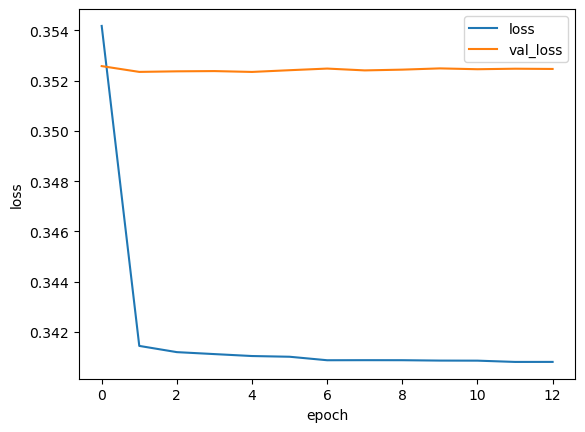

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

train_history = conf.execute_training(
    model, 
    data=train_dataset, 
    plot_history=INTERACTIVE_SESSION
)

In [10]:
# Load best trained model checkpoint
best_model_track = sorted(glob(conf.save_path+'/*.h5'))
if len(best_model_track):
    model.load_weights(best_model_track[0])

# Generate predictions for all images in the test set
val_preds = model.predict(val_dataset[0])

test_preds = model.predict(test_dataset[0])

   1/2010 [..............................] - ETA: 30:36

  12/2010 [..............................] - ETA: 10s  

  22/2010 [..............................] - ETA: 10s

  31/2010 [..............................] - ETA: 10s

  42/2010 [..............................] - ETA: 10s

  52/2010 [..............................] - ETA: 10s

  62/2010 [..............................] - ETA: 10s

  72/2010 [>.............................] - ETA: 10s

  83/2010 [>.............................] - ETA: 9s 

  94/2010 [>.............................] - ETA: 9s

 104/2010 [>.............................] - ETA: 9s

 114/2010 [>.............................] - ETA: 9s

 125/2010 [>.............................] - ETA: 9s

 136/2010 [=>............................] - ETA: 9s

 146/2010 [=>............................] - ETA: 9s

 156/2010 [=>............................] - ETA: 9s

 166/2010 [=>............................] - ETA: 9s

 176/2010 [=>............................] - ETA: 9s

 187/2010 [=>............................] - ETA: 9s

 197/2010 [=>............................] - ETA: 9s

 207/2010 [==>...........................] - ETA: 9s

 217/2010 [==>...........................] - ETA: 9s

 228/2010 [==>...........................] - ETA: 9s

 239/2010 [==>...........................] - ETA: 9s

 249/2010 [==>...........................] - ETA: 9s

 259/2010 [==>...........................] - ETA: 9s

 270/2010 [===>..........................] - ETA: 8s

 280/2010 [===>..........................] - ETA: 8s

 291/2010 [===>..........................] - ETA: 8s

 302/2010 [===>..........................] - ETA: 8s

 313/2010 [===>..........................] - ETA: 8s

 324/2010 [===>..........................] - ETA: 8s

 335/2010 [====>.........................] - ETA: 8s

 346/2010 [====>.........................] - ETA: 8s

 356/2010 [====>.........................] - ETA: 8s

 366/2010 [====>.........................] - ETA: 8s

 376/2010 [====>.........................] - ETA: 8s

 386/2010 [====>.........................] - ETA: 8s

 396/2010 [====>.........................] - ETA: 8s

 406/2010 [=====>........................] - ETA: 8s

 416/2010 [=====>........................] - ETA: 8s

 426/2010 [=====>........................] - ETA: 8s

 436/2010 [=====>........................] - ETA: 8s

 446/2010 [=====>........................] - ETA: 8s

 456/2010 [=====>........................] - ETA: 7s

 466/2010 [=====>........................] - ETA: 7s

 476/2010 [======>.......................] - ETA: 7s

 486/2010 [======>.......................] - ETA: 7s

 496/2010 [======>.......................] - ETA: 7s

 506/2010 [======>.......................] - ETA: 7s

 516/2010 [======>.......................] - ETA: 7s

 526/2010 [======>.......................] - ETA: 7s

 536/2010 [=======>......................] - ETA: 7s

 546/2010 [=======>......................] - ETA: 7s

 556/2010 [=======>......................] - ETA: 7s

 566/2010 [=======>......................] - ETA: 7s

 576/2010 [=======>......................] - ETA: 7s

 586/2010 [=======>......................] - ETA: 7s

 596/2010 [=======>......................] - ETA: 7s

 606/2010 [========>.....................] - ETA: 7s

 616/2010 [========>.....................] - ETA: 7s

 626/2010 [========>.....................] - ETA: 7s

 636/2010 [========>.....................] - ETA: 7s

 646/2010 [========>.....................] - ETA: 7s

 656/2010 [========>.....................] - ETA: 6s

 666/2010 [========>.....................] - ETA: 6s

 676/2010 [=========>....................] - ETA: 6s

 686/2010 [=========>....................] - ETA: 6s

 696/2010 [=========>....................] - ETA: 6s

 706/2010 [=========>....................] - ETA: 6s

 716/2010 [=========>....................] - ETA: 6s

 726/2010 [=========>....................] - ETA: 6s

 736/2010 [=========>....................] - ETA: 6s

 746/2010 [==========>...................] - ETA: 6s

 756/2010 [==========>...................] - ETA: 6s

 766/2010 [==========>...................] - ETA: 6s

 776/2010 [==========>...................] - ETA: 6s

 786/2010 [==========>...................] - ETA: 6s

 796/2010 [==========>...................] - ETA: 6s

 806/2010 [===========>..................] - ETA: 6s

 816/2010 [===========>..................] - ETA: 6s

 827/2010 [===========>..................] - ETA: 6s

 838/2010 [===========>..................] - ETA: 6s

 848/2010 [===========>..................] - ETA: 5s

 858/2010 [===========>..................] - ETA: 5s

 868/2010 [===========>..................] - ETA: 5s

 878/2010 [============>.................] - ETA: 5s

 888/2010 [============>.................] - ETA: 5s

 898/2010 [============>.................] - ETA: 5s

 908/2010 [============>.................] - ETA: 5s

 919/2010 [============>.................] - ETA: 5s

 930/2010 [============>.................] - ETA: 5s

 941/2010 [=============>................] - ETA: 5s

 951/2010 [=============>................] - ETA: 5s

 961/2010 [=============>................] - ETA: 5s

 971/2010 [=============>................] - ETA: 5s

 981/2010 [=============>................] - ETA: 5s

 992/2010 [=============>................] - ETA: 5s

1003/2010 [=============>................] - ETA: 5s

1013/2010 [==============>...............] - ETA: 5s

1023/2010 [==============>...............] - ETA: 5s

1033/2010 [==============>...............] - ETA: 5s

1044/2010 [==============>...............] - ETA: 4s

1054/2010 [==============>...............] - ETA: 4s

1064/2010 [==============>...............] - ETA: 4s

1074/2010 [===============>..............] - ETA: 4s

1085/2010 [===============>..............] - ETA: 4s

1096/2010 [===============>..............] - ETA: 4s

1107/2010 [===============>..............] - ETA: 4s

1118/2010 [===============>..............] - ETA: 4s

1129/2010 [===============>..............] - ETA: 4s

1140/2010 [================>.............] - ETA: 4s

1150/2010 [================>.............] - ETA: 4s

1160/2010 [================>.............] - ETA: 4s

1170/2010 [================>.............] - ETA: 4s

1181/2010 [================>.............] - ETA: 4s

1192/2010 [================>.............] - ETA: 4s

1203/2010 [================>.............] - ETA: 4s

1214/2010 [=================>............] - ETA: 4s

1225/2010 [=================>............] - ETA: 4s

1236/2010 [=================>............] - ETA: 3s

1247/2010 [=================>............] - ETA: 3s

1257/2010 [=================>............] - ETA: 3s

1267/2010 [=================>............] - ETA: 3s

1277/2010 [==================>...........] - ETA: 3s

1287/2010 [==================>...........] - ETA: 3s

1297/2010 [==================>...........] - ETA: 3s

1307/2010 [==================>...........] - ETA: 3s

1317/2010 [==================>...........] - ETA: 3s

1327/2010 [==================>...........] - ETA: 3s

1337/2010 [==================>...........] - ETA: 3s

1347/2010 [===================>..........] - ETA: 3s

1357/2010 [===================>..........] - ETA: 3s

1367/2010 [===================>..........] - ETA: 3s

1377/2010 [===================>..........] - ETA: 3s

1387/2010 [===================>..........] - ETA: 3s

1397/2010 [===================>..........] - ETA: 3s

1407/2010 [====================>.........] - ETA: 3s

1417/2010 [====================>.........] - ETA: 3s

1427/2010 [====================>.........] - ETA: 2s

1437/2010 [====================>.........] - ETA: 2s

1447/2010 [====================>.........] - ETA: 2s

1457/2010 [====================>.........] - ETA: 2s

1467/2010 [====================>.........] - ETA: 2s

1477/2010 [=====================>........] - ETA: 2s

1487/2010 [=====================>........] - ETA: 2s

1497/2010 [=====================>........] - ETA: 2s

1507/2010 [=====================>........] - ETA: 2s

1517/2010 [=====================>........] - ETA: 2s

1527/2010 [=====================>........] - ETA: 2s

1537/2010 [=====================>........] - ETA: 2s

1547/2010 [======================>.......] - ETA: 2s

1557/2010 [======================>.......] - ETA: 2s

1567/2010 [======================>.......] - ETA: 2s

1577/2010 [======================>.......] - ETA: 2s

1587/2010 [======================>.......] - ETA: 2s

1597/2010 [======================>.......] - ETA: 2s

1607/2010 [======================>.......] - ETA: 2s

1617/2010 [=======================>......] - ETA: 2s

1627/2010 [=======================>......] - ETA: 1s

1637/2010 [=======================>......] - ETA: 1s

1647/2010 [=======================>......] - ETA: 1s

1657/2010 [=======================>......] - ETA: 1s

1667/2010 [=======================>......] - ETA: 1s

1677/2010 [========================>.....] - ETA: 1s

1687/2010 [========================>.....] - ETA: 1s

1697/2010 [========================>.....] - ETA: 1s

1707/2010 [========================>.....] - ETA: 1s

1717/2010 [========================>.....] - ETA: 1s

1727/2010 [========================>.....] - ETA: 1s

1738/2010 [========================>.....] - ETA: 1s

1748/2010 [=========================>....] - ETA: 1s

1758/2010 [=========================>....] - ETA: 1s

1768/2010 [=========================>....] - ETA: 1s

1779/2010 [=========================>....] - ETA: 1s

1790/2010 [=========================>....] - ETA: 1s

1800/2010 [=========================>....] - ETA: 1s

1810/2010 [==========================>...] - ETA: 1s

1820/2010 [==========================>...] - ETA: 0s

1830/2010 [==========================>...] - ETA: 0s

1841/2010 [==========================>...] - ETA: 0s

1852/2010 [==========================>...] - ETA: 0s

1863/2010 [==========================>...] - ETA: 0s

1874/2010 [==========================>...] - ETA: 0s

1884/2010 [===========================>..] - ETA: 0s

1894/2010 [===========================>..] - ETA: 0s

1904/2010 [===========================>..] - ETA: 0s

1914/2010 [===========================>..] - ETA: 0s

1924/2010 [===========================>..] - ETA: 0s

1935/2010 [===========================>..] - ETA: 0s

1945/2010 [============================>.] - ETA: 0s

1955/2010 [============================>.] - ETA: 0s

1965/2010 [============================>.] - ETA: 0s

1976/2010 [============================>.] - ETA: 0s

1987/2010 [============================>.] - ETA: 0s

1997/2010 [============================>.] - ETA: 0s

2007/2010 [============================>.] - ETA: 0s

2010/2010 [==============================] - ETA: 0s

2010/2010 [==============================] - 12s 5ms/step


   1/2065 [..............................] - ETA: 1:09

  12/2065 [..............................] - ETA: 10s 

  23/2065 [..............................] - ETA: 10s

  33/2065 [..............................] - ETA: 10s

  43/2065 [..............................] - ETA: 10s

  53/2065 [..............................] - ETA: 10s

  63/2065 [..............................] - ETA: 10s

  73/2065 [>.............................] - ETA: 10s

  83/2065 [>.............................] - ETA: 10s

  93/2065 [>.............................] - ETA: 10s

 103/2065 [>.............................] - ETA: 10s

 113/2065 [>.............................] - ETA: 10s

 123/2065 [>.............................] - ETA: 10s

 133/2065 [>.............................] - ETA: 10s

 143/2065 [=>............................] - ETA: 10s

 153/2065 [=>............................] - ETA: 10s

 163/2065 [=>............................] - ETA: 9s 

 173/2065 [=>............................] - ETA: 9s

 183/2065 [=>............................] - ETA: 9s

 193/2065 [=>............................] - ETA: 9s

 203/2065 [=>............................] - ETA: 9s

 213/2065 [==>...........................] - ETA: 9s

 223/2065 [==>...........................] - ETA: 9s

 233/2065 [==>...........................] - ETA: 9s

 243/2065 [==>...........................] - ETA: 9s

 253/2065 [==>...........................] - ETA: 9s

 263/2065 [==>...........................] - ETA: 9s

 273/2065 [==>...........................] - ETA: 9s

 283/2065 [===>..........................] - ETA: 9s

 293/2065 [===>..........................] - ETA: 9s

 304/2065 [===>..........................] - ETA: 9s

 314/2065 [===>..........................] - ETA: 9s

 324/2065 [===>..........................] - ETA: 9s

 335/2065 [===>..........................] - ETA: 9s

 346/2065 [====>.........................] - ETA: 8s

 356/2065 [====>.........................] - ETA: 8s

 366/2065 [====>.........................] - ETA: 8s

 376/2065 [====>.........................] - ETA: 8s

 387/2065 [====>.........................] - ETA: 8s

 397/2065 [====>.........................] - ETA: 8s

 408/2065 [====>.........................] - ETA: 8s

 418/2065 [=====>........................] - ETA: 8s

 429/2065 [=====>........................] - ETA: 8s

 440/2065 [=====>........................] - ETA: 8s

 450/2065 [=====>........................] - ETA: 8s

 460/2065 [=====>........................] - ETA: 8s

 470/2065 [=====>........................] - ETA: 8s

 480/2065 [=====>........................] - ETA: 8s

 490/2065 [======>.......................] - ETA: 8s

 500/2065 [======>.......................] - ETA: 8s

 510/2065 [======>.......................] - ETA: 8s

 520/2065 [======>.......................] - ETA: 7s

 530/2065 [======>.......................] - ETA: 7s

 540/2065 [======>.......................] - ETA: 7s

 550/2065 [======>.......................] - ETA: 7s

 560/2065 [=======>......................] - ETA: 7s

 570/2065 [=======>......................] - ETA: 7s

 581/2065 [=======>......................] - ETA: 7s

 592/2065 [=======>......................] - ETA: 7s

 603/2065 [=======>......................] - ETA: 7s

 614/2065 [=======>......................] - ETA: 7s

 624/2065 [========>.....................] - ETA: 7s

 634/2065 [========>.....................] - ETA: 7s

 644/2065 [========>.....................] - ETA: 7s

 654/2065 [========>.....................] - ETA: 7s

 664/2065 [========>.....................] - ETA: 7s

 674/2065 [========>.....................] - ETA: 7s

 685/2065 [========>.....................] - ETA: 7s

 695/2065 [=========>....................] - ETA: 7s

 705/2065 [=========>....................] - ETA: 7s

 715/2065 [=========>....................] - ETA: 6s

 725/2065 [=========>....................] - ETA: 6s

 735/2065 [=========>....................] - ETA: 6s

 745/2065 [=========>....................] - ETA: 6s

 755/2065 [=========>....................] - ETA: 6s

 765/2065 [==========>...................] - ETA: 6s

 775/2065 [==========>...................] - ETA: 6s

 785/2065 [==========>...................] - ETA: 6s

 795/2065 [==========>...................] - ETA: 6s

 805/2065 [==========>...................] - ETA: 6s

 815/2065 [==========>...................] - ETA: 6s

 825/2065 [==========>...................] - ETA: 6s

 835/2065 [===========>..................] - ETA: 6s

 845/2065 [===========>..................] - ETA: 6s

 855/2065 [===========>..................] - ETA: 6s

 865/2065 [===========>..................] - ETA: 6s

 875/2065 [===========>..................] - ETA: 6s

 885/2065 [===========>..................] - ETA: 6s

 895/2065 [============>.................] - ETA: 6s

 905/2065 [============>.................] - ETA: 6s

 915/2065 [============>.................] - ETA: 5s

 925/2065 [============>.................] - ETA: 5s

 935/2065 [============>.................] - ETA: 5s

 945/2065 [============>.................] - ETA: 5s

 955/2065 [============>.................] - ETA: 5s

 965/2065 [=============>................] - ETA: 5s

 975/2065 [=============>................] - ETA: 5s

 985/2065 [=============>................] - ETA: 5s

 995/2065 [=============>................] - ETA: 5s

1005/2065 [=============>................] - ETA: 5s

1015/2065 [=============>................] - ETA: 5s

1025/2065 [=============>................] - ETA: 5s

1035/2065 [==============>...............] - ETA: 5s

1045/2065 [==============>...............] - ETA: 5s

1055/2065 [==============>...............] - ETA: 5s

1065/2065 [==============>...............] - ETA: 5s

1075/2065 [==============>...............] - ETA: 5s

1085/2065 [==============>...............] - ETA: 5s

1095/2065 [==============>...............] - ETA: 5s

1105/2065 [===============>..............] - ETA: 5s

1115/2065 [===============>..............] - ETA: 4s

1125/2065 [===============>..............] - ETA: 4s

1135/2065 [===============>..............] - ETA: 4s

1146/2065 [===============>..............] - ETA: 4s

1157/2065 [===============>..............] - ETA: 4s

1167/2065 [===============>..............] - ETA: 4s

1177/2065 [================>.............] - ETA: 4s

1187/2065 [================>.............] - ETA: 4s

1198/2065 [================>.............] - ETA: 4s

1208/2065 [================>.............] - ETA: 4s

1218/2065 [================>.............] - ETA: 4s

1228/2065 [================>.............] - ETA: 4s

1238/2065 [================>.............] - ETA: 4s

1248/2065 [=================>............] - ETA: 4s

1258/2065 [=================>............] - ETA: 4s

1268/2065 [=================>............] - ETA: 4s

1279/2065 [=================>............] - ETA: 4s

1289/2065 [=================>............] - ETA: 4s

1300/2065 [=================>............] - ETA: 3s

1310/2065 [==================>...........] - ETA: 3s

1321/2065 [==================>...........] - ETA: 3s

1332/2065 [==================>...........] - ETA: 3s

1342/2065 [==================>...........] - ETA: 3s

1352/2065 [==================>...........] - ETA: 3s

1362/2065 [==================>...........] - ETA: 3s

1373/2065 [==================>...........] - ETA: 3s

1384/2065 [===================>..........] - ETA: 3s

1394/2065 [===================>..........] - ETA: 3s

1404/2065 [===================>..........] - ETA: 3s

1413/2065 [===================>..........] - ETA: 3s

1423/2065 [===================>..........] - ETA: 3s

1433/2065 [===================>..........] - ETA: 3s

1442/2065 [===================>..........] - ETA: 3s

1452/2065 [====================>.........] - ETA: 3s

1462/2065 [====================>.........] - ETA: 3s

1473/2065 [====================>.........] - ETA: 3s

1484/2065 [====================>.........] - ETA: 3s

1495/2065 [====================>.........] - ETA: 2s

1506/2065 [====================>.........] - ETA: 2s

1517/2065 [=====================>........] - ETA: 2s

1528/2065 [=====================>........] - ETA: 2s

1539/2065 [=====================>........] - ETA: 2s

1549/2065 [=====================>........] - ETA: 2s

1559/2065 [=====================>........] - ETA: 2s

1569/2065 [=====================>........] - ETA: 2s

1579/2065 [=====================>........] - ETA: 2s

1589/2065 [======================>.......] - ETA: 2s

1599/2065 [======================>.......] - ETA: 2s

1609/2065 [======================>.......] - ETA: 2s

1619/2065 [======================>.......] - ETA: 2s

1629/2065 [======================>.......] - ETA: 2s

1639/2065 [======================>.......] - ETA: 2s

1649/2065 [======================>.......] - ETA: 2s

1659/2065 [=======================>......] - ETA: 2s

1669/2065 [=======================>......] - ETA: 2s

1679/2065 [=======================>......] - ETA: 2s

1689/2065 [=======================>......] - ETA: 1s

1699/2065 [=======================>......] - ETA: 1s

1709/2065 [=======================>......] - ETA: 1s

1719/2065 [=======================>......] - ETA: 1s

1729/2065 [========================>.....] - ETA: 1s

1739/2065 [========================>.....] - ETA: 1s

1749/2065 [========================>.....] - ETA: 1s

1759/2065 [========================>.....] - ETA: 1s

1769/2065 [========================>.....] - ETA: 1s

1779/2065 [========================>.....] - ETA: 1s

1789/2065 [========================>.....] - ETA: 1s

1799/2065 [=========================>....] - ETA: 1s

1809/2065 [=========================>....] - ETA: 1s

1819/2065 [=========================>....] - ETA: 1s

1829/2065 [=========================>....] - ETA: 1s

1839/2065 [=========================>....] - ETA: 1s

1849/2065 [=========================>....] - ETA: 1s

1859/2065 [==========================>...] - ETA: 1s

1869/2065 [==========================>...] - ETA: 1s

1879/2065 [==========================>...] - ETA: 0s

1889/2065 [==========================>...] - ETA: 0s

1899/2065 [==========================>...] - ETA: 0s

1909/2065 [==========================>...] - ETA: 0s

1919/2065 [==========================>...] - ETA: 0s

1929/2065 [===========================>..] - ETA: 0s

1939/2065 [===========================>..] - ETA: 0s

1949/2065 [===========================>..] - ETA: 0s

1959/2065 [===========================>..] - ETA: 0s

1969/2065 [===========================>..] - ETA: 0s

1979/2065 [===========================>..] - ETA: 0s

1990/2065 [===========================>..] - ETA: 0s

2001/2065 [============================>.] - ETA: 0s

2011/2065 [============================>.] - ETA: 0s

2021/2065 [============================>.] - ETA: 0s

2031/2065 [============================>.] - ETA: 0s

2042/2065 [============================>.] - ETA: 0s

2053/2065 [============================>.] - ETA: 0s

2064/2065 [============================>.] - ETA: 0s

2065/2065 [==============================] - 11s 5ms/step


In [11]:
model.evaluate(x=val_dataset[0],y=val_dataset[1])

   1/2010 [..............................] - ETA: 1:10 - loss: 0.3407 - accuracy: 0.8930

   9/2010 [..............................] - ETA: 13s - loss: 0.3493 - accuracy: 0.8886 

  17/2010 [..............................] - ETA: 13s - loss: 0.3494 - accuracy: 0.8885

  25/2010 [..............................] - ETA: 13s - loss: 0.3486 - accuracy: 0.8889

  32/2010 [..............................] - ETA: 13s - loss: 0.3460 - accuracy: 0.8902

  40/2010 [..............................] - ETA: 13s - loss: 0.3478 - accuracy: 0.8893

  48/2010 [..............................] - ETA: 13s - loss: 0.3477 - accuracy: 0.8894

  56/2010 [..............................] - ETA: 13s - loss: 0.3494 - accuracy: 0.8885

  64/2010 [..............................] - ETA: 13s - loss: 0.3498 - accuracy: 0.8884

  72/2010 [>.............................] - ETA: 13s - loss: 0.3505 - accuracy: 0.8880

  80/2010 [>.............................] - ETA: 13s - loss: 0.3499 - accuracy: 0.8883

  88/2010 [>.............................] - ETA: 13s - loss: 0.3503 - accuracy: 0.8882

  96/2010 [>.............................] - ETA: 13s - loss: 0.3498 - accuracy: 0.8884

 104/2010 [>.............................] - ETA: 13s - loss: 0.3495 - accuracy: 0.8885

 112/2010 [>.............................] - ETA: 13s - loss: 0.3498 - accuracy: 0.8884

 120/2010 [>.............................] - ETA: 12s - loss: 0.3500 - accuracy: 0.8883

 128/2010 [>.............................] - ETA: 12s - loss: 0.3498 - accuracy: 0.8884

 136/2010 [=>............................] - ETA: 12s - loss: 0.3504 - accuracy: 0.8881

 144/2010 [=>............................] - ETA: 12s - loss: 0.3502 - accuracy: 0.8882

 152/2010 [=>............................] - ETA: 12s - loss: 0.3500 - accuracy: 0.8883

 160/2010 [=>............................] - ETA: 12s - loss: 0.3501 - accuracy: 0.8882

 168/2010 [=>............................] - ETA: 12s - loss: 0.3498 - accuracy: 0.8884

 176/2010 [=>............................] - ETA: 12s - loss: 0.3502 - accuracy: 0.8882

 184/2010 [=>............................] - ETA: 12s - loss: 0.3502 - accuracy: 0.8882

 192/2010 [=>............................] - ETA: 12s - loss: 0.3504 - accuracy: 0.8881

 200/2010 [=>............................] - ETA: 12s - loss: 0.3505 - accuracy: 0.8881

 208/2010 [==>...........................] - ETA: 12s - loss: 0.3503 - accuracy: 0.8882

 216/2010 [==>...........................] - ETA: 12s - loss: 0.3509 - accuracy: 0.8879

 224/2010 [==>...........................] - ETA: 12s - loss: 0.3511 - accuracy: 0.8878

 232/2010 [==>...........................] - ETA: 12s - loss: 0.3510 - accuracy: 0.8878

 240/2010 [==>...........................] - ETA: 12s - loss: 0.3513 - accuracy: 0.8877

 248/2010 [==>...........................] - ETA: 12s - loss: 0.3510 - accuracy: 0.8878

 256/2010 [==>...........................] - ETA: 11s - loss: 0.3509 - accuracy: 0.8879

 264/2010 [==>...........................] - ETA: 11s - loss: 0.3511 - accuracy: 0.8878

 272/2010 [===>..........................] - ETA: 11s - loss: 0.3510 - accuracy: 0.8878

 280/2010 [===>..........................] - ETA: 11s - loss: 0.3512 - accuracy: 0.8877

 288/2010 [===>..........................] - ETA: 11s - loss: 0.3515 - accuracy: 0.8876

 296/2010 [===>..........................] - ETA: 11s - loss: 0.3515 - accuracy: 0.8876

 304/2010 [===>..........................] - ETA: 11s - loss: 0.3513 - accuracy: 0.8877

 312/2010 [===>..........................] - ETA: 11s - loss: 0.3517 - accuracy: 0.8875

 320/2010 [===>..........................] - ETA: 11s - loss: 0.3518 - accuracy: 0.8874

 328/2010 [===>..........................] - ETA: 11s - loss: 0.3518 - accuracy: 0.8874

 336/2010 [====>.........................] - ETA: 11s - loss: 0.3520 - accuracy: 0.8874

 344/2010 [====>.........................] - ETA: 11s - loss: 0.3518 - accuracy: 0.8874

 352/2010 [====>.........................] - ETA: 11s - loss: 0.3518 - accuracy: 0.8874

 360/2010 [====>.........................] - ETA: 11s - loss: 0.3517 - accuracy: 0.8874

 368/2010 [====>.........................] - ETA: 11s - loss: 0.3517 - accuracy: 0.8875

 376/2010 [====>.........................] - ETA: 11s - loss: 0.3518 - accuracy: 0.8874

 384/2010 [====>.........................] - ETA: 11s - loss: 0.3518 - accuracy: 0.8874

 392/2010 [====>.........................] - ETA: 11s - loss: 0.3518 - accuracy: 0.8874

 399/2010 [====>.........................] - ETA: 11s - loss: 0.3517 - accuracy: 0.8875

 406/2010 [=====>........................] - ETA: 10s - loss: 0.3518 - accuracy: 0.8874

 414/2010 [=====>........................] - ETA: 10s - loss: 0.3519 - accuracy: 0.8873

 422/2010 [=====>........................] - ETA: 10s - loss: 0.3520 - accuracy: 0.8873

 430/2010 [=====>........................] - ETA: 10s - loss: 0.3519 - accuracy: 0.8874

 438/2010 [=====>........................] - ETA: 10s - loss: 0.3520 - accuracy: 0.8873

 446/2010 [=====>........................] - ETA: 10s - loss: 0.3522 - accuracy: 0.8872

 454/2010 [=====>........................] - ETA: 10s - loss: 0.3524 - accuracy: 0.8871

 461/2010 [=====>........................] - ETA: 10s - loss: 0.3523 - accuracy: 0.8872

 469/2010 [======>.......................] - ETA: 10s - loss: 0.3524 - accuracy: 0.8871

 477/2010 [======>.......................] - ETA: 10s - loss: 0.3524 - accuracy: 0.8871

 484/2010 [======>.......................] - ETA: 10s - loss: 0.3525 - accuracy: 0.8871

 491/2010 [======>.......................] - ETA: 10s - loss: 0.3525 - accuracy: 0.8871

 499/2010 [======>.......................] - ETA: 10s - loss: 0.3524 - accuracy: 0.8871

 507/2010 [======>.......................] - ETA: 10s - loss: 0.3526 - accuracy: 0.8870

 515/2010 [======>.......................] - ETA: 10s - loss: 0.3525 - accuracy: 0.8871

 523/2010 [======>.......................] - ETA: 10s - loss: 0.3526 - accuracy: 0.8870

 531/2010 [======>.......................] - ETA: 10s - loss: 0.3527 - accuracy: 0.8870

 539/2010 [=======>......................] - ETA: 10s - loss: 0.3527 - accuracy: 0.8870

 547/2010 [=======>......................] - ETA: 10s - loss: 0.3526 - accuracy: 0.8870

 555/2010 [=======>......................] - ETA: 9s - loss: 0.3527 - accuracy: 0.8870 

 563/2010 [=======>......................] - ETA: 9s - loss: 0.3526 - accuracy: 0.8870

 571/2010 [=======>......................] - ETA: 9s - loss: 0.3526 - accuracy: 0.8870

 579/2010 [=======>......................] - ETA: 9s - loss: 0.3526 - accuracy: 0.8870

 587/2010 [=======>......................] - ETA: 9s - loss: 0.3525 - accuracy: 0.8871

 595/2010 [=======>......................] - ETA: 9s - loss: 0.3525 - accuracy: 0.8871

 603/2010 [========>.....................] - ETA: 9s - loss: 0.3524 - accuracy: 0.8871

 611/2010 [========>.....................] - ETA: 9s - loss: 0.3523 - accuracy: 0.8872

 619/2010 [========>.....................] - ETA: 9s - loss: 0.3524 - accuracy: 0.8871

 627/2010 [========>.....................] - ETA: 9s - loss: 0.3524 - accuracy: 0.8871

 635/2010 [========>.....................] - ETA: 9s - loss: 0.3523 - accuracy: 0.8872

 643/2010 [========>.....................] - ETA: 9s - loss: 0.3522 - accuracy: 0.8872

 651/2010 [========>.....................] - ETA: 9s - loss: 0.3521 - accuracy: 0.8873

 659/2010 [========>.....................] - ETA: 9s - loss: 0.3521 - accuracy: 0.8873

 667/2010 [========>.....................] - ETA: 9s - loss: 0.3520 - accuracy: 0.8873

 675/2010 [=========>....................] - ETA: 9s - loss: 0.3520 - accuracy: 0.8873

 683/2010 [=========>....................] - ETA: 9s - loss: 0.3521 - accuracy: 0.8873

 690/2010 [=========>....................] - ETA: 8s - loss: 0.3521 - accuracy: 0.8873

 698/2010 [=========>....................] - ETA: 8s - loss: 0.3520 - accuracy: 0.8873

 706/2010 [=========>....................] - ETA: 8s - loss: 0.3519 - accuracy: 0.8873

 714/2010 [=========>....................] - ETA: 8s - loss: 0.3519 - accuracy: 0.8874

 722/2010 [=========>....................] - ETA: 8s - loss: 0.3519 - accuracy: 0.8874

 730/2010 [=========>....................] - ETA: 8s - loss: 0.3517 - accuracy: 0.8874

 738/2010 [==========>...................] - ETA: 8s - loss: 0.3519 - accuracy: 0.8874

 746/2010 [==========>...................] - ETA: 8s - loss: 0.3520 - accuracy: 0.8873

 754/2010 [==========>...................] - ETA: 8s - loss: 0.3520 - accuracy: 0.8873

 762/2010 [==========>...................] - ETA: 8s - loss: 0.3519 - accuracy: 0.8873

 770/2010 [==========>...................] - ETA: 8s - loss: 0.3519 - accuracy: 0.8874

 778/2010 [==========>...................] - ETA: 8s - loss: 0.3519 - accuracy: 0.8873

 787/2010 [==========>...................] - ETA: 8s - loss: 0.3520 - accuracy: 0.8873

 795/2010 [==========>...................] - ETA: 8s - loss: 0.3520 - accuracy: 0.8873

 803/2010 [==========>...................] - ETA: 8s - loss: 0.3520 - accuracy: 0.8873

 811/2010 [===========>..................] - ETA: 8s - loss: 0.3520 - accuracy: 0.8873

 819/2010 [===========>..................] - ETA: 8s - loss: 0.3521 - accuracy: 0.8873

 827/2010 [===========>..................] - ETA: 8s - loss: 0.3522 - accuracy: 0.8872

 835/2010 [===========>..................] - ETA: 7s - loss: 0.3521 - accuracy: 0.8872

 843/2010 [===========>..................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8872

 851/2010 [===========>..................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8872

 859/2010 [===========>..................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8872

 867/2010 [===========>..................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8872

 875/2010 [============>.................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8872

 883/2010 [============>.................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8872

 891/2010 [============>.................] - ETA: 7s - loss: 0.3523 - accuracy: 0.8872

 899/2010 [============>.................] - ETA: 7s - loss: 0.3523 - accuracy: 0.8872

 907/2010 [============>.................] - ETA: 7s - loss: 0.3523 - accuracy: 0.8872

 915/2010 [============>.................] - ETA: 7s - loss: 0.3523 - accuracy: 0.8872

 923/2010 [============>.................] - ETA: 7s - loss: 0.3524 - accuracy: 0.8871

 931/2010 [============>.................] - ETA: 7s - loss: 0.3523 - accuracy: 0.8872

 939/2010 [=============>................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8872

 947/2010 [=============>................] - ETA: 7s - loss: 0.3521 - accuracy: 0.8873

 955/2010 [=============>................] - ETA: 7s - loss: 0.3521 - accuracy: 0.8873

 963/2010 [=============>................] - ETA: 7s - loss: 0.3521 - accuracy: 0.8873

 971/2010 [=============>................] - ETA: 7s - loss: 0.3521 - accuracy: 0.8873

 979/2010 [=============>................] - ETA: 6s - loss: 0.3521 - accuracy: 0.8873

 987/2010 [=============>................] - ETA: 6s - loss: 0.3522 - accuracy: 0.8872

 995/2010 [=============>................] - ETA: 6s - loss: 0.3521 - accuracy: 0.8873

1003/2010 [=============>................] - ETA: 6s - loss: 0.3522 - accuracy: 0.8872

1011/2010 [==============>...............] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

1019/2010 [==============>...............] - ETA: 6s - loss: 0.3522 - accuracy: 0.8872

1027/2010 [==============>...............] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

1035/2010 [==============>...............] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

1043/2010 [==============>...............] - ETA: 6s - loss: 0.3524 - accuracy: 0.8871

1051/2010 [==============>...............] - ETA: 6s - loss: 0.3524 - accuracy: 0.8871

1059/2010 [==============>...............] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

1067/2010 [==============>...............] - ETA: 6s - loss: 0.3524 - accuracy: 0.8871

1075/2010 [===============>..............] - ETA: 6s - loss: 0.3524 - accuracy: 0.8871

1083/2010 [===============>..............] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

1091/2010 [===============>..............] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

1099/2010 [===============>..............] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

1107/2010 [===============>..............] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

1115/2010 [===============>..............] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

1123/2010 [===============>..............] - ETA: 6s - loss: 0.3522 - accuracy: 0.8872

1131/2010 [===============>..............] - ETA: 5s - loss: 0.3522 - accuracy: 0.8872

1139/2010 [================>.............] - ETA: 5s - loss: 0.3522 - accuracy: 0.8872

1147/2010 [================>.............] - ETA: 5s - loss: 0.3521 - accuracy: 0.8872

1155/2010 [================>.............] - ETA: 5s - loss: 0.3521 - accuracy: 0.8873

1163/2010 [================>.............] - ETA: 5s - loss: 0.3522 - accuracy: 0.8872

1171/2010 [================>.............] - ETA: 5s - loss: 0.3522 - accuracy: 0.8872

1179/2010 [================>.............] - ETA: 5s - loss: 0.3521 - accuracy: 0.8872

1186/2010 [================>.............] - ETA: 5s - loss: 0.3521 - accuracy: 0.8873

1194/2010 [================>.............] - ETA: 5s - loss: 0.3521 - accuracy: 0.8873

1202/2010 [================>.............] - ETA: 5s - loss: 0.3520 - accuracy: 0.8873

1210/2010 [=================>............] - ETA: 5s - loss: 0.3519 - accuracy: 0.8873

1218/2010 [=================>............] - ETA: 5s - loss: 0.3520 - accuracy: 0.8873

1226/2010 [=================>............] - ETA: 5s - loss: 0.3520 - accuracy: 0.8873

1234/2010 [=================>............] - ETA: 5s - loss: 0.3521 - accuracy: 0.8873

1242/2010 [=================>............] - ETA: 5s - loss: 0.3521 - accuracy: 0.8873

1250/2010 [=================>............] - ETA: 5s - loss: 0.3520 - accuracy: 0.8873

1258/2010 [=================>............] - ETA: 5s - loss: 0.3520 - accuracy: 0.8873

1266/2010 [=================>............] - ETA: 5s - loss: 0.3520 - accuracy: 0.8873

1274/2010 [==================>...........] - ETA: 4s - loss: 0.3521 - accuracy: 0.8873

1282/2010 [==================>...........] - ETA: 4s - loss: 0.3521 - accuracy: 0.8873

1290/2010 [==================>...........] - ETA: 4s - loss: 0.3521 - accuracy: 0.8873

1298/2010 [==================>...........] - ETA: 4s - loss: 0.3521 - accuracy: 0.8873

1306/2010 [==================>...........] - ETA: 4s - loss: 0.3521 - accuracy: 0.8873

1314/2010 [==================>...........] - ETA: 4s - loss: 0.3521 - accuracy: 0.8873

1322/2010 [==================>...........] - ETA: 4s - loss: 0.3522 - accuracy: 0.8872

1330/2010 [==================>...........] - ETA: 4s - loss: 0.3522 - accuracy: 0.8872

1338/2010 [==================>...........] - ETA: 4s - loss: 0.3522 - accuracy: 0.8872

1346/2010 [===================>..........] - ETA: 4s - loss: 0.3522 - accuracy: 0.8872

1354/2010 [===================>..........] - ETA: 4s - loss: 0.3522 - accuracy: 0.8872

1362/2010 [===================>..........] - ETA: 4s - loss: 0.3522 - accuracy: 0.8872

1370/2010 [===================>..........] - ETA: 4s - loss: 0.3522 - accuracy: 0.8872

1378/2010 [===================>..........] - ETA: 4s - loss: 0.3522 - accuracy: 0.8872

1386/2010 [===================>..........] - ETA: 4s - loss: 0.3523 - accuracy: 0.8872

1394/2010 [===================>..........] - ETA: 4s - loss: 0.3523 - accuracy: 0.8872

1401/2010 [===================>..........] - ETA: 4s - loss: 0.3523 - accuracy: 0.8872

1408/2010 [====================>.........] - ETA: 4s - loss: 0.3523 - accuracy: 0.8872

1415/2010 [====================>.........] - ETA: 4s - loss: 0.3523 - accuracy: 0.8872

1422/2010 [====================>.........] - ETA: 3s - loss: 0.3522 - accuracy: 0.8872

1429/2010 [====================>.........] - ETA: 3s - loss: 0.3521 - accuracy: 0.8872

1436/2010 [====================>.........] - ETA: 3s - loss: 0.3522 - accuracy: 0.8872

1443/2010 [====================>.........] - ETA: 3s - loss: 0.3522 - accuracy: 0.8872

1450/2010 [====================>.........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1458/2010 [====================>.........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1465/2010 [====================>.........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1473/2010 [====================>.........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1481/2010 [=====================>........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1489/2010 [=====================>........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1497/2010 [=====================>........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1505/2010 [=====================>........] - ETA: 3s - loss: 0.3522 - accuracy: 0.8872

1513/2010 [=====================>........] - ETA: 3s - loss: 0.3522 - accuracy: 0.8872

1521/2010 [=====================>........] - ETA: 3s - loss: 0.3522 - accuracy: 0.8872

1529/2010 [=====================>........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1537/2010 [=====================>........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1545/2010 [======================>.......] - ETA: 3s - loss: 0.3522 - accuracy: 0.8872

1553/2010 [======================>.......] - ETA: 3s - loss: 0.3522 - accuracy: 0.8872

1561/2010 [======================>.......] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1569/2010 [======================>.......] - ETA: 3s - loss: 0.3522 - accuracy: 0.8872

1577/2010 [======================>.......] - ETA: 2s - loss: 0.3522 - accuracy: 0.8872

1585/2010 [======================>.......] - ETA: 2s - loss: 0.3522 - accuracy: 0.8872

1593/2010 [======================>.......] - ETA: 2s - loss: 0.3522 - accuracy: 0.8872

1601/2010 [======================>.......] - ETA: 2s - loss: 0.3522 - accuracy: 0.8872

1609/2010 [=======================>......] - ETA: 2s - loss: 0.3522 - accuracy: 0.8872

1617/2010 [=======================>......] - ETA: 2s - loss: 0.3522 - accuracy: 0.8872

1625/2010 [=======================>......] - ETA: 2s - loss: 0.3521 - accuracy: 0.8872

1633/2010 [=======================>......] - ETA: 2s - loss: 0.3521 - accuracy: 0.8873

1641/2010 [=======================>......] - ETA: 2s - loss: 0.3521 - accuracy: 0.8873

1649/2010 [=======================>......] - ETA: 2s - loss: 0.3521 - accuracy: 0.8873

1657/2010 [=======================>......] - ETA: 2s - loss: 0.3521 - accuracy: 0.8873

1665/2010 [=======================>......] - ETA: 2s - loss: 0.3521 - accuracy: 0.8873

1673/2010 [=======================>......] - ETA: 2s - loss: 0.3521 - accuracy: 0.8873

1681/2010 [========================>.....] - ETA: 2s - loss: 0.3521 - accuracy: 0.8872

1689/2010 [========================>.....] - ETA: 2s - loss: 0.3521 - accuracy: 0.8873

1697/2010 [========================>.....] - ETA: 2s - loss: 0.3521 - accuracy: 0.8873

1705/2010 [========================>.....] - ETA: 2s - loss: 0.3522 - accuracy: 0.8872

1713/2010 [========================>.....] - ETA: 2s - loss: 0.3522 - accuracy: 0.8872

1721/2010 [========================>.....] - ETA: 1s - loss: 0.3522 - accuracy: 0.8872

1729/2010 [========================>.....] - ETA: 1s - loss: 0.3522 - accuracy: 0.8872

1737/2010 [========================>.....] - ETA: 1s - loss: 0.3522 - accuracy: 0.8872

1745/2010 [=========================>....] - ETA: 1s - loss: 0.3522 - accuracy: 0.8872

1753/2010 [=========================>....] - ETA: 1s - loss: 0.3522 - accuracy: 0.8872

1761/2010 [=========================>....] - ETA: 1s - loss: 0.3522 - accuracy: 0.8872

1769/2010 [=========================>....] - ETA: 1s - loss: 0.3522 - accuracy: 0.8872

1777/2010 [=========================>....] - ETA: 1s - loss: 0.3522 - accuracy: 0.8872

1785/2010 [=========================>....] - ETA: 1s - loss: 0.3522 - accuracy: 0.8872

1793/2010 [=========================>....] - ETA: 1s - loss: 0.3523 - accuracy: 0.8872

1801/2010 [=========================>....] - ETA: 1s - loss: 0.3523 - accuracy: 0.8872

1809/2010 [==========================>...] - ETA: 1s - loss: 0.3523 - accuracy: 0.8872

1817/2010 [==========================>...] - ETA: 1s - loss: 0.3522 - accuracy: 0.8872

1825/2010 [==========================>...] - ETA: 1s - loss: 0.3523 - accuracy: 0.8872

1833/2010 [==========================>...] - ETA: 1s - loss: 0.3523 - accuracy: 0.8872

1841/2010 [==========================>...] - ETA: 1s - loss: 0.3523 - accuracy: 0.8872

1849/2010 [==========================>...] - ETA: 1s - loss: 0.3523 - accuracy: 0.8872

1857/2010 [==========================>...] - ETA: 1s - loss: 0.3523 - accuracy: 0.8872

1865/2010 [==========================>...] - ETA: 0s - loss: 0.3523 - accuracy: 0.8872

1873/2010 [==========================>...] - ETA: 0s - loss: 0.3523 - accuracy: 0.8872

1881/2010 [===========================>..] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1890/2010 [===========================>..] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1898/2010 [===========================>..] - ETA: 0s - loss: 0.3523 - accuracy: 0.8872

1906/2010 [===========================>..] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1914/2010 [===========================>..] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1922/2010 [===========================>..] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1930/2010 [===========================>..] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1938/2010 [===========================>..] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1946/2010 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1954/2010 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1962/2010 [============================>.] - ETA: 0s - loss: 0.3523 - accuracy: 0.8872

1970/2010 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1978/2010 [============================>.] - ETA: 0s - loss: 0.3523 - accuracy: 0.8872

1986/2010 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy: 0.8872

1994/2010 [============================>.] - ETA: 0s - loss: 0.3523 - accuracy: 0.8872

2001/2010 [============================>.] - ETA: 0s - loss: 0.3523 - accuracy: 0.8872

2009/2010 [============================>.] - ETA: 0s - loss: 0.3523 - accuracy: 0.8872

2010/2010 [==============================] - 14s 7ms/step - loss: 0.3523 - accuracy: 0.8871


[0.35234344005584717, 0.887146532535553]

In [12]:
model.evaluate(x=test_dataset[0],y=test_dataset[1])

   1/2065 [..............................] - ETA: 1:17 - loss: 0.3223 - accuracy: 0.9016

   9/2065 [..............................] - ETA: 13s - loss: 0.3315 - accuracy: 0.8973 

  17/2065 [..............................] - ETA: 13s - loss: 0.3377 - accuracy: 0.8943

  25/2065 [..............................] - ETA: 13s - loss: 0.3357 - accuracy: 0.8952

  32/2065 [..............................] - ETA: 13s - loss: 0.3372 - accuracy: 0.8945

  40/2065 [..............................] - ETA: 13s - loss: 0.3385 - accuracy: 0.8938

  48/2065 [..............................] - ETA: 13s - loss: 0.3375 - accuracy: 0.8943

  56/2065 [..............................] - ETA: 13s - loss: 0.3366 - accuracy: 0.8948

  64/2065 [..............................] - ETA: 13s - loss: 0.3372 - accuracy: 0.8945

  72/2065 [>.............................] - ETA: 13s - loss: 0.3370 - accuracy: 0.8946

  80/2065 [>.............................] - ETA: 13s - loss: 0.3373 - accuracy: 0.8944

  88/2065 [>.............................] - ETA: 13s - loss: 0.3380 - accuracy: 0.8940

  96/2065 [>.............................] - ETA: 13s - loss: 0.3387 - accuracy: 0.8937

 104/2065 [>.............................] - ETA: 13s - loss: 0.3383 - accuracy: 0.8939

 112/2065 [>.............................] - ETA: 13s - loss: 0.3383 - accuracy: 0.8939

 120/2065 [>.............................] - ETA: 13s - loss: 0.3378 - accuracy: 0.8942

 128/2065 [>.............................] - ETA: 13s - loss: 0.3380 - accuracy: 0.8940

 136/2065 [>.............................] - ETA: 13s - loss: 0.3377 - accuracy: 0.8942

 144/2065 [=>............................] - ETA: 13s - loss: 0.3374 - accuracy: 0.8943

 152/2065 [=>............................] - ETA: 13s - loss: 0.3373 - accuracy: 0.8944

 160/2065 [=>............................] - ETA: 13s - loss: 0.3375 - accuracy: 0.8943

 168/2065 [=>............................] - ETA: 13s - loss: 0.3376 - accuracy: 0.8942

 175/2065 [=>............................] - ETA: 13s - loss: 0.3375 - accuracy: 0.8943

 183/2065 [=>............................] - ETA: 12s - loss: 0.3378 - accuracy: 0.8941

 191/2065 [=>............................] - ETA: 12s - loss: 0.3378 - accuracy: 0.8941

 199/2065 [=>............................] - ETA: 12s - loss: 0.3380 - accuracy: 0.8940

 207/2065 [==>...........................] - ETA: 12s - loss: 0.3375 - accuracy: 0.8943

 215/2065 [==>...........................] - ETA: 12s - loss: 0.3373 - accuracy: 0.8944

 224/2065 [==>...........................] - ETA: 12s - loss: 0.3373 - accuracy: 0.8944

 232/2065 [==>...........................] - ETA: 12s - loss: 0.3371 - accuracy: 0.8945

 240/2065 [==>...........................] - ETA: 12s - loss: 0.3371 - accuracy: 0.8945

 248/2065 [==>...........................] - ETA: 12s - loss: 0.3371 - accuracy: 0.8945

 256/2065 [==>...........................] - ETA: 12s - loss: 0.3373 - accuracy: 0.8944

 264/2065 [==>...........................] - ETA: 12s - loss: 0.3375 - accuracy: 0.8943

 272/2065 [==>...........................] - ETA: 12s - loss: 0.3377 - accuracy: 0.8942

 280/2065 [===>..........................] - ETA: 12s - loss: 0.3378 - accuracy: 0.8942

 287/2065 [===>..........................] - ETA: 12s - loss: 0.3379 - accuracy: 0.8941

 295/2065 [===>..........................] - ETA: 12s - loss: 0.3375 - accuracy: 0.8943

 303/2065 [===>..........................] - ETA: 11s - loss: 0.3378 - accuracy: 0.8941

 311/2065 [===>..........................] - ETA: 11s - loss: 0.3377 - accuracy: 0.8942

 319/2065 [===>..........................] - ETA: 11s - loss: 0.3375 - accuracy: 0.8943

 326/2065 [===>..........................] - ETA: 11s - loss: 0.3372 - accuracy: 0.8944

 334/2065 [===>..........................] - ETA: 11s - loss: 0.3370 - accuracy: 0.8945

 342/2065 [===>..........................] - ETA: 11s - loss: 0.3371 - accuracy: 0.8945

 350/2065 [====>.........................] - ETA: 11s - loss: 0.3370 - accuracy: 0.8945

 358/2065 [====>.........................] - ETA: 11s - loss: 0.3370 - accuracy: 0.8945

 366/2065 [====>.........................] - ETA: 11s - loss: 0.3370 - accuracy: 0.8945

 373/2065 [====>.........................] - ETA: 11s - loss: 0.3368 - accuracy: 0.8946

 380/2065 [====>.........................] - ETA: 11s - loss: 0.3369 - accuracy: 0.8946

 387/2065 [====>.........................] - ETA: 11s - loss: 0.3369 - accuracy: 0.8946

 396/2065 [====>.........................] - ETA: 11s - loss: 0.3370 - accuracy: 0.8945

 404/2065 [====>.........................] - ETA: 11s - loss: 0.3370 - accuracy: 0.8945

 412/2065 [====>.........................] - ETA: 11s - loss: 0.3372 - accuracy: 0.8944

 420/2065 [=====>........................] - ETA: 11s - loss: 0.3372 - accuracy: 0.8944

 428/2065 [=====>........................] - ETA: 11s - loss: 0.3372 - accuracy: 0.8944

 436/2065 [=====>........................] - ETA: 11s - loss: 0.3371 - accuracy: 0.8945

 444/2065 [=====>........................] - ETA: 11s - loss: 0.3372 - accuracy: 0.8944

 452/2065 [=====>........................] - ETA: 10s - loss: 0.3373 - accuracy: 0.8944

 460/2065 [=====>........................] - ETA: 10s - loss: 0.3374 - accuracy: 0.8943

 468/2065 [=====>........................] - ETA: 10s - loss: 0.3376 - accuracy: 0.8942

 476/2065 [=====>........................] - ETA: 10s - loss: 0.3375 - accuracy: 0.8943

 484/2065 [======>.......................] - ETA: 10s - loss: 0.3375 - accuracy: 0.8943

 492/2065 [======>.......................] - ETA: 10s - loss: 0.3375 - accuracy: 0.8943

 500/2065 [======>.......................] - ETA: 10s - loss: 0.3376 - accuracy: 0.8942

 508/2065 [======>.......................] - ETA: 10s - loss: 0.3376 - accuracy: 0.8943

 516/2065 [======>.......................] - ETA: 10s - loss: 0.3375 - accuracy: 0.8943

 524/2065 [======>.......................] - ETA: 10s - loss: 0.3375 - accuracy: 0.8943

 532/2065 [======>.......................] - ETA: 10s - loss: 0.3374 - accuracy: 0.8943

 540/2065 [======>.......................] - ETA: 10s - loss: 0.3373 - accuracy: 0.8944

 548/2065 [======>.......................] - ETA: 10s - loss: 0.3373 - accuracy: 0.8944

 556/2065 [=======>......................] - ETA: 10s - loss: 0.3373 - accuracy: 0.8944

 564/2065 [=======>......................] - ETA: 10s - loss: 0.3372 - accuracy: 0.8944

 572/2065 [=======>......................] - ETA: 10s - loss: 0.3372 - accuracy: 0.8944

 580/2065 [=======>......................] - ETA: 10s - loss: 0.3371 - accuracy: 0.8945

 588/2065 [=======>......................] - ETA: 9s - loss: 0.3373 - accuracy: 0.8944 

 596/2065 [=======>......................] - ETA: 9s - loss: 0.3374 - accuracy: 0.8943

 605/2065 [=======>......................] - ETA: 9s - loss: 0.3375 - accuracy: 0.8943

 613/2065 [=======>......................] - ETA: 9s - loss: 0.3376 - accuracy: 0.8942

 621/2065 [========>.....................] - ETA: 9s - loss: 0.3376 - accuracy: 0.8942

 629/2065 [========>.....................] - ETA: 9s - loss: 0.3376 - accuracy: 0.8942

 637/2065 [========>.....................] - ETA: 9s - loss: 0.3377 - accuracy: 0.8942

 645/2065 [========>.....................] - ETA: 9s - loss: 0.3377 - accuracy: 0.8942

 653/2065 [========>.....................] - ETA: 9s - loss: 0.3375 - accuracy: 0.8943

 661/2065 [========>.....................] - ETA: 9s - loss: 0.3376 - accuracy: 0.8942

 669/2065 [========>.....................] - ETA: 9s - loss: 0.3376 - accuracy: 0.8942

 677/2065 [========>.....................] - ETA: 9s - loss: 0.3378 - accuracy: 0.8942

 686/2065 [========>.....................] - ETA: 9s - loss: 0.3379 - accuracy: 0.8941

 694/2065 [=========>....................] - ETA: 9s - loss: 0.3379 - accuracy: 0.8941

 702/2065 [=========>....................] - ETA: 9s - loss: 0.3379 - accuracy: 0.8941

 710/2065 [=========>....................] - ETA: 9s - loss: 0.3379 - accuracy: 0.8941

 718/2065 [=========>....................] - ETA: 9s - loss: 0.3379 - accuracy: 0.8941

 726/2065 [=========>....................] - ETA: 9s - loss: 0.3379 - accuracy: 0.8941

 734/2065 [=========>....................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 742/2065 [=========>....................] - ETA: 8s - loss: 0.3378 - accuracy: 0.8941

 750/2065 [=========>....................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 758/2065 [==========>...................] - ETA: 8s - loss: 0.3380 - accuracy: 0.8941

 766/2065 [==========>...................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 774/2065 [==========>...................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 782/2065 [==========>...................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 790/2065 [==========>...................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 797/2065 [==========>...................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 805/2065 [==========>...................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 813/2065 [==========>...................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 821/2065 [==========>...................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 829/2065 [===========>..................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 837/2065 [===========>..................] - ETA: 8s - loss: 0.3380 - accuracy: 0.8940

 845/2065 [===========>..................] - ETA: 8s - loss: 0.3380 - accuracy: 0.8940

 853/2065 [===========>..................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8941

 861/2065 [===========>..................] - ETA: 8s - loss: 0.3377 - accuracy: 0.8942

 869/2065 [===========>..................] - ETA: 8s - loss: 0.3378 - accuracy: 0.8941

 877/2065 [===========>..................] - ETA: 8s - loss: 0.3378 - accuracy: 0.8941

 885/2065 [===========>..................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8942

 893/2065 [===========>..................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

 901/2065 [============>.................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8941

 909/2065 [============>.................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8941

 917/2065 [============>.................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

 925/2065 [============>.................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

 933/2065 [============>.................] - ETA: 7s - loss: 0.3376 - accuracy: 0.8942

 941/2065 [============>.................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

 949/2065 [============>.................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

 957/2065 [============>.................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

 965/2065 [=============>................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

 973/2065 [=============>................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

 981/2065 [=============>................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

 989/2065 [=============>................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

 997/2065 [=============>................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8942

1005/2065 [=============>................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8941

1013/2065 [=============>................] - ETA: 7s - loss: 0.3379 - accuracy: 0.8941

1021/2065 [=============>................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8941

1029/2065 [=============>................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8942

1037/2065 [==============>...............] - ETA: 6s - loss: 0.3379 - accuracy: 0.8941

1045/2065 [==============>...............] - ETA: 6s - loss: 0.3379 - accuracy: 0.8941

1053/2065 [==============>...............] - ETA: 6s - loss: 0.3380 - accuracy: 0.8940

1061/2065 [==============>...............] - ETA: 6s - loss: 0.3381 - accuracy: 0.8940

1069/2065 [==============>...............] - ETA: 6s - loss: 0.3380 - accuracy: 0.8940

1077/2065 [==============>...............] - ETA: 6s - loss: 0.3380 - accuracy: 0.8940

1086/2065 [==============>...............] - ETA: 6s - loss: 0.3380 - accuracy: 0.8940

1094/2065 [==============>...............] - ETA: 6s - loss: 0.3381 - accuracy: 0.8940

1102/2065 [===============>..............] - ETA: 6s - loss: 0.3380 - accuracy: 0.8940

1110/2065 [===============>..............] - ETA: 6s - loss: 0.3381 - accuracy: 0.8940

1119/2065 [===============>..............] - ETA: 6s - loss: 0.3381 - accuracy: 0.8940

1127/2065 [===============>..............] - ETA: 6s - loss: 0.3381 - accuracy: 0.8940

1135/2065 [===============>..............] - ETA: 6s - loss: 0.3380 - accuracy: 0.8940

1143/2065 [===============>..............] - ETA: 6s - loss: 0.3380 - accuracy: 0.8940

1151/2065 [===============>..............] - ETA: 6s - loss: 0.3380 - accuracy: 0.8940

1159/2065 [===============>..............] - ETA: 6s - loss: 0.3380 - accuracy: 0.8940

1167/2065 [===============>..............] - ETA: 6s - loss: 0.3379 - accuracy: 0.8941

1176/2065 [================>.............] - ETA: 6s - loss: 0.3380 - accuracy: 0.8941

1184/2065 [================>.............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8940

1192/2065 [================>.............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8940

1200/2065 [================>.............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8940

1208/2065 [================>.............] - ETA: 5s - loss: 0.3381 - accuracy: 0.8940

1216/2065 [================>.............] - ETA: 5s - loss: 0.3381 - accuracy: 0.8940

1224/2065 [================>.............] - ETA: 5s - loss: 0.3381 - accuracy: 0.8940

1232/2065 [================>.............] - ETA: 5s - loss: 0.3381 - accuracy: 0.8940

1240/2065 [=================>............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8940

1248/2065 [=================>............] - ETA: 5s - loss: 0.3381 - accuracy: 0.8940

1257/2065 [=================>............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8940

1265/2065 [=================>............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8940

1273/2065 [=================>............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8940

1281/2065 [=================>............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8940

1290/2065 [=================>............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8940

1298/2065 [=================>............] - ETA: 5s - loss: 0.3381 - accuracy: 0.8940

1306/2065 [=================>............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8940

1314/2065 [==================>...........] - ETA: 5s - loss: 0.3379 - accuracy: 0.8941

1322/2065 [==================>...........] - ETA: 5s - loss: 0.3379 - accuracy: 0.8941

1330/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1338/2065 [==================>...........] - ETA: 4s - loss: 0.3378 - accuracy: 0.8941

1346/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1354/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1362/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1370/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1378/2065 [===================>..........] - ETA: 4s - loss: 0.3378 - accuracy: 0.8941

1386/2065 [===================>..........] - ETA: 4s - loss: 0.3378 - accuracy: 0.8941

1394/2065 [===================>..........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1402/2065 [===================>..........] - ETA: 4s - loss: 0.3380 - accuracy: 0.8941

1410/2065 [===================>..........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1418/2065 [===================>..........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1426/2065 [===================>..........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1434/2065 [===================>..........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1442/2065 [===================>..........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1449/2065 [====================>.........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1457/2065 [====================>.........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1465/2065 [====================>.........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8941

1473/2065 [====================>.........] - ETA: 3s - loss: 0.3379 - accuracy: 0.8941

1481/2065 [====================>.........] - ETA: 3s - loss: 0.3379 - accuracy: 0.8941

1489/2065 [====================>.........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8940

1496/2065 [====================>.........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8940

1504/2065 [====================>.........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8940

1512/2065 [====================>.........] - ETA: 3s - loss: 0.3381 - accuracy: 0.8940

1520/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8940

1527/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8940

1534/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8940

1541/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8940

1548/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8940

1555/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8940

1562/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8940

1569/2065 [=====================>........] - ETA: 3s - loss: 0.3381 - accuracy: 0.8940

1577/2065 [=====================>........] - ETA: 3s - loss: 0.3381 - accuracy: 0.8940

1584/2065 [======================>.......] - ETA: 3s - loss: 0.3381 - accuracy: 0.8940

1592/2065 [======================>.......] - ETA: 3s - loss: 0.3381 - accuracy: 0.8940

1600/2065 [======================>.......] - ETA: 3s - loss: 0.3381 - accuracy: 0.8940

1608/2065 [======================>.......] - ETA: 3s - loss: 0.3382 - accuracy: 0.8940

1616/2065 [======================>.......] - ETA: 3s - loss: 0.3381 - accuracy: 0.8940

1624/2065 [======================>.......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1632/2065 [======================>.......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1640/2065 [======================>.......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1648/2065 [======================>.......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1656/2065 [=======================>......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1664/2065 [=======================>......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1671/2065 [=======================>......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8940

1679/2065 [=======================>......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8940

1687/2065 [=======================>......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1695/2065 [=======================>......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1703/2065 [=======================>......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1711/2065 [=======================>......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1719/2065 [=======================>......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1727/2065 [========================>.....] - ETA: 2s - loss: 0.3382 - accuracy: 0.8940

1735/2065 [========================>.....] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1743/2065 [========================>.....] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1751/2065 [========================>.....] - ETA: 2s - loss: 0.3381 - accuracy: 0.8940

1759/2065 [========================>.....] - ETA: 2s - loss: 0.3382 - accuracy: 0.8940

1767/2065 [========================>.....] - ETA: 2s - loss: 0.3382 - accuracy: 0.8940

1775/2065 [========================>.....] - ETA: 1s - loss: 0.3382 - accuracy: 0.8940

1783/2065 [========================>.....] - ETA: 1s - loss: 0.3382 - accuracy: 0.8940

1791/2065 [=========================>....] - ETA: 1s - loss: 0.3382 - accuracy: 0.8939

1799/2065 [=========================>....] - ETA: 1s - loss: 0.3382 - accuracy: 0.8939

1807/2065 [=========================>....] - ETA: 1s - loss: 0.3381 - accuracy: 0.8940

1815/2065 [=========================>....] - ETA: 1s - loss: 0.3381 - accuracy: 0.8940

1823/2065 [=========================>....] - ETA: 1s - loss: 0.3381 - accuracy: 0.8940

1831/2065 [=========================>....] - ETA: 1s - loss: 0.3381 - accuracy: 0.8940

1839/2065 [=========================>....] - ETA: 1s - loss: 0.3382 - accuracy: 0.8940

1847/2065 [=========================>....] - ETA: 1s - loss: 0.3382 - accuracy: 0.8940

1855/2065 [=========================>....] - ETA: 1s - loss: 0.3382 - accuracy: 0.8939

1863/2065 [==========================>...] - ETA: 1s - loss: 0.3382 - accuracy: 0.8939

1871/2065 [==========================>...] - ETA: 1s - loss: 0.3382 - accuracy: 0.8939

1879/2065 [==========================>...] - ETA: 1s - loss: 0.3382 - accuracy: 0.8940

1887/2065 [==========================>...] - ETA: 1s - loss: 0.3381 - accuracy: 0.8940

1895/2065 [==========================>...] - ETA: 1s - loss: 0.3381 - accuracy: 0.8940

1903/2065 [==========================>...] - ETA: 1s - loss: 0.3381 - accuracy: 0.8940

1910/2065 [==========================>...] - ETA: 1s - loss: 0.3381 - accuracy: 0.8940

1918/2065 [==========================>...] - ETA: 0s - loss: 0.3381 - accuracy: 0.8940

1926/2065 [==========================>...] - ETA: 0s - loss: 0.3381 - accuracy: 0.8940

1934/2065 [===========================>..] - ETA: 0s - loss: 0.3381 - accuracy: 0.8940

1942/2065 [===========================>..] - ETA: 0s - loss: 0.3381 - accuracy: 0.8940

1950/2065 [===========================>..] - ETA: 0s - loss: 0.3381 - accuracy: 0.8940

1958/2065 [===========================>..] - ETA: 0s - loss: 0.3381 - accuracy: 0.8940

1966/2065 [===========================>..] - ETA: 0s - loss: 0.3382 - accuracy: 0.8940

1974/2065 [===========================>..] - ETA: 0s - loss: 0.3382 - accuracy: 0.8939

1982/2065 [===========================>..] - ETA: 0s - loss: 0.3382 - accuracy: 0.8939

1990/2065 [===========================>..] - ETA: 0s - loss: 0.3382 - accuracy: 0.8939

1998/2065 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8939

2006/2065 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8939

2013/2065 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8939

2021/2065 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8939

2029/2065 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8939

2036/2065 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8939

2043/2065 [============================>.] - ETA: 0s - loss: 0.3383 - accuracy: 0.8939

2051/2065 [============================>.] - ETA: 0s - loss: 0.3383 - accuracy: 0.8939

2059/2065 [============================>.] - ETA: 0s - loss: 0.3383 - accuracy: 0.8939

2065/2065 [==============================] - 14s 7ms/step - loss: 0.3383 - accuracy: 0.8939


[0.33830526471138, 0.8938888907432556]

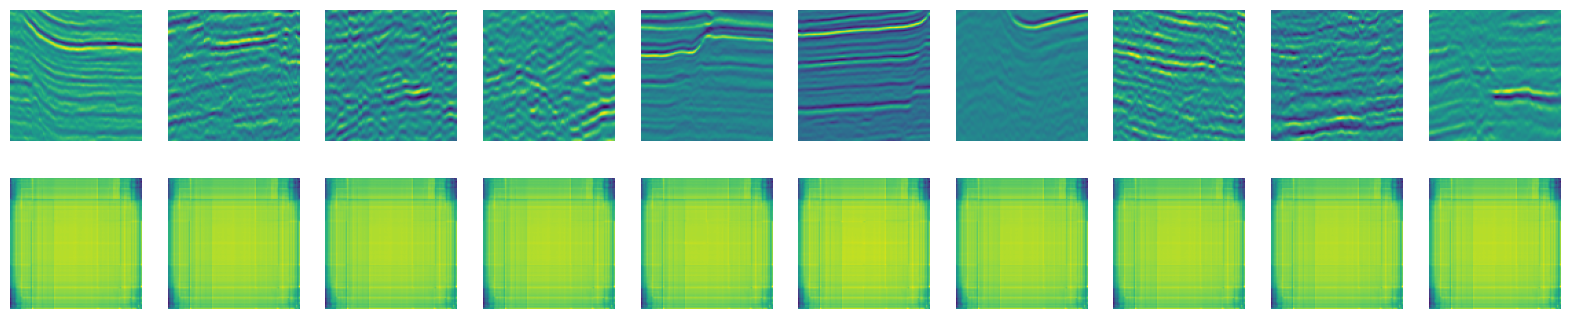

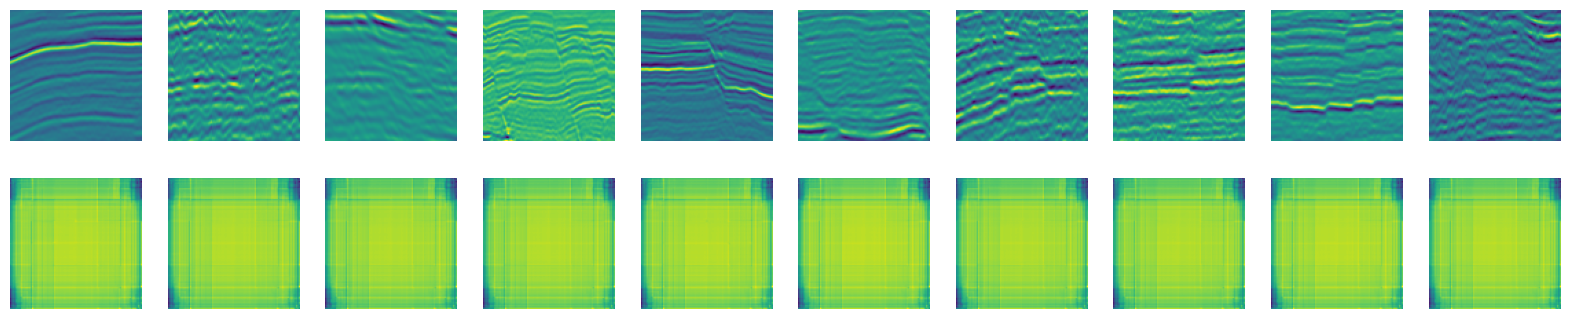

In [13]:
if INTERACTIVE_SESSION:
    display_sample_images(val_dataset[0], val_preds, img_shape=(96,96))
    display_sample_images(test_dataset[0], test_preds, img_shape=(96,96))